In [1]:
# This script analyses data from the UKESM1 [NEMO] CHL-a datasets I simulated
import os
import random
os.chdir("/home/ybh10/Scripts/")
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import glob
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs

import cartopy.feature as cfeature
from scipy.stats import stats
import gc
import math
from scipy.stats import sem
import seaborn as sns
import copy
import matplotlib.patches as patches
from my_functions import *
import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
import iris 

s_ppt=(29/32.06)*1e12 # molecular mass of air (g/mol). molecular mass of S (g/mol).
dms_ppt=(29/62.13)*1e12 # molecular mass of air (g/mol). molecular mass of DMS (g/mol).
dms_ppb=(29/62.13)*1e11 # molecular mass of air (g/mol). molecular mass of DMS (g/mol).

h2so4_mmr=1e14
h2so4_aod=1e15
so2_ppb=(29/64.066)*1e11 # ppb
so2_ppt=(29/64.066)*1e12 # ppb
oh_ppt=(29/17.008)*1e12 # ppb
no3_ppt=(29/62.0049)*1e12 # ppb
o3_ppt=(29/48)*1e12 # ppb
cl_ppt=(29/35.453)*1e12 # ppb
h2so4_ppt=(29/98.079)*1e12 # ppb
h2so4_ppm=(29/98.079)*1e10 # ppb

oh_ppb=(29/17.008)*1e11 # ppb
no3_ppb=(29/62.0049)*1e11 # ppb
o3_ppb=(29/48)*1e11 # ppb
cl_ppb=(29/35.453)*1e11 # ppb
to_tan=(1000)/(62.13)*(1e6)*(3600)
to_umol_day=(1000)/(62.13)*(1e6)*(86400)

aitken_h2so4=1e11
accoum_h2so4=1e11
coarse_h2so4=1e13
nucleation_h2so4=1e15
def seas (season): # For when defining First to Last in months for the seasons
    if season == 'DJF' !=-1:
        First=11 # The first = first month in slice ## IF NOT DJF
        first1=0 ## ONLY USE IF DJF - It should be 0
        Last=1 # The last month in the slice. Should be the last month.
        return First, first1, Last
    if season == 'MAM' !=-1:
        First=2
        Last=5
    if season == 'JJA' !=-1:
        First=5
        Last=8
    if season == 'SON' !=-1:
        First=8
        Last=11
    return First, Last

def standard(data):
    serror=sem(data,axis=0)
    positive=np.nanmean(data,axis=0)
    negative=np.nanmean(data,axis=0)
    pos_err=positive+serror
    neg_err=negative-serror
    return pos_err, neg_err

def find_diffs(run10,run1,axis1):
    t = stats.ttest_ind(run10,run1,axis=axis1, nan_policy='omit'); tt=t[1]
    diff = np.where(tt>0.05, 1, 0) #1 indicates it is not statistically significant; 0 indicates it is
    return diff

def sea_ice_mask (sea_ice_data,data_2d,lat,lon,num):
    var = np.where(sea_ice_data>num,100000,data_2d)#mask sea ice
    data=np.empty((np.shape(data_2d)[0],np.shape(data_2d)[1])); data[:]=np.nan
    lat_data=np.empty((np.shape(data_2d)[0],np.shape(data_2d)[1])); data[:]=np.nan
    lon_data=np.empty((np.shape(data_2d)[0],np.shape(data_2d)[1])); data[:]=np.nan
    
    for xla in range(0,lat.shape[0]):
        for ylon in range(lon.shape[1]):
            if var[xla,ylon] > 90000:
                data[xla,ylon]=var[xla,ylon]
            else:
                data[xla,ylon]=np.nan
    return data

def sea_ice_bias(data,pre_num,post_num,sea_ice_data):
    sic_new=np.nanmean(sea_ice_data[-post_num:],axis=(0))
#     pre=np.nanmedian(data[:,:pre_num],axis=(1))
    post=np.nanmedian(data[-post_num:],axis=(0))
#     var_old = np.where(sic==0,np.nan,pre)#mask sea ice
    var_new = np.where(sic_new==0,np.nan,post)#mask sea ice
#     model_diff=var_new-var_old
    return post
def for_sea_ice(data,pre_num,post_num,sea_ice_data):
    sic=np.nanmean(data[:pre_num],axis=(0))
    sic_new=np.nanmean(data[-post_num:],axis=(0))
    var_new = np.where(sic_new==0,np.nan,sic_new)#mask sea ice
    var_old = np.where(sic==0,np.nan,sic)#mask sea ice
    model_diff=var_new-var_old
    
def to_monthly(dats):
    day = dats.time.dt.day
    month = dats.time.dt.month

    # assign new coords
    ds = dats.assign_coords(day=("time", day.data), month=("time", month.data))
    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("day", "month")).unstack("time")  

def to_yearly(dats):
    year = dats.time.dt.year
    month = dats.time.dt.month

    # assign new coords
    ds = dats.assign_coords(year=("time", year.data), month=("time", month.data))
    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")  
def custom_round(x, base=1):
        return int(base * round(float(x)/base))
    
def to_day_mon_yr(dats):
    day = dats.time.dt.day

    year = dats.time.dt.year
    month = dats.time.dt.month

    # assign new coords
    ds = dats.assign_coords(year=("time", year.data), month=("time", month.data),day=("time", day.data))
    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month","day")).unstack("time")  

def to_hr_day_mon_yr(dats):
    hour = dats.time.dt.hour
    day = dats.time.dt.day
    year = dats.time.dt.year
    month = dats.time.dt.month

    # assign new coords
    ds = dats.assign_coords(year=("time", year.data), month=("time", month.data),day=("time", day.data),hour=("time", hour.data))
    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month","day","hour")).unstack("time")  


def calc_pdf(data, left, right, nbins):
    '''
    This is a function to calculate pdf
data: data to calculate PDF must be 1D
left: left bound of data
right: right bound of data
    nbins: number of bins
    '''
    data = data[~np.isnan(data)]
    right = right-0.1
    
    bins = np.linspace(left, right, nbins)
    
    frequency = np.zeros(len(bins))
    
    for i in range(0,nbins):
        if np.isnan(np.nanmean(data)) == False:
            if i < nbins-1:
                mask = (bins[i]<= data) & (data < bins[i+1])
                frequency[i] = len(data[mask])/len(data)
            else:
                mask = data >= bins[i]
                frequency[i] = len(data[mask])/len(data)
        else:
            frequency[i] = np.nan
    return(bins,frequency)

def Normalization(data):
    mean = np.mean(data)
    normalized_data = [x - mean for x in data]
    std = np.std(normalized_data)
    normalized_data = [x / std for x in normalized_data]
    return normalized_data

def calc_cdf(perd):
    cpd = np.zeros(len(perd))
    for i in range(0,len(perd)):
        cpd[i] = perd[i]+ cpd[i-1]
    return(cpd)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def dms_flux(data,area,up,lo):
    kg_to_tg=(1e9)
    if data.ndim == 5:
        data_mean=data.mean(axis=(2,3,4))
    if data.ndim == 2:
        data_mean=copy.deepcopy(data)
        #data_mean=data.mean(axis=(2))
        pass
    gm=areaweight(data_mean[up:lo],lats[up:lo])
    output=gm/kg_to_tg* area * time
    return output*(32.065/62.13)

def LM86(wind,sc):
    lm86=[]
    for wind_10m in (wind):
        if (wind_10m  <=  3.6):
            lm86.append(0.17 * wind_10m)
            n = -2.0/3.0
        if (wind_10m  >   3.6 and  wind_10m  <=  13.0):
            lm86.append((2.85*wind_10m) - 9.65)
            n = -0.5
        if (wind_10m  >   13.0):
            lm86.append((5.9*wind_10m) - 49.3)
            n = -0.5
    # if (land_fract  <   1.0):
    lm86_dms = np.array(lm86) * (sc/600.0)**n
    return lm86_dms

def W14(wind,sc):
    w14=[]
    for wind_10m in (wind):
        w14.append(0.251 * wind_10m**2)
        n = -0.5
    w14_dms = np.array(w14) * (sc/660.0)**n
    return w14_dms


def B17(wind,sc):
    b17=[]
    for wind_10m in (wind):
        b17.append(0.7432 * (wind_10m**1.33))
        n = -0.5
    b17_dms = np.array(b17) * (sc/660.0)**n
    return b17_dms
def blank_space (variable,min,max): # This creates a WHITE space close to the 0 MARK in the colour map.
    vari=np.empty((np.shape(variable)[0],np.shape(variable)[1])); vari[:]=np.nan
    for latty in range(0,np.shape(variable)[0]):
        for lonny in range(0,np.shape(variable)[1]):                
            vari[latty,lonny]=(variable[latty,lonny])
            if variable[latty,lonny]>min:
    #print(ovar[latty,lonny])
                if variable[latty,lonny] <max :
                    vari[latty,lonny]=np.nan
#                 else:
#                     vari[latty,lonny]=(variable[latty,lonny])
#             else:

    return vari
def IQR(dist):
    return np.nanpercentile(dist, 75) - np.nanpercentile(dist, 25)

def variance_percentage(data):
    var=(np.max(data)-np.min(data))/np.max(data)*100
    return var

def find_diffs(run10,run1,axis1):
    t = stats.ttest_ind(run10,run1,axis=axis1, nan_policy='omit'); tt=t[1]
    diff = np.where(tt>0.05, 1, 0) #1 indicates it is not statistically significant; 0 indicates it is
    return diff
def corrcoef_without_nan(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)  # Create a mask to remove NaN values
    x_without_nan = x[mask]
    y_without_nan = y[mask]
    correlation_matrix = np.corrcoef(x_without_nan, y_without_nan)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient
import warnings
warnings.filterwarnings("ignore")



In [2]:
file_type='MODIS_B17_SOCOL'
# # ########################### CALCULATE AOD #################################

# AOD_var=['atmosphere_optical_thickness_due_to_dust_ambient_aerosol','atmosphere_optical_thickness_due_to_insoluble_aitken_mode_sulphate_aerosol','atmosphere_optical_thickness_due_to_soluble_accumulation_mode_sulphate_aerosol',
#              'atmosphere_optical_thickness_due_to_soluble_aitken_mode_sulphate_aerosol','atmosphere_optical_thickness_due_to_soluble_coarse_mode_sulphate_aerosol']
# aod_files=sorted(glob.glob('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/*atmosphere*'.format(file_type)))
# aod_data=0
# for i,name in zip(range(0,len(AOD_var)),AOD_var):
#     data=xr.open_dataset('{}'.format(aod_files[i]))[name]
#     aod_data=data+aod_data

# aod_data.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/AOD.nc'.format(file_type), 'w')


# # # # # # ########################### CALCULATE CDNC #################################
# # #### CDNC_Cloud_Top'/'WEIGHT_FOR_CDNC'

# cloud_top=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/CDNC_Cloud_Top.nc'.format(file_type)).m01s01i298
# cloud_weight=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/WEIGHT_FOR_CDNC.nc'.format(file_type)).m01s01i299
# cdnc=cloud_top/cloud_weight
# cdnc.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/CDNC.nc'.format(file_type), 'w')


# # ########################### CALCULATE H2SO4 load #################################

# AOD_var=['mass_fraction_of_sulfuric_acid_in_soluble_accumulation_mode_dry_aerosol_in_air','mass_fraction_of_sulfuric_acid_in_soluble_aitken_mode_dry_aerosol_in_air',
#          'mass_fraction_of_sulfuric_acid_in_soluble_coarse_mode_dry_aerosol_in_air','mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air']
# h2so4_files=sorted(glob.glob('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/*SOL**H2SO4**'.format(file_type)))

# h2so4_load=[]
# aod_data=0
# for i,name in zip(range(0,len(AOD_var)),AOD_var):
#     data=xr.open_dataset(h2so4_files[i])[name][0]
#     h2so4_aod=data+aod_data
#     h2so4_load.append(aod_data)
# h2so4_aod.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/H2SO4_AOD.nc'.format(file_type), 'w')

# # # ########################### CALCULATE H2SO4 mass fraction #################################
# year=['2017','2018']
# months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'] 
# dates=[]
# for y in (year):
#     for m in (months):
#         dates.append('{}{}'.format(y,m))  
# files=[]
# for f in (dates):
#     #files.append('/home/ybh10/Objective_3/Postprocess_Data/{}/Raw/Total_H2SO4_load_{}.nc'.format(file_type,f))
#     files.append('/home/ybh10/Objective_3/Postprocess_Data/{}/Raw/Total_H2SO4_load_{}.nc'.format(file_type,f))
# end
# chl=xr.open_mfdataset(files,combine='nested',concat_dim='time')
# data=to_day_mon_yr(chl)

# #data.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/H2SO4_mass_fraction.nc'.format(file_type), 'w')
# data.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/H2SO4_mass_fraction.nc'.format(file_type), 'w')

# # # ########################### CALCULATE DMS mass ratio for ALEX #################################

# AOD_file=[MODIS_B17_file,MODIS_LM86_file,MODIS_W14_file,Lana_file,Lana_B17_file,MEDUSA_B17_file,REV3_B17_file,MEDUSA_LM86_file,REV3_file,Lana_W14_file]
# labelss=['MODIS_B17','MODIS_LM86','MODIS_W14','Lana_LM86','Lana_B17','MEDUSA_B17','Hulswar_B17','MEDUSA_LM86','Hulswar_LM86','Lana_W14']

# for i in range(0,len(labelss)):
#      try:
#         #dms=xr.open_mfdataset(AOD_file[i]+'../Raw/DMS_Mass*')
#         dms=xr.open_mfdataset(AOD_file[i]+'../Raw/DMS_M*',combine='nested',concat_dim='time').mass_fraction_of_dimethyl_sulfide_in_air
#         dms_sel = dms.isel(model_level_number=0)

# #         flux=dms.mass_fraction_of_dimethyl_sulfide_in_air.groupby('time.month').mean()
#         flux=dms_sel.std('time')
#         flux=flux.load()
#         print(labelss[i]+'done')
#         flux.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/For_Alex/STD_DMS_MMR/{}_DMS_Mass_Mixing_Ratio_STD.nc'.format(labelss[i]))
#     except:
#         print(labelss[i]+'NOT DONE ----')

# # # ########################### CALCULATE Dry Particle Diameter #################################
# Variables = ['PRESSURE_MEAN_SL','number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode','number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode', # m01s34
# 'DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol', 'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol','Number_nucleation_sol_mode','Number_aitken_sol_mode',
# 'Number_accumulation_sol_mode','Number_coarse_sol_mode','Number_aitken_insol_mode','Number_accumulation_insol_mode','Number_coarse_insol_mode']

# stash=['air_pressure_at_sea_level','number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
# 'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
# 'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air','m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405',
# 'm01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']

# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']
# for i in range(0,len(labels)):
#     for v in range(0,len(Variables)):
#         try:
#             xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/Dry_Particle_Diameter.nc'.format(labels[i])) 
#             print('ALREADY EXISTING - {} - {}'.format(labels[i],Variables[v]))
#             pass
#         except:
#        # end
#             try:
#                 dry=xr.open_mfdataset(AOD_file[i]+'../Raw/*{}*'.format(Variables[v]))
#                 dry_particle=dry[stash[v]].groupby('time.season').mean()
#                 dry_particle=dry_particle.load()
#                 dry.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/{}.nc'.format(labels[i],Variables[v]))   
#                 print('WORKING - {} - {}'.format(labels[i],Variables[v]))
#             except:
#                 print('NOT WORKING - {} - {}'.format(labels[i],Variables[v]))
#     print('-------------------------'.format(labels[i],Variables[v]))

            
#Daily[x]

In [3]:
###################################################################################################################
###################################################################################################################
#########################################                        ##################################################
#########################################   Observational Data   ##################################################
#########################################                        ##################################################
###################################################################################################################
###################################################################################################################


# ########################################################################
# ####################### Tagaroa 2018 : jan - feb ######################## Voyage
# ######################################################################### SW-DMS; flux-DMS
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/TAN1802/")
# TAN=xr.open_dataset('gc_scd_level_01_and_02/dissolved_DMS_TAN1802_2018_level_01.nc')
# TAN_SWDMS=(TAN.DMS_dissolved).data*1000000 #convert
# TAN_Flux=(TAN.DMS_airsea_flux).data # open sea-to-air flux
# # put data into numpy array if needed
# TAN_DMS=pd.DataFrame(TAN.DMS_airsea_flux).to_numpy() 
# TAN_lat=pd.DataFrame(TAN.latitude).to_numpy()
# TAN_lon=pd.DataFrame(TAN.longitude).to_numpy()


# ######################################################################### Station
# ############################# Cape Grim ################################# 41∘ S, 145∘ E
# ######################################################################### A-DMS
os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/")
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
CapeGrim=pd.read_csv('Cape_Grim/CapeGrim_All_DMS_data1989-96.csv',parse_dates=['Datetime'],skiprows=1,usecols=[0,2])
CapeGrim=CapeGrim[1::]
CapeGrim['month']=CapeGrim['Datetime'].dt.month # add a new column for each month 
CapeGrim['season']=CapeGrim['Datetime'].dt.month # add a new column to change into seasons

CapeGrim['DMS']=pd.to_numeric(CapeGrim['DMS']) 
CapeGrim_CLIM=CapeGrim.groupby('month').mean() # Create climatology of A-DMS
CapeGrim_std=CapeGrim.groupby('month').std() # Create std of A-DMS
Cape_DMS=CapeGrim_CLIM['DMS'].to_numpy()
Cape_DMS_std=CapeGrim_std['DMS'].to_numpy()
mon=[12,1,2,3,4,5,6,7,8,9,10,11]
seas=[0,0,0,1,1,1,2,2,2,3,3,3]
#label the season the month is in. (0 = DJF; 1 = MAM; 2 = JJA; 3 = SON)
for m,se in zip(mon,seas):
    CapeGrim['season'].replace(to_replace=m,value=se,inplace=True) 

# ######################################################################### Station
# ######################### AMSTERDAM ISLAND ##############################  37°50′S 77°33′E
# ######################################################################### A-DMS
# netcdf is easier to clean
os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/AmsterdamIsland/")
AMSTERDAM=xr.open_dataset('DMS_atmos_AmsterdamIsland_daily.nc')
AMSTERDAM_DMS=AMSTERDAM.surface_dimethyl_sulfide_concentrations
AMSTERDAM_lat=AMSTERDAM.latitude
AMSTERDAM_std=AMSTERDAM_DMS.groupby('time.month').std("time")

AMSTERDAM_CLIM_DMS=AMSTERDAM_DMS.groupby('time.month').mean("time")
Ams_Mons=[]
for i in range(1,13):
    mon = AMSTERDAM_DMS.where((AMSTERDAM_DMS['time.month'] == i), drop=True)
    Ams_Mons.append(mon.data) # for my violin plot - all the data in each month is flattened and appended/stored

# ######################################################################### Voyage
# ##################### SOAP 2013 - FEB - MARCH ########################### SW-DMS & A-DMS
# #########################################################################
# # put day and month into the data and output into a numpy
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/")
# CIMS=pd.read_csv('CIMS_DMS.csv')
# CIMS['Date']=pd.to_datetime(CIMS['Date'],format='%d/%m/%Y %H:%M')
# CIMS['month']=CIMS['Date'].dt.month
# CIMS['day']=CIMS['Date'].dt.day 
# CIMS_DMS=pd.DataFrame(CIMS.dmsAtm).to_numpy()
# CIMS_DMSSW=pd.DataFrame(CIMS.dmsSW).to_numpy()
# CIMS_lat=pd.DataFrame(CIMS.lat).to_numpy()
# CIMS_lon=pd.DataFrame(CIMS.long).to_numpy()
# CIMS['Date'] = CIMS['Date'].apply(lambda x: x.replace(year=2012))


# #########################################################################
# ########### ANDREXII - A-DMS ; SW-DMS - 2019 FEB-APR #################### Voyage
# ######################################################################### A-DMS; SW-DMS
# del_row=np.arange(0,2332,2)
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/ANDREXII_Feb_Apr2019/")
# ANDREXII=pd.read_csv('Data.csv') # reads the data, only keeping the 5 columns
# ANDREXII.drop(del_row,axis=0,inplace=True) # Rows have gaps in, so I removed the gaps (every second row)
# ANDREXII['DateAndTimeUTC']=pd.to_datetime(ANDREXII['DateAndTimeUTC'],format='%d/%m/%Y %H:%M')
# ANDREXII['month']=ANDREXII['DateAndTimeUTC'].dt.month

# AND_lat=pd.DataFrame(ANDREXII['latitude']).to_numpy()
# AND_lon=pd.DataFrame(ANDREXII['longitude']).to_numpy()
# and_swdms=ANDREXII['DMS_SW_nM'].fillna(0)
# AND_SWDMS=pd.DataFrame(and_swdms).to_numpy()
# AND_DMS=ANDREXII['DMS_air_ppb']*1000
# AND_DMS=pd.DataFrame(AND_DMS).to_numpy()
# and_flux=ANDREXII['DMS_flux_umol/m2/d'].fillna(0)
# AND_Flux=pd.DataFrame(and_flux).to_numpy()


# #########################################################################
# ################# SO_GasEX_2007 - 2007 Feb - April ###################### Voyage
# #########################################################################
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/SO_GasEx_2007/")
# SO_GasEx=xr.open_dataset('DMSFlux_all_data.netcdf')
# SO_GasEx_DMS=SO_GasEx.DMS
# SO_GasEx_swDMS=SO_GasEx.swDMS
# SO_GasEx_Flux=SO_GasEx.DMSflux
# SO_GasEx_date=SO_GasEx.date
# SO_GasEx_time=SO_GasEx.time

# SO_GasEx_lat=SO_GasEx.lat
# SO_GasEx_lon=SO_GasEx.lon
# SO_GasEx_data=[SO_GasEx_date.data,SO_GasEx_time.data,SO_GasEx_lat.data,SO_GasEx_lon.data,SO_GasEx_swDMS.data,SO_GasEx_Flux.data,SO_GasEx_DMS.data]
# count=-1
# SO_GAS=np.empty((7,888)); SO_GAS[:]=np.nan # remove the unknown values (>0.6e37) in the dataset.
# for data in (SO_GasEx_data):
#     count=count+1
#     for SO_Gas,i in zip(data,range(0,889)):
#         if SO_Gas > 0.6e37:
#             pass
#             #so_Data[count,:]=np.NaN
#         else:
#             SO_GAS[count,i]=SO_Gas # contains Lat [0],  DMS [1] and seawater dms [2]

# #########################################################################
# ################# King Sejong 2018-2020 at 62S, 58W ##################### (lons[161] = 58W (302 degrees))
# ######################################################################### Station; SW-DMS; A-DMS
os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/Korea_Polar_Data_Center")
King=pd.read_csv('Atmospheric DMS mixing ratios at the King Sejong station in 2018–2020.csv')#,usecols=[0,1,2,3,5])
King_CLIM=King.groupby('Month').mean()
King_DMS=King_CLIM.Mean_DMS # Dataset which should be used
king_empty=np.empty(6); king_empty[:]=np.nan
King_DMS_Clim=np.concatenate((King_DMS[0:4],king_empty,King_DMS[4:6])) # Climatology 
King_dms_std=King.Mean_DMS #
King_DMS_std=King.groupby('Month').std()
King_DMS_std=King_DMS_std.Mean_DMS # STD
King_DMS_Clim_std=np.concatenate((King_DMS_std[0:4],king_empty,King_DMS_std[4:6])) # Climatology std
King['season']=King['Month'] # add a new column to change into seasons
mon=[12,1,2,3,4,5,6,7,8,9,10,11]
seas=[0,0,0,1,1,1,2,2,2,3,3,3]
#label the season the month is in. (0 = DJF; 1 = MAM; 2 = JJA; 3 = SON)
for m,se in zip(mon,seas):
    King['season'].replace(to_replace=m,value=se,inplace=True) 

# #########################################################################
# ################### RV_Hesperides 2019 : jan - feb ###################### Voyage
# #########################################################################
# custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M") # This makes sure it keeps to the dd/mm/yyyy format
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/RV_Hesperides")
# Hesperides_data=pd.read_csv('CIMS_SHIP.csv', parse_dates=['Time'])#,usecols=[1,2,3,5])
# Hesperides_lat=pd.read_csv('POSITION_SHIP.csv', parse_dates=['Time'])
# Hesperides=pd.merge(Hesperides_data,Hesperides_lat)


# #########################################################################
# ####################### ATom 2019 : jan - feb #########################
# ######################################################################### Flight
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/ATOM/ATom_merge_V2_1925/data")
# ATOM_2=xr.open_dataset('MER-WAS_DC8_ATom-4.nc')

# ######################################################################### Not sure if useful, but SAGA is a bit database containing
# ####################### SAGA GLOBAL OCEANIC DMS ######################### lots and lots of Oceanic DMS voyages.
# ######################################################################### 
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/SAGA/")
# SAGA_DATA=pd.read_csv('Oceanic_DMS_DATASET.csv', encoding= 'unicode_escape',skiprows=9)
# SAGA_DATA.drop(SAGA_DATA.tail(151).index,inplace=True)
# SAGA_DATA['DateTime']=pd.to_datetime(SAGA_DATA['DateTime'],format='%d/%m/%Y %H:%M')
# SAGA_DATA['month']=SAGA_DATA['DateTime'].dt.month
# SAGA_DATA['year']=SAGA_DATA['DateTime'].dt.year

# #JAN_SAGA=SAGA_DATA.loc[SAGA_DATA['month']<5]

# SAGA_SWDMS=pd.DataFrame(SAGA_DATA['swDMS'])
# SAGA_lat=pd.DataFrame(SAGA_DATA['Lat'])
# SAGA_lon=pd.DataFrame(SAGA_DATA['Lon'])
# SAGA_chl=pd.DataFrame(SAGA_DATA['chl'])

# CHL_SAGA=SAGA_DATA.replace(-999.0,np.nan) # removing missing data with nan

# CHL_SAGA["Lat"] = pd.to_numeric(CHL_SAGA["Lat"])
# SAGA_SO=(CHL_SAGA).loc[(CHL_SAGA['Lat']<-40)] # removing data north or 40S
# SAGA_SO["swDMS"] = pd.to_numeric(SAGA_SO["swDMS"])
# SAGA=(SAGA_SO).loc[(SAGA_SO['swDMS']<40)] # removing data north or 40S

# SAGA['Lat']=SAGA[['Lat']].apply(lambda x: pd.Series.round(x, 1))
# SAGA["mean_swDMS"] = SAGA.groupby('Lat')['swDMS'].transform('mean') # SAGA = the correct field to use with data 40-90S

# JAN_SAGA=SAGA.loc[SAGA['month']<5] # obtaining data from jan-april

# #########################################################################
# ############################# SOIREE 1999 - FEB ######################### Voyage
# ######################################################################### 
# os.chdir("/nesi/project/niwa02757/ybh10/Observational_Data/SOIREE")
# SOIREE=xr.open_dataset('DMS_atmos_SOIREE.nc')
# SOIREE_DMS=SOIREE.atmospheric_dimethyl_sulfide_concentrations
# SOIREE_lat=SOIREE.latitude
# #b=a.sort_values(by=['Lat'])
# #saga_lat=b['Lat'].to_numpy()
# #saga_swdms=b.swDMS.to_numpy()
# #SAGA_DATA.month[3]


#########################################################################
############################### MODIS AOD ###############################
#########################################################################
# modis_aod=np.zeros((13,12,180,360));  modis_aod[:]=np.nan 
# yeary=np.arange(2003,2015,1)
# monthy=np.arange(1,13,1)
# for years,i in zip(yeary,range(0,len(yeary))):
#     for mons,l in zip(monthy,range(0,12)):
#         modis=xr.open_dataset('/home/ybh10/Observational_Data/MODIS/AOD/g4.timeAvg.MYD08_M3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean_Mean.{}0101-{}1231.MONTH_{:02d}.180W_90S_180E_90N.nc'.format(years,years,mons)).MYD08_M3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean_Mean
#         modis_aod[i,l]=modis

# ## I tried to open_mfdataset but hit issues and too much of a hassle when there is an easy workaround
# modis_uk_aod=np.zeros((12,12,144,192));  modis_aod[:]=np.nan # using the uk_grid data
# yeary=np.arange(2003,2015,1)
# monthy=np.arange(1,13,1)
# for years,i in zip(yeary,range(0,len(yeary))):
#     for mons,l in zip(monthy,range(0,12)):
#         modis=xr.open_dataset('/home/ybh10/Observational_Data/MODIS/AOD/uk_grid/regrid-g4.timeAvg.MYD08_M3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean_Mean.{}0101-{}1231.MONTH_{:02d}.180W_90S_180E_90N.nc'.format(years,years,mons)).MYD08_M3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean_Mean
#         modis_uk_aod[i,l]=modis # modis_uk_aod = (Year, month, lat, lon)
    
    
# #########################################################################
# ###########################Grosvenor CDNC ###############################
#########################################################################
# # yeary=np.arange(2003,2016,1)
# # days=[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 364]
# # grosy=np.zeros((360,180,13,12))
# # grosy_std=np.zeros((360,180,13,12))

# # gros_cdnc=[]
# # for years,y in zip(yeary,range(0,len(yeary))):
# #     gros=xr.open_dataset('/home/ybh10/Observational_Data/Grosvenor/Nd37_{}_SZA_LT_65_CF_GT_80_CTH_LT_3.2km.nc'.format(years))    
# #     gros_val=gros.Nd[:,:,:364]
# #     for m in range(0,len(days[1:])):
# #         grosy[:,:,y,m]=np.nanmean(gros_val[:,:,days[m]:days[m+1]],axis=2)
# #         grosy_std[:,:,y,m]=np.nanstd(gros_val[:,:,days[m]:days[m+1]],axis=2)

# #     #groy=to_monthly(gros_val)
# #     gros_cdnc.append(gros_val.data)
# # gros_cdnc=np.array(gros_cdnc)
# # a=grosy.transpose(3,2,1,0)

# #num=vn1['Nd'][:,29:51]
# month=[31,28,31,30,31,30,31,31,30,31,30,31]
# year=np.arange(2003,2016,1)
# filey=[]
# cdnc_gros=[]
# #cdnc_gros_all=[]
# cdnc_gros_all=np.zeros(())

# for f in (year):
#     vn1=xr.open_dataset('/nesi/project/niwa02757/ybh10/Observational_Data/Grosvenor/Nd37_{}_SZA_LT_65_CF_GT_80_CTH_LT_3.2km.nc'.format(f))
#     num=vn1['Nd'][:,:,:]
#     filey.append(num)
#     count=0
#     for x in (month):
#         tester=num[:,:,count:count+x]
#         count=x+count
#         cdnc_grosn=np.nanmean(tester,axis=2)
#         cdnc_gros.append(cdnc_grosn)
#         cdnc_gros_all.append(tester)

# gros_lat=vn1.lat
# gros_lon=vn1.lon

# cdnc_gros=np.array(cdnc_gros)
# cdnc_grosner=make_climatology2(cdnc_gros)
# cdnc_grosner=np.concatenate((cdnc_grosner[6:12],cdnc_grosner[0:6]))
# cdnc_grosner=np.array(cdnc_grosner)
# cdnc_grosner=cdnc_grosner.transpose(0,2,1)
# GROS_AREAWEIGHT_MEAN=(areaweight(cdnc_grosner,gros_lat[:]))

# cdnc_grosner_std=make_clim_std2(cdnc_gros)
# cdnc_grosner_std=np.concatenate((cdnc_grosner_std[6:12],cdnc_grosner_std[0:6]))
# cdnc_grosner_std=np.array(cdnc_grosner_std)
# cdnc_grosner_std=cdnc_grosner_std.transpose(0,2,1)
# GROS_AREAWEIGHT_std=(areaweight(cdnc_grosner_std,gros_lat[:]))


# files=[]
# for year in range(2017,2019):
#     files.append(sorted(glob.glob('/nesi/project/niwa02757/ybh10/Observational_Data/CDNC/*{}.nc'.format(year))))
# cdnc=xr.open_mfdataset(files).Nd_all.load()
# cdnc_obs=to_day_mon_yr(cdnc)    
# cdnc_obs=cdnc_obs.transpose('lat','lon','year','month','day')


# #########################################################################
# ######################## Lana OCEANIC DMS ##########################
#####
# #########################################################################
# Lana = xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/Atmos_Only/DMS_CONCENTRATION_IN_SEAWATER.nc').mole_concentration_of_dimethyl_sulfide_in_sea_water
# Gali = xr.open_dataset('/home/ybh10/Objective_2/Oceanic_DMS_Datasets/Gali_DMS_Clim_modis_grid.nc').DMSclim
# Wang =# xr.open_dataset('/home/ybh10/Objective_2/Oceanic_DMS_Datasets/WANG_Oceanic_DMS.nc').CHL_a
# modis_raw=xr.open_dataset('/home/ybh10/Observational_Data/MODIS/AOD/g4.timeAvg.MYD08_M3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean_Mean.20140101-20141231.MONTH_05.180W_90S_180E_90N.nc')
# gali_lat=modis_raw.lat
# modis_lon=modis_raw.lon

# gali_lon = t_lon_360(modis_lon)
# #modis_lon=modis_raw.lon

LW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406_UK_Grid.nc').toa_lw_all_mon
SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406_UK_Grid.nc').toa_sw_all_mon
RF_Obs=LW_OBS+SW_OBS


In [4]:
## Atmospheric DMS Climatology over Southern Ocean Compiled ##

Amsterdam= [507.18742633, 364.60252101, 229.20678571, 124.70148976,90.03850365,  59.36934156,  
            43.08550107,  40.59217391, 75.05524017, 108.13908297, 178.59498956, 365.46741155]

cape_grim =[57.11910415, 52.44344422, 31.68515049, 30.42982325, 24.87541616, 16.61604293, 
            19.56777778, 20.37383198, 20.91804907, 29.86528302, 36.59953654, 52.11009611]

King_DMS_Clim = [41.80042017, 43.01996086, 50.12776119, 36.44528302,np.nan,np.nan,
                 np.nan, np.nan,np.nan,np.nan, 33.48603774, 45.7706721 ]

so_gas_ex = [np.nan, np.nan, 125.58736842105263, 80.63157894736842, np.nan, np.nan, 
             np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

andre=[np.nan,59.82347037, 165.35632308, 209.48873542,np.nan,np.nan,
       np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

soapy=[np.nan,288.87803653, 136.62580132,np.nan,np.nan,np.nan,
       np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

Soiree=[np.nan,165.46820809,np.nan,np.nan,np.nan,np.nan,
        np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
datasets = [Amsterdam, cape_grim, King_DMS_Clim, so_gas_ex, andre, soapy, Soiree]

# Calculate the average monthly mean
DMS_Climatology = np.nanmean(datasets, axis=0)

Amsterdam_std= [385.29983436,258.89632451, 168.88535902, 88.55360315, 63.54244655, 41.1761286 , 23.80414853,
                 25.51590433, 79.27966298, 117.73087223 , 161.83246723, 318.19463668]
cape_grim_std= [44.04446295, 41.86538128, 26.72393839, 29.9193918 , 26.11416901, 20.99889256, 
                24.15026677, 28.27794818, 26.29681434, 24.82152862, 32.60212743, 39.07503661]
king_std_clim=[33.50859986, 27.65186069, 26.18268816, 10.81693057, np.nan,np.nan,
                 np.nan, np.nan,np.nan,np.nan, 24.15983224, 54.27850478]
so_gas_ex_std = [np.nan, np.nan, 54.48980830269332 ,  24.974114022145724, np.nan, np.nan, 
             np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
andre_std=[np.nan,17.32172686, 74.30119186, 99.99528951,np.nan,np.nan,
       np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
soapy_std=[np.nan,183.72156261,  71.57723201,np.nan,np.nan,np.nan,
       np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
Soiree_std=[np.nan,89.36816994,np.nan,np.nan,np.nan,np.nan,
        np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]


datasets_std = [Amsterdam_std, cape_grim_std, king_std_clim, so_gas_ex_std, andre_std, soapy_std, Soiree_std]

# Calculate the average monthly mean
DMS_Climatology_std = np.nanmean(datasets_std, axis=0)


In [5]:
#########################################################################################


#########################################################################################

# Lana_B17_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_B17/Years/Processed/'
# Lana_chem_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_CHEM3_NEW/Years/Processed/'

#########################################################################################
CAMS6_file='/home/ybh10/Objective_3/Postprocess_Data/CAM6//Processed/'
MODIS_B17_Jaegle_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17_Jaegle/Processed/'


MEDUSA_B17_file='/home/ybh10/Objective_3/Postprocess_Data/MEDUSA_B17/Processed/'
MEDUSA_LM86_file='/home/ybh10/Objective_2/Post_Processed_Data/MEDUSA_LM86/Years/Processed/'

#########################################################################################
MODIS_LM86_file='/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/'
MODIS_N00_file='/home/ybh10/Objective_2/Post_Processed_Data/MODIS_N00/Years/Processed/'
MODIS_W14_file='/home/ybh10/Objective_2/Post_Processed_Data/MODIS_W14/Years/Processed/'
MODIS_GM16_file='/home/ybh10/Objective_2/Post_Processed_Data/MODIS_GM16/Years/Processed/'
#MODIS_B17_file='/home/ybh10/Objective_2/Post_Processed_Data/MODIS_B17/Years/Processed/'
MODIS_B17_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17/Processed/'

MODIS_B17_SOCOL_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17_SOCOL//Processed/'
MODIS_B17_NORESM_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17_NORESM/Processed/'
MODIS_B17_MIROC_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17_MIROC/Processed/'
MODIS_B17_GFDL_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17_GFDL/Processed/'
MODIS_B17_GEOS_CHEM_file='/home/ybh10/Objective_3/Postprocess_Data/MODIS_B17_GEOS_CHEM/Processed/'

MODIS_B17_CHEM3_file='/home/ybh10/Objective_3/Postprocess_Data//MODIS_B17_CHEM3/Processed/'

#Perturbed_file='/home/ybh10/Objective_2/Post_Processed_Data/MODIS/Years/Processed/'

#########################################################################################
Lana_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_LM86/Years/Processed/'
Lana_GM16_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_GM16/Years/Processed/'
Lana_W14_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_W14/Years/Processed/'
Lana_B17_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_B17/Years/Processed/'
Lana_LM86_CHEM_file='/home/ybh10/Objective_2/Post_Processed_Data/Lana_CHEM3_NEW/Years/Processed/'

#########################################################################################
Hulswar_LM86_file='/home/ybh10/Objective_2/Post_Processed_Data/Hulswar_LM86/Years/Processed/'
Hulswar_B17_file='/home/ybh10/Objective_3/Postprocess_Data/REV3_B17/Processed/'
Hulswar_B17_SOCOL_file='/home/ybh10/Objective_3/Postprocess_Data/Hulswar_B17_SOCOL/Processed/'




Lana=xr.open_dataset('/home/ybh10/Objective_2/Oceanic_DMS_Datasets/Lana_Oceanic_DMS.nc')
lats=Lana.latitude
lons=Lana.longitude
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'] # for one month. But must get rid of the [i] in the actual code: filename=(('{}a.p{}{}{}').format(suite,use,year,months[i]))

MODIS_AOD=xr.open_dataset('/home/ybh10/Objective_3/MODIS_AOD_2017_18.nc').MYD08_D3_6_1_Aerosol_Optical_Depth_Land_Ocean_Mean
MODIS_AOD=MODIS_AOD.transpose('day','month','year','lat','lon')
Modis_AOD=MODIS_AOD.mean(['day','month','year'])
modis_aerosol_areaweight=areaweight(Modis_AOD,Modis_AOD.lat)
Modis_AOD_std=MODIS_AOD.std(['day','month','year'])
modis_aerosol_areaweight=areaweight(Modis_AOD_std,Modis_AOD.lat)

#modis_lat=MODIS_AOD.lat
vn1=xr.open_dataset('/nesi/project/niwa02757/ybh10/Observational_Data/Grosvenor/Nd37_2003_SZA_LT_65_CF_GT_80_CTH_LT_3.2km.nc')
gros_lat=vn1.lat
gros_lon=vn1.lon

# GROS_AREAWEIGHT_MEAN=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Grosner_CDNC_Clim_Areaweighted.npy')
# GROS_AREAWEIGHT_MEAN=np.concatenate((GROS_AREAWEIGHT_MEAN[6:12],GROS_AREAWEIGHT_MEAN[0:6]))
# cdnc_grosner=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Grosner_CDNC_Clim.npy')
# cdnc_grosner=np.concatenate((cdnc_grosner[6:12],cdnc_grosner[0:6]))
# cdnc_grosner_global=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Grosner_CDNC_Clim_Global.npy')
# cdnc_grosner_global_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Grosner_CDNC_Clim_Global_std.npy')
# GROS_AREAWEIGHT_MEAN=(areaweight_numpy(cdnc_grosner,gros_lat[29:51]))
# GROS_AREAWEIGHT_MEAN_Global=(areaweight_numpy(cdnc_grosner_global,gros_lat[:]))
# grosner_global_uk=my_interpolate(gros_lat,gros_lon,cdnc_grosner_global,lats.data,lons.data)
# GROS_AREAWEIGHT_MEAN_NH=(areaweight_numpy(cdnc_grosner_global[:,129:151],gros_lat[129:151]))
# #cdnc_grosner=np.concatenate((cdnc_grosner[6:12],cdnc_grosner[0:6]))
# GROS_AREAWEIGHT_STD_Global=(areaweight_numpy(cdnc_grosner_global_std,gros_lat[:]))
# grosner_global_uk_std=my_interpolate(gros_lat,gros_lon,cdnc_grosner_global_std,lats.data,lons.data)


AOD_file=[MODIS_B17_file,MODIS_B17_CHEM3_file,MODIS_B17_Jaegle_file,MODIS_LM86_file,Lana_file,Lana_LM86_CHEM_file,Lana_B17_file,MEDUSA_LM86_file,CAMS6_file,MODIS_B17_NORESM_file,MODIS_B17_SOCOL_file]
labels=['MODIS_B17','CHEM3','MODIS_B17_Jaegle','MODIS_LM86','Lana_LM86','Lana_LM86_CHEM3','Lana_B17','MEDUSA_LM86','CAMS6','MODIS_B17_NORESM','MODIS_B17_SOCOL']
labelss=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_Jaegle','MODIS_LM86','Lana_LM86','Lana_LM86_CHEM3','Lana_B17','MEDUSA_LM86','MODIS_B17_CAMS6','MODIS_B17_NORESM','MODIS_B17_SOCOL']



Labels={}
for m,v in zip(AOD_file,labels):
    #print(v,m)
    Labels[v]=m
    
    
    
#MEDUSA: I want 12 months instead of 4 months. Currently the 4 months are:
# Jan, Feb, Nov, Dec. I want the rest of the months in order, but the data filled in with 'nan' values
# new_month_range = np.arange(1, 13)  # Range of months from 1 to 12
# expanded_data = c.reindex(month=new_month_range)

# # Fill the missing months with 'nan' values
# expanded_data = expanded_data.fillna(np.nan)




In [6]:

# #########  Areaweight the AOD data and save into /MODEL_AOD/Area_Weighted_AOD' #######################
# from scipy.stats import iqr

# This just gives me the DJF months!!
#data_djf = h2.where(h2['time.month'].isin([12, 1, 2]), drop=True)


# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_Jaegle_file,MODIS_LM86_file,Lana_file,CAMS6_file,Lana_LM86_CHEM_file,MEDUSA_LM86_file,Hulswar_file,
#            Lana_B17_file,MODIS_B17_SOCOL_file,REV3_B17_file]
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM3_file,MODIS_B17_Jaegle_file,MODIS_LM86_file,Lana_file,Lana_B17_file,MEDUSA_B17_file,CAMS6_file,MODIS_B17_NORESM_file,MODIS_B17_SOCOL_file,REV3_B17_file]
# labels=['MODIS_B17','CHEM3','MODIS_B17_Jaegle','MODIS_LM86','Lana_LM86','Lana_B17','MEDUSA_B17','CAMS6','MODIS_B17_NORESM','MODIS_B17_SOCOL','REV3_B17']
# labelss=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_Jaegle','MODIS_LM86','Lana_LM86','Lana_B17','MEDUSA_B17','MODIS_B17_CAMS6','MODIS_B17_NORESM','MODIS_B17_SOCOL','REV3_B17']
# for i in range(0,len(AOD_file)):
#     aod_data=xr.open_dataset(AOD_file[i]+'H2SO4_mass_fraction.nc').m01s38i520[23:40]
#     # #     if np.size(np.array(aod_data.year)) > 2:
# # #         if labels[i] == 'MODIS_B17':
# # #             aod_data=aod_data.sel(year=[2015,2016], drop=False)
# # #         else:
# # #             aod_data=aod_data.sel(year=[2017,2018], drop=False)
#     aod_data=aod_data.transpose('year','month','day','latitude','longitude')
#     #aod_data=aod_data.transpose('time','latitude','longitude')

#     aod_djf=aod_data[:,:,:].data
#     data=areaweight(aod_djf[:,:,:],lats[23:40])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_load/{}.npy'.format(labels[i]),data)

# AOD_file=[MODIS_B17_SOCOL_file,REV3_B17_file]
# labels=['MODIS_B17_SOCOL','REV3_B17']
#AOD_file=['/home/ybh10/Objective_3/Postprocess_Data/MODIS_LM86/Processed/']
#labels=['MODIS_LM86']

# for i in range(0,len(AOD_file)):
#     aod_data=xr.open_dataset(AOD_file[i]+'ccn_concentration_25r.nc').m01s38i439[9,23:40]
#     if np.size(np.array(aod_data.year)) > 2:
#         aod_data=aod_data.sel(year=[2017,2018], drop=False)

#     aod_data=aod_data.transpose('year','month','day','latitude','longitude')

#     aod_djf=aod_data[:,:,:].data
#     data=areaweight(aod_djf[:,:,:],lats[23:40])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CCN/{}.npy'.format(labels[i]),data)

############ AREAWEIGHT Atmospheric DMS ##############
# for i in range(0,len(AOD_file)):
#     try:
#         np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/Height/{}.npy'.format(labels[i]))
#     except:
#         if xr.open_dataset(AOD_file[i]+'DMS_Mass_Mixing_Ratio.nc').mass_fraction_of_dimethyl_sulfide_in_air.ndim == 6:
#             aod_data=xr.open_dataset(AOD_file[i]+'DMS_Mass_Mixing_Ratio.nc').mass_fraction_of_dimethyl_sulfide_in_air[0:16,23:40]
#         else:
#             aod_data=xr.open_dataset(AOD_file[i]+'DMS_Mass_Mixing_Ratio.nc').mass_fraction_of_dimethyl_sulfide_in_air[23:40]
#         if np.size(np.array(aod_data.year)) > 2:
#             aod_data=aod_data.sel(year=[2017,2018], drop=False)
#         else:
#             pass
#         #end
#         selected_data=aod_data.sel(month=[12,1,2], drop=False)

#         MODIS=selected_data.transpose('model_level_number','year','month','day','latitude','longitude')
#         MODIS_aod=MODIS[:].data
#         data_MODIS=areaweight(MODIS_aod[:,:,:],lats[23:40])
#         np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/Height/{}.npy'.format(labels[i]),data_MODIS)


# ############ AREAWEIGHT DMS EMISSIONS  ##############
# for i in range(0,len(AOD_file)):
#     try:
#         np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/DMS_EMISSIONS/{}.npy'.format(labels[i]))
#     except:
#         end
#         aod_data=xr.open_dataset(AOD_file[i]+'DMS_SURF_EMISSIONS.nc').m01s50i214[23:40]
#         MODIS=aod_data.transpose('year','month','day','latitude','longitude')
#         if np.size(np.array(aod_data.year)) > 2:
#             aod_data=aod_data.sel(year=[2017,2018], drop=False)
#         else:
#             pass
#         MODIS_aod=MODIS[:].data
#         data_MODIS=areaweight(MODIS_aod[:,:,:],lats[23:40])
#         np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/DMS_EMISSIONS/{}.npy'.format(labels[i]),data_MODIS)


# ############ AREAWEIGHT CDNC  ##############
# for i in range(0,len(AOD_file)):
#     aod_data=xr.open_dataset(AOD_file[i]+'CDNC.nc').__xarray_dataarray_variable__[23:40]
#     if np.size(np.array(aod_data.year)) > 2:
#         aod_data=aod_data.sel(year=[2017,2018], drop=False)
#     MODIS=aod_data.transpose('year','month','day','latitude','longitude')
#     MODIS_aod=MODIS[:].data
#     data_MODIS=areaweight(MODIS_aod[:,:,:],lats[23:40])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/{}.npy'.format(labels[i]),data_MODIS)


############ AREAWEIGHT SO2 MMR ##############
# for i in range(0,len(AOD_file)):
#     aod_data=xr.open_dataset(AOD_file[i]+'SO2_MASS_MIXING_RATIO.nc').mass_fraction_of_sulfur_dioxide_in_air[:,23:40]
#     if np.size(np.array(aod_data.year)) > 2:
#         aod_data=aod_data.sel(year=[2017,2018], drop=False)
#     MODIS=aod_data.transpose('model_level_number','year','month','day','latitude','longitude')
#     MODIS_aod=MODIS[:].data
#     data_MODIS=areaweight(MODIS_aod[:,:,:],lats[23:40])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/{}.npy'.format(labels[i]),data_MODIS)


############ AREAWEIGHT AOD ##############
# for i in range(0,len(AOD_file)):
#     aod_data=xr.open_dataset(AOD_file[i]+'AOD.nc').__xarray_dataarray_variable__[23:40]
#     if np.size(np.array(aod_data.year)) > 2:
#         aod_data=aod_data.sel(year=[2017,2018], drop=False)
#     MODIS=aod_data.transpose('year','month','day','latitude','longitude')
#     MODIS_aod=MODIS[:,:,:,:].data
#     data_MODIS=areaweight(MODIS_aod[:,:,:],lats[23:40])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/{}.npy'.format(labels[i]),data_MODIS)

# # # # ########################### CALCULATE RF #################################

#     lw=xr.open_dataset('{}/ALL_SKY_OUTGOING_LW_FLUX_TOA.nc'.format(AOD_file[i]))['toa_outgoing_longwave_flux']
#     sw=xr.open_dataset('{}/ALL_SKY_OUTGOING_SW_FLUX_TOA.nc'.format(AOD_file[i]))['toa_outgoing_shortwave_flux']
#     lwcs=xr.open_dataset('{}/CLEAR_SKY_OUTGOING_LW_FLUX_TOA.nc'.format(AOD_file[i]))['toa_outgoing_longwave_flux_assuming_clear_sky']
#     swcs=xr.open_dataset('{}/CLEAR_SKY_OUTGOING_SW_FLUX_TOA.nc'.format(AOD_file[i]))['toa_outgoing_shortwave_flux_assuming_clear_sky']
#     end
#     rf=lw+sw
#     csrf=lwcs+swcs
#     cloudy_sky=rf-csrf
#     if np.size(np.array(rf.year)) > 2:
#         cloudy_sky=cloudy_sky.sel(year=[2017,2018], drop=False)
#         csrf=csrf.sel(year=[2017,2018], drop=False)
#         rf=rf.sel(year=[2017,2018], drop=False)


#aod_data.to_netcdf('/home/ybh10/Objective_3/Postprocess_Data/{}/Processed/AOD.nc'.format(file_type), 'w')




# AOD_file=[MODIS_B17_SOCOL_file,REV3_B17_file]
# labels=['MODIS_B17_SOCOL','REV3_B17']
# for i in range(0,len(AOD_file)):
#     aod_data=xr.open_dataset(AOD_file[i]+'CDNC.nc').__xarray_dataarray_variable__[23:40]
#     if np.size(np.array(aod_data[0,0,:,0,0])) > 2:
#         aod_data=aod_data[:,:,-2:,:,:]
#     aod_data=aod_data.transpose('year','month','day','latitude','longitude')
#     aod_djf=aod_data[:,:,:].data
# #    data=areaweight(aod_djf[:,:,:],lats[:])
#     data=areaweight(aod_djf[:,:,:],lats[23:40])

#     np.save('/home/ybh10/Objective_3/Postprocess_Data/CDNC/{}.npy'.format(labels[i]),data)




#aod_modis_raw=xr.open_mfdataset('/home/ybh10/Observational_Data/MODIS/AOD/Daily_2017_2018/*.nc')
aod_modis_raw=xr.open_dataset('/home/ybh10/Observational_Data/MODIS/AOD/Daily_2017_2018/AOD_Raw.nc').MYD08_D3_6_1_Aerosol_Optical_Depth_Land_Ocean_Mean
chl=aod_modis_raw.load()
#aod_modis_monthly=chl.groupby
modis_interp=chl.groupby('time.month').mean()
modis_lat=aod_modis_raw.lat
modis_lon=aod_modis_raw.lon

modis_interpolated=my_interpolate(modis_lat.data,modis_lon.data,modis_interp.data,lats.data,lons.data)
modis_areaweight=areaweight_numpy(modis_interpolated[:,23:40],lats[23:40])
modis_areaweight_global=areaweight_numpy(modis_interpolated[:,:],lats[:])

mod=xr.open_dataset('/home/ybh10/Observational_Data/MODIS/AOD/Daily_2017_2018/UK_Grid/MODIS_2017_18_time.nc')
modis_aod_observations=mod.MYD08_D3_6_1_Aerosol_Optical_Depth_Land_Ocean_Mean
modis_aod_observations_lat=mod.lat
modis_areaweight_global=areaweight(modis_aod_observations.mean('time'),modis_aod_observations_lat)
modis_areaweight_global_std=areaweight(modis_aod_observations.std('time'),modis_aod_observations_lat)


cdnc_all=xr.open_dataset('/nesi/project/niwa02757/ybh10/Observational_Data/CDNC/2003-2020_CDNC_Nd_All.nc').Nd_all
cdnc_all=cdnc_all.transpose('time','lat','lon')
cdnc_all_months_mean=xr.open_dataset('~/Observational_Data/CDNC/2003-2020_CDNC_Nd_All_monthly_mean.nc').Nd_all
cdnc_all_months_std=xr.open_dataset('~/Observational_Data/CDNC/2003-2020_CDNC_Nd_All_monthly_std.nc').Nd_all

cdnc_all_global=areaweight(cdnc_all_months_mean,modis_lat)
cdnc_all_southern_ocean=areaweight(cdnc_all_months_mean[:,29:51],modis_lat[29:51])

ccn_obs=xr.open_dataset('/home/ybh10/Observational_Data/CCN/CALIOP_ccn.nc').CCN
ccn_obs_uk=xr.open_dataset('/home/ybh10/Observational_Data/CCN/CALIOP_ccn_ukgrid.nc').CCN

cdnc_BR17=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_BR17/Nd_BR17_ukgrid.nc').Nd_BR17
cdnc_BR17_lat=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_BR17/Nd_BR17_ukgrid.nc').lat
cdnc_BR17_CLIM=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_BR17/Nd_BR17_uk_clim.nc').Nd_BR17
nd_br17=cdnc_BR17.transpose('time','lat','lon')

cdnc_G18=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_G18/Nd_G18_ukgrid.nc').Nd_G18
cdnc_G18_lat=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_G18/Nd_G18_ukgrid.nc').lat
cdnc_G18_CLIM=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_G18/Nd_G18_uk_clim.nc').Nd_G18
nd_g18=cdnc_G18.transpose('time','lat','lon')
cdnc_G18_=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/Nd_G18/Nd_G18.nc').Nd_G18

#cdnc_ob=to_day_mon_yr(cdnc_all)
SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon

#modis_lat=aod_modis_raw.lat
#b=np.nanmean(modis_interpolated[:,29:51],axis=(1,2))

#data=to_day_mon_yr(chl)
#modis_data=data.transpose('year','month','day','lat','lon')

#modis_lat=data.lat
#modis_lon=data.lon





# sliced_datetime = a.time.data.astype('datetime64[D]')
#new_dates = pd.date_range(start=sliced_datetime[0], periods=len(a.time), freq='M')
# a['time'] = new_dates




In [7]:
# ##################################################################################################################
# ##################################################################################################################
# #### CALCULATING PDF AND CDF   ####
# ##################################################################################################################
# ##################################################################################################################

# AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file,Lana_B17_file,REV3_B17_file,MEDUSA_B17_file,MODIS_LM86_file,MODIS_W14_file]

# labels=['MODIS_B17','MODIS_B17_SOCOL','CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']
# labelss=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']



# for i in range(0,len(AOD_file)):

#     aod_data=xr.open_dataset(AOD_file[i]+'ccn_concentration_25r.nc').m01s38i439[:]
    
#     if aod_data.ndim == 3:
#     #if labels[i] == 'MODIS_LM86' or labels[i] == 'MODIS_B17_SOCOL' or labels[i] == 'REV3_B17':
#         aod_data=aod_data[:,:,:,[11,0,1]]
#     else:
#         aod_data=aod_data[[11,0,1,12,13]]
#     selected_data = aod_data.sel(latitude=slice(-61, -40))
#     if np.size(np.array(selected_data.year)) > 2:
#         selected_data=selected_data.sel(year=[2017,2018], drop=False)
#     else:
#         pass
#     aod_data_all=selected_data.data.flatten()
#     pdf=calc_pdf(aod_data_all,0,1000,10000)
#     cdf=calc_cdf(pdf[1])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/PDF/CCN/{}_PDF.npy'.format(labelss[i]),pdf[1])
#     np.save('/home/ybh10/Objective_3/Postprocess_Data/PDF/CCN/{}_CDF.npy'.format(labelss[i]),cdf)
# np.save('/home/ybh10/Objective_3/Postprocess_Data/PDF/CCN/BINS.npy',pdf[0])
    

NameError: name 'GROS_AREAWEIGHT_MEAN' is not defined

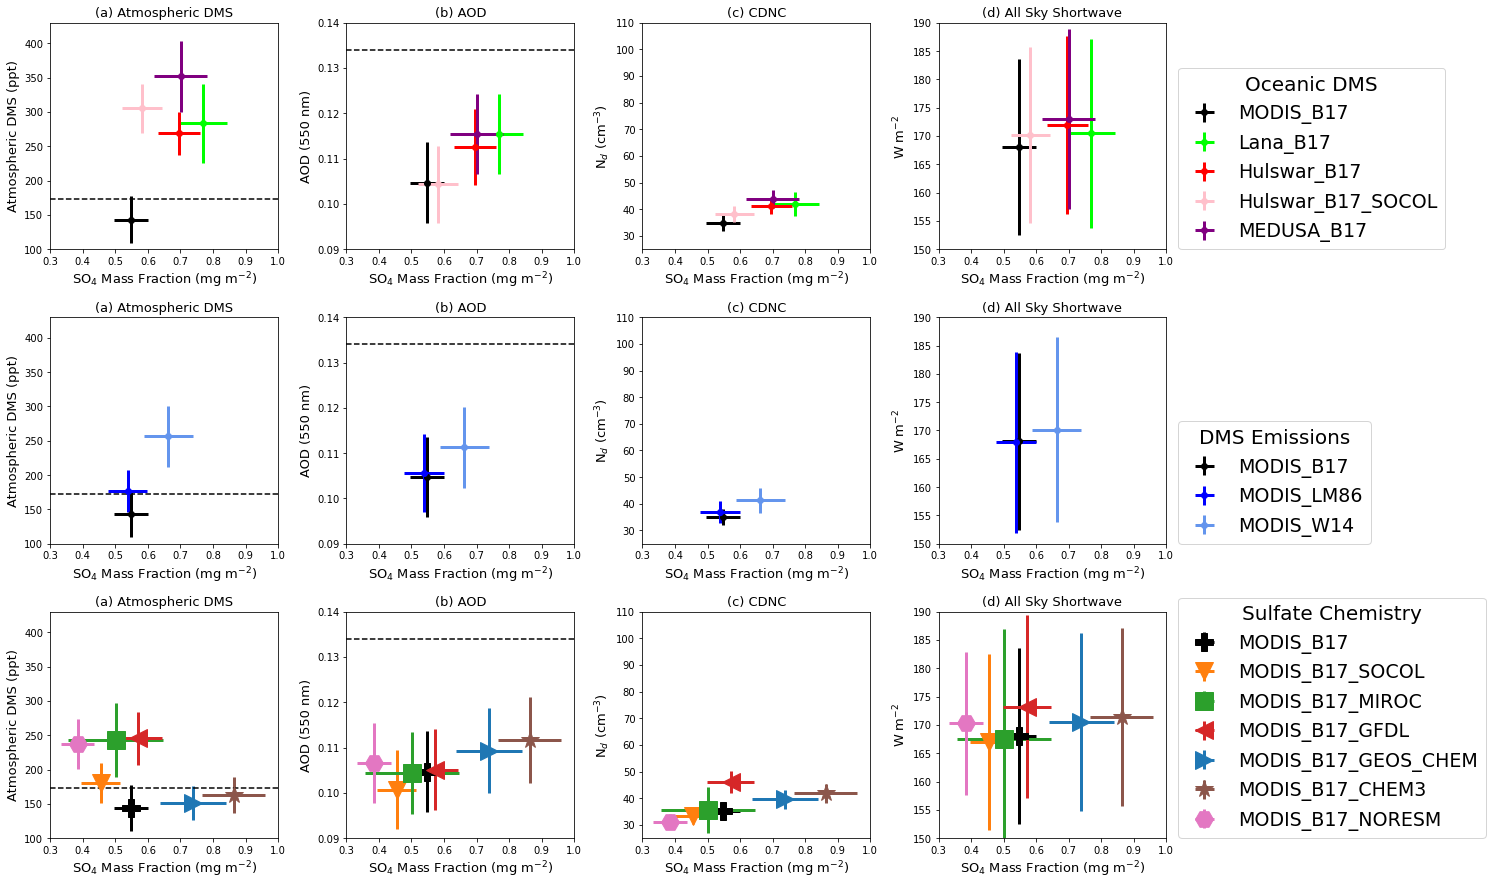

In [8]:
import numpy.ma as ma
labels=['MODIS_B17','Lana_B17','REV3_B17','Hulswar_B17_SOCOL','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labelss=['MODIS_B17','Lana_B17','Hulswar_B17','Hulswar_B17_SOCOL','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
#colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','pink','purple','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
#colourss=['aqua','lightblue','teal','aquamarine','lime','orange','purple','blue','cornflowerblue']
AOD=np.zeros(len(labels)); AOD[:] = np.nan
AOD_std=np.zeros(len(labels)); AOD_std[:] = np.nan

CCN=np.zeros(len(labels)); CCN[:] = np.nan
CCN_std=np.zeros(len(labels)); CCN_std[:] = np.nan

rf=np.zeros(len(labels)); rf[:] = np.nan
rf_std=np.zeros(len(labels)); rf_std[:] = np.nan
sw=np.zeros(len(labels)); sw[:] = np.nan
sw_std=np.zeros(len(labels)); sw_std[:] = np.nan

aod=np.zeros(len(labels)); aod[:] = np.nan
aod_std=np.zeros(len(labels)); aod_std[:] = np.nan

cdnc=np.zeros(len(labels)); cdnc[:] = np.nan
cdnc_std=np.zeros(len(labels)); cdnc_std[:] = np.nan

dms_f=np.zeros(len(labels)); dms_f[:] = np.nan
dms_f_std=np.zeros(len(labels)); dms_f_std[:] = np.nan

dms=np.zeros(len(labels)); dms[:] = np.nan
dms_std=np.zeros(len(labels)); dms_std[:] = np.nan

dms_o=np.zeros(len(labels)); dms_o[:] = np.nan
dms_o_std=np.zeros(len(labels)); dms_o_std[:] = np.nan

so2=np.zeros(len(labels)); so2[:] = np.nan
so2_std=np.zeros(len(labels)); so2_std[:] = np.nan

H2SO4=np.zeros(len(labels)); H2SO4[:] = np.nan
H2SO4_std=np.zeros(len(labels)); H2SO4_std[:] = np.nan

for i in range(0,(len(labels))):
    ####  AOD ###
                   
    aod_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    aod_datame=aod_data.groupby('time.season').mean()[0]
    aod_datast=aod_data.groupby('time.season').std()[0]
    AOD[i]=(aod_datame)
    AOD_std[i]=((aod_datast))
   # AOD_std[i,:]=np.nanstd((aod_data[:]))

    ####  CCN ###
                   
    ccn_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CCN/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    ccn_datam=ccn_data.groupby('time.season').mean()[0]
    ccn_datas=ccn_data.groupby('time.season').std()[0]
    CCN[i]=((ccn_datam))
    CCN_std[i]=((ccn_datas))

    ## SO4
    h2so4_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_load/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    h2so4_datam=h2so4_data.groupby('time.season').mean()[0]
    h2so4_std=h2so4_data.groupby('time.season').std()[0]

    H2SO4[i]=(h2so4_datam)*1e6
    H2SO4_std[i]=(h2so4_std)*1e6
    ####  Radiative Forcing  ###
                   
#     rf_cl=xr.open_dataset(home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/Global/{}.npy'.format(labels[i]))
#     #if rf_cl.ndim == 1:
#     rf[i]=np.nanmean(rf_cl[:]) 
#     rf_std[i]=np.nanstd(rf_cl[:]) 
                          
    sw_cl=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/SW/All_Sky/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    sw_clm=sw_cl.groupby('time.season').mean()[0]
    sw_clstd=sw_cl.groupby('time.season').std()[0]
    #if rf_cl.ndim == 1:
    sw[i]=(sw_clm) 
    sw_std[i]=(sw_clstd) 

#     else:
#         rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
#         rf_std[i]=np.nanstd(rf_cl[:,[11,0,1]]) 
    ####  CDNC  ###

    cdnc_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    cdnc_datam=cdnc_data.groupby('time.season').mean()[0]
    cdnc_datastd=cdnc_data.groupby('time.season').std()[0]
    cdnc[i]=(cdnc_datam) 
    cdnc_std[i]=(cdnc_datastd) 

    ####  DMS  ###
    dmsy=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    if labels[i] == 'MODIS_B17':
        dmsy.sel(time=(dmsy['month'].isin([1, 2, 12]))) 
        dmsym=dmsy.mean('time')
        dmsystd=dmsy.std('time')
    else:
        dmsym=dmsy.groupby('time.season').mean()[0]
        dmsystd=dmsy.groupby('time.season').std()[0] 
    dms[i]=(dmsym)*dms_ppt
    dms_std[i]=(dmsystd)*dms_ppt

fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

for i in range(0,4):
    axes[i].set_xlim(0.3,1)
    axes2[i].set_xlim(0.3,1)
    axes3[i].set_xlim(0.3,1)

    axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','s','<','>','^','o','^','o','P','v','s','<','>','*','H']

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
      #  axes[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        axes[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
        
    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])

          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
            

     #   print(formatu[i])
       # axes3[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt=formatu[i], markersize=18,color=colourss[i])

# axes[0].set_ylim(3,14)
# axes[1].set_ylim(110,430)
# #axes[2].set_xlim(10,120)
# axes[2].set_ylim(25,60)
# axes[3].set_ylim(380,420)

# axes2[0].set_ylim(3,14)
# axes2[1].set_ylim(110,430)
# #axes2[2].set_xlim(10,120)
# axes2[3-1].set_ylim(25,60)
# axes2[4-1].set_ylim(380,420)

#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
for n in range(0,3):
    ax[n][0].set_title('(a) Atmospheric DMS',fontsize=13)
    ax[n][1].set_title('(b) AOD',fontsize=13)
    ax[n][2].set_title('(c) CDNC',fontsize=13)
    ax[n][3].set_title('(d) All Sky Shortwave',fontsize=13)
    ax[n][0].set_ylim(100,430)
    ax[n][1].set_ylim(0.09,0.14)
    ax[n][2].set_ylim(25,110)
    ax[n][3].set_ylim(150,190)
    ax[n][0].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('W m$^{-2}$',fontsize=13)
    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


labely=np.array(labels)

# for i in range(0,len(labels)):
#     if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
#         axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#     else:
#         if i > np.where(labely == 'MODIS_W14')[0][0]:
#             axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#         else:
#             axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
    

#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
# axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)

legend1 = axes[3].legend(labelss[:5], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend2 = axes2[3].legend(labelss[5:8], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend3 = axes3[3].legend(labelss[8:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend1.set_title('Oceanic DMS', prop={'size': 20})
legend2.set_title('DMS Emissions', prop={'size': 20})
legend3.set_title('Sulfate Chemistry', prop={'size': 20})



aod_so=np.nanmean(modis_areaweight[[11,0,1]])
axes[1].axhline(y=aod_so, color='black', linestyle='--')
axes2[1].axhline(y=aod_so, color='black', linestyle='--')
axes3[1].axhline(y=aod_so, color='black', linestyle='--')

dms_clim=np.nanmean(DMS_Climatology[[11,0,1]])
axes[0].axhline(y=dms_clim, color='black', linestyle='--')
axes2[0].axhline(y=dms_clim, color='black', linestyle='--')
axes3[0].axhline(y=dms_clim, color='black', linestyle='--')

cdnc_so=np.nanmean(GROS_AREAWEIGHT_MEAN[[11,0,1]])
axes[2].axhline(y=cdnc_so, color='black', linestyle='--')
axes2[2].axhline(y=cdnc_so, color='black', linestyle='--')
axes3[2].axhline(y=cdnc_so, color='black', linestyle='--')

#cd_OBS = cdnc_all_months_mean.sel(lat=slice(-61, -40))
cd_OBS = cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([1, 2, 12])))
cd_Mean=cd_OBS.mean()
axes[2].axhline(y=cd_Mean, color='black', linestyle='-.')
axes2[2].axhline(y=cd_Mean, color='black', linestyle='-.')
axes3[2].axhline(y=cd_Mean, color='black', linestyle='-.')

SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
SW_OBS = SW_OBS.sel(lat=slice(-61, -40))
SW_OBS = SW_OBS.sel(time=(SW_OBS['time'].dt.month.isin([1, 2, 12])))
SW_Mean=areaweight(SW_OBS,modis_lat[29:50]).mean()
axes[3].axhline(y=SW_Mean, color='black', linestyle='--')
axes2[3].axhline(y=SW_Mean, color='black', linestyle='--')
axes3[3].axhline(y=SW_Mean, color='black', linestyle='--')

# Move the legend to the outside (right side) of the subplots
#legend.set_bbox_to_anchor((1.05, 0.5))

# legend_bbox = legend.get_bbox_to_anchor().transformed(fig.transFigure)
# legend.set_bbox_to_anchor(legend_bbox, bbox_transform=fig.transFigure)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Southern_Ocean_Physical_vs_Chemical.png",dpi=300,bbox_inches = 'tight')


<Figure size 1440x720 with 0 Axes>

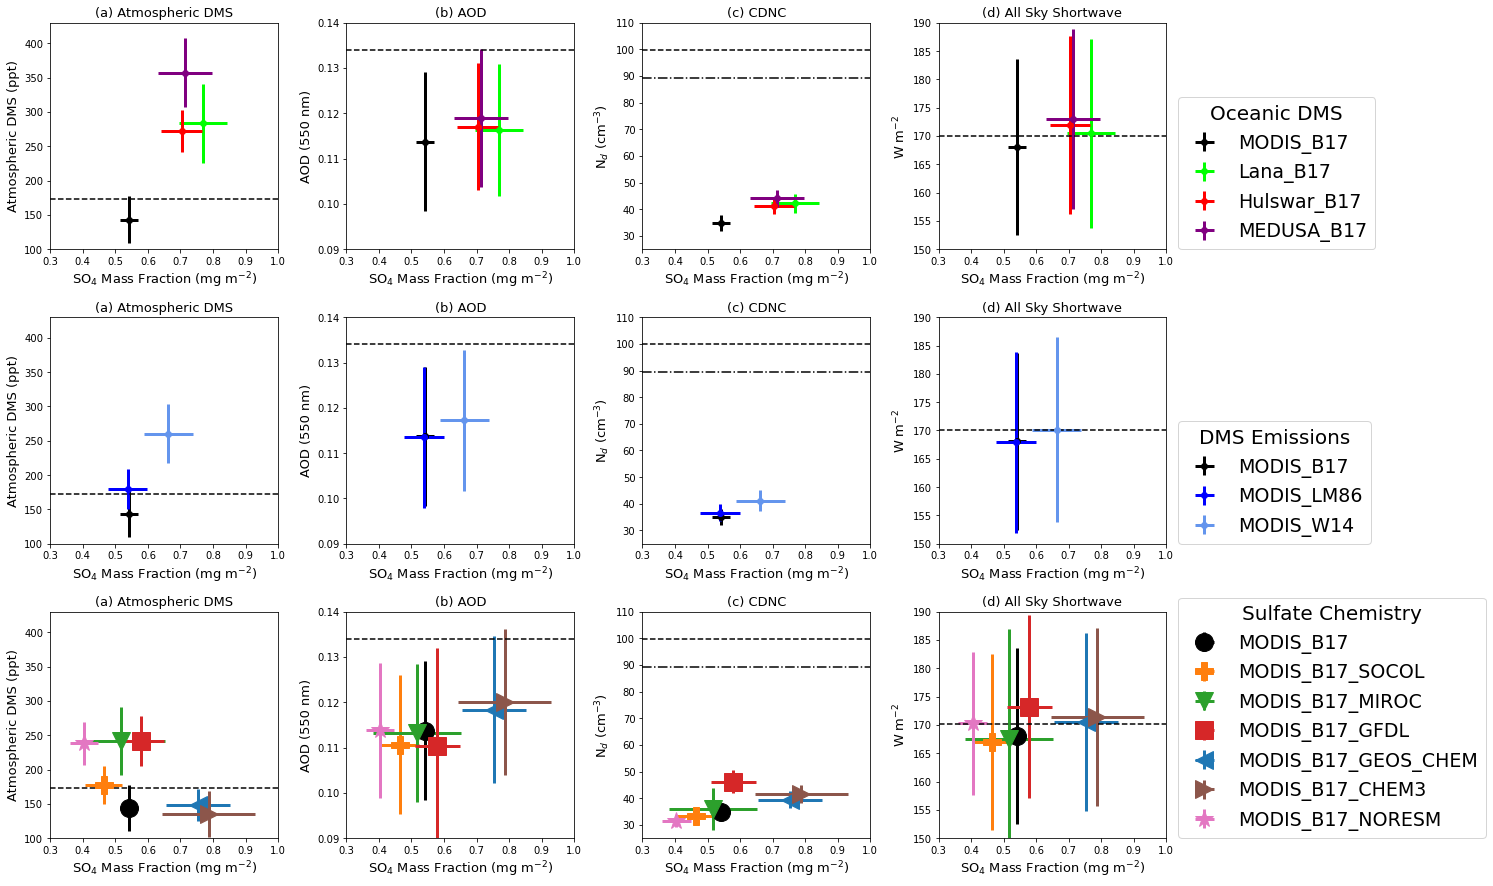

In [232]:
import numpy.ma as ma
labels=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labelss=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
#colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','purple','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

#colourss=['aqua','lightblue','teal','aquamarine','lime','orange','purple','blue','cornflowerblue']
AOD=np.zeros(len(labels)); AOD[:] = np.nan
AOD_std=np.zeros(len(labels)); AOD_std[:] = np.nan

CCN=np.zeros(len(labels)); CCN[:] = np.nan
CCN_std=np.zeros(len(labels)); CCN_std[:] = np.nan

rf=np.zeros(len(labels)); rf[:] = np.nan
rf_std=np.zeros(len(labels)); rf_std[:] = np.nan
sw=np.zeros(len(labels)); sw[:] = np.nan
sw_std=np.zeros(len(labels)); sw_std[:] = np.nan

aod=np.zeros(len(labels)); aod[:] = np.nan
aod_std=np.zeros(len(labels)); aod_std[:] = np.nan

cdnc=np.zeros(len(labels)); cdnc[:] = np.nan
cdnc_std=np.zeros(len(labels)); cdnc_std[:] = np.nan

dms_f=np.zeros(len(labels)); dms_f[:] = np.nan
dms_f_std=np.zeros(len(labels)); dms_f_std[:] = np.nan

dms=np.zeros(len(labels)); dms[:] = np.nan
dms_std=np.zeros(len(labels)); dms_std[:] = np.nan

dms_o=np.zeros(len(labels)); dms_o[:] = np.nan
dms_o_std=np.zeros(len(labels)); dms_o_std[:] = np.nan

so2=np.zeros(len(labels)); so2[:] = np.nan
so2_std=np.zeros(len(labels)); so2_std[:] = np.nan

seasons = ['DJF', 'MAM', 'JJA', 'SON']
H2SO4=np.zeros(len(labels)); H2SO4[:] = np.nan
H2SO4_std=np.zeros(len(labels)); H2SO4_std[:] = np.nan

fig = plt.figure(figsize=(20,10), edgecolor='w')
plt.subplots_adjust(hspace=0.4, wspace=0.3)#x=np.arange(40,70,5)

for i in range(0,(len(labels))):
    ####  AOD ###
                   
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/{}.npy'.format(labels[i]))
    AOD[i]=np.nanmean((aod_data[:]))
    AOD_std[i]=np.nanstd((aod_data[:]))

    ####  CCN ###
                   
#     ccn_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CCN/{}.npy'.format(labels[i]))
#     CCN[i]=np.nanmean((ccn_data[:]))
#     CCN_std[i]=np.nanstd((ccn_data[:]))
#     ####  DMS FLUX ###
                   
#     dms_flux_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/DMS_EMISSIONS/{}.npy'.format(labels[i])) * to_umol_day
#     #if dms_flux_data.ndim == 1:
#     dms_f[i]=np.nanmean((dms_flux_data[:])) 
#     dms_f_std[i]=np.nanstd((dms_flux_data[:])) 
    #else:
    ####  OCEANIC DMS ###
                   
#     oceanic_dms_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/OCEANIC_DMS/Global/{}.npy'.format(labels[i])) 
#     if oceanic_dms_data.ndim == 2:
#         dms_o[i] = np.nanmean(oceanic_dms_data[:,[11,0,1]])
#         dms_o_std[i] = np.nanstd(oceanic_dms_data[:,[11,0,1]])
#     else:
#         dms_o[i]=np.nanmean((oceanic_dms_data[[11,0,1]]))
#         dms_o_std[i] = np.nanstd(oceanic_dms_data[[11,0,1]])
    ####  SO4 ###
                   
    h2so4_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_load/{}.npy'.format(labels[i]))
    H2SO4[i]=np.nanmean(h2so4_data[:])*1e6
    H2SO4_std[i]=np.nanstd(h2so4_data[:])*1e6
    ####  Radiative Forcing  ###
                   
#     rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
#     #if rf_cl.ndim == 1:
#     rf[i]=np.nanmean(rf_cl[:]) 
#     rf_std[i]=np.nanstd(rf_cl[:]) 
    
    sw_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/SW/All_Sky/{}.npy'.format(labels[i]))
    #if rf_cl.ndim == 1:
    sw[i]=np.nanmean(sw_cl[:]) 
    sw_std[i]=np.nanstd(sw_cl[:]) 

#     else:
#         rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
#         rf_std[i]=np.nanstd(rf_cl[:,[11,0,1]]) 
    ####  CDNC  ###

    cdnc_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/{}.npy'.format(labels[i]))
    cdnc[i]=np.nanmean(cdnc_data[:]) 
    cdnc_std[i]=np.nanstd(cdnc_data[:]) 
    ####  ATMOS DMS ###
                   
    dmsy=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/{}.npy'.format(labels[i]))
    dms[i]=np.nanmean(dmsy[:])*dms_ppt
    dms_std[i]=np.nanstd(dmsy[:])*dms_ppt
    ####  SO2 ###
                   
#     SO2=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/{}.npy'.format(labels[i]))
#     so2[i]=np.nanmean(SO2[:])*dms_ppt
#     so2_std[i]=np.nanstd(SO2[:])*dms_ppt
                   
# dms_flux_diff=[ccn_djf[0],ccn_djf[3],ccn_djf[6]]
# ocean_diff=[ccn_djf[0],ccn_djf[1],ccn_djf[5],ccn_djf[8]]
# chem_diff=[ccn_djf[0],ccn_djf[2],ccn_djf[4],ccn_djf[7]]
# #chem_diff=[H2SO4_djf[0],H2SO4_djf[4]]

# dms_flux_diff_std=[ccn_djf_std[0],ccn_djf_std[3],ccn_djf_std[6]]
# ocean_diff_std=[ccn_djf_std[0],ccn_djf_std[1],ccn_djf_std[5],ccn_djf_std[8]]
# chem_diff_std=[ccn_djf_std[0],ccn_djf_std[2],ccn_djf_std[4],ccn_djf_std[7]]

# colours_flux=['aqua','blue','cornflowerblue']
# colours_ocean=['aqua','lime','orange','purple']
# colours_chem=['aqua','teal','lightblue','aquamarine']

#colourss=['aqua','lime','teal','blue','lightblue','orange','cornflowerblue','aquamarine','purple']

fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

for i in range(0,4):
    axes[i].set_xlim(0.3,1)
    axes2[i].set_xlim(0.3,1)
    axes3[i].set_xlim(0.3,1)

    axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','s','<','>','^','o','^','o','P','v','s','<','>','*','H']

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
      #  axes[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        axes[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])

          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
            

     #   print(formatu[i])
       # axes3[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt=formatu[i], markersize=18,color=colourss[i])

# axes[0].set_ylim(3,14)
# axes[1].set_ylim(110,430)
# #axes[2].set_xlim(10,120)
# axes[2].set_ylim(25,60)
# axes[3].set_ylim(380,420)

# axes2[0].set_ylim(3,14)
# axes2[1].set_ylim(110,430)
# #axes2[2].set_xlim(10,120)
# axes2[3-1].set_ylim(25,60)
# axes2[4-1].set_ylim(380,420)

#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
for n in range(0,3):
    ax[n][0].set_title('(a) Atmospheric DMS',fontsize=13)
    ax[n][1].set_title('(b) AOD',fontsize=13)
    ax[n][2].set_title('(c) CDNC',fontsize=13)
    ax[n][3].set_title('(d) All Sky Shortwave',fontsize=13)
    ax[n][0].set_ylim(100,430)
    ax[n][1].set_ylim(0.09,0.14)
    ax[n][2].set_ylim(25,110)
    ax[n][3].set_ylim(150,190)
    ax[n][0].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('W m$^{-2}$',fontsize=13)
    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


labely=np.array(labels)

# for i in range(0,len(labels)):
#     if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
#         axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#     else:
#         if i > np.where(labely == 'MODIS_W14')[0][0]:
#             axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#         else:
#             axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
    

#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
# axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)

legend1 = axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend2 = axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend3 = axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend1.set_title('Oceanic DMS', prop={'size': 20})
legend2.set_title('DMS Emissions', prop={'size': 20})
legend3.set_title('Sulfate Chemistry', prop={'size': 20})



aod_so=np.nanmean(modis_areaweight[[11,0,1]])
axes[1].axhline(y=aod_so, color='black', linestyle='--')
axes2[1].axhline(y=aod_so, color='black', linestyle='--')
axes3[1].axhline(y=aod_so, color='black', linestyle='--')

dms_clim=np.nanmean(DMS_Climatology[[11,0,1]])
axes[0].axhline(y=dms_clim, color='black', linestyle='--')
axes2[0].axhline(y=dms_clim, color='black', linestyle='--')
axes3[0].axhline(y=dms_clim, color='black', linestyle='--')

cdnc_so=np.nanmean(GROS_AREAWEIGHT_MEAN[[11,0,1]])
axes[2].axhline(y=cdnc_so, color='black', linestyle='--')
axes2[2].axhline(y=cdnc_so, color='black', linestyle='--')
axes3[2].axhline(y=cdnc_so, color='black', linestyle='--')

cd_OBS = cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([1, 2, 12])))
cd_Mean=cd_OBS.mean()
#cd_Mean=areaweight(cd_OBS,modis_lat[29:50]).mean()
axes[2].axhline(y=cd_Mean, color='black', linestyle='-.')
axes2[2].axhline(y=cd_Mean, color='black', linestyle='-.')
axes3[2].axhline(y=cd_Mean, color='black', linestyle='-.')

SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
SW_OBS = SW_OBS.sel(lat=slice(-61, -40))
SW_OBS = SW_OBS.sel(time=(SW_OBS['time'].dt.month.isin([1, 2, 12])))
SW_Mean=areaweight(SW_OBS,modis_lat[29:50]).mean()
axes[3].axhline(y=SW_Mean, color='black', linestyle='--')
axes2[3].axhline(y=SW_Mean, color='black', linestyle='--')
axes3[3].axhline(y=SW_Mean, color='black', linestyle='--')

# Move the legend to the outside (right side) of the subplots
#legend.set_bbox_to_anchor((1.05, 0.5))

# legend_bbox = legend.get_bbox_to_anchor().transformed(fig.transFigure)
# legend.set_bbox_to_anchor(legend_bbox, bbox_transform=fig.transFigure)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Southern_Ocean_Physical_vs_Chemical.png",dpi=300,bbox_inches = 'tight')


In [138]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(15,15), edgecolor='w')
fig.subplots_adjust(hspace=-0.2, wspace=0.25)
ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion.npy')        
#num_con=np.sum(total_dndlr[:],axis=(2))
num_concentration=np.nanmean(total_dndlr[:,:],axis=(3))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) Ai','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines

# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']

for i in range(0,5):
    data=num_concentration[:,:,i]
  #  ax1.append(fig.add_subplot(2,2,i+1))
    ax1=axes[i]#(fig.add_subplot(2,3,i+1))
    #data=np.nanmean(dataset[i],axis=(2,3))
    data=data.transpose(1,0)
    for p in range(0,len(data[0])):
        ax1.plot(data[:,p],heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)
    ax1.set_title('{}'.format(modes[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)
    ax1.set_xlabel('dN/dlogr (cm$^{-3}$)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)

#     if i == 3:
#         x_ticks=np.arange(0,0.0008,0.0002)
#         ax1.set_xticks(x_ticks)
#     if i == 2:
#         x_ticks=np.arange(0,0.0175,0.005)
#         ax1.set_xticks(x_ticks)
#     ax1.set_yticks(np.arange(0,1,0.01))

#     ax1.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 3:
        ax1.legend(fontsize=14)
#plt.show()

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc.png",dpi=200,bbox_inches = 'tight')
#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


NameError: name 'MODIS_B17_CHEM_file' is not defined

<Figure size 1440x720 with 0 Axes>

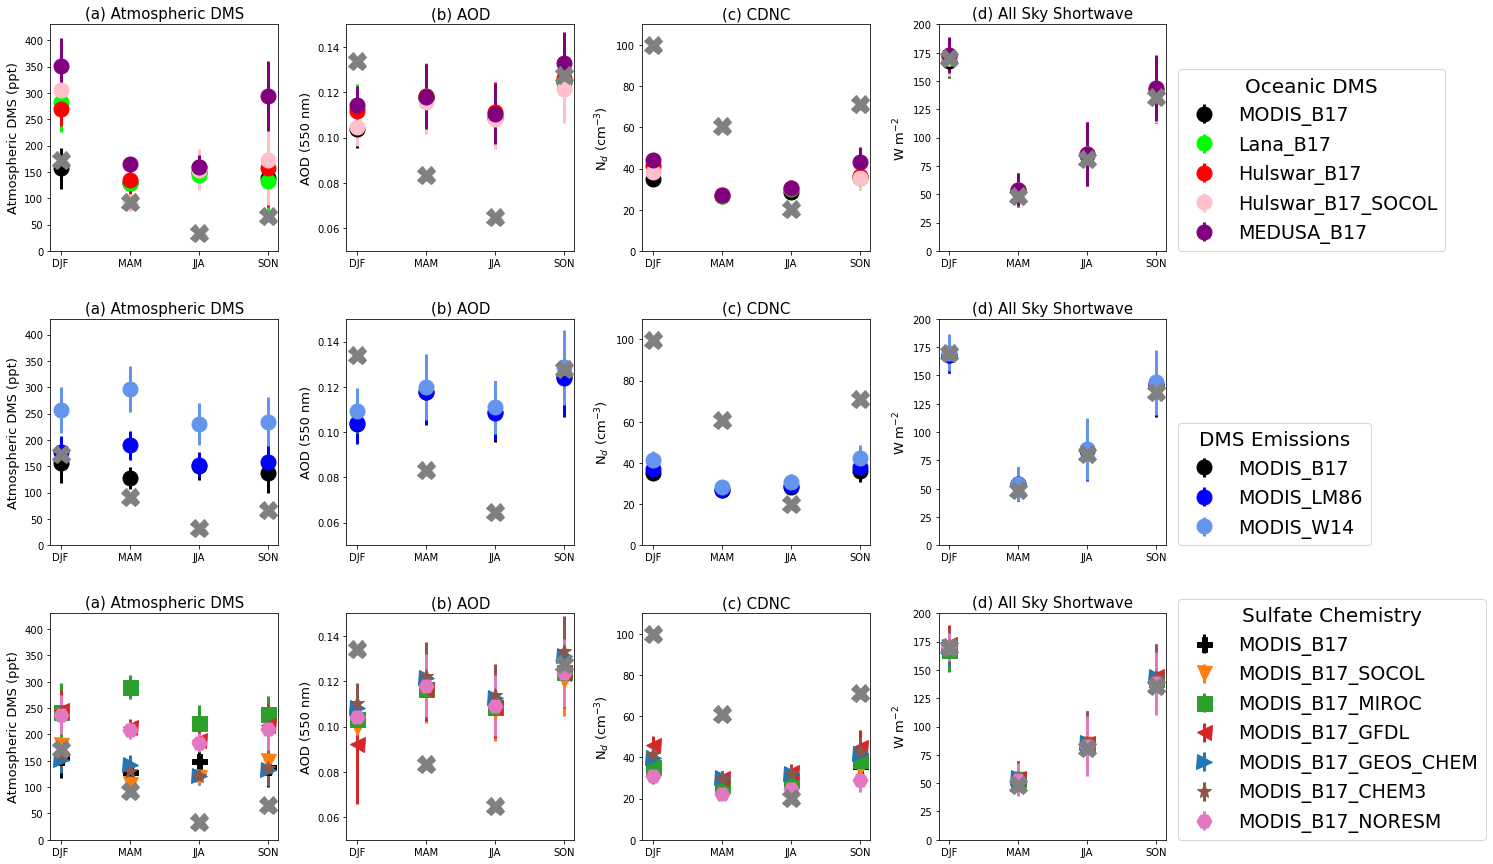

In [252]:
import numpy.ma as ma

# REPLACE WITH SEASONS??


labels=['MODIS_B17','Lana_B17','REV3_B17','Hulswar_B17_SOCOL','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labelss=['MODIS_B17','Lana_B17','Hulswar_B17','Hulswar_B17_SOCOL','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
#colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','pink','purple','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

#colourss=['aqua','lightblue','teal','aquamarine','lime','orange','purple','blue','cornflowerblue']
num=4
AOD=np.zeros((len(labels),num)); AOD[:] = np.nan
AOD_std=np.zeros((len(labels),num)); AOD_std[:] = np.nan

CCN=np.zeros((len(labels),num)); CCN[:] = np.nan
CCN_std=np.zeros((len(labels),num)); CCN_std[:] = np.nan

rf=np.zeros((len(labels),num)); rf[:] = np.nan
rf_std=np.zeros((len(labels),num)); rf_std[:] = np.nan
sw=np.zeros((len(labels),num)); sw[:] = np.nan
sw_std=np.zeros((len(labels),num)); sw_std[:] = np.nan

aod=np.zeros((len(labels),num)); aod[:] = np.nan
aod_std=np.zeros((len(labels),num)); aod_std[:] = np.nan

cdnc=np.zeros((len(labels),num)); cdnc[:] = np.nan
cdnc_std=np.zeros((len(labels),num)); cdnc_std[:] = np.nan

dms_f=np.zeros((len(labels),num)); dms_f[:] = np.nan
dms_f_std=np.zeros((len(labels),num)); dms_f_std[:] = np.nan

dms=np.zeros((len(labels),num)); dms[:] = np.nan
dms_std=np.zeros((len(labels),num)); dms_std[:] = np.nan

dms_o=np.zeros((len(labels),num)); dms_o[:] = np.nan
dms_o_std=np.zeros((len(labels),num)); dms_o_std[:] = np.nan

so2=np.zeros((len(labels),num)); so2[:] = np.nan
so2_std=np.zeros((len(labels),num)); so2_std[:] = np.nan

seasons = ['DJF', 'MAM', 'JJA', 'SON']
H2SO4=np.zeros((len(labels),num)); H2SO4[:] = np.nan
H2SO4_std=np.zeros((len(labels),num)); H2SO4_std[:] = np.nan

fig = plt.figure(figsize=(20,10), edgecolor='w')
plt.subplots_adjust(hspace=0.4, wspace=0.3)#x=np.arange(40,70,5)

for i in range(0,(len(labels))):
    ####  AOD ###
                   
    aod_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/Annual/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    aod_datame=aod_data.groupby('time.season').mean()
    aod_datast=aod_data.groupby('time.season').std()
    AOD[i,:]=((aod_datame[:]))
    AOD_std[i,:]=((aod_datast[:]))

   # AOD_std[i,:]=np.nanstd((aod_data[:]))

    ####  CCN ###
                   
    ccn_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CCN/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    ccn_datam=ccn_data.groupby('time.season').mean()
    ccn_datas=ccn_data.groupby('time.season').std()
    CCN[i]=((ccn_datam[:]))
    CCN_std[i]=((ccn_datas[:]))

    ## SO4
    h2so4_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_load/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    h2so4_datam=h2so4_data.groupby('time.season').mean()
    h2so4_std=h2so4_data.groupby('time.season').std()

    H2SO4[i]=(h2so4_datam[:])*1e6
    H2SO4_std[i]=(h2so4_std[:])*1e6
    ####  Radiative Forcing  ###
                   
#     rf_cl=xr.open_dataset(home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/Global/{}.npy'.format(labels[i]))
#     #if rf_cl.ndim == 1:
#     rf[i]=np.nanmean(rf_cl[:]) 
#     rf_std[i]=np.nanstd(rf_cl[:]) 
                          
    sw_cl=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/SW/All_Sky/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    sw_clm=sw_cl.groupby('time.season').mean()
    sw_clstd=sw_cl.groupby('time.season').std()
    #if rf_cl.ndim == 1:
    sw[i,:]=(sw_clm[:]) 
    sw_std[i,:]=(sw_clstd[:]) 

#     else:
#         rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
#         rf_std[i]=np.nanstd(rf_cl[:,[11,0,1]]) 
    ####  CDNC  ###

    cdnc_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    cdnc_datam=cdnc_data.groupby('time.season').mean()
    cdnc_datastd=cdnc_data.groupby('time.season').std()
    cdnc[i]=(cdnc_datam[:]) 
    cdnc_std[i]=(cdnc_datastd[:]) 
    ####  ATMOS DMS ###
                   
    dmsy=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    if labels[i] == 'MODIS_B17':
        dmsy = xr.concat([
        dmsy.sel(time=(dmsy['month'].isin([1, 2, 12]))),dmsy.sel(time=(dmsy['month'].isin([3, 4, 5]))),
        dmsy.sel(time=(dmsy['month'].isin([6, 7, 8]))),dmsy.sel(time=(dmsy['month'].isin([9, 10, 11]))),],
        dim='season')
        dmsym=dmsy.mean('time')
        dmsystd=dmsy.std('time')

    else:
        dmsym=dmsy.groupby('time.season').mean()
        dmsystd=dmsy.groupby('time.season').std()   
    dms[i]=(dmsym[:])*dms_ppt
    dms_std[i]=(dmsystd[:])*dms_ppt
    ####  SO2 ###
                   
    SO2=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    SO2m=SO2.groupby('time.season').mean()
    SO2std=SO2.groupby('time.season').std()
    so2[i]=(SO2m[:])*dms_ppt
    so2_std[i]=(SO2std[:])*dms_ppt
cdnc_sea=[99.79950344833912,60.86523755707689,20.196563822644837,71.23876040710185]
MOD_SEA=[0.13406078257904572,0.08335161445745592,0.06492186650126804,0.12781397944279613]
DMS_SEA=[172.95255010555556,92.29818011766082,33.26744487166666,66.62744963166666]
SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
SW_OBS = SW_OBS.sel(lat=slice(-61, -40))
#SW_OBS = SW_OBS.sel(time=(SW_OBS['time'].dt.month.isin([1, 2, 12])))
SW_Mean=areaweight(SW_OBS,modis_lat[29:50]).groupby('time.season').mean()

cd_OBS = cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([1, 2, 12])))
cd_Mean=cd_OBS.mean()

#cd_OBS = cd_OBS.sel(month=(cd_OBS['month'].isin([1, 2, 12])))
cdnc_obs = xr.concat([
cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([1, 2, 12]))),cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([3, 4, 5]))),
cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([6, 7, 8]))),cdnc_all_southern_ocean.sel(month=(cdnc_all_southern_ocean['month'].isin([9, 10, 11]))),],
dim='season').mean('month')
cd_Mean=cdnc_obs


fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)


plt.subplots_adjust(wspace=0.3, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','s','<','>','^','o','^','o','P','v','s','<','>','*','H']

ma=15
for i, label in enumerate(labels):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
        axes[0].errorbar(seasons,dms[i, :],yerr=dms_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
        axes[2].errorbar(seasons,cdnc[i],yerr=cdnc_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
        axes[3].errorbar(seasons,sw[i],yerr=sw_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
        axes[1].errorbar(seasons,AOD[i],yerr=AOD_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])   

    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(seasons,dms[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])
            axes3[2].errorbar(seasons,cdnc[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])
            axes3[3].errorbar(seasons,sw[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])
            axes3[1].errorbar(seasons,AOD[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])

          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(seasons,dms[i],yerr=dms_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
            axes2[2].errorbar(seasons,cdnc[i],yerr=cdnc_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
            axes2[3].errorbar(seasons,sw[i],yerr=sw_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
            axes2[1].errorbar(seasons,AOD[i],yerr=AOD_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])



#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
for n in range(0,3):
    ax[n][0].set_title('(a) Atmospheric DMS',fontsize=15)
    ax[n][1].set_title('(b) AOD',fontsize=15)
    ax[n][2].set_title('(c) CDNC',fontsize=15)
    ax[n][3].set_title('(d) All Sky Shortwave',fontsize=15)
    ax[n][0].set_ylim(0,430)
    ax[n][1].set_ylim(0.05,0.15)
    ax[n][2].set_ylim(0,110)
    ax[n][3].set_ylim(0,200)
    ax[n][0].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('W m$^{-2}$',fontsize=13)
    ax[n][2].errorbar(seasons,cdnc_sea, fmt='X',markersize=18,color='grey')
    ax[n][1].errorbar(seasons,MOD_SEA, fmt='X',markersize=18,color='grey')
    ax[n][3].errorbar(seasons,SW_Mean, fmt='X',markersize=18,color='grey')
    ax[n][0].errorbar(seasons,DMS_SEA, fmt='X',markersize=18,color='grey')

    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


labely=np.array(labels)

# for i in range(0,len(labels)):
#     if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
#         legend1=axes[0].errorbar(0,-33,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#     else:
#         if i > np.where(labely == 'MODIS_W14')[0][0]:
#             legend2=axes3[0].errorbar(0,-33,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#         else:
#             legend3=axes2[0].errorbar(0,-33,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
            
legend1 = axes[3].legend(labelss[:5], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend2 = axes2[3].legend(labelss[5:8], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend3 = axes3[3].legend(labelss[8:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend1.set_title('Oceanic DMS', prop={'size': 20})
legend2.set_title('DMS Emissions', prop={'size': 20})
legend3.set_title('Sulfate Chemistry', prop={'size': 20})

#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
# axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Southern_Ocean_Physical_vs_Chemical_SEASON.png",dpi=300,bbox_inches = 'tight')


0
MODIS_B17_SOCOL
MODIS_B17_MIROC
MODIS_B17_GFDL
MODIS_B17_GEOS_CHEM
MODIS_B17_CHEM3
MODIS_B17_NORESM
1
Lana_B17
REV3_B17
MEDUSA_B17
2
MODIS_LM86
Lana_LM86
Hulswar_LM86
MEDUSA_LM86


<ipython-input-268-63cdd3113715>:41: RuntimeWarning: Mean of empty slice
  data_rf=np.nanmean(rfs,axis=(1,2,3,4)); data_rf_std=np.nanstd(np.nanmean(rfs,axis=(2,3,4)),axis=(1))
<ipython-input-268-63cdd3113715>:42: RuntimeWarning: Mean of empty slice
  data_rfcs=np.nanmean(rfcs,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(np.nanmean(rfcs,axis=(2,3,4)),axis=(1))


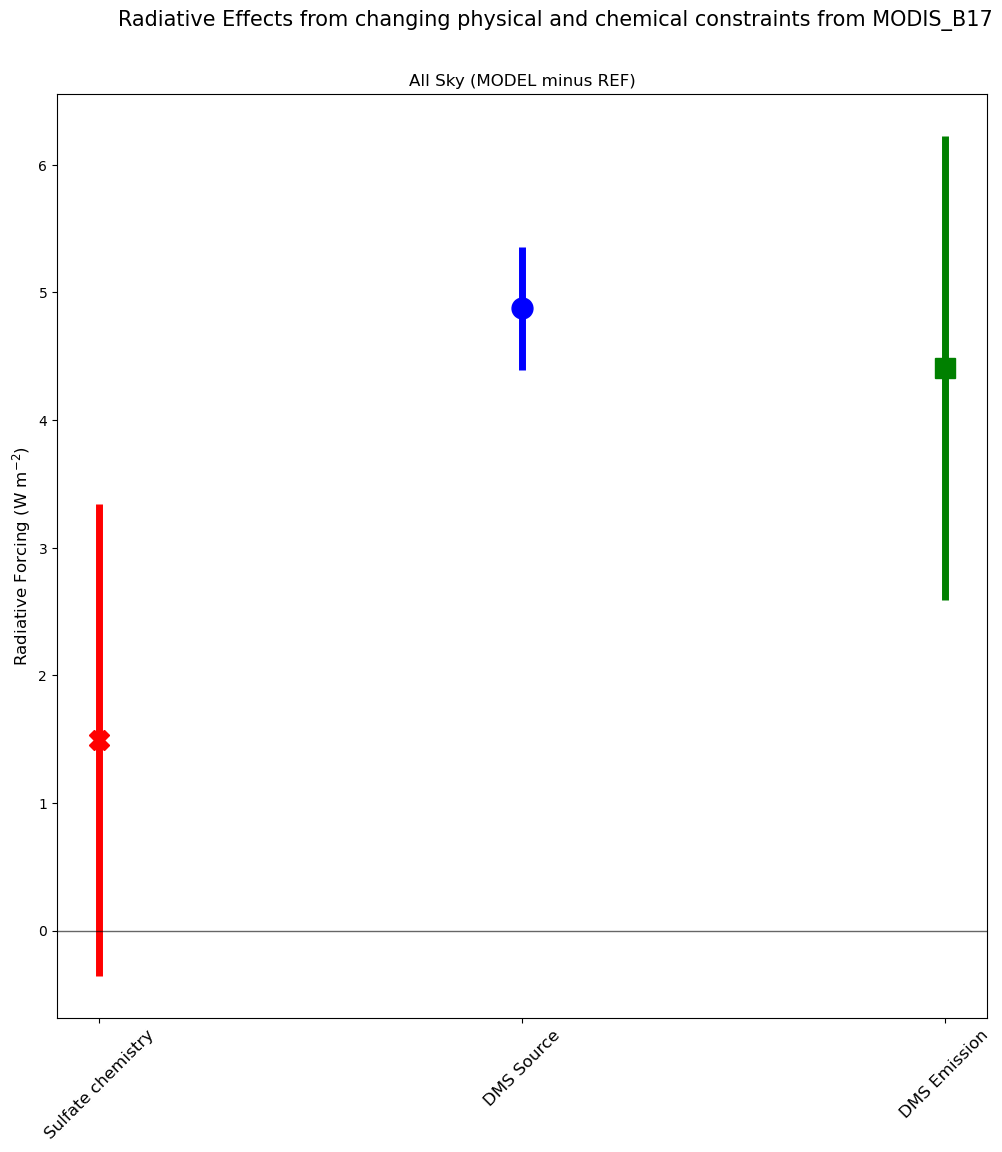

In [268]:
#labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']

rf=np.zeros((len(labels),2,3,31)); rf[:] = np.nan
rf_cs=np.zeros((len(labels),2,3,31)); rf_cs[:] = np.nan
rf_cloud=np.zeros((len(labels),2,3,31)); rf_cloud[:] = np.nan

for i in range(0,(len(labels))):
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
    if rf_cl.ndim == 1:
        rf[i]=np.nanmean(rf_cl[:]) 
    else:
        rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/Clear_Sky/{}.npy'.format(labels[i]))
    if rf_cl.ndim == 1:
        rf_cs[i]=np.nanmean(rf_cl[:]) 
    else:
        rf_cs[i]=np.nanmean(rf_cl[:,[11,0,1]]) 

        
#     rf_csky=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/Clear_Sky/{}.npy'.format(labels[i]))
#     rf_cs[i]=(rf_csky[:,[0,1,11]])
#     rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/Cloudy_Sky/{}.npy'.format(labels[i]))
#     rf_cloud[i]=(rf_cl[:,[0,1,11]])

rfs=np.zeros((3,7,2,3,31)); rfs[:] = np.nan
rfcs=np.zeros((3,7,2,3,31)); rfcs[:] = np.nan
# rfcloud=np.zeros((3,3,2,3,31)); rfcloud[:] = np.nan
c=[1,2,3,4,5,6],[7,8,9],[10,11,12,13]# chem, emission, source
for d,l in enumerate(c):
    print(d)
    for i,n in zip(l,range(0,6)):
        print(labels[i])
    #    print(n)
        rfs[d,n]=rf[i]-rf[0]
        rfcs[d,n]=rf_cs[i]-rf_cs[0]
#         rfcloud[d,n]=rf_cloud[i]-rf_cloud[0]
   # print('---')

#data_rf=np.nanmean(rfs,axis=(1,2,3,4)); data_rf_std=np.nanstd(rfs,axis=(1,2,3,4))
data_rf=np.nanmean(rfs,axis=(1,2,3,4)); data_rf_std=np.nanstd(np.nanmean(rfs,axis=(2,3,4)),axis=(1))
data_rfcs=np.nanmean(rfcs,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(np.nanmean(rfcs,axis=(2,3,4)),axis=(1))

# data_rfcs=np.nanmean(rfcs,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(rfcs,axis=(1,2,3,4))
# data_rfcloud=np.nanmean(rfcloud,axis=(1,2,3,4)); data_rfcloud_std=np.nanstd(rfcloud,axis=(1,2,3,4))
dataset=[data_rf,data_rfcs]
dataset_std=[data_rf_std,data_rfcs_std]

rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
colorss=['red','blue','green']
symbols=['X','ro','s']
titles=['All Sky (MODEL minus REF)','Clear Sky (MODEL minus REF)']

fig = plt.figure(figsize=(12,12), edgecolor='w')
plt.subplots_adjust(hspace=-0.05, wspace=0.4)#x=np.arange(40,70,5)
lines={'linestyle': 'None'}
plt.rc('lines', **lines)
# for a in range(0,2):
a=0
ax1=fig.add_subplot(1,1,a+1)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1,alpha=.6)
for i in range(0,3):
    ax1.plot(rf_label[i],dataset[a][i], symbols[i],markersize=15,color=colorss[i],linestyle='None')#,ecolor=colorss[i])
ax1.errorbar(rf_label,dataset[a],yerr=dataset_std[a], fmt='b',elinewidth=5,ecolor=colorss)#,capsize=5,capthick=5)
ax1.xaxis.set_tick_params(labelsize=12,rotation=45)
ax1.set_ylabel('Radiative Forcing (W m$^{-2}$)',fontsize=12)
ax1.set_title(titles[a])
plt.rcdefaults()
plt.suptitle('Radiative Effects from changing physical and chemical constraints from MODIS_B17',x=0.54,y=0.95,fontsize=15)
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/RF_Processes.png",dpi=100,bbox_inches = 'tight')


<ipython-input-286-56e44b357b4c>:46: RuntimeWarning: Mean of empty slice
  data_rf=np.nanmean(rfs,axis=(1,2,3,4)); data_rf_std=np.nanstd(np.nanmean(rfs,axis=(2,3,4)),axis=(1))
<ipython-input-286-56e44b357b4c>:47: RuntimeWarning: Mean of empty slice
  data_rfcs=np.nanmean(rfcs,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(np.nanmean(rfcs,axis=(2,3,4)),axis=(1))
<ipython-input-286-56e44b357b4c>:49: RuntimeWarning: Mean of empty slice
  data_rf_MEAN=np.nanmean(rf_all,axis=(1,2,3,4)); data_rfall_std=np.nanstd(np.nanmean(rf_all,axis=(2,3,4)),axis=(1))
<ipython-input-286-56e44b357b4c>:50: RuntimeWarning: Mean of empty slice
  upper=np.nanmax(np.nanmean(rf_all,axis=(2,3,4)),axis=1); lower=np.nanmin(np.nanmean(rf_all,axis=(2,3,4)),axis=1)
<ipython-input-286-56e44b357b4c>:54: RuntimeWarning: Mean of empty slice
  data_rfcs_MEAN=np.nanmean(rfcs_all,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(np.nanmean(rfcs_all,axis=(2,3,4)),axis=(1))
<ipython-input-286-56e44b357b4c>:55: RuntimeWarning: Mean of empty sl

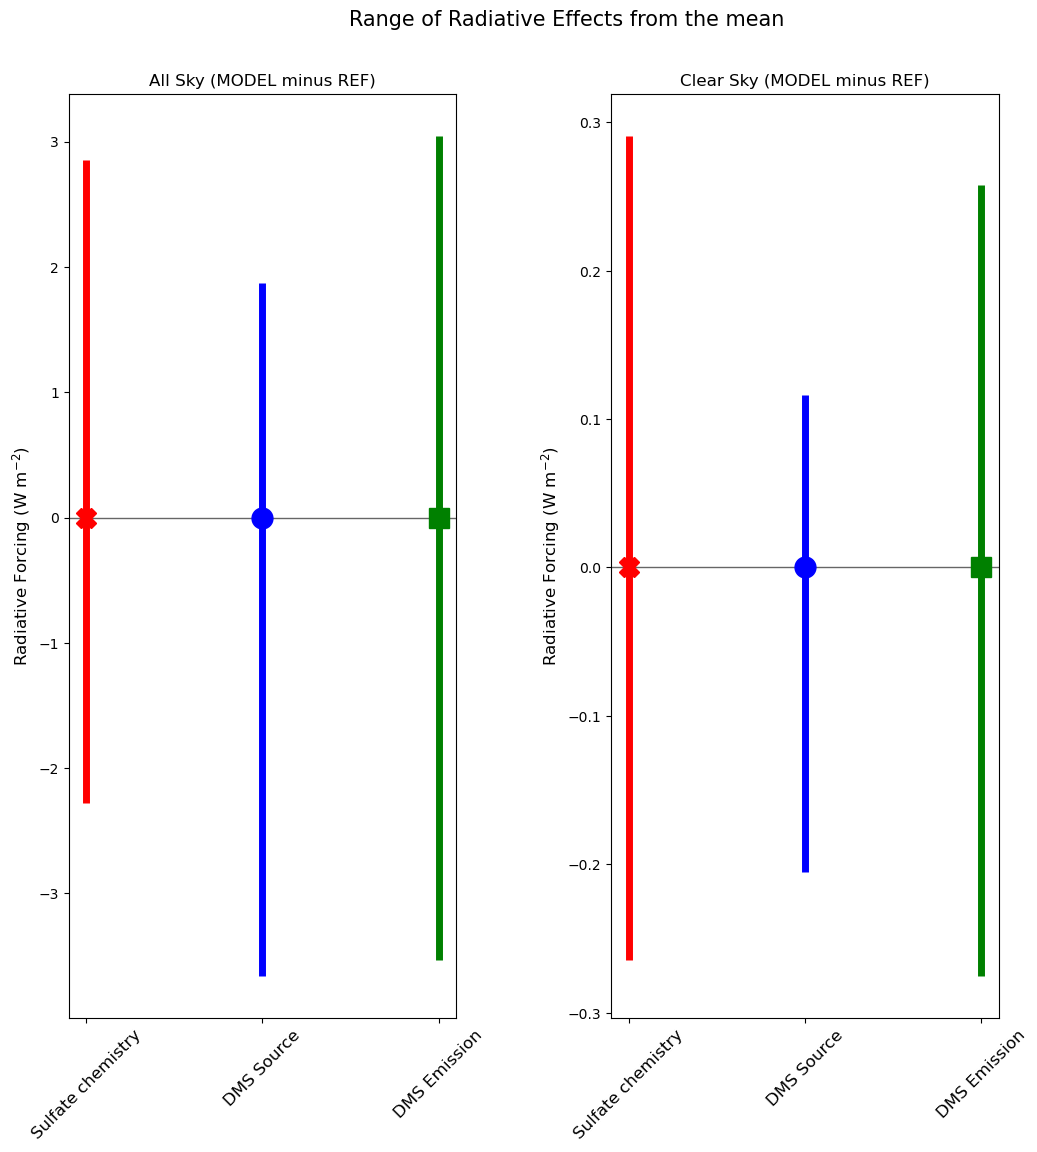

In [286]:
#labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']

rf=np.zeros((len(labels),2,3,31)); rf[:] = np.nan
rf_cs=np.zeros((len(labels),2,3,31)); rf_cs[:] = np.nan
rf_cloud=np.zeros((len(labels),2,3,31)); rf_cloud[:] = np.nan

for i in range(0,(len(labels))):
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
    if rf_cl.ndim == 1:
        rf[i]=np.nanmean(rf_cl[:]) 
    else:
        rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/Clear_Sky/{}.npy'.format(labels[i]))
    if rf_cl.ndim == 1:
        rf_cs[i]=np.nanmean(rf_cl[:]) 
    else:
        rf_cs[i]=np.nanmean(rf_cl[:,[11,0,1]]) 


rfs=np.zeros((3,7,2,3,31)); rfs[:] = np.nan
rfcs=np.zeros((3,7,2,3,31)); rfcs[:] = np.nan
rfcs_all=np.zeros((3,7,2,3,31)); rfcs_all[:] = np.nan

c=[1,2,3,4,5,6],[7,8,9],[10,11,12,13]# chem, emission, source
m=[0,1,2,3,4,5,6],[0,7,8,9],[0,10,11,12,13]# chem, emission, source
for d,l in enumerate(m):
#     print(d)
    for i,n in zip(l,range(0,7)):
     #   print(labels[i])
    #    print(n)
        rf_all[d,n]=rf[i]
        rfcs_all[d,n]=rf_cs[i]

for d,l in enumerate(c):
#     print(d)
    for i,n in zip(l,range(0,6)):
#         print(labels[i])
    #    print(n)
        rfs[d,n]=rf[i]-rf[0]
        rfcs[d,n]=rf_cs[i]-rf_cs[0]
#         rfcloud[d,n]=rf_cloud[i]-rf_cloud[0]
   # print('---')

#data_rf=np.nanmean(rfs,axis=(1,2,3,4)); data_rf_std=np.nanstd(rfs,axis=(1,2,3,4))
data_rf=np.nanmean(rfs,axis=(1,2,3,4)); data_rf_std=np.nanstd(np.nanmean(rfs,axis=(2,3,4)),axis=(1))
data_rfcs=np.nanmean(rfcs,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(np.nanmean(rfcs,axis=(2,3,4)),axis=(1))

data_rf_MEAN=np.nanmean(rf_all,axis=(1,2,3,4)); data_rfall_std=np.nanstd(np.nanmean(rf_all,axis=(2,3,4)),axis=(1))
upper=np.nanmax(np.nanmean(rf_all,axis=(2,3,4)),axis=1); lower=np.nanmin(np.nanmean(rf_all,axis=(2,3,4)),axis=1)
lower_rf=lower-data_rf_MEAN
upper_rf=upper-data_rf_MEAN

data_rfcs_MEAN=np.nanmean(rfcs_all,axis=(1,2,3,4)); data_rfcs_std=np.nanstd(np.nanmean(rfcs_all,axis=(2,3,4)),axis=(1))
uppercs=np.nanmax(np.nanmean(rfcs_all,axis=(2,3,4)),axis=1); lowercs=np.nanmin(np.nanmean(rfcs_all,axis=(2,3,4)),axis=1)
lower_csrf=lowercs-data_rfcs_MEAN
upper_csrf=uppercs-data_rfcs_MEAN


dataset=[data_rf_MEAN,data_rfcs_MEAN]
dataset=[[0,0,0],[0,0,0]]

dataset_upper=[upper_rf,upper_csrf]
#dataset_upper = [array([2.85145621, 1.87370866, 3.04778408]),
 #array([0.29097825, 0.11603755, 0.25788855])]
    
    
dataset_lower=[lower_rf,lower_csrf]
#dataset_lower =  [array([-2.27566216, -3.65602974, -3.52789759]),
# array([-0.2644872 , -0.20545756, -0.27501553])]


rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
colorss=['red','blue','green']
symbols=['X','ro','s']
titles=['All Sky (MODEL minus REF)','Clear Sky (MODEL minus REF)']


fig = plt.figure(figsize=(12,12), edgecolor='w')
plt.subplots_adjust(hspace=-0.05, wspace=0.4)#x=np.arange(40,70,5)
lines={'linestyle': 'None'}
plt.rc('lines', **lines)
for a in range(0,2):
    ax1=fig.add_subplot(1,2,a+1)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1,alpha=.6)

    for i in range(0,3):
        ax1.plot(rf_label[i],dataset[a][i], symbols[i],markersize=15,color=colorss[i],linestyle='None')#,ecolor=colorss[i])
    ax1.errorbar(rf_label,dataset[a],yerr=(-dataset_upper[a],dataset_lower[a]), fmt='b',elinewidth=5,ecolor=colorss)#,capsize=5,capthick=5)
    ax1.xaxis.set_tick_params(labelsize=12,rotation=45)
    ax1.set_ylabel('Radiative Forcing (W m$^{-2}$)',fontsize=12)
    ax1.set_title(titles[a])
plt.rcdefaults()
plt.suptitle('Range of Radiative Effects from the mean',x=0.54,y=0.95,fontsize=15)
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/RF_Processes_Range.png",dpi=100,bbox_inches = 'tight')


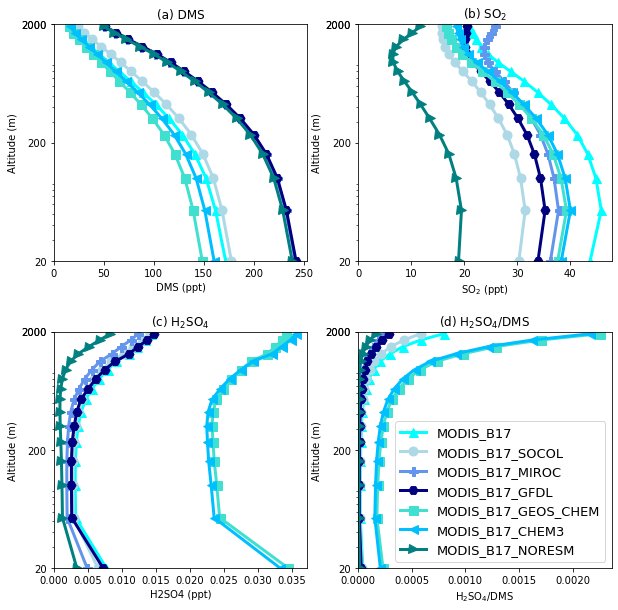

In [10]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']



labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

dms=np.zeros((len(labels),16)); dms[:] = np.nan
so2=np.zeros((len(labels),16)); so2[:] = np.nan
h2so4=np.zeros((len(labels),16)); h2so4[:] = np.nan
cloud=np.zeros((len(labels),16)); cloud[:] = np.nan


for i in range(0,(len(labels))):
    #end
    h2so4o=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_ppt/Height/{}.npy'.format(labels[i])))*h2so4_ppt
    h2so4[i]=np.nanmean(h2so4o[:],axis=0) 
    
    cloudy=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Cloud/Height/{}.npy'.format(labels[i])))
    cloud[i]=np.nanmean(cloudy[:],axis=1) 

    so2o=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/HEIGHT/{}.npy'.format(labels[i])))*so2_ppt
    so2[i]=np.nanmean(so2o[:],axis=1) 

    dmsy=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/Height/{}.npy'.format(labels[i]))
    if dmsy.ndim == 2:
        dms[i]=np.nanmean(dmsy[:],axis=1)*dms_ppt
    else:
        dms[i]=np.nanmean(dmsy[:,:],axis=(1,2))*dms_ppt

# dms_group=np.zeros((3,4,16)); dms_group[:] = np.nan
# so2_group=np.zeros((3,4,16)); so2_group[:] = np.nan
# h2so4_group=np.zeros((3,4,16)); h2so4_group[:] = np.nan

# c=[0,1,2,3],[0,4,5,6],[0,7,8] # chem, emission, source
# for d,l in enumerate(c):
#  #   print(d)
#     for i,n in zip(l,range(0,4)):
#         #print(i)
#       #  print(n)
#         dms_group[d,n]=dms[i]
#         so2_group[d,n]=so2[i]
#         h2so4_group[d,n]=h2so4[i]

   # print('---')
# data_dms=np.nanmean(dms_group,axis=(1,3,4)); data_dms_std=np.nanstd(dms_group,axis=(1,3,4))
# data_so2=np.nanmean(so2_group,axis=(1,3,4)); data_so2_std=np.nanstd(so2_group,axis=(1,3,4))
# data_h2so4=np.nanmean(h2so4_group,axis=(1,3,4)); data_h2so4_std=np.nanstd(h2so4_group,axis=(1,3,4))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) DMS','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) H$_{2}$SO$_{4}$/DMS']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','H$_{2}$SO$_{4}$/DMS']
# colorss=['red','blue','green']
dataset=[dms,so2,h2so4,h2so4/dms]
num_lines = np.shape(colourss)  # Number of lines

fig = plt.figure(figsize=(10,10), edgecolor='w')
plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']

for i in range(0,4):
  #  ax1.append(fig.add_subplot(2,2,i+1))
    ax1=(fig.add_subplot(2,2,i+1))
    #data=np.nanmean(dataset[i],axis=(2,3))
    data=dataset[i].transpose(1,0)
    for p in range(0,len(data[0])):
        ax1.plot(data[:,p],heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)
    ax1.set_title('{}'.format(title[i]))
    ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)')
    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)

#     if i == 3:
#         x_ticks=np.arange(0,0.0008,0.0002)
#         ax1.set_xticks(x_ticks)
#     if i == 2:
#         x_ticks=np.arange(0,0.0175,0.005)
#         ax1.set_xticks(x_ticks)
#     ax1.set_yticks(np.arange(0,1,0.01))

#     ax1.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)

    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')

plt.legend(fontsize=13)
#plt.show()

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/SO4_Altitudes_log.png",dpi=200,bbox_inches = 'tight')
#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


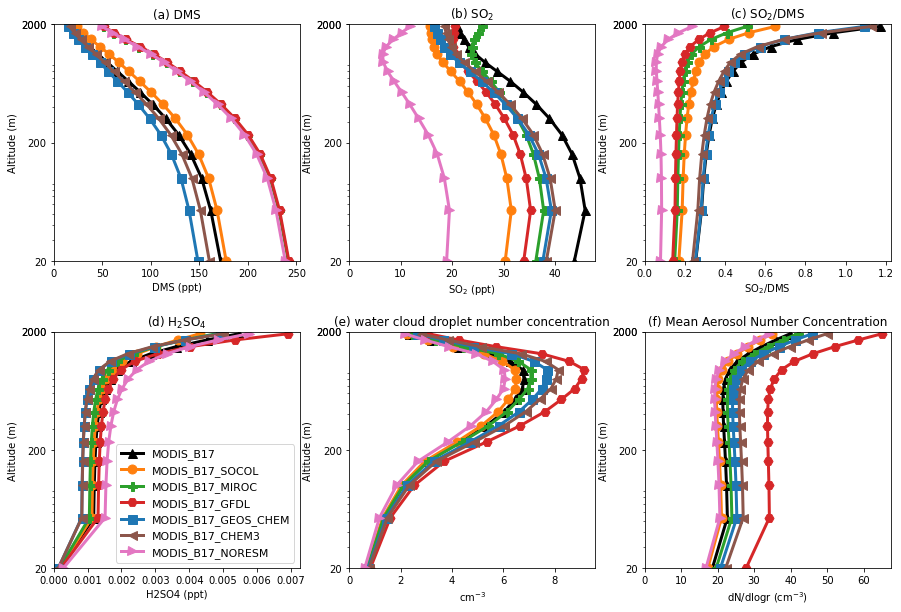

In [21]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']



labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

dms=np.zeros((len(labels),16)); dms[:] = np.nan
so2=np.zeros((len(labels),16)); so2[:] = np.nan
h2so4=np.zeros((len(labels),16)); h2so4[:] = np.nan
O3=np.zeros((len(labels),16)); O3[:] = np.nan

cloud=np.zeros((len(labels),16)); cloud[:] = np.nan


for i in range(0,(len(labels))):
    #end
#    h2so4o=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_ppt/Height/{}.npy'.format(labels[i])))*h2so4_ppt
    h2so4o=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_aerosol/Height/{}.npy'.format(labels[i])))*h2so4_ppt
  #  h2so4o=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_MMR/Height/{}.npy'.format(labels[i])))*h2so4_ppt
    h2so4[i]=np.nanmean(h2so4o[:],axis=1) 
    
    cloudy=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Cloud/Height/{}.npy'.format(labels[i])))
    cloud[i]=np.nanmean(cloudy[:],axis=1) 

    O3_m=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/O3/Height/{}.npy'.format(labels[i])))*o3_ppb/10
    O3[i]=np.nanmean(O3_m[:],axis=1) 

    so2o=(np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/HEIGHT/{}.npy'.format(labels[i])))*so2_ppt
    so2[i]=np.nanmean(so2o[:],axis=1) 

    dmsy=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/Height/{}.npy'.format(labels[i]))
    if dmsy.ndim == 2:
        dms[i]=np.nanmean(dmsy[:],axis=1)*dms_ppt
    else:
        dms[i]=np.nanmean(dmsy[:,:],axis=(1,2))*dms_ppt

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion.npy')        
num_con=np.sum(total_dndlr[:],axis=(2))
num_concentration=np.nanmean(num_con[:,:],axis=(2))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) DMS','(b) SO$_{2}$','(c) SO$_{2}$/DMS','(d) H$_{2}$SO$_{4}$','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','SO$_{2}$/DMS','H2SO4 (ppt)','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
dataset=[dms,so2,so2/dms,h2so4,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines

fig = plt.figure(figsize=(15,10), edgecolor='w')
plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']

for i in range(0,6):
  #  ax1.append(fig.add_subplot(2,2,i+1))
    ax1=(fig.add_subplot(2,3,i+1))
    #data=np.nanmean(dataset[i],axis=(2,3))
    data=dataset[i].transpose(1,0)
    for p in range(0,len(data[0])):
        ax1.plot(data[:,p],heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)
    ax1.set_title('{}'.format(title[i]))
    ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)')
    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)

#     if i == 3:
#         x_ticks=np.arange(0,0.0008,0.0002)
#         ax1.set_xticks(x_ticks)
#     if i == 2:
#         x_ticks=np.arange(0,0.0175,0.005)
#         ax1.set_xticks(x_ticks)
#     ax1.set_yticks(np.arange(0,1,0.01))

#     ax1.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)

    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 3:
        plt.legend(fontsize=11)
#     if i == 3:
#         ax1.set_xlim(120, 200)  # Set the desired range for the y-axis (0 to 2000 meters)

#plt.show()

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/SO4_Altitudes.png",dpi=200,bbox_inches = 'tight')
#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


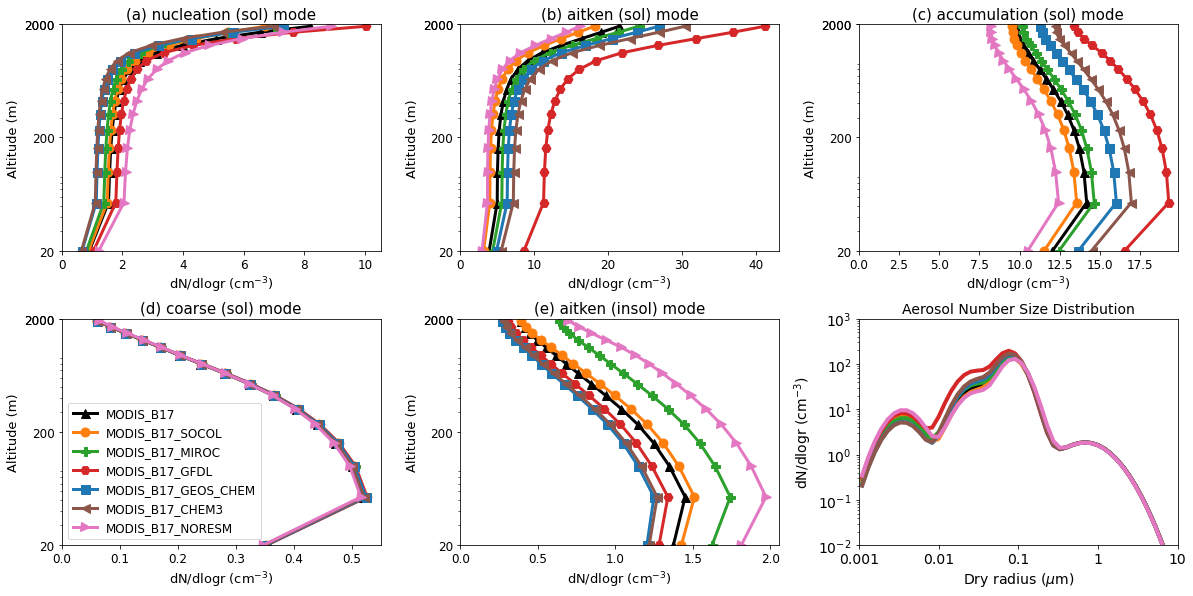

In [23]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(20,15), edgecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
# ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
# ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
# axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion.npy')        
#num_con=np.sum(total_dndlr[:],axis=(2))
num_concentration=np.nanmean(total_dndlr[:,:],axis=(3))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) Ai','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
#dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines


npts=50 # number of bins into which interpolate modal output
rmin=1.0e-9  # 1 nm
rmax=1.0e-5  # 10 microns

dryr_mid=np.zeros((npts),np.float64)
dryr_int=np.zeros((npts+1),np.float64)
deltar=np.zeros((npts),np.float64)

dryr_mids=np.zeros((npts),np.float64)
deltars=np.zeros((npts),np.float64)

for ibin in range(0,npts+1):
    logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
    dryr_int[ibin] = np.exp(logr)

for n in range(0,npts):
    dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
    deltar[n] = dryr_int[n+1]-dryr_int[n] #in m

    
# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']
num_con_sum=np.sum(total_dndlr[:,0],axis=(1))

for i in range(0,5):
    ax1 = fig.add_subplot(3,3,i+1)
    data=num_concentration[:,:,i]
  #  ax1.append(fig.add_subplot(2,2,i+1))
   # ax1=axes[i]#(fig.add_subplot(2,3,i+1))
    #data=np.nanmean(dataset[i],axis=(2,3))
    data=data.transpose(1,0)
    for p in range(0,len(data[0])):
        ax1.plot(data[:,p],heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)

    ax1.set_title('{}'.format(modes[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)
    ax1.set_xlabel('dN/dlogr (cm$^{-3}$)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 3:
        ax1.legend(fontsize=12)
#     if i == 1 or i == 4:
#         ax1.set_xlim(0, 45)  # Set the desired range for the y-axis (0 to 2000 meters)


ax = fig.add_subplot(3,3,6)
for p in range(0,len(labels)):
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(num_con_sum[p])
    #djf=(total_dndlr_CA[file])*1e-6

    #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[p],linewidth=4,label=labels[p])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 1000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    ax.set_title('Aerosol Number Size Distribution',fontsize=14)

  #  plt.legend(loc='lower center',fontsize=19)


#plt.show()

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc.png",dpi=200,bbox_inches = 'tight')
#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


In [13]:
labels=['MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
from matplotlib.colors import LinearSegmentedColormap
rf=np.zeros((len(labels))); rf[:] = np.nan
aod=[]
for i in range(0,(len(labels))):
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
    rf[i]=np.nanmean(rf_cl[:]) 
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    aod.append(aod_data.data)
aod_total=np.nanmean(np.array(aod),axis=0)
aod_total_std=np.nanstd(np.array(aod),axis=0)

fig = plt.figure(figsize=(15,15), edgecolor='w')
plt.subplots_adjust(hspace=-0.4)#x=np.arange(40,70,5)
clevs=np.arange(-10,10+1,1)
# colors = [(0, 'navy'), (0.5, 'white'), (1, 'firebrick')]
# cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
xa,ya  = np.meshgrid(lons,lats)
modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'All_Sky_RF.nc').__xarray_dataarray_variable__[:]
modis_b17_aod_data_std=modis_b17_aod_data.std('time')
modis_std=xr.open_dataset(MODIS_B17_file+'/10_years_dfj_ALL_Sky_RF').__xarray_dataarray_variable__.std('time')
for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(2,3,i+1)
    modis_b17_aod_data_mean=xr.open_dataset(MODIS_B17_file+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__[:]
    aod_data_mean=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]

    dots=find_diffs(aod_data,modis_b17_aod_data,0)
    diff=aod_data_mean-modis_b17_aod_data_mean
    #diff=difference.mean('time')
    
   # dots=np.zeros((144,192))
   # dots=xr.where(abs(diff[:]) > modis_std[:],0,1)

    map_ax1 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                    resolution ='c',ax=ax1)

    x, y = map_ax1(xa,ya) 
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawcountries()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)
   # var=blank_space(diff,-1,1)
    cs1=ax1.contourf(x,y,diff,clevs,extend='both',cmap=coolwarm_white)

    ax1.set_title("{} minus MODIS_B17".format(labels[i]),fontsize=14)
    [m,n] = np.where(dots==0)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    cs3 = ax1.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
            
cax = fig.add_axes([0.11, 0.2, 0.8, 0.025])

#cbar=fig.colorbar(cs,fraction=0.046, pad=0.04)
cbar=fig.colorbar(cs1, cax=cax,extend='both',orientation='horizontal',ticks = np.arange(-10,10+1,2))
cbar.set_label('{}'.format('W m$^{-2}$'),fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Radiative_Effects_CHEM_SO_MODIS_B17.png",dpi=200,bbox_inches = 'tight')


NameError: name 'MODIS_B17_SOCOL_file' is not defined

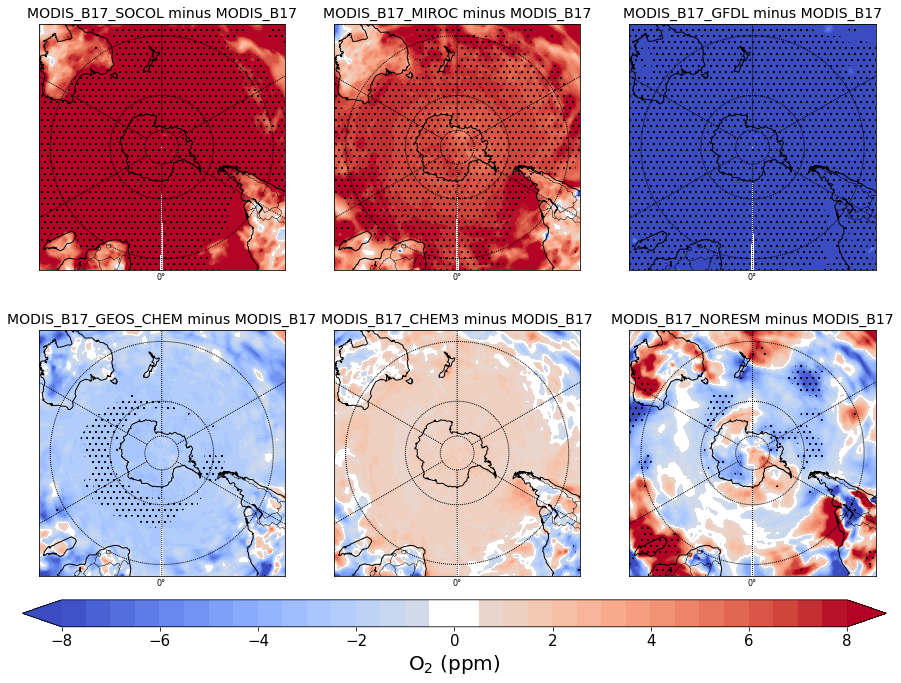

In [241]:
labels=['MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
from matplotlib.colors import LinearSegmentedColormap
# rf=np.zeros((len(labels))); rf[:] = np.nan
# aod=[]
# for i in range(0,(len(labels))):
#     rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
#     rf[i]=np.nanmean(rf_cl[:]) 
#     aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
#     aod.append(aod_data.data)
# aod_total=np.nanmean(np.array(aod),axis=0)
# aod_total_std=np.nanstd(np.array(aod),axis=0)

fig = plt.figure(figsize=(15,15), edgecolor='w')
plt.subplots_adjust(hspace=-0.4)#x=np.arange(40,70,5)

titles='O3_Mass_Mixing_Ratio'

if titles=='Total_H2SO4_load' !=-1:
    var='m01s38i520'
    clevs=np.arange(-1,1+.05,.05) # SO4
    num=1e6
    unit='mg m$^{-2}$'
    variable='SO4'
    MODEL_HEIGHT=1

if titles=='SO2_MASS_MIXING_RATIO'!=-1:
    var='mass_fraction_of_sulfur_dioxide_in_air'
    clevs=np.arange(-100,100+5,5) # SO2
    num=so2_ppt
    unit='SO$_{2}$ ppt'
    variable='SO2'
    MODEL_HEIGHT=1

if titles=='DMS_Mass_Mixing_Ratio.nc'!=-1:
    var='mass_fraction_of_dimethyl_sulfide_in_air'
    clevs=np.arange(-200,200+20,20) # DMS
    num=dms_ppt
    unit='DMS ppt'
    variable='DMS'
    MODEL_HEIGHT=1

if titles=='CDNC'!=-1:
    var='__xarray_dataarray_variable__'
    clevs=np.arange(-60,60+5,5) # DMS
    num=1
    unit='N$_{d}$ (cm$^{-3}$)'
    variable='CDNC'
    MODEL_HEIGHT=1

if titles=='ccn_concentration_25r'!=-1:
    var='m01s38i439'
    MODEL_HEIGHT=10
    clevs=np.arange(-60,60+5,5) # DMS
    num=1
    unit='N$_{50}$ (cm$^{-3}$)'
    variable='CCN'
    
if titles=='AOD'!=-1:
    var='__xarray_dataarray_variable__'
    MODEL_HEIGHT=1
    clevs=np.arange(-0.05,.05+.005,.005) # DMS
    num=1
    unit='AOD (550 nm)'
    variable='AOD'

if titles=='H2SO4_aerosol'!=-1:
    var='m01s38i485'
    MODEL_HEIGHT=1
    clevs=np.arange(-0.001,.001+.0001,.0001) # DMS
    num=h2so4_ppt
    unit='H$_{2}$SO$^{4}$ (ppt)'
    variable='AOD'
    
if titles=='H2SO4_AOD'!=-1:
    var='mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air'
    MODEL_HEIGHT=1
    clevs=np.arange(-0.005,.005+.0005,.0005) # DMS
    num=h2so4_ppt
    unit='H$_{2}$SO$^{4}$ (ppt)'
    variable='AOD'

if titles=='H2SO4_Mass_Mixing_Ratio'!=-1:
    var='mass_fraction_of_sulfuric_acid_in_air'
    MODEL_HEIGHT=1
    clevs=np.arange(-0.005,.005+.0005,.0005) # DMS
    num=h2so4_ppt
    unit='H$_{2}$SO$^{4}$ (ppt)'
    variable='AOD'

if titles=='Clear_Sky_RF'!=-1:
    var='__xarray_dataarray_variable__'
    MODEL_HEIGHT=1
    clevs=np.arange(-8,8+.5,.5) # DMS
    num=1
    unit='W m$^{-2}$'
    variable='Clear_Sky'

if titles=='O3_Mass_Mixing_Ratio'!=-1:
    var='mass_fraction_of_ozone_in_air'
    MODEL_HEIGHT=1
    clevs=np.arange(-8,8+.5,.5) # DMS
    num=o3_ppb/10
    unit='O$_{2}$ (ppm)'
    variable='O3'
    
test=xr.open_dataset(MODIS_B17_file+titles+'.nc')
#end


# colors = [(0, 'navy'), (0.5, 'white'), (1, 'firebrick')]
# cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
coolwarm_data[124:136, :] = 1.0  # Set values from index 128 to 384 as white

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
xa,ya  = np.meshgrid(lons,lats)
# modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'DMS_Mass_Mixing_Ratio.nc').mass_fraction_of_dimethyl_sulfide_in_air[:,:,:,[11,0,1]]*dms_ppt
# modis_b17_aod_data = modis_b17_aod_data.stack(time=('year', 'month', 'day')).transpose('latitude', 'longitude','time')
# modis_b17_aod_data=modis_b17_aod_data.transpose('time','latitude', 'longitude')
modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+titles+'.nc')[var]
try:
    modis_b17_aod_data = modis_b17_aod_data.sel(model_level_number=MODEL_HEIGHT)
except:
    pass
modis_b17_aod_data_std=modis_b17_aod_data.std('time')
modis_b17_aod_data_mean=modis_b17_aod_data.mean('time')

for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(2,3,i+1)
    aod_data=xr.open_dataset(AOD_file[i]+titles+'.nc')[var]
    try:
        aod_data = aod_data.sel(model_level_number=MODEL_HEIGHT)
    except:
        pass
    aod_data_mean=aod_data.mean('time')[:]

    dots=find_diffs(aod_data,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
    diff=aod_data_mean-modis_b17_aod_data_mean
    #diff=difference.mean('time')
    
    dots=xr.where(abs(diff[:]) > modis_b17_aod_data_std[:],0,1)

    map_ax1 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                    resolution ='c',ax=ax1)

    x, y = map_ax1(xa,ya) 
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawcountries()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)
    cs1=ax1.contourf(x,y,diff*num,clevs,extend='both',cmap=coolwarm_white)

    ax1.set_title("{} minus MODIS_B17".format(labels[i]),fontsize=14)
    [m,n] = np.where(dots==0)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    cs3 = ax1.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
            
cax = fig.add_axes([0.11, 0.2, 0.8, 0.025])

cbar=fig.colorbar(cs1, cax=cax,extend='both',orientation='horizontal')#,ticks = np.arange(-10,10+1,2))
cbar.set_label('{}'.format(unit),fontsize=20)
cbar.ax.tick_params(labelsize=15)

#plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/{}_CHEM_SO_MODIS_B17_std.png".format(variable),dpi=200,bbox_inches = 'tight')


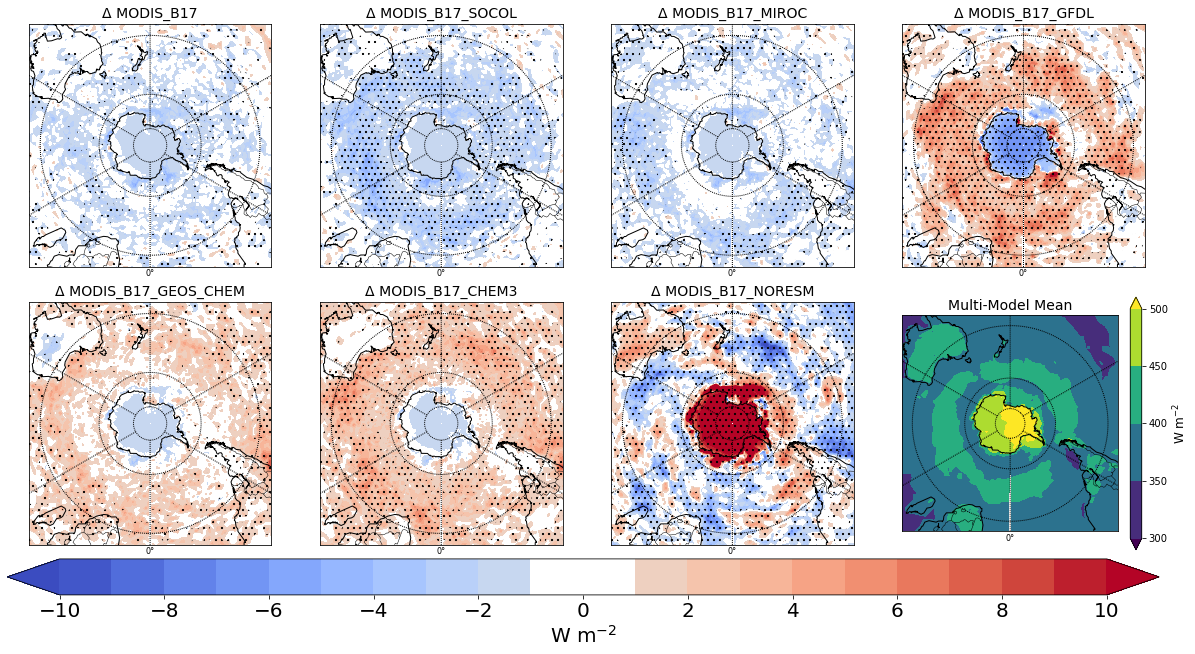

In [33]:
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]

rf=np.zeros((len(labels))); rf[:] = np.nan
aod=[]
for i in range(0,(len(labels))):
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
    rf[i]=np.nanmean(rf_cl[:]) 
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    aod.append(aod_data.data)
aod_total=np.nanmean(np.array(aod),axis=0)
aod_total_std=np.nanstd(np.array(aod),axis=0)

fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=0.1)#x=np.arange(40,70,5)
clevs=np.arange(-10,10+1,1)
# colors = [(0, 'navy'), (0.5, 'white'), (1, 'firebrick')]
# cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
xa,ya  = np.meshgrid(lons,lats)

for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(4,4,i+1)
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    diff=aod_data-aod_total
    dots=np.zeros((144,192))
    dots=xr.where(abs(diff[:]) > aod_total_std[:],-999,np.nan)

    map_ax1 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                    resolution ='c',ax=ax1)

    x, y = map_ax1(xa,ya) 
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawcountries()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)
   # var=blank_space(diff,-1,1)
    cs1=ax1.contourf(x,y,diff,clevs,extend='both',cmap=coolwarm_white)

    ax1.set_title("\u0394 {}".format(labels[i]),fontsize=14)
    [m,n] = np.where(dots==-999)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    cs3 = ax1.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    
    if i == 6:
        ax1 = fig.add_subplot(4,4,i+2)
        clevs2=np.arange(300,500+50,50)
        map_ax1 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                        resolution ='c',ax=ax1)
        lonpt, latpt = map_ax1(x,y,inverse=True)
        meridians = np.arange(0.,360,60.)    
        parallels = np.arange(-90.,90,30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
        map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
        map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)

        cs=ax1.contourf(x,y,aod_total,clevs2,extend='both',cmap='viridis')

        ax1.set_title("Multi-Model Mean",fontsize=14)
        cbar=fig.colorbar(cs,fraction=0.06, pad=0.05)
        cbar.set_label('{}'.format('W m$^{-2}$'),fontsize=12)

        
cax = fig.add_axes([0.11, 0.48, 0.8, 0.025])

#cbar=fig.colorbar(cs,fraction=0.046, pad=0.04)
cbar=fig.colorbar(cs1, cax=cax,extend='both',orientation='horizontal',ticks = np.arange(-10,10+1,2))
cbar.set_label('{}'.format('W m$^{-2}$'),fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Radiative_Effects_CHEM_SO.png",dpi=300,bbox_inches = 'tight')


In [142]:
# AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']

AOD_file=[Lana_B17_file,MODIS_LM86_file,REV3_B17_file,MEDUSA_B17_file,MEDUSA_LM86_file,REV3_LM86_file,Lana_LM86_file]
labels=['Lana_B17','MODIS_LM86','REV3_B17','MEDUSA_B17','MEDUSA_LM86','REV3_LM86','Lana_LM86']
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
file_type='MODIS_LM86'
run_length='Years'
file_input='{}'.format(file_type)
dates=[]
for y in (year):
    for m in (months):
         dates.append('{}{}'.format(y,m))    
dates=dates[12:36]

year=np.arange(2016,2020,1) 
#direct='/home/ybh10/Objective_3/Postprocess_Data/{}/Raw'.format(file_input)

colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
for i in range(0,len(AOD_file)):
    files=[];   files2=[]
    try:
        xr.open_dataset(AOD_file[i]+'/CDNC_Annual.nc')
        print(AOD_file[i] + ' Already completed')
        pass
    except:
        for d in (dates):
            file=('{}/../Raw/CDNC_Cloud_Top_{}.nc'.format(AOD_file[i],d))
            file2=('{}/../Raw/WEIGHT_FOR_CDNC_{}.nc'.format(AOD_file[i],d))

            files.append(file)
            files2.append(file2)

        top=xr.open_mfdataset(files).m01s01i298
        bottom=xr.open_mfdataset(files2).m01s01i299
        cdnc_data=top/bottom.load()
        cdnc_data.to_netcdf(AOD_file[i]+'/CDNC_Annual.nc')
        print(AOD_file[i]+' done')

/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_2/Post_Processed_Data/Lana_B17/Years/Processed/ done


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/ done


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_3/Postprocess_Data/REV3_B17/Processed/ done


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_3/Postprocess_Data/MEDUSA_B17/Processed/ done


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_2/Post_Processed_Data/MEDUSA_LM86/Years/Processed/ done


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_2/Post_Processed_Data/Hulswar_LM86/Years/Processed/ done


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/home/ybh10/Objective_3/Postprocess_Data/Lana_LM86/Processed/ done


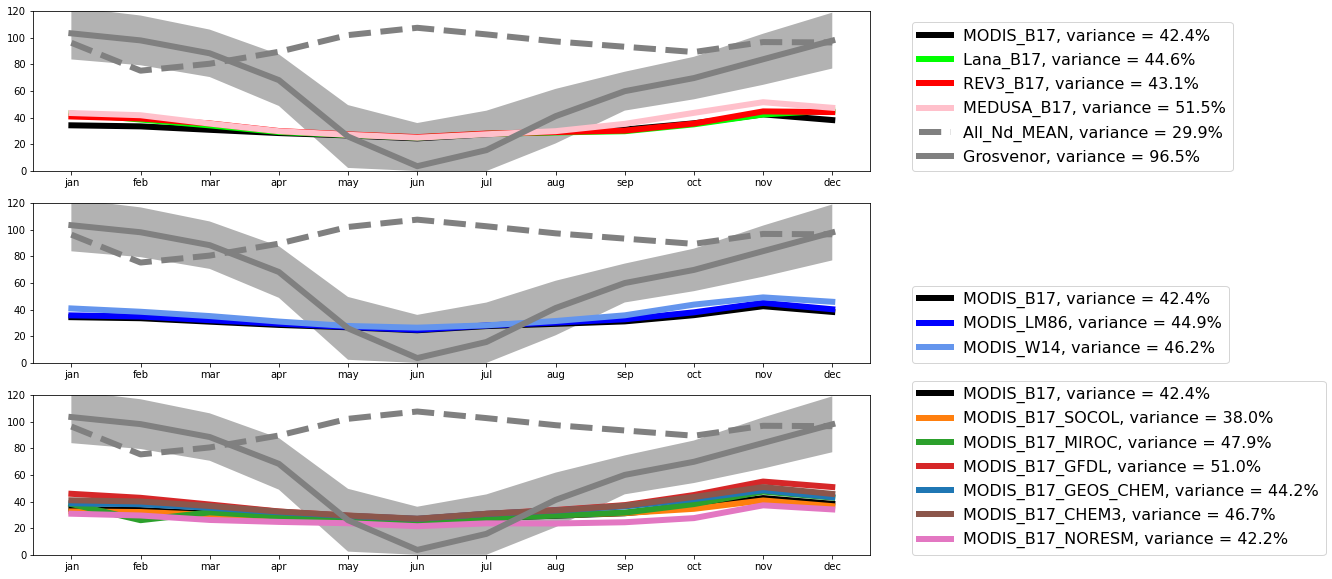

In [163]:
from scipy.stats import iqr
AOD_file_ch=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
labels_ch=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colours_CH = ['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

AOD_files_so=[MODIS_B17_file,Lana_B17_file,REV3_B17_file,MEDUSA_B17_file]
labels_so=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17']
colours_SO=['black','lime','red','pink']

AOD_files_so=[MODIS_B17_file,MODIS_LM86_file,MODIS_W14_file]
labels_em=['MODIS_B17','MODIS_LM86','MODIS_W14']
colours_EM=['black','blue','cornflowerblue']

fig = plt.figure(figsize=(15,10), edgecolor='w')
plt.subplots_adjust(hspace=0.2)#x=np.arange(40,70,5)
ax = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(3,1,2)
ax2 = fig.add_subplot(3,1,3)
axes=[ax,ax1,ax2]
#MODIS_an=areaweight(cdnc_all[:,29:51],modis_lat[29:51])
#MODIS_an=np.nanmean(cdnc_obs[:,:,:],axis=(0,2))
#MODIS_an_std=np.nanstd(cdnc_obs[:,:,:],axis=(0,2))


# areaweighted_cdnc=areaweight_numpy(MODIS_an,modis_lat[29:51])  
# areaweighted_cdnc_std_months=areaweight_numpy(MODIS_an_std,modis_lat[29:51])    
cdnc_all_southern_ocean=areaweight(cdnc_all_months_mean[:,29:51],modis_lat[29:51])
modis_uk_an_iqr_all=areaweight(cdnc_all_months_std[:,29:51],modis_lat[29:51])

# cdnc_so=cdnc_all_southern_ocean.groupby('time.month').mean()
# modis_uk_an_iqr_all=cdnc_all_southern_ocean.groupby('time.month').std()

#MODIS=np.nanmean(cdnc_grosner[[0,1,11]],axis=(0,2))
MODIS_an=areaweight_numpy(cdnc_grosner[:,:,:],modis_lat[29:51])#,axis=(0,2))

modis_uk_an_iqr=np.nanstd(cdnc_grosner[[0,1,11],:,:],axis=(0,2))
modis_uk_iqr_an=np.nanstd(cdnc_grosner[:,:,:],axis=(0,2))
modis_uk_iqr=np.nanstd(cdnc_grosner[:,:,:],axis=(1,2))

lower=GROS_AREAWEIGHT_MEAN-modis_uk_iqr; lower=np.where(lower<0,0,lower)
w=6

for i in range(0,(len(labels_ch))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Seasonality/{}.npy'.format(labels_ch[i]))
    a=(variance_percentage(aod_data))
    ax2.plot(months,aod_data,color=colours_CH[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_ch[i],a))
    
for i in range(0,(len(labels_so))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Seasonality/{}.npy'.format(labels_so[i]))
    a=(variance_percentage(aod_data))
    ax.plot(months,aod_data,color=colours_SO[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_so[i],a))
    
for i in range(0,(len(labels_em))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Seasonality/{}.npy'.format(labels_em[i]))
    a=(variance_percentage(aod_data))
    ax1.plot(months,aod_data,color=colours_EM[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_em[i],a))

for axe in (axes):
    axe.set_ylim(0,120)
b=(variance_percentage(cdnc_all_southern_ocean))
c=(variance_percentage(GROS_AREAWEIGHT_MEAN))
ax.plot(months,cdnc_all_southern_ocean,color='gray',linestyle='--',linewidth=w,label='All_Nd_MEAN, variance = {:.1f}%'.format(b.data))
ax.plot(months,GROS_AREAWEIGHT_MEAN,color='gray',linewidth=w,label='Grosvenor, variance = {:.1f}%'.format(c))
ax.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+modis_uk_iqr,facecolor='black',alpha=0.3,)

ax1.plot(months,cdnc_all_southern_ocean,color='gray',linestyle='--',linewidth=w)#,label='All_Nd_MEAN, var = {:.1f}%'.format(b))
ax1.plot(months,GROS_AREAWEIGHT_MEAN,color='gray',linewidth=w)#,label='Grosvenor, variance = {:.1f}%'.format(c))
ax1.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+modis_uk_iqr,facecolor='black',alpha=0.3,)

ax2.plot(months,cdnc_all_southern_ocean,color='gray',linestyle='--',linewidth=w)#,label='All_Nd_MEAN, var = {:.1f}%'.format(b))
ax2.plot(months,GROS_AREAWEIGHT_MEAN,color='gray',linewidth=w)#,label='Grosvenor, variance = {:.1f}%'.format(c))
ax2.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+modis_uk_iqr,facecolor='black',alpha=0.3,)

# ax1.legend()
# ax.legend()
ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)
ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/CDNC_Seasonality.png",dpi=100,bbox_inches = 'tight')


/nesi/project/niwa02757/ybh10/miniconda3/envs/master/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


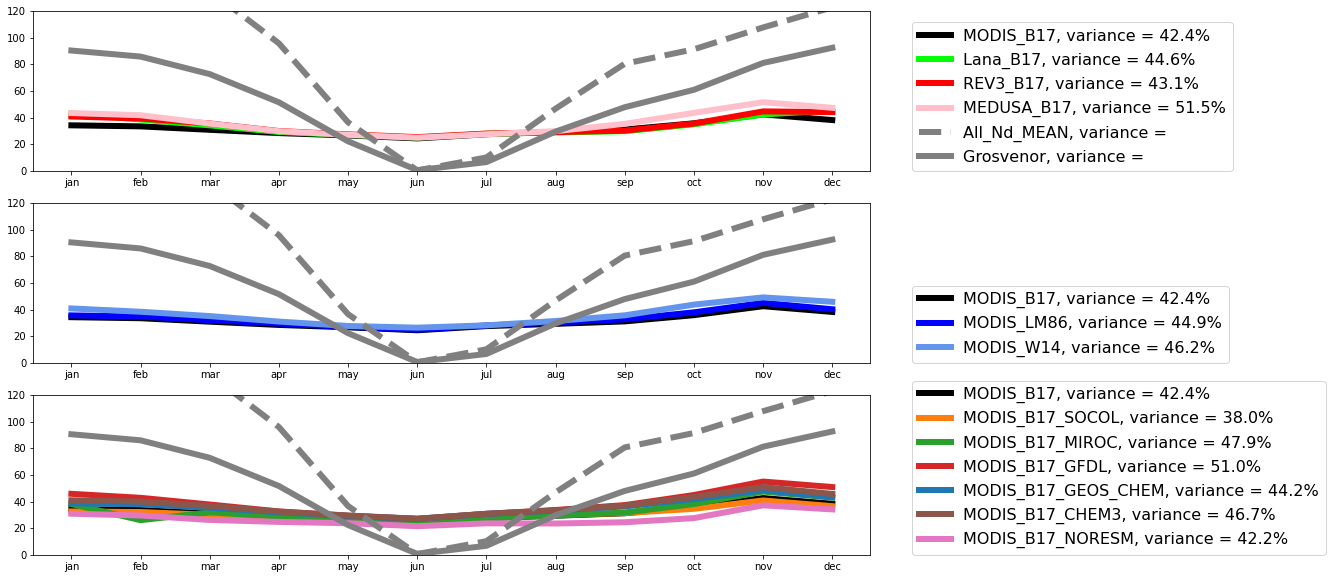

In [149]:
from scipy.stats import iqr
AOD_file_ch=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
labels_ch=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colours_CH = ['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

AOD_files_so=[MODIS_B17_file,Lana_B17_file,Hulswar_B17_file,MEDUSA_B17_file]
labels_so=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17']
colours_SO=['black','lime','red','pink']

AOD_files_so=[MODIS_B17_file,MODIS_LM86_file,MODIS_W14_file]
labels_em=['MODIS_B17','MODIS_LM86','MODIS_W14']
colours_EM=['black','blue','cornflowerblue']

fig = plt.figure(figsize=(15,10), edgecolor='w')
plt.subplots_adjust(hspace=0.2)#x=np.arange(40,70,5)
ax = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(3,1,2)
ax2 = fig.add_subplot(3,1,3)
axes=[ax,ax1,ax2]
#MODIS_an=areaweight(cdnc_all[:,29:51],modis_lat[29:51])
#MODIS_an=np.nanmean(cdnc_obs[:,:,:],axis=(0,2))
#MODIS_an_std=np.nanstd(cdnc_obs[:,:,:],axis=(0,2))


# areaweighted_cdnc=areaweight_numpy(MODIS_an,modis_lat[29:51])  
# areaweighted_cdnc_std_months=areaweight_numpy(MODIS_an_std,modis_lat[29:51])    
cdnc_all_southern_ocean=areaweight(cdnc_all_months_mean[:,29:51],modis_lat[29:51])
modis_uk_an_iqr_all=areaweight(cdnc_all_months_std[:,29:51],modis_lat[29:51])

# cdnc_so=cdnc_all_southern_ocean.groupby('time.month').mean()
# modis_uk_an_iqr_all=cdnc_all_southern_ocean.groupby('time.month').std()

#MODIS=np.nanmean(cdnc_grosner[[0,1,11]],axis=(0,2))
MODIS_an=areaweight_numpy(cdnc_grosner[:,:,:],modis_lat[29:51])#,axis=(0,2))

modis_uk_an_iqr=np.nanstd(cdnc_grosner[[0,1,11],:,:],axis=(0,2))
modis_uk_iqr_an=np.nanstd(cdnc_grosner[:,:,:],axis=(0,2))
modis_uk_iqr=np.nanstd(cdnc_grosner[:,:,:],axis=(1,2))

lower=GROS_AREAWEIGHT_MEAN-modis_uk_iqr; lower=np.where(lower<0,0,lower)
w=6

for i in range(0,(len(labels_ch))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Seasonality/{}.npy'.format(labels_ch[i]))
    a=(variance_percentage(aod_data))
    ax2.plot(months,aod_data,color=colours_CH[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_ch[i],a))
    
for i in range(0,(len(labels_so))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Seasonality/{}.npy'.format(labels_so[i]))
    a=(variance_percentage(aod_data))
    ax.plot(months,aod_data,color=colours_SO[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_so[i],a))
    
for i in range(0,(len(labels_em))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Seasonality/{}.npy'.format(labels_em[i]))
    a=(variance_percentage(aod_data))
    ax1.plot(months,aod_data,color=colours_EM[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_em[i],a))

for axe in (axes):
    axe.set_ylim(0,120)
obs=nd_g18[:,23:40].sel(time=(nd_g18
                              ['time'].dt.year.isin([2017, 2018]))).groupby('time.month').mean()
obs_lat=obs.lat
mean_ob=ccn_global_obs=areaweight(obs,obs_lat)

obs_br17=nd_br17[:,23:40].sel(time=(nd_br17['time'].dt.year.isin([2017, 2018]))).groupby('time.month').mean()
obs_br17_lat=obs.lat
mean_ob_br=areaweight(obs_br17,obs_br17_lat)

b=(variance_percentage(cdnc_all_southern_ocean))
c=(variance_percentage(GROS_AREAWEIGHT_MEAN))
ax.plot(months,mean_ob_br,color='gray',linestyle='--',linewidth=w,label='All_Nd_MEAN, variance = ')
ax.plot(months,mean_ob,color='gray',linewidth=w,label='Grosvenor, variance = ')
#ax.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+modis_uk_iqr,facecolor='black',alpha=0.3,)

ax1.plot(months,mean_ob_br,color='gray',linestyle='--',linewidth=w)#,label='All_Nd_MEAN, var = {:.1f}%'.format(b))
ax1.plot(months,mean_ob,color='gray',linewidth=w)#,label='Grosvenor, variance = {:.1f}%'.format(c))
#ax1.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+modis_uk_iqr,facecolor='black',alpha=0.3,)

ax2.plot(months,mean_ob_br,color='gray',linestyle='--',linewidth=w)#,label='All_Nd_MEAN, var = {:.1f}%'.format(b))
ax2.plot(months,mean_ob,color='gray',linewidth=w)#,label='Grosvenor, variance = {:.1f}%'.format(c))
#ax2.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+modis_uk_iqr,facecolor='black',alpha=0.3,)

# ax1.legend()
# ax.legend()
ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)
ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/CDNC_Seasonality.png",dpi=100,bbox_inches = 'tight')


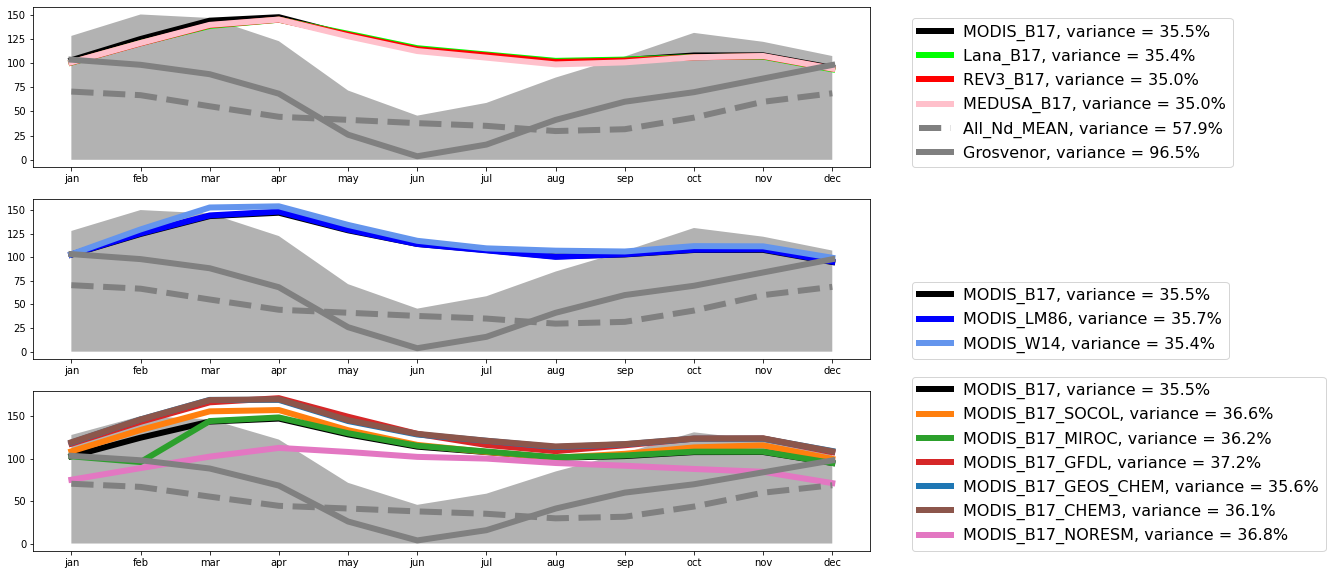

In [239]:
from scipy.stats import iqr
AOD_file_ch=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
labels_ch=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colours_CH = ['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

AOD_files_so=[MODIS_B17_file,Lana_B17_file,REV3_B17_file,MEDUSA_B17_file]
labels_so=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17']
colours_SO=['black','lime','red','pink']

AOD_files_so=[MODIS_B17_file,MODIS_LM86_file,MODIS_W14_file]
labels_em=['MODIS_B17','MODIS_LM86','MODIS_W14']
colours_EM=['black','blue','cornflowerblue']

fig = plt.figure(figsize=(15,10), edgecolor='w')
plt.subplots_adjust(hspace=0.2)#x=np.arange(40,70,5)
ax = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(3,1,2)
ax2 = fig.add_subplot(3,1,3)
axes=[ax,ax1,ax2]
#MODIS_an=areaweight(cdnc_all[:,29:51],modis_lat[29:51])
#MODIS_an=np.nanmean(cdnc_obs[:,:,:],axis=(0,2))
#MODIS_an_std=np.nanstd(cdnc_obs[:,:,:],axis=(0,2))

nh_lats = modis_lat.sel(lat=slice(39, 61))
cdnc_all_months_mean_nh = cdnc_all_months_mean.sel(lat=slice(39, 61))
cdnc_all_months_std_nh = cdnc_all_months_std.sel(lat=slice(39, 61))

# areaweighted_cdnc=areaweight_numpy(MODIS_an,modis_lat[29:51])  
# areaweighted_cdnc_std_months=areaweight_numpy(MODIS_an_std,modis_lat[29:51])    
cdnc_all_nh=areaweight(cdnc_all_months_mean_nh[:,:],nh_lats)
modis_uk_an_iqr_all=areaweight(cdnc_all_months_std_nh[:,:],nh_lats)

# cdnc_so=cdnc_all_southern_ocean.groupby('time.month').mean()
# modis_uk_an_iqr_all=cdnc_all_southern_ocean.groupby('time.month').std()

#MODIS=np.nanmean(cdnc_grosner[[0,1,11]],axis=(0,2))
MODIS_an=areaweight_numpy(cdnc_grosner_global[:,129:151,:],nh_lats)#,axis=(0,2))
MODIS_an_std=areaweight_numpy(cdnc_grosner_global_std[:,129:151,:],nh_lats)#,axis=(0,2))

modis_uk_an_iqr=np.nanstd(cdnc_grosner_global[[0,1,11],129:151,:],axis=(0,2))
modis_uk_iqr_an=np.nanstd(cdnc_grosner_global[:,129:151,:],axis=(0,2))
modis_uk_iqr=np.nanstd(cdnc_grosner_global[:,129:151,:],axis=(1,2))

lower=MODIS_an_std-modis_uk_iqr; lower=np.where(lower<0,0,lower)
w=6

for i in range(0,(len(labels_ch))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/North_Hem/Seasonality/{}.npy'.format(labels_ch[i]))
    a=(variance_percentage(aod_data))
    ax2.plot(months,aod_data,color=colours_CH[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_ch[i],a))
    
for i in range(0,(len(labels_so))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/North_Hem/Seasonality/{}.npy'.format(labels_so[i]))
    a=(variance_percentage(aod_data))
    ax.plot(months,aod_data,color=colours_SO[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_so[i],a))
    
for i in range(0,(len(labels_em))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/North_Hem/Seasonality/{}.npy'.format(labels_em[i]))
    a=(variance_percentage(aod_data))
    ax1.plot(months,aod_data,color=colours_EM[i],linewidth=w,label='{}, variance = {:.1f}%'.format(labels_em[i],a))

# for axe in (axes):
#     axe.set_ylim(0,120)
b=(variance_percentage(cdnc_all_southern_ocean))
c=(variance_percentage(GROS_AREAWEIGHT_MEAN))
ax.plot(months,cdnc_all_southern_ocean,color='gray',linestyle='--',linewidth=w,label='All_Nd_MEAN, variance = {:.1f}%'.format(b.data))
ax.plot(months,GROS_AREAWEIGHT_MEAN,color='gray',linewidth=w,label='Grosvenor, variance = {:.1f}%'.format(c))
ax.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+MODIS_an_std,facecolor='black',alpha=0.3,)

ax1.plot(months,cdnc_all_southern_ocean,color='gray',linestyle='--',linewidth=w)#,label='All_Nd_MEAN, var = {:.1f}%'.format(b))
ax1.plot(months,GROS_AREAWEIGHT_MEAN,color='gray',linewidth=w)#,label='Grosvenor, variance = {:.1f}%'.format(c))
ax1.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+MODIS_an_std,facecolor='black',alpha=0.3,)

ax2.plot(months,cdnc_all_southern_ocean,color='gray',linestyle='--',linewidth=w)#,label='All_Nd_MEAN, var = {:.1f}%'.format(b))
ax2.plot(months,GROS_AREAWEIGHT_MEAN,color='gray',linewidth=w)#,label='Grosvenor, variance = {:.1f}%'.format(c))
ax2.fill_between(months, lower,  GROS_AREAWEIGHT_MEAN+MODIS_an_std,facecolor='black',alpha=0.3,)

# ax1.legend()
# ax.legend()
ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)
ax1.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=16)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/CDNC_Seasonality.png",dpi=100,bbox_inches = 'tight')


In [1]:
import numpy.ma as ma
labels=['MODIS_B17','Lana_B17','Hulswar_B17','Hulswar_B17_SOCOL','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labelss=['MODIS_B17','Lana_B17','Hulswar_B17','Hulswar_B17_SOCOL','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
#colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','purple','pink','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
# for i in range(0,(len(labels))):
#     ####  AOD ###
#     aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/{}.npy'.format(labels[i]))
#     AOD[i]=np.nanmean((aod_data[:]))
#     AOD_std[i]=np.nanstd((aod_data[:]))
    

formatu=['s','<','>','^','o','^','o','P','v','s','<','>','*','H']

fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

# for i in range(0,4):
#     axes[i].set_xlim(0.3,1)
#     axes2[i].set_xlim(0.3,1)
#     axes3[i].set_xlim(0.3,1)
#     axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
#     axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
#     axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
AMS=[]; CAPE=[]; KING=[]; SO=[]
l=4 # line thickness
for i in range(0,len(labels)):
    AOD_file=globals().get(labels[i]+'_file')
   # print(labels[i]+'_file')
    print(labels[i])
    print(colourss[i])
    dms_raw=xr.open_dataset(AOD_file+'../Annual_Processed/DMS_Mass_Mixing_Ratio.nc').mass_fraction_of_dimethyl_sulfide_in_air
    try:
        dms_raw= dms_raw.sel(model_level_number=1)
    except:
        pass
    if labels[i] == 'MODIS_B17':
        dms=dms_raw.groupby('month').mean()*dms_ppt
    else:
        dms= dms_raw.groupby('time.month').mean()*dms_ppt
    dms=dms.transpose('month','latitude','longitude')
    print('Amsterdam')
    print(corrcoef_without_nan(dms[:,22,161],AMSTERDAM_CLIM_DMS[:,0])**2)
    AMS.append(corrcoef_without_nan(dms[:,22,161],AMSTERDAM_CLIM_DMS[:,0])**2)
    print('Cape Grim')
    print(corrcoef_without_nan(dms[:,39,77],CapeGrim_CLIM['DMS'])**2)
    CAPE.append(corrcoef_without_nan(dms[:,39,77],CapeGrim_CLIM['DMS'])**2)
    print('King Sejog')
    print(corrcoef_without_nan(dms[:,41,41].data,np.array(King_DMS_Clim))**2)
    KING.append(corrcoef_without_nan(dms[:,41,41].data,np.array(King_DMS_Clim))**2)
    so_data=(areaweight(dms[:,23:40],lats[23:40]))
    print('Southern Ocean')
    print(corrcoef_without_nan(so_data,DMS_Climatology)**2)
    SO.append(corrcoef_without_nan(so_data,DMS_Climatology)**2)

    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
        #axes[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
        
       # king_data[i]=dms[:,22,161].mean(axis=(1,2));king_data_std[i]=DMS_mmr[:,:,:,22,161,:].std(axis=(1,2))
#        axes[1].errorbar(months,dms[:,22,161],yerr=(king_data_std[i]),marker='x',capsize=7,color=colours[i],linestyle='--',linewidth=3,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(king_data[i])))
        axes[0].plot(months,dms[:,22,161],color=colourss[i],linestyle='--',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,22,161])))
        
        axes[2].plot(months,dms[:,41,41],color=colourss[i],linestyle=':',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,41,41])))
        
        axes[1].plot(months,dms[:,39,77],color=colourss[i],linestyle='-.',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,39,77])))

        axes[3].plot(months,so_data,marker='x',color=colourss[i],linestyle='-',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(so_data)))

    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #end
            #print(i)
            axes3[0].plot(months,dms[:,22,161],color=colourss[i],linestyle='--',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,22,161])))

            axes3[2].plot(months,dms[:,41,41],color=colourss[i],linestyle=':',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,41,41])))

            axes3[1].plot(months,dms[:,39,77],color=colourss[i],linestyle='-.',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,39,77])))

          #  so_data=(areaweight(dms[:,23:40],lats[23:40]))
            axes3[3].plot(months,so_data,marker='x',color=colourss[i],linestyle='-',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(so_data)))
            
        else:
         #   print(i)
            axes2[0].plot(months,dms[:,22,161],marker=formatu[i],color=colourss[i],linestyle='--',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,22,161])))

            axes2[2].plot(months,dms[:,41,41],marker=formatu[i],color=colourss[i],linestyle=':',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,41,41])))

            axes2[1].plot(months,dms[:,39,77],marker=formatu[i],color=colourss[i],linestyle='-.',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(dms[:,39,77])))

          #  so_data=(areaweight(dms[:,23:40],lats[23:40]))
            axes2[3].plot(months,so_data,marker=formatu[i],color=colourss[i],linestyle='-',linewidth=l,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(so_data)))

month_2=['jan', 'mar', 'may', 'jul', 'sep', 'nov']            
axe=[axes,axes2,axes3] 
for ax in (axe):
    ax[0].errorbar(months,AMSTERDAM_CLIM_DMS,yerr=(AMSTERDAM_std)
                     ,marker='x',color='gray',linewidth=5,label='Amsterdam_Clim, x\u0304={:.3f}'.format(np.nanmean(AMSTERDAM_CLIM_DMS)))
    ax[1].errorbar(months,(CapeGrim_CLIM['DMS']),yerr=(CapeGrim_std['DMS']),marker='x',color='gray',linewidth=5,label='CapeGrim, x\u0304={:.3f}'.format(np.nanmean(CapeGrim_CLIM['DMS'])))

    ax[2].errorbar(months,King_DMS_Clim,yerr=(King_DMS_Clim_std),marker='x',color='gray',linewidth=5,label='King_Sejong, x\u0304={:.3f}'.format(np.nanmean(King_DMS_Clim)))
    ax[3].errorbar(months,DMS_Climatology,yerr=(DMS_Climatology_std),color='gray',linewidth=5,label='Atmos_DMS_Southern_Ocean, x\u0304={:.3f}'.format(np.nanmean(DMS_Climatology)))
    ax[0].set_ylim(0,800)
    ax[1].set_ylim(0,310)
    ax[2].set_ylim(0,360)
    ax[3].set_ylim(0,450)

    for i in range(0,4):
        ax[i].xaxis.set_tick_params(labelsize=14,rotation=45)
        ax[i].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
        ax[i].set_xticks(month_2)

labely=np.array(labels)

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
        axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
    else:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
        else:
            axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
    
axes[0].set_title('Amsterdam Island',fontsize=16)
axes[1].set_title('Cape Grim',fontsize=16)
axes[2].set_title('King Sejong',fontsize=16)
axes[3].set_title('Southern Ocean',fontsize=16)

#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/DMS_Seasonality_SOCOL.png",dpi=100,bbox_inches = 'tight')


NameError: name 'np' is not defined

<ipython-input-185-9155b1f6fa4e>:54: RuntimeWarning: Mean of empty slice
  b=np.nanmean(MODIS_AOD[23:40],axis=(0,1))


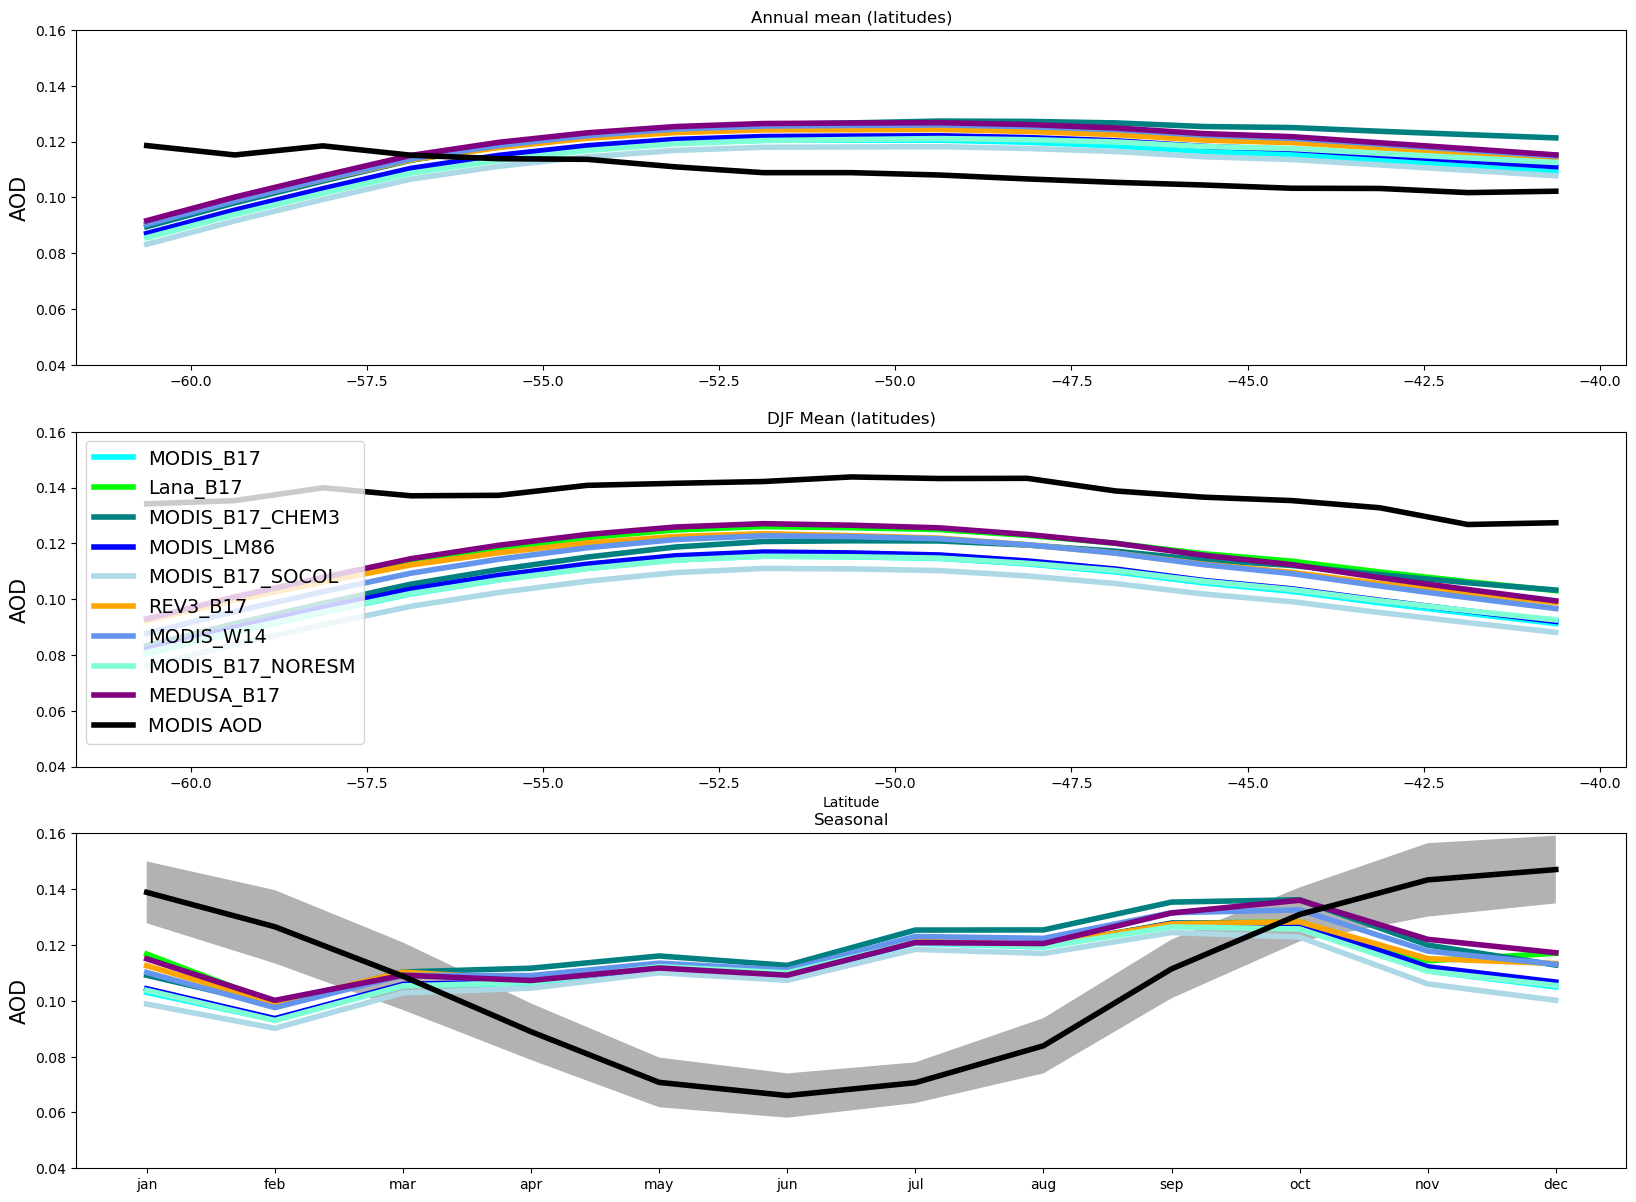

In [185]:
from scipy.stats import iqr
AOD_file=[MODIS_B17_file,Lana_B17_file,MODIS_B17_CHEM_file,MODIS_LM86_file,MODIS_B17_SOCOL_file,REV3_B17_file,MODIS_W14_file,MODIS_B17_NORESM_file,MEDUSA_B17_file]
labels=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14','MODIS_B17_NORESM','MEDUSA_B17']
labelss=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14','MODIS_B17_NORESM','MEDUSA_B17']


fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=0.2)#x=np.arange(40,70,5)
ax1 = fig.add_subplot(4,1,2)
ax2 = fig.add_subplot(4,1,3)
ax3 = fig.add_subplot(4,1,1)
# ax4 = fig.add_subplot(4,1,4)

aod=np.zeros((len(labels),2,12,31)); aod[:] = np.nan
for i in range(0,(len(labels))):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/{}.npy'.format(labels[i]))
    #end
#     if i == 0:
#         aod_data[-2,9,:]=aod_data[-3,9,:]
    if np.size(np.array(aod_data[:,0,0])) > 2:
        aod_data=aod_data[-2:,:,:]
    aod[i]=(aod_data)
# modis_uk=areaweight(modis_uk_aod[:,:,23:40],lats[23:40])
# modis_uk_an = np.nanmedian(modis_uk,axis=(0))
# modis_uk_an_iqr = iqr(modis_uk,axis=0)

MODIS_AOD_av=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/MODIS_AOD_Areaweight.npy')
np.nanstd(MODIS_AOD_av)
colourss=['aqua','lime','teal','blue','lightblue','orange','cornflowerblue','aquamarine','purple']
clev=np.arange(0,0.15+0.01,0.01)
w=4
for i in range(0,len(AOD_file)):
    aod_data=xr.open_dataset(AOD_file[i]+'AOD.nc').__xarray_dataarray_variable__[23:40]
    if np.size(np.array(aod_data[0,0,:,0,0])) > 2:
        aod_data=aod_data[:,:,-2:,:,:]
    #aod_data=aod_data.transpose('year','month','day','latitude','longitude')
    aod_djf=aod_data[:,:,:].data    
    aod_plot=np.nanmean(aod_djf[:,:,:,[0,1,11]],axis=(1,2,3,4))
    
    aod_plot_season=np.nanmean(aod[i],axis=(0,2))

    aod_plot_an=np.nanmean(aod_djf[:,:,:],axis=(1,2,3,4))
        
    ax1.plot(lats[23:40],aod_plot,color=colourss[i],linewidth=w,label=labelss[i])
    ax2.plot(months,aod_plot_season,color=colourss[i],linewidth=w,label=labelss[i])
    ax3.plot(lats[23:40],aod_plot_an,color=colourss[i],linewidth=w,label=labelss[i])
    
# ###### MODIS AOD #######
MODIS_lats=np.nanmean(MODIS_AOD
                      [23:40,:,:,[0,1,11]],axis=(1,2,3,4))
MODIS_an=np.nanmean(MODIS_AOD[23:40,:],axis=(1,2,3,4))
MODIS_seasonal=np.nanmean(MODIS_AOD_av[:,:],axis=(0,2))
MODIS_seasonal=np.nanmean(MODIS_AOD[23:40,:],axis=(0,1,2,4))

b=np.nanmean(MODIS_AOD[23:40],axis=(0,1))
modis_uk_an_iqr=np.nanstd(MODIS_AOD[23:40,:,:,[0,1,11]],axis=(1,2,3,4))
modis_uk_iqr_an=np.nanstd(MODIS_AOD[23:40,:],axis=(1,2,3,4))
modis_fill_season=np.nanstd(b[:,:,:],axis=(0,2))

ax1.plot(lats[23:40],MODIS_lats,color='black',linewidth=w,label='MODIS AOD')
ax2.plot(months,MODIS_seasonal,color='black',linewidth=w,label='MODIS AOD')
ax3.plot(lats[23:40],MODIS_an,color='black',linewidth=w,label='MODIS AOD')

lower=MODIS_seasonal-modis_fill_season; lower=np.where(lower<0,0,lower)
# ax1.fill_between(lats[23:40], MODIS_lats-modis_uk_an_iqr,  MODIS_lats+modis_uk_an_iqr,facecolor='black',alpha=0.3,)
ax2.fill_between(months, lower,  MODIS_seasonal+modis_fill_season,facecolor='black',alpha=0.3,)
#ax3.fill_between(lats[23:40],MODIS_an-modis_uk_iqr_an,  MODIS_an+modis_uk_iqr_an,facecolor='black',alpha=0.3,)


#ax1.plot(lats[23:40],MODISs,color='pink',label='MODIS')

#ax1.errorbar(lats[23:40],MODIS,yerr=MODIS_IQR,color='red',label='MODIS')
ax1.legend(loc='upper left',fontsize=14)
titles=['DJF Mean (latitudes)','Seasonal','Annual mean (latitudes)']
for ax,i in zip((ax1,ax2,ax3),range(0,3)):#,ax4):
    ax.set_ylabel('AOD',fontsize=15)
    #ax.set_ylabel(fontsize=15)
    ax.set_title(titles[i])
    ax.set_ylim(0.04,0.16)
ax1.set_xlabel('Latitude')
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/SO_AOD_Comparison.png",dpi=100,bbox_inches = 'tight')


In [ ]:
#fig = plt.figure(figsize=(10,10), edgecolor='w')
fig = plt.figure(figsize=(20,20), edgecolor='w')
axes=[]
for i in range(1,5):
    axes.append(fig.add_subplot(2,2,i))
plt.subplots_adjust(hspace=-0.05, wspace=0.2)#x=np.arange(40,70,5)
x_tick=np.arange(0,100,5)
upper_lat=40
lower_lat=23
data_files=[Control_file,Perturbed_file,Lana_file,REV3_file,MODIS_N00_file,MODIS_W14_file,MODIS_B17_file,Lana_W14_file,Lana_B17_file]
labels=['MEDUSA_LM86','MODIS_LM86','Lana_LM86', 'REV3_LM86','MODIS_N00','MODIS_W14', 'MODIS_B17','Lana_W14','Lana_B17']
###### KING STATION 
###### AMSTERDAM ISALND STATION: 37°50′S 77°33′E
###### Cape Grim STATION: 41∘ S, 145∘ E
DMS_djf_all=np.zeros((9,3,31,10)); DMS_djf_all[:]=np.nan
DMS_djf_so=np.zeros((9)); DMS_djf_so[:]=np.nan
DMS_djf_std_so=np.zeros((9)); DMS_djf_std_so[:]=np.nan

so_data_std=np.zeros((9,12)); so_data_std[:]=np.nan
king_data=np.zeros((9,12)); king_data[:]=np.nan;king_data_std=np.zeros((9,12)); king_data_std[:]=np.nan
amst_data=np.zeros((9,12)); amst_data[:]=np.nan;amst_data_std=np.zeros((9,12)); amst_data_std[:]=np.nan
cape_data=np.zeros((9,12)); cape_data[:]=np.nan;cape_data_std=np.zeros((9,12)); cape_data_std[:]=np.nan
#for files,datas,std in zip(file_type,so_data,data_std):
colours=['purple','blue','green','orange','teal','cornflowerblue','aqua','mediumaquamarine','lime',]
lines=['--','--','--','--']
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'] # for one month. But must get rid of the [i] in the actual code: filename=(('{}a.p{}{}{}').format(suite,use,year,months[i]))
y_labels = ['64S','62S','60S','58S','56S','54S','52S','50S','48S','46S','44S','42S','40S']
for i in range(0,9):
    if 'B17' in labels[i]:
        DMS_mmr=xr.open_dataset('{}/DMS_Mass_Mixing_Ratio.nc'.format(data_files[i])).mass_fraction_of_dimethyl_sulfide_in_air*dms_ppt
        DMS_mmr=DMS_mmr.transpose('day','month', 'year','latitude','longitude')
    else:
        DMS_mmr=xr.open_dataset('{}/DMS_Mass_Mixing_Ratio.nc'.format(data_files[i])).mass_fraction_of_dimethyl_sulfide_in_air[0]*dms_ppt
        DMS_mmr=DMS_mmr.transpose('day','month', 'year','latitude','longitude')
    DMS_mmr=xr.concat([DMS_mmr[:,11],DMS_mmr[:,0],DMS_mmr[:,1]],dim='djf')
    #DMS_mmr=xr.open_dataset('{}/DMS_Mass_Mixing_Ratio.nc'.format(file_type[i])).mass_fraction_of_dimethyl_sulfide_in_air*dms_ppt
    
    DMS_djf_std_so[i],DMS_djf_so[i],DMS_djf_all[i,:]=areaweighted_std(DMS_mmr[:,:,:,lower_lat:upper_lat],lats[23:40])
    
    so_data[i]=(areaweight(DMS_mmr[:,:,:,lower_lat:upper_lat].mean(axis=(3,4)),lats[23:40])); djf_so[i,:]=[so_data[i][11],so_data[i][0],so_data[i][1]]
    so_data_std[i]=(areaweight(DMS_mmr[:,:,:,lower_lat:upper_lat].std(axis=(3,4)),lats[23:40]))
    
    king_data[i]=DMS_mmr[:,:,:,22,161].mean(axis=(1,2));king_data_std[i]=DMS_mmr[:,:,:,22,161,:].std(axis=(1,2))
    amst_data[i]=DMS_mmr[:,:,:,41,41,:].mean(axis=(1,2));amst_data_std[i]=DMS_mmr[:,:,:,41,41,:].std(axis=(1,2))
    cape_data[i]=DMS_mmr[:,:,:,39,77,:].mean(axis=(1,2));cape_data_std[i]=DMS_mmr[:,:,:,39,77,:].std(axis=(1,2))
    axes[0].errorbar(months,amst_data[i],yerr=(amst_data_std[i]),marker='x',color=colours[i],capsize=7,linestyle='--',linewidth=3,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(amst_data[i])))

    axes[1].errorbar(months,king_data[i],yerr=(king_data_std[i]),marker='x',capsize=7,color=colours[i],linestyle='--',linewidth=3,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(king_data[i])))

    axes[2].errorbar(months,cape_data[i],yerr=(cape_data_std[i]),marker='x',capsize=7,color=colours[i],linestyle='--',linewidth=3,label='{}, x\u0304={:.3f}'.format(labels[i],np.nanmean(cape_data[i])))
#    axex[2].scatter(-40.68,np.nanmean(CapeGrim_CLIM['DMS'][1:4]),marker='x',color='green',label='CapeGrim, x\u0304={:.3f}'.format(np.nanmean(SOIREE_DMS)))

    axes[3].errorbar(months,so_data[i],yerr=(so_data_std[i]),marker='x',color=colours[i],linestyle='--',capsize=7,linewidth=3,label='DJF {}, 40-60S x\u0304={:.3f}'.format(labels[i],np.nanmean(djf_so[i])))

   # axes[i].set_title("Atmospheric DMS Jan",fontsize=20)
axes[1].errorbar(months,King_DMS_Clim,yerr=(King_DMS_Clim_std),marker='x',capsize=7,color='gray',label='King_Sejong, x\u0304={:.3f}'.format(np.nanmean(King_DMS_Clim)))
axes[2].errorbar(months,(CapeGrim_CLIM['DMS']),yerr=(CapeGrim_std['DMS']),capsize=7,marker='x',color='gray',label='CapeGrim, x\u0304={:.3f}'.format(np.nanmean(CapeGrim_CLIM['DMS'])))
axes[0].errorbar(months,AMSTERDAM_CLIM_DMS,yerr=(AMSTERDAM_std)
                 ,marker='x',color='gray',capsize=7,label='Amsterdam_Clim, x\u0304={:.3f}'.format(np.nanmean(AMSTERDAM_CLIM_DMS)),LineWidth=3)

for ax in (axes):
    ax.set_ylabel('DMS (ppt)',fontsize=12)
    ax.set_xlabel('Latitude',fontsize=12)
    ax.legend()

    ax.grid(linestyle='--',alpha=1)

    ax.legend(loc='upper left')#;ax2.legend(loc='upper left');ax3.legend(loc='upper left');ax4.legend(loc='upper left')
   # ax.title('hi',fontsize=15)

plt.tight_layout()
#plt.show()
gc.collect()
#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Atmos_DMS_Obs_plot.png",dpi=600,bbox_inches = 'tight')


# Aerosol Opticl Depth 

IndexError: too many indices for array: array is 3-dimensional, but 5 were indexed

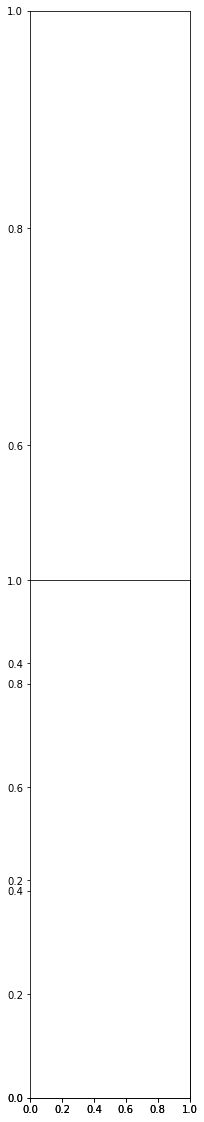

In [9]:
from scipy.stats import iqr

AOD_file=[MODIS_B17_file,MODIS_LM86_file,Lana_B17_file,MODIS_B17_CHEM3_file,MODIS_B17_SOCOL_file,Hulswar_B17_file]
labels=['MODIS_B17','MODIS_LM86','Lana_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','REV3_B17']
labelss=['MODIS_B17','MODIS_LM86','Lana_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','REV3_B17']

fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=0.1,wspace=0.2)#x=np.arange(40,70,5)


#clev=np.arange(0,0.15+0.01,0.01)
clev1=np.arange(-100,100+10,10)

w=4
n=1;r=3

# modis_djf=np.nanmean(MODIS_AOD[:,:,:,[11,0,1]],axis=(2,3,4))
# modis_djf_dotss=(MODIS_AOD[:,:,:,[11,0,1]])
# modis_djf_dots=modis_djf_dotss.transpose('year','month','day','lat','lon')
# modis_djf_dots=np.reshape(modis_djf_dots.data,(186,144,192))

# CDNC_Obs=xr.open_dataset('/home/ybh10/Observational_Data/CDNC/2003-2020_CDNC_Nd_All_UK_Grid.nc').Nd_all
# CDNC_obs=to_day_mon_yr(CDNC_Obs)[:,:,:,[11,0,1]]
# CDNC_obs_djf_dots=CDNC_obs.transpose('year','month','day','lat','lon')
# CDNC_djf=np.nanmean(CDNC_obs_djf_dots[:,:],axis=(0,1,2))
# CDNC_obs_djf_dots=np.reshape(CDNC_obs_djf_dots.data,(1674,144,192))

for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(1,len(AOD_file),i+1)
    ax2 = fig.add_subplot(2,len(AOD_file),i+len(AOD_file)+1)
    aod_data=xr.open_dataset(AOD_file[i]+'AOD.nc').__xarray_dataarray_variable__.data[:]
    cdnc_data=xr.open_dataset(AOD_file[i]+'CDNC.nc').__xarray_dataarray_variable__[:]
    if np.size(np.array(aod_data[0,0,:,0,0])) > 2:
        aod_data=aod_data[:,:,-2:,:,:]
    if np.size(np.array(cdnc_data.year)) > 2:
        cdnc_data=cdnc_data.sel(year=[2017,2018], drop=False)

    aod_plot_djf=np.nanmean(aod_data[:,:,:,[11,0,1]],axis=(2,3,4))
    cdnc_plot_djf=np.nanmean(cdnc_data[:,:,:,[11,0,1]],axis=(2,3,4))
    #aod_plot=np.nanmean(aod_data,axis=(2,3,4))
    aod_data_dotss=np.transpose(aod_data,(2,3,4,0,1))
    aod_data_dots=np.reshape(aod_data_dotss[:,[11,0,1]],(186,144,192))
    cdnc_data_dotss=np.transpose(cdnc_data.data,(2,3,4,0,1))
    cdnc_data_dots=np.reshape(cdnc_data_dotss[:,[11,0,1]],(186,144,192))

#    aod_plot_annual=np.transpose(aod_plot_annual,(2,0,1))
    #dots=find_diffs(aod_plot_annual,modis_annual,0)
    dots_djf=find_diffs(aod_data_dots,modis_djf_dots,0)

    cdnc_dots_djf=find_diffs(cdnc_data_dots,CDNC_obs_djf_dots,0)
    
    clevs = np.arange(-0.1,0.1+0.025,0.025)
    #mean_map=modis-aod_plot
    djf_mean_map=aod_plot_djf-modis_djf

    map_ax1 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                             resolution ='l',ax=ax1)
    lonmesh,latmesh  = np.meshgrid(lons,lats)
    x, y = map_ax1(lonmesh,latmesh) 
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    map_ax1.fillcontinents(color='gray')
    vari=blank_space(djf_mean_map,-.0125,.0125)

    css=map_ax1.contourf(x, y,vari,clevs,cmap='coolwarm',extend='both')# alpha=1,vmin=0,)##cmap=plt.cm.get_cmap('coolwarm',10))#,ticks = np.arange(0,26+2,2))
    
    data1= modis_djf[23:40]; data2 = aod_plot_djf[23:40]
    mask1 = np.isnan(data1); mask2 = np.isnan(data2)
    rms = sqrt(mean_squared_error(data1[~mask1],data2[~mask1]))
        
    ax1.set_title('{},\n RMSE = {:.3f}'.format(labelss[i],rms),fontsize=12)
    
    map_ax2 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                             resolution ='l',ax=ax2)
    lonmesh,latmesh  = np.meshgrid(lons,lats)
    x, y = map_ax1(lonmesh,latmesh) 
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax2.drawcoastlines()
    map_ax2.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15)  
    map_ax2.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    map_ax2.fillcontinents(color='gray')
    djf_mean_map=cdnc_plot_djf-CDNC_djf
    #end
    vari=blank_space(djf_mean_map,-5,5)

    cs1=map_ax2.contourf(x, y,vari,clev1,cmap='coolwarm',extend='both')# alpha=1,vmin=0,)##cmap=plt.cm.get_cmap('coolwarm',10))#,ticks = np.arange(0,26+2,2))

    data1= CDNC_djf[23:40]; data2 = cdnc_plot_djf[23:40]
    mask1 = np.isnan(data1); mask2 = np.isnan(data2)
    rms = sqrt(mean_squared_error(data1[~mask1],data2[~mask1]))
    
    ax2.set_title('{}, \nRMSE = {:.3f}'.format(labelss[i],rms),fontsize=12)
    
    [m,n] = np.where(cdnc_dots_djf==1)
    z1 = np.zeros(cdnc_dots_djf.shape)
    z1[m,n]=99
    cs4 = map_ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)

#ax1.text(47000000,-20000000,'Annual Median (MODIS minus MODEL)',fontsize=16)
#plt.suptitle('DJF Median (MODIS minus MODEL)',fontsize=16, y=0.51)

cax = fig.add_axes([0.08, 0.4, 0.88, 0.033])# Left, Bottom, Width, Height
cbar=fig.colorbar(css,cax=cax,extend='both',orientation='horizontal')#,ticks = np.arange(0,26+2,2))
cbar.ax.tick_params(labelsize=15); cbar.set_label('AOD',fontsize=15)

cax = fig.add_axes([0.08, 0.2, 0.88, 0.033])# Left, Bottom, Width, Height
cbar=fig.colorbar(cs1,cax=cax,extend='both',orientation='horizontal')#,ticks = np.arange(0,26+2,2))
cbar.ax.tick_params(labelsize=15); cbar.set_label('CDNC',fontsize=15)



#plt.show()
#plt.savefig("/home/ybh10/Objective_3/Plots/First_Ideas/AOD_Spatial_Spatial.png",dpi=300,bbox_inches = 'tight')


In [ ]:
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
file_type='MODIS_B17'
run_length='Years'

year=np.arange(2017,2019,1) 
dates=[]
for y in (year):
    for m in (months):
        dates.append('{}{}'.format(y,m))
AOD_file=[MODIS_B17_file,CAMS6_file,MODIS_LM86_file,MODIS_B17_CHEM_file]
labels=['UK_B17','CAMS6','UK_LM86','CHEM3']
fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=0.15, wspace=0.37)#x=np.arange(40,70,5)
n=1;r=3
for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(4,1,i+1)
    aod_data=xr.open_dataset(AOD_file[i]+'AOD.nc').__xarray_dataarray_variable__.data[23:40]
    if np.size(np.array(aod_data[0,0,:,0,0])) > 2:
        aod_data=aod_data[:,:,-2:,:,:]
    aod_plot=np.nanmean(aod_data,axis=(2,4))
    aod_plot_std=np.nanstd(aod_data,axis=(1,2,4))
    MODIS=np.nanmean(MODIS_AOD[23:40,:,:],axis=(2,4))
    MODIS_std=np.nanstd(MODIS_AOD[23:40,:,:],axis=(1,2,4))
    a=find_diffs(aod_plot,MODIS,1)
    clevs = np.arange(-0.1,0.1+0.025,0.025)
    datas=MODIS_AOD[23:40]-aod_data
    datas_aod=np.nanmean(datas,axis=(1,2,4))
 #   datas_aod=datas_aod.transpose(1,0)
    ax1.grid(linestyle='--',alpha=1)
    ax1.set_ylabel('Latitude',fontsize=20)
   # ax1.set_xlabel('Year',fontsize=20)

    y_labels = ['60S','50S','40S']
    y=np.arange(-60,-30,10)
# x=np.arange(1950,2015,10)    
    cs = ax1.contourf(months,lats[23:40],datas_aod,clevs,cmap='coolwarm',extend='both')
    ax1.set_xticks(months); ax1.set_xticklabels(months,fontsize=15)
    ax1.set_yticks(y); ax1.set_yticklabels(y_labels,fontsize=15)
    plt.colorbar(cs)
    
    
    dot=np.array(a[:,:])
    #dot=dot.transpose(1,0)
    [m,n] = np.where(dot==1)
    z1 = np.zeros(dot.shape)
    z1[m,n]=99


   # cs3 = ax1.contourf(months,lats[23:40], z1, 1, hatches=['', '..'], alpha=0)
#plt.savefig("/home/ybh10/Objective_3/Plots/First_Ideas/Zonal_AOD_Comparison.png",dpi=300,bbox_inches = 'tight')


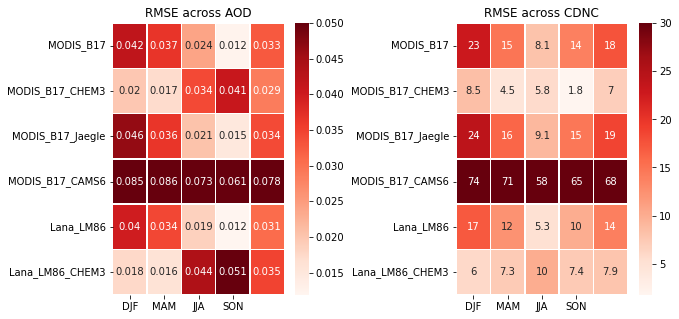

In [194]:

RMSE=[]
from math import sqrt
from sklearn.metrics import mean_squared_error
AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_Jaegle_file,CAMS6_file,Lana_file,Lana_LM86_CHEM_file]
labels=['MODIS_B17','CHEM3','MODIS_B17_Jaegle','CAMS6','Lana_LM86','Lana_LM86_CHEM3']
labelss=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_Jaegle','MODIS_B17_CAMS6','Lana_LM86','Lana_LM86_CHEM3']
season=['DJF','MAM','JJA','SON']
#labelss=['MODIS_B17','MODIS_B17_CAMS6','MODIS_B17_CHEM3','Lana_LM86','Lana_LM86_CHEM3']

#labels=['MODIS_B17','CAMS6','CHEM3','MODIS_LM86']#,'Lana_LM86','Lana_W14','MODIS_W14']

# mask1 = np.isnan(MODIS_Clim)#; mask2 = np.isnan(modis_sh)

# data1= MODIS_Clim; data2 = Chem2_aod ; data3 = medusa; data4 = REF_aod
# #rms_lana = sqrt(mean_squared_error(data1[~mask1],data2[~mask1]))
# modis_aod=xr.open_dataset('/home/ybh10/Observational_Data/MODIS/AOD/Daily_2017_2018/UK_Grid/AOD_Raw.nc').MYD08_D3_6_1_Aerosol_Optical_Depth_Land_Ocean_Mean
# modis_aod.groupby('time.season')

# MODIS_AOD_1=MODIS_AOD[23:40]
# Modis = [MODIS_AOD_1[:,:,:,[11,0,1]],MODIS_AOD_1[:,:,:,[2,3,4]],MODIS_AOD_1[:,:,:,[5,6,7]],MODIS_AOD_1[:,:,:,[8,9,10]]]

# #modis= np.reshape((Modis),(4,607104))
# modis=np.nanmean(Modis,axis=(5))
# #modis= np.reshape((modis),(4,6))
# modis= np.reshape((modis),(4,19584))

# modis_aod=np.load('/home/ybh10/Objective_3/Postprocess_Data/MODEL_AOD/Area_Weighted_AOD/MODIS_AOD_Areaweight.npy')
# modis_season=[modis_aod[:,[11,0,1]],modis_aod[:,[2,3,4]],modis_aod[:,[5,6,7]],modis_aod[:,[8,9,10]]]
# modiss = np.nanmean((modis_season[:]),axis=(1,2,3))
# modis= np.reshape((modiss),(4,6))

Modis = [modis_areaweight_global[[11,0,1]],modis_areaweight_global[[2,3,4]],modis_areaweight_global[[5,6,7]],modis_areaweight_global[[8,9,10]]]
Modis=np.array(Modis)

GROS = [GROS_AREAWEIGHT_MEAN_Global[[11,0,1]],GROS_AREAWEIGHT_MEAN_Global[[2,3,4]],GROS_AREAWEIGHT_MEAN_Global[[5,6,7]],GROS_AREAWEIGHT_MEAN_Global[[8,9,10]]]
GROS=np.array(GROS)


rms=np.zeros((len(AOD_file),5)); rms[:]=np.nan
rms_cdnc=np.zeros((len(AOD_file),5)); rms_cdnc[:]=np.nan

aod=np.zeros((len(AOD_file),2,12,31)); aod[:] = np.nan
cdnc=np.zeros((len(AOD_file),2,12,31)); cdnc[:] = np.nan

for i in range(0,len(AOD_file)):
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/MODEL_AOD/Area_Weighted_AOD/{}_Global.npy'.format(labels[i]))
    aod[i]=((aod_data))
    cdnc_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/CDNC/{}_Global.npy'.format(labels[i]))
    cdnc[i]=((cdnc_data))

for i in range(0,len(AOD_file)):
    aod_data_season=[aod[i,:,[11,0,1]],aod[i,:,[2,3,4]],aod[i,:,[5,6,7]],aod[i,:,[8,9,10]]]
    aod_data_season=np.array(aod_data_season)
    b = np.nanmedian((aod_data_season[:]),axis=(2,3))
    cdnc_annual=np.nanmean(cdnc[i],axis=(0,2))

    cndc_data_season=[cdnc[i,:,[11,0,1]],cdnc[i,:,[2,3,4]],cdnc[i,:,[5,6,7]],cdnc[i,:,[8,9,10]]]
    cndc_data_season=np.array(cndc_data_season)
    cd = np.nanmedian((cndc_data_season[:]),axis=(2,3))
    aod_annual=np.nanmean(aod[i],axis=(0,2))

    for s in range(0,4):
        data1= b[s]; data2 = Modis[s]
        mask1 = np.isnan(data1); mask2 = np.isnan(data2)
        rms[i,s] = sqrt(mean_squared_error(data1[~mask2],data2[~mask2]))
        
        data1= cd[s]; data2 = GROS[s]
        mask1 = np.isnan(data1); mask2 = np.isnan(data2)
        rms_cdnc[i,s] = sqrt(mean_squared_error(data1[~mask2],data2[~mask2]))
    rms[i,4] = sqrt(mean_squared_error(aod_annual,modis_areaweight_global))
    rms_cdnc[i,4] = sqrt(mean_squared_error(cdnc_annual,GROS_AREAWEIGHT_MEAN_Global))

        
fig = plt.figure(figsize=(10,5), edgecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plt.subplots_adjust(wspace=0.6)#x=np.arange(40,70,5)
levels = np.linspace(0, 0.09, 10)
for i in range(0,1):
    #ax = fig.add_subplot(3,1,1)


    
    g=sns.heatmap(rms, cmap="Reds",  annot=True, linewidths=.5, xticklabels=season, yticklabels=labelss,ax=ax1,vmax=0.05)#,center=0.035)
    #plt.xticks(rotation=45)
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    d=sns.heatmap(rms_cdnc, cmap="Reds", annot=True, linewidths=.5, xticklabels=season, yticklabels=labelss,ax=ax2,vmax=30)#center=20)
    d.set_yticklabels(d.get_yticklabels(), rotation=0)

    # Add a title and labels for the axes
    ax1.set_title('RMSE across AOD')
    ax2.set_title('RMSE across CDNC')

#     plt.xlabel('Season')
#     plt.ylabel('Label')
    # clevs=np.arange(-1,1.1,0.1)

#plt.show()
#plt.savefig("/home/ybh10/Objective_3/Plots/First_Ideas/Heat_Map_Global.png",dpi=300,bbox_inches = 'tight')


In [ ]:
from scipy.stats import iqr
AOD_file=[MODIS_B17_file,Lana_B17_file,MODIS_B17_CHEM_file,MODIS_LM86_file,MODIS_B17_SOCOL_file,REV3_B17_file,MODIS_W14_file]
labels=['MODIS_B17','Lana_B17','CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14']
labelss=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14']

fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=0.2)#x=np.arange(40,70,5)
ax1 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,1)
# ax4 = fig.add_subplot(4,1,4)

#MODIS_AOD_av=np.load('/home/ybh10/Objective_3/Postprocess_Data//MODEL_AOD/Area_Weighted_AOD/MODIS_AOD_Areaweight.npy')
colourss=['aqua','lime','teal','blue','lightblue','orange','cornflowerblue']
clev=np.arange(0,0.15+0.01,0.01)
w=4
for i in range(0,len(AOD_file)):
    aod_data=xr.open_dataset(AOD_file[i]+'ALL_SKY_OUTGOING_SW_FLUX_TOA.nc').toa_outgoing_shortwave_flux[:40]
    if np.size(np.array(aod_data[0,0,:,0,0])) > 2:
        aod_data=aod_data[:,:,-2:,:,:]
    #aod_data=aod_data.transpose('year','month','day','latitude','longitude')
    aod_djf=aod_data[:,:,:].data    
    aod_plot=np.nanmean(aod_djf[:,:,:,[0,1,11]],axis=(1,2,3,4))
    
    aod_plot_all=np.nanmean(aod_djf[:,:,:],axis=(1,2,3,4))
        
    ax1.plot(lats[:40],aod_plot,color=colourss[i],linewidth=w,label=labelss[i])
    ax3.plot(lats[:40],aod_plot_all,color=colourss[i],linewidth=w,label=labelss[i])

###### Grovsenor CDNC #######
sw_obs=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
sw_OBS=sw_obs.groupby('time.season').mean()
sw_djf_ob=sw_OBS[0]
sw_all_ob=sw_OBS[:]
sw=np.nanmean(sw_djf_ob[:51],axis=(1)); sw_std=np.nanstd(sw_djf_ob[:51],axis=(1))
swall=np.nanmean(sw_all_ob[:,:51],axis=(0,2)); sw_allstd=np.nanstd(sw_all_ob[:,:51],axis=(0,2))

ax1.plot(modis_lat[:51],sw,color='black',linewidth=w,label='CERES_SW')
ax3.plot(modis_lat[:51],swall,color='black',linewidth=w,label='CERES_SW_Annual')

# ax1.fill_between(modis_lat[:51], MODIS-modis_uk_an_iqr,  MODIS+modis_uk_an_iqr,facecolor='black',alpha=0.3,)
# ax3.fill_between(modis_lat[:51],MODIS_an-modis_uk_iqr_an,  MODIS_an+modis_uk_iqr_an,facecolor='black',alpha=0.3,)


#ax1.plot(lats[23:40],MODISs,color='pink',label='MODIS')

#ax1.errorbar(lats[23:40],MODIS,yerr=MODIS_IQR,color='red',label='MODIS')
ax1.legend(loc='upper left',fontsize=14)
titles=['SW All Sky DJF Mean (latitudes)','Seasonal','SW All Sky Annual mean (latitudes)']
for ax,i in zip((ax1,ax2,ax3),range(0,3)):#,ax4):
    ax.set_ylabel('N$_d$',fontsize=15)
    #ax.set_ylabel(fontsize=15)
    ax.set_title(titles[i])
  #  ax.set_ylim(0.04,0.16)
ax1.set_xlabel('Latitude')
#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/SW_ALLSKY_Comparison.png",dpi=100,bbox_inches = 'tight')


In [ ]:
AOD_file=[Lana_file,MODIS_LM86_file,MODIS_B17_SOCOL_file]
labels=['Lana_LM86','MODIS_LM86','MODIS_B17_SOCOL']
labelss=['Lana_LM86','MODIS_LM86','MODIS_B17_SOCOL']

fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=0.2)#x=np.arange(40,70,5)
# ax4 = fig.add_subplot(4,1,4)
sw_obs=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406_UK_Grid.nc').toa_sw_all_mon
sw_OBS=sw_obs.groupby('time.season').mean()
sw_OBS=np.nanmean(sw_OBS,axis=0)

clevs=np.arange(-40,40+10,10)
for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(1,3,i+1)
    aod_data=xr.open_dataset(AOD_file[i]+'ALL_SKY_OUTGOING_SW_FLUX_TOA.nc').toa_outgoing_shortwave_flux[:]
    if np.size(np.array(aod_data[0,0,:,0,0])) > 2:
        aod_data=aod_data[:,:,-2:,:,:]
    #aod_data=aod_data.transpose('year','month','day','latitude','longitude')
#    aod_djf=np.nanmean(aod_data[:,:,:,[11,0,1]],axis=(2,3,4))    
    aod_djf=np.nanmean(aod_data[:,:,:],axis=(2,3,4))    
  #  sw_djf=aod_djf[]
    djf_mean_map=aod_djf-sw_OBS

    map_ax1 = Basemap(projection='spstere',boundinglat=-25, lon_0=0,
                             resolution ='l',ax=ax1)
    lonmesh,latmesh  = np.meshgrid(lons,lats)
    x, y = map_ax1(lonmesh,latmesh) 
    meridians = np.arange(0.,360,60.)    
    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    map_ax1.fillcontinents(color='gray')
    
    data1= sw_OBS[:40]; data2 = aod_djf[:40]
    mask1 = np.isnan(data1); mask2 = np.isnan(data2)
    rms = sqrt(mean_squared_error(data1[~mask2],data2[~mask2]))

    ax1.set_title('{} minus CERES, global rmse = {:.2f}'.format(labelss[i],rms),fontsize=15)
    vari=blank_space(djf_mean_map,-10,10)

    css=map_ax1.contourf(x, y,vari,clevs,cmap='coolwarm',extend='both')# alpha=1,vmin=0,)##cmap=plt.cm.get_cmap('coolwarm',10))#,ticks = np.arange(0,26+2,2))
cax = fig.add_axes([0.08, 0.3, 0.88, 0.033])# Left, Bottom, Width, Height
cbar=fig.colorbar(css,cax=cax,extend='both',orientation='horizontal')#,ticks = np.arange(0,26+2,2))
cbar.ax.tick_params(labelsize=15); cbar.set_label('SW anomaly (W m{})'.format('$^{-2}$'),fontsize=15)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/SW_Anoamly.png",dpi=100,bbox_inches = 'tight')


In [24]:
import iris.coord_categorisation as coord_cat

def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr
SIGMA = [1.59,1.59,1.4,2.0,1.59] # geometric standard devation of each mode

## Cut off radius to determine number concentrations
R_100 = 50e-9
R_70  = 35e-9
R_50  = 25e-9
R_30  = 15e-9
RHOP      = 1800.0 # density of aerosol ptcl of generic composition (assumed H2SO4) in kgm^-3 -- only used in calculating mmid
## Boltzmann constant (J/K)
ZBOLTZ = 1.3807e-23 #iris.coords.AuxCoord(1.3807e-23,long_name='boltzmann_constant',units='J-K^-1')
## Avagadro's constant (mol-1)
AVC = 6.023e+23 #iris.coords.AuxCoord(6.023e+23,long_name='avagadros constant',units='mol^-1')
## Universal gas constant of dry air (J/kg/K)
RD = 287.05 #iris.coords.AuxCoord(287.05, long_name='unviversal_gas_constant_dry_air',units='J-kg^-1-K^-1') 
P0_arr = 100000.0
## Specific heat capacity of dry air (cp) J/kg/K
CP = 1005.46
## Gravity
GG = 9.80665
sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
MM_AER    = 0.098  # assume aerosol is sulfate when calculating mmid


def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

def check_cube(cube_list):
    '''
    Check to see if cube has bounds and assigns them
    Also calculates area weights
    '''
    for icube,cube in enumerate(cube_list):
        ## Check to see if cube has bounds and if not assign some
        if not cube.coord('time').has_bounds(): 
            print('Cube does not have time bounds so guessing them')
            cube.coord('time').guess_bounds()
        if not (cube.coord('longitude').has_bounds() and cube.coord('latitude').has_bounds()):
            print('Cube does not have lat/lon bounds so guessing them')
            #cube.coord('time').guess_bounds()
            cube.coord('longitude').guess_bounds()
            cube.coord('latitude').guess_bounds()
        
        ## Assign monthly category so can perform meaning
        ## for cube in cubes_1_list_surf_out: 
        coord_cat.add_month(cube, 'time', name='month')
        coord_cat.add_year(cube, 'time', name='year')
        #print cube
        
        ## Define lat lon coordinate system for cube
        lat_lon_coord_system = iris.coord_systems.GeogCS(6371229)
        cube.coord('latitude').coord_system = lat_lon_coord_system
        cube.coord('longitude').coord_system = lat_lon_coord_system
             
    ## Calculate grid_areas for are weighting
    grid_areas = iris.analysis.cartography.area_weights(cube, normalize=False)

    return cube_list, grid_areas


def convert_num_den(air_den, data_in, mm_sp):

    '''
    convert aerosol mass mixing ratio into aerosol number concentration (molecules per cm-3)
    '''

    mm_da = (AVC * ZBOLTZ) / RD # molecular mass of dry air kg/mol (0.02897040968)

    ## Convert mmr into molecules per cm-3 of each component
    data_out = data_in * air_den * ( mm_da / mm_sp )
    
    return data_out

def calc_air_density(pot_temp, air_press):

    '''
    Calculate Air number Density (in cm-3)

    '''

    #act_temp = pot_temp * (air_press / P0) ** (RD / CP)  #use to calculate temperature profile
    #act_temp.rename('temperature') #assigns temperature to the long name of the cube
    # Use this for aair number densities (and aerosols)
    #rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06)) #calculate air number density for all levels and each month
    
    if isinstance(air_press, (np.ndarray)):

        ## For arrays: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0_arr) ** (RD / CP) )

    else:
        ## For cubes: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0) ** (RD / CP) )
    
    ## For Gas phase species
    #rho_air = air_press / (act_temp * RD)
    
    ## For aerosol components (air number density)
    rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06))
    
    #print(rho_air.data.mean(), rho_air.data.min(), rho_air.data.max())
    
    #print(np.mean(rho_air.data[:,:]))
    
    return rho_air, act_temp

def calc_fract_lt(tot_num, dry_rad_v, r_cutoff, sigma_mode, mode):

    '''
    Calculate fraction of aerosol volume distribution below specified cut-off
    diameter for each mode.

    '''

    print('Calculate fraction below {:.1f} nm diameter in {} mode'.format(r_cutoff*1e9*2.0,mode))

    ## Condition to perform calculation on mass above 0.0
    cond = np.greater(tot_num.data, 0.0)
    cond_lt = np.less_equal(tot_num.data, 0.0)
    ndmin_cond = np.where(cond)
    ndmin_cond_lt = np.where(cond_lt)

    total_to_r = do_initialize_arr(tot_num)
    frac_lt_diam = do_initialize_arr(tot_num)
    fract_mass_lt_out = tot_num.copy(data=None)
    frac_gt_diam = do_initialize_arr(tot_num)
    fract_mass_gt_out = tot_num.copy(data=None)
    
    ## This expression calculates the cumulative of a lognormal
    ## distribution up to radius "reference_radius"
    ## Takes the cumulative mass array, radius of interest,
    ## actual radius of mode,geometric std dev (width) of mode
    total_to_r[ndmin_cond] = (tot_num.data[ndmin_cond] / 2.0) * (1.0 + sp.special.erf(np.log(r_cutoff / dry_rad_v.data[ndmin_cond]) / np.sqrt(2.0 / np.log(sigma_mode))))

    ## Then calculate what fraction this is of the total
    ## (to find fraction of distribution below specified cutoff)
    frac_lt_diam[ndmin_cond] = total_to_r[ndmin_cond] / tot_num.data[ndmin_cond]
#    frac_gt_diam[ndmin_cond] = (tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]) / tot_num.data[ndmin_cond]
    frac_gt_diam[ndmin_cond] = tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]

    #print 'Min = {}'.format(np.min(frac_V_lt_diam)), 'Mean = {}'.format(np.mean(frac_V_lt_diam)), 'Max = {}'.format(np.max(frac_V_lt_diam))
    
    # points below minimum mass concentration are given default value and assumed to all be above cut-off
    frac_lt_diam[ndmin_cond_lt] = 1.0
    frac_gt_diam[ndmin_cond_lt] = 1.0
    
    # Put fractions back into a cube
    fract_mass_lt_out.data = frac_lt_diam
    fract_mass_gt_out.data = frac_gt_diam
    
    return fract_mass_lt_out, fract_mass_gt_out

# Get an array of grid box altitude heights in m
filename=('/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pe2018jan.pp')
constraint=iris.AttributeConstraint(STASH='m01s38i485')
cube = iris.load(filename,constraint)
test_cube = cube[0]

hgt_arr = test_cube.coord('level_height').points
print(test_cube.summary(shorten=True))

#hgt_arr = xr.open_dataset(MODIS_B17_SOCOL_file+'../Raw/DMS_Mass_Mixing_Ratio_2018jan.nc').level_height

## Add zero as starting height
hgt_arr_all = np.hstack((0.0, hgt_arr))

# Define the bounds for latitude and longitude
lat_values = test_cube.coord('latitude').points
lon_values = test_cube.coord('longitude').points

lat_bounds = [[lat_values[i] - 0.625, lat_values[i] + 0.625] for i in range(len(lat_values))]
lon_bounds = [[lon_values[i] - 1.875, lon_values[i] + 1.875] for i in range(len(lon_values))]

# Set the bounds for the latitude and longitude coordinates
test_cube.coord('latitude').bounds = lat_bounds
test_cube.coord('longitude').bounds = lon_bounds

area3d = iris.analysis.cartography.area_weights(test_cube, normalize=False)
area2d = area3d[0, :, :]

## Calculate dz array (height of individual grid boxes)
dz_arr  = np.zeros(hgt_arr.shape)
vol_box = np.zeros(area3d[:, :, :].shape)

## Calculate height of each grid box and volume of grid boxes
for ilev, lev in enumerate(hgt_arr):
    dz_arr[ilev]      = hgt_arr_all[ilev+1] - hgt_arr_all[ilev]
    vol_box[ilev, :, :] = area2d[:, :] * dz_arr[ilev]
    
grid_box_vol = copy.deepcopy(vol_box)
print(grid_box_vol.shape  )
    
volumes = vol_box[0,:, :]

print('Finished Calculating Grid Box Volume')



modes=['nucleation_sol','aitken_sol','accumulation_sol','coarse_sol','aitken_insol']
particle='DRY_PARTICLE_DIAMETER'
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']

Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol']

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']


mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']

nmodes=np.size(modes)




filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
constraint_temp='m01s00i004'
constraint_pres='m01s00i408'
pot_temp=iris.load_cubes(filename,constraint_temp)
pot_press=iris.load_cubes(filename,constraint_pres)
cubes_1_list_out, grid_areas = check_cube(pot_temp)
cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)

P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')
air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])
end
##airdensy = pot_press[0]/(k_B*pot_temp[0])


# data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
# #data_num=convert_num_den(airden.data,number_vol,MM_AER)
# #data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

# mass_concentration = number_vol * air_num_den.data[0,23:40]
# number_concentration = mass_concentration / (MM_AER * AVC)
# number_concentration_cm3 = number_concentration * 1e-6





fig=plt.figure()
ax=fig.add_subplot(111)

sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']
end
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file,
          MODIS_B17_GEOS_CHEM_file,MODIS_B17_GFDL_file,MODIS_B17_MIROC_file]
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
        'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']
col=['aqua','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']


AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']


formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr_accumulated=np.zeros((5, 50)); total_dndlr_accumulated[:]=np.nan
total_dndlr_accumulated_ca=np.zeros((5, 50)); total_dndlr_accumulated_ca[:]=np.nan
test_CA=np.zeros((5, 50)); test_CA[:]=np.nan

total_dndlr=np.zeros((len(labels), 50)); total_dndlr[:]=np.nan
total_dndlr_CA=np.zeros((len(labels), 50)); total_dndlr_CA[:]=np.nan
testing_CA=np.zeros((len(labels), 50)); testing_CA[:]=np.nan

#total_dndlr_CA 
for file in range(0,len(labels)):
#     if file == 4:
#         end

    for i in range(0,len(modes)):
        radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]]/2
       # radius = radius.sel(latitude=slice(-61, -40))
        radius = radius.sel(model_level_number=1).mean('time')

      #  number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],modes[i]))[stash_mode[i]]
        number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]]

      #  number = number.sel(latitude=slice(-61, -40))
        number = number.sel(model_level_number=1).mean('time')
#        number=convert_num_den(air_num_den[0].data,number,MM_AER)

        number = number * air_num_den.data[0]

        #number=xr.open_dataset('{}/../Raw/{}_2017jan.nc'.format(MODIS_B17_NORESM_file,mode_try[i]))[stash_mode_try[i]][0,23:40]
     #   end
        temp=xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/Surface_Temp.nc').air_temperature[:,:]
        pres=xr.open_dataset('{}/{}.nc'.format(MODIS_B17_CHEM_file,'PRESSURE_MEAN_SL')).air_pressure_at_sea_level[:,:]/100 #convert to hPa
        pres=pres.mean('time')
        temp=temp.mean('time')

#       #  end
#         R =  8.314 #J/mol/K
#         #k =  1.38e-23 # m2 kg s-2 K-1 
#         #avc = 6.022e23 #Avogadro's number

#     #Calculate the number density of air molecules in m-3
#         k_B = 1.38e-25 #m3 hPa K-1 molec-1

#     #    airdens = pres/(k_B*temp)
#         airdens = pres/(R*temp)

        #airdens=4.004

        # Calculate dry-radius grid for binned-modes
        #
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns

        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m


#      #   nuc_m3 = number * airdensy.data[0]
#         nuc_m3 = number * airdens

#         nuc_m3_aw = areaweight(nuc_m3,lats[:])
#         nuc_rbardry_aw = areaweight(radius,lats[:])

        nuc_dndlr = np.zeros((50),np.float64)
        ndbin_mode = np.zeros((50),np.float64)
        ca_nuc_dndlr = np.zeros((50),np.float64)


        num_co = areaweight(number,lats[:])
        rad_co = areaweight(radius,lats[:])

        vol_nd      = np.sum(
            num_co * volumes / np.sum(volumes))
        vol_bar      = np.sum(
            rad_co * volumes / np.sum(volumes))


        for ibin in range(0,50):
            nuc_dndlr[ibin]=lognormal_dNdlogr(num_co,dryr_mid[ibin],rad_co,sigma[i])

            ca_nuc_dndlr[ibin]=lognormal_dNdlogr(vol_nd,dryr_mid[ibin],vol_bar,sigma[i]) # Catherines

#             ndbin_mode[ibin]  = ca_nuc_dndlr[ibin] * deltar[ibin] / 2.303 / dryr_mid[ibin] # Catherines




        total_dndlr_accumulated[i]=nuc_dndlr
        total_dndlr_accumulated_ca[i]=ca_nuc_dndlr
#         test_CA[i]=ndbin_mode


    total_dndlr[file,:]=np.sum(total_dndlr_accumulated,axis=0)
    total_dndlr_CA[file,:]=np.sum(total_dndlr_accumulated_ca,axis=0)
#     testing_CA[file,:]=np.sum(test_CA,axis=0)

    # ## CATHERINES
    # #rad_microm = dryr_mid*1e9
    # rad_microm = dryr_mid*1e9

    # radtoplot = np.log10(rad_microm)

    # end

        #dNdlnR_tot=
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    #djf=(total_dndlr[file])
    djf=(total_dndlr_CA[file])#*1e-6)

#    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    plt.plot(radtoplot, djf,color=col[file],linewidth=2,label=labels[file])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)')
    ax.set_xlabel('Dry radius ($\mu$m)')
    
plt.legend(loc='lower centre')
#ax.set_xscale('log')

#end
# djf = np.mean(np.stack((dNdlnR_tot[:,11],dNdlnR_tot[:,0],dNdlnR_tot[:,1]),1),1)*1e-6

# djf_r = np.mean(np.stack((dNdlnR_tot[:,11],dNdlnR_tot[:,0],dNdlnR_tot[:,1]),1),1)*1e-6*(rad_microm**3)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/dNlogr_DJF_Global_CHEMISTRY.png",dpi=100,bbox_inches = 'tight')


    


m01s38i485 / (unknown)              (model_level_number: 85; latitude: 144; longitude: 192)
(85, 144, 192)
Finished Calculating Grid Box Volume
Cube does not have lat/lon bounds so guessing them
Cube does not have lat/lon bounds so guessing them


NameError: name 'end' is not defined

m01s38i485 / (unknown)              (model_level_number: 85; latitude: 144; longitude: 192)
(85, 144, 192)
Finished Calculating Grid Box Volume


NameError: name 'end' is not defined

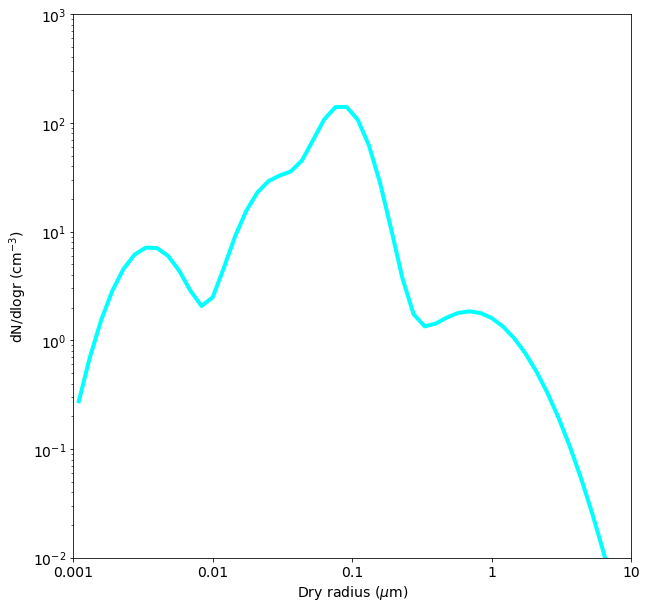

In [180]:
def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

# Get an array of grid box altitude heights in m
# filename=('/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pe2018jan.pp')
# constraint=iris.AttributeConstraint(STASH='m01s38i485')
# cube = iris.load(filename,constraint)
test_cube = cube[0]

hgt_arr = test_cube.coord('level_height').points
print(test_cube.summary(shorten=True))

#hgt_arr = xr.open_dataset(MODIS_B17_SOCOL_file+'../Raw/DMS_Mass_Mixing_Ratio_2018jan.nc').level_height

## Add zero as starting height
hgt_arr_all = np.hstack((0.0, hgt_arr))

# Define the bounds for latitude and longitude
lat_values = test_cube.coord('latitude').points
lon_values = test_cube.coord('longitude').points

lat_bounds = [[lat_values[i] - 0.625, lat_values[i] + 0.625] for i in range(len(lat_values))]
lon_bounds = [[lon_values[i] - 1.875, lon_values[i] + 1.875] for i in range(len(lon_values))]

# Set the bounds for the latitude and longitude coordinates
test_cube.coord('latitude').bounds = lat_bounds
test_cube.coord('longitude').bounds = lon_bounds

area3d = iris.analysis.cartography.area_weights(test_cube, normalize=False)
area2d = area3d[0, :, :]

## Calculate dz array (height of individual grid boxes)
dz_arr  = np.zeros(hgt_arr.shape)
vol_box = np.zeros(area3d[:, :, :].shape)

## Calculate height of each grid box and volume of grid boxes
for ilev, lev in enumerate(hgt_arr):
    dz_arr[ilev]      = hgt_arr_all[ilev+1] - hgt_arr_all[ilev]
    vol_box[ilev, :, :] = area2d[:, :] * dz_arr[ilev]
    
grid_box_vol = copy.deepcopy(vol_box)
print(grid_box_vol.shape  )
    
volumes = vol_box[0,23:40, :]

print('Finished Calculating Grid Box Volume')



modes=['nucleation_sol','aitken_sol','accumulation_sol','coarse_sol','aitken_insol']
particle='DRY_PARTICLE_DIAMETER'
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']

Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol']

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']


mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']

nmodes=np.size(modes)




filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
constraint_temp='m01s00i004'
constraint_pres='m01s00i408'
pot_temp=iris.load_cubes(filename,constraint_temp)
pot_press=iris.load_cubes(filename,constraint_pres)
cubes_1_list_out, grid_areas = check_cube(pot_temp)
cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)

P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')
air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])
end
# airdensy = pot_press[0]/(k_B*pot_temp[0])


# data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
# #data_num=convert_num_den(airden.data,number_vol,MM_AER)
# #data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

# mass_concentration = number_vol * air_num_den.data[0,23:40]
# number_concentration = mass_concentration / (MM_AER * AVC)
# number_concentration_cm3 = number_concentration * 1e-6





#fig=plt.figure()
fig = plt.figure(figsize=(10,10), edgecolor='w')

ax=fig.add_subplot(111)

sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']


AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr_accumulated=np.zeros((5, 50)); total_dndlr_accumulated[:]=np.nan
total_dndlr_accumulated_ca=np.zeros((5, 50)); total_dndlr_accumulated_ca[:]=np.nan
test_CA=np.zeros((5, 50)); test_CA[:]=np.nan

total_dndlr=np.zeros((len(labels), 50)); total_dndlr[:]=np.nan
total_dndlr_CA=np.zeros((len(labels), 50)); total_dndlr_CA[:]=np.nan
testing_CA=np.zeros((len(labels), 50)); testing_CA[:]=np.nan

for file in range(0,len(labels)):
#     if file == 4:
#         end

    for i in range(0,len(modes)):
        radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]]/2
        radius = radius.sel(latitude=slice(-61, -40))
       # print(np.shape(radius))
        radius = radius.sel(model_level_number=1).mean('time')
        

      #  number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],modes[i]))[stash_mode[i]]
        number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]]

        number = number.sel(latitude=slice(-61, -40))
        number = number.sel(model_level_number=1).mean('time')
     #   number=convert_num_den(air_num_den[0,23:40].data,number,MM_AER)

        number = number * (air_num_den.data[0,23:40])

        #number=xr.open_dataset('{}/../Raw/{}_2017jan.nc'.format(MODIS_B17_NORESM_file,mode_try[i]))[stash_mode_try[i]][0,23:40]
     #   end
        temp=xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/Surface_Temp.nc').air_temperature[:,23:40]
        pres=xr.open_dataset('{}/{}.nc'.format(MODIS_B17_CHEM_file,'PRESSURE_MEAN_SL')).air_pressure_at_sea_level[:,23:40]/100 #convert to hPa
        pres=pres.mean('time')
        temp=temp.mean('time')

#       #  end
#         R =  8.314 #J/mol/K
#         #k =  1.38e-23 # m2 kg s-2 K-1 
#         #avc = 6.022e23 #Avogadro's number

#     #Calculate the number density of air molecules in m-3
#         k_B = 1.38e-25 #m3 hPa K-1 molec-1

        airdens = pres/(k_B*temp)
       # airdens = pres/(R*temp)

        #airdens=4.004

        # Calculate dry-radius grid for binned-modes
        #
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns

        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)
        
        dryr_mids=np.zeros((npts),np.float64)
        deltars=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m
            
        for n in range(0,npts):
            dryr_mids[n] = 10.0**(0.5 * (np.log10(dryr_int[n+1]) + np.log10(dryr_int[n]))) #in m
            deltars[n] = dryr_int[n+1]-dryr_int[n] #in m


#      #   nuc_m3 = number * airdensy.data[0]
      #  number = number * airdens

#         nuc_m3_aw = areaweight(nuc_m3,lats[:])
#         nuc_rbardry_aw = areaweight(radius,lats[:])

        nuc_dndlr = np.zeros((50),np.float64)
        ndbin_mode = np.zeros((50),np.float64)
        ca_nuc_dndlr = np.zeros((50),np.float64)


        num_co = areaweight(number,lats[23:40])
        rad_co = areaweight(radius,lats[23:40])

        vol_nd      = np.sum(
            num_co * volumes / np.sum(volumes))
        vol_bar      = np.sum(
            rad_co * volumes / np.sum(volumes))


        for ibin in range(0,50):
            nuc_dndlr[ibin]=lognormal_dNdlogr(num_co,dryr_mid[ibin],rad_co,sigma[i])

            ca_nuc_dndlr[ibin]=lognormal_dNdlogr(vol_nd,dryr_mid[ibin],vol_bar,sigma[i]) # Catherines

            ndbin_mode[ibin]  = ca_nuc_dndlr[ibin] * deltar[ibin] / 2.303 / dryr_mid[ibin] # Catherines




        total_dndlr_accumulated[i]=nuc_dndlr
        total_dndlr_accumulated_ca[i]=ca_nuc_dndlr
        test_CA[i]=ndbin_mode


    total_dndlr[file,:]=np.sum(total_dndlr_accumulated,axis=0)
    total_dndlr_CA[file,:]=np.sum(total_dndlr_accumulated_ca,axis=0)
    testing_CA[file,:]=np.sum(test_CA,axis=0)

    # ## CATHERINES
    #rad_microm = dryr_mid*1e9


    # end

        #dNdlnR_tot=
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(total_dndlr[file])
    #djf=(total_dndlr_CA[file])*1e-6

#    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[file],linewidth=4,label=labels[file])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 1000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    end
plt.legend(loc='lower center',fontsize=19)
#end
#ax.set_xscale('log')

#end
# djf = np.mean(np.stack((dNdlnR_tot[:,11],dNdlnR_tot[:,0],dNdlnR_tot[:,1]),1),1)*1e-6

# djf_r = np.mean(np.stack((dNdlnR_tot[:,11],dNdlnR_tot[:,0],dNdlnR_tot[:,1]),1),1)*1e-6*(rad_microm**3)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/dNlogr_DJF_SO_CHEMISTRY.png",dpi=100,bbox_inches = 'tight')



In [ ]:
def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

# Get an array of grid box altitude heights in m
# filename=('/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pe2018jan.pp')
# constraint=iris.AttributeConstraint(STASH='m01s38i485')
# cube = iris.load(filename,constraint)
# test_cube = cube[0]

# hgt_arr = test_cube.coord('level_height').points
# print(test_cube.summary(shorten=True))

# #hgt_arr = xr.open_dataset(MODIS_B17_SOCOL_file+'../Raw/DMS_Mass_Mixing_Ratio_2018jan.nc').level_height

# ## Add zero as starting height
# hgt_arr_all = np.hstack((0.0, hgt_arr))

# # Define the bounds for latitude and longitude
# lat_values = test_cube.coord('latitude').points
# lon_values = test_cube.coord('longitude').points

# lat_bounds = [[lat_values[i] - 0.625, lat_values[i] + 0.625] for i in range(len(lat_values))]
# lon_bounds = [[lon_values[i] - 1.875, lon_values[i] + 1.875] for i in range(len(lon_values))]

# # Set the bounds for the latitude and longitude coordinates
# test_cube.coord('latitude').bounds = lat_bounds
# test_cube.coord('longitude').bounds = lon_bounds

# area3d = iris.analysis.cartography.area_weights(test_cube, normalize=False)
# area2d = area3d[0, :, :]

# ## Calculate dz array (height of individual grid boxes)
# dz_arr  = np.zeros(hgt_arr.shape)
# vol_box = np.zeros(area3d[:, :, :].shape)

# ## Calculate height of each grid box and volume of grid boxes
# for ilev, lev in enumerate(hgt_arr):
#     dz_arr[ilev]      = hgt_arr_all[ilev+1] - hgt_arr_all[ilev]
#     vol_box[ilev, :, :] = area2d[:, :] * dz_arr[ilev]
    
# grid_box_vol = copy.deepcopy(vol_box)
# print(grid_box_vol.shape  )
    
volumes = vol_box[0:16,23:40, :]

print('Finished Calculating Grid Box Volume')



modes=['nucleation_sol','aitken_sol','accumulation_sol','coarse_sol','aitken_insol']
particle='DRY_PARTICLE_DIAMETER'
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']

Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol']

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']


mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']

nmodes=np.size(modes)




# filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
# constraint_temp='m01s00i004'
# constraint_pres='m01s00i408'
# pot_temp=iris.load_cubes(filename,constraint_temp)
# pot_press=iris.load_cubes(filename,constraint_pres)
# cubes_1_list_out, grid_areas = check_cube(pot_temp)
# cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)

# P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')
# air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])

# airdensy = pot_press[0]/(k_B*pot_temp[0])


# data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
# #data_num=convert_num_den(airden.data,number_vol,MM_AER)
# #data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

# mass_concentration = number_vol * air_num_den.data[0,23:40]
# number_concentration = mass_concentration / (MM_AER * AVC)
# number_concentration_cm3 = number_concentration * 1e-6





#fig=plt.figure()
fig = plt.figure(figsize=(10,10), edgecolor='w')

ax=fig.add_subplot(111)

sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']


AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr_accumulated=np.zeros((16,5, 50)); total_dndlr_accumulated[:]=np.nan
# total_dndlr_accumulated_ca=np.zeros((5, 50)); total_dndlr_accumulated_ca[:]=np.nan
# test_CA=np.zeros((5, 50)); test_CA[:]=np.nan
total_dndlr_accum=np.zeros((len(labels),16,5, 50)); total_dndlr_accumulated[:]=np.nan

total_dndlr=np.zeros((len(labels),16,50)); total_dndlr[:]=np.nan
# total_dndlr_CA=np.zeros((len(labels), 50)); total_dndlr_CA[:]=np.nan
# testing_CA=np.zeros((len(labels), 50)); testing_CA[:]=np.nan

hgt_arr = xr.open_dataset(MODIS_B17_SOCOL_file+'../Raw/DMS_Mass_Mixing_Ratio_2018jan.nc').level_height
heights=hgt_arr[:16]

for file in range(0,len(labels)):
#     if file == 4:
#         end

    for i in range(0,len(modes)):
        radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]]/2
        radius = radius.sel(latitude=slice(-61, -40))
       # print(np.shape(radius))
        radius = radius.mean('time')
        

      #  number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],modes[i]))[stash_mode[i]]
        number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]]

        number = number.sel(latitude=slice(-61, -40))
        number = number.mean('time')
     #   number=convert_num_den(air_num_den[0,23:40].data,number,MM_AER)

        number = number * (air_num_den.data[0:16,23:40])

        #
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns

        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m


#      #   nuc_m3 = number * airdensy.data[0]
      #  number = number * airdens

#         nuc_m3_aw = areaweight(nuc_m3,lats[:])
#         nuc_rbardry_aw = areaweight(radius,lats[:])

        nuc_dndlr = np.zeros((16,50),np.float64)
        ndbin_mode = np.zeros((50),np.float64)
        ca_nuc_dndlr = np.zeros((50),np.float64)


        num_co = areaweight(number,lats[23:40])
        rad_co = areaweight(radius,lats[23:40])

#         vol_nd      = np.sum(
#             num_co * volumes / np.sum(volumes))
#         vol_bar      = np.sum(
#             rad_co * volumes / np.sum(volumes))

        for le in range(0,16):
            for ibin in range(0,50):
                nuc_dndlr[le,ibin]=lognormal_dNdlogr(num_co[le],dryr_mid[ibin],rad_co[le],sigma[i])

#             ca_nuc_dndlr[ibin]=lognormal_dNdlogr(vol_nd,dryr_mid[ibin],vol_bar,sigma[i]) # Catherines

#             ndbin_mode[ibin]  = ca_nuc_dndlr[ibin] * deltar[ibin] / 2.303 / dryr_mid[ibin] # Catherines




        total_dndlr_accumulated[:,i]=nuc_dndlr
#         total_dndlr_accumulated_ca[i]=ca_nuc_dndlr
#         test_CA[i]=ndbin_mode
    print(labels[file])
    total_dndlr_accum[file,:,:,:]=(total_dndlr_accumulated)

    total_dndlr[file,:,:]=np.sum(total_dndlr_accumulated,axis=(1))
    
#     rad_microm = dryr_mid*1e6
#     radtoplot = np.log10(rad_microm)

#     djf=(total_dndlr[file])
#     #djf=(total_dndlr_CA[file])*1e-6

# #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

#     ax.plot(djf,heights,color=colourss[file],linewidth=4,label=labels[file])
# #     ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
# #     ax.set_xticks([-3,-2,-1,0,1])
# #     ax.set_xticklabels([0.001,0.01,0.1,1,10])
#     #ax.set_xticklabels([0.001,0.01,0.1,1,10])

#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     # #ax.set_xlim(1, 10000)
#    # ax.set_ylim(0.01, 1000)
#     ax.xaxis.set_tick_params(labelsize=14)
#     ax.yaxis.set_tick_params(labelsize=14)


#     ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
#     ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    
# plt.legend(loc='lower center',fontsize=19)
#end
#ax.set_xscale('log')

#end

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/dNlogr_DJF_SO_CHEMISTRY.png",dpi=100,bbox_inches = 'tight')



m01s38i485 / (unknown)              (model_level_number: 85; latitude: 144; longitude: 192)
(85, 144, 192)
Finished Calculating Grid Box Volume
(252, 16, 17, 192) DRY_PARTICLE_DIAMETER_nucleation_sol
(252, 16, 17, 192) DRY_PARTICLE_DIAMETER_aitken_sol
(252, 16, 17, 192) DRY_PARTICLE_DIAMETER_accumulation_sol
(252, 16, 17, 192) DRY_PARTICLE_DIAMETER_coarse_sol
(252, 16, 17, 192) DRY_PARTICLE_DIAMETER_aitken_insol


NameError: name 'end' is not defined

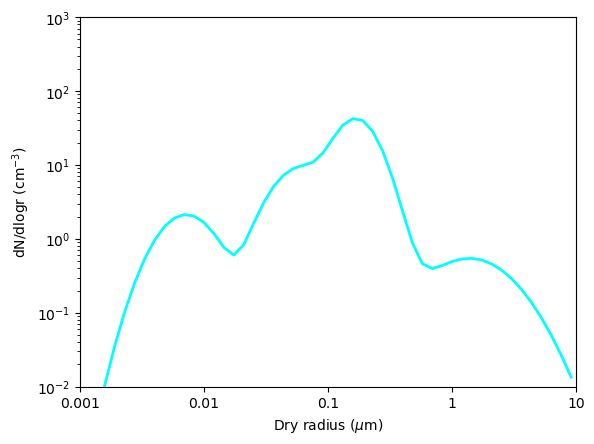

In [584]:
def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

# Get an array of grid box altitude heights in m
# filename=('/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pe2018jan.pp')
# constraint=iris.AttributeConstraint(STASH='m01s38i485')
# cube = iris.load(filename,constraint)
test_cube = cube[0]

hgt_arr = test_cube.coord('level_height').points
print(test_cube.summary(shorten=True))

#hgt_arr = xr.open_dataset(MODIS_B17_SOCOL_file+'../Raw/DMS_Mass_Mixing_Ratio_2018jan.nc').level_height

## Add zero as starting height
hgt_arr_all = np.hstack((0.0, hgt_arr))

# Define the bounds for latitude and longitude
lat_values = test_cube.coord('latitude').points
lon_values = test_cube.coord('longitude').points

lat_bounds = [[lat_values[i] - 0.625, lat_values[i] + 0.625] for i in range(len(lat_values))]
lon_bounds = [[lon_values[i] - 1.875, lon_values[i] + 1.875] for i in range(len(lon_values))]

# Set the bounds for the latitude and longitude coordinates
test_cube.coord('latitude').bounds = lat_bounds
test_cube.coord('longitude').bounds = lon_bounds

area3d = iris.analysis.cartography.area_weights(test_cube, normalize=False)
area2d = area3d[0, :, :]

## Calculate dz array (height of individual grid boxes)
dz_arr  = np.zeros(hgt_arr.shape)
vol_box = np.zeros(area3d[:, :, :].shape)

## Calculate height of each grid box and volume of grid boxes
for ilev, lev in enumerate(hgt_arr):
    dz_arr[ilev]      = hgt_arr_all[ilev+1] - hgt_arr_all[ilev]
    vol_box[ilev, :, :] = area2d[:, :] * dz_arr[ilev]
    
grid_box_vol = copy.deepcopy(vol_box)
print(grid_box_vol.shape  )
    
volumes = vol_box[0,:, :]

print('Finished Calculating Grid Box Volume')



modes=['nucleation_sol','aitken_sol','accumulation_sol','coarse_sol','aitken_insol']
particle='DRY_PARTICLE_DIAMETER'
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']

Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol']

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']


mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']

nmodes=np.size(modes)




filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
constraint_temp='m01s00i004'
constraint_pres='m01s00i408'
pot_temp=iris.load_cubes(filename,constraint_temp)
pot_press=iris.load_cubes(filename,constraint_pres)
cubes_1_list_out, grid_areas = check_cube(pot_temp)
cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)

P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')
air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])
end
# airdensy = pot_press[0]/(k_B*pot_temp[0])


# data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
# #data_num=convert_num_den(airden.data,number_vol,MM_AER)
# #data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

# mass_concentration = number_vol * air_num_den.data[0,23:40]
# number_concentration = mass_concentration / (MM_AER * AVC)
# number_concentration_cm3 = number_concentration * 1e-6

airdens = pot_press[0]/(k_B*pot_temp[0])
air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])

#data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)




fig=plt.figure()
ax=fig.add_subplot(111)

sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']

AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file,
          MODIS_B17_GEOS_CHEM_file,MODIS_B17_GFDL_file,MODIS_B17_MIROC_file]
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
        'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']
col=['aqua','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']

formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr_accumulated=np.zeros((5, 50)); total_dndlr_accumulated[:]=np.nan
total_dndlr_accumulated_ca=np.zeros((5, 50)); total_dndlr_accumulated_ca[:]=np.nan
test_CA=np.zeros((5, 50)); test_CA[:]=np.nan

total_dndlr=np.zeros((len(labels), 50)); total_dndlr[:]=np.nan
total_dndlr_CA=np.zeros((len(labels), 50)); total_dndlr_CA[:]=np.nan
testing_CA=np.zeros((len(labels), 50)); testing_CA[:]=np.nan

for file in range(0,len(labels)):
#     if file == 4:
#         end

    for i in range(0,len(modes)):
        radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]]
        radius = radius.sel(latitude=slice(-61, -40))
        print(np.shape(radius),Diameter[i])
        radius = radius.sel(model_level_number=1).mean('time')
        

      #  number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],modes[i]))[stash_mode[i]]
        #number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]]
#         number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]].mean('time')[0,23:40]
#         print(np.shape(mode_try[i]),stash_mode_try[i])

# #         number = number.sel(latitude=slice(-61, -40))
# #         number = number.sel(model_level_number=1).mean('time')
#         number=convert_num_den(air_num_den[0,23:40].data,number,MM_AER)
        number=data_num[file,i]
    
        #end
   #     number = number * (air_num_den.data[0,23:40])

        #number=xr.open_dataset('{}/../Raw/{}_2017jan.nc'.format(MODIS_B17_NORESM_file,mode_try[i]))[stash_mode_try[i]][0,23:40]
     #   end
#         temp=xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/Surface_Temp.nc').air_temperature[:,23:40]
#         pres=xr.open_dataset('{}/{}.nc'.format(MODIS_B17_CHEM_file,'PRESSURE_MEAN_SL')).air_pressure_at_sea_level[:,23:40]/100 #convert to hPa
#         pres=pres.mean('time')
#         temp=temp.mean('time')

#       #  end
#         R =  8.314 #J/mol/K
#         #k =  1.38e-23 # m2 kg s-2 K-1 
#         #avc = 6.022e23 #Avogadro's number

#     #Calculate the number density of air molecules in m-3
#         k_B = 1.38e-25 #m3 hPa K-1 molec-1

 #       airdens = pres/(k_B*temp)
        airdens = pres/(R*temp)

        #airdens=4.004

        # Calculate dry-radius grid for binned-modes
        #
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns

        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m


#      #   nuc_m3 = number * airdensy.data[0]
      #  number = number * airdens

#         nuc_m3_aw = areaweight(nuc_m3,lats[:])
#         nuc_rbardry_aw = areaweight(radius,lats[:])

        nuc_dndlr = np.zeros((50),np.float64)
        ndbin_mode = np.zeros((50),np.float64)
        ca_nuc_dndlr = np.zeros((50),np.float64)


        num_co = areaweight(number,lats[23:40])
        rad_co = areaweight(radius,lats[23:40])

        vol_nd      = np.sum(
            num_co * volumes / np.sum(volumes))
        vol_bar      = np.sum(
            rad_co * volumes / np.sum(volumes))


        for ibin in range(0,50):
            nuc_dndlr[ibin]=lognormal_dNdlogr(num_co,dryr_mid[ibin],rad_co,sigma[i])

            ca_nuc_dndlr[ibin]=lognormal_dNdlogr(vol_nd,dryr_mid[ibin],vol_bar,sigma[i]) # Catherines

            ndbin_mode[ibin]  = ca_nuc_dndlr[ibin] * deltar[ibin] / 2.303 / dryr_mid[ibin] # Catherines




        total_dndlr_accumulated[i]=nuc_dndlr
        total_dndlr_accumulated_ca[i]=ca_nuc_dndlr
        test_CA[i]=ndbin_mode


    total_dndlr[file,:]=np.sum(total_dndlr_accumulated,axis=0)
    total_dndlr_CA[file,:]=np.sum(total_dndlr_accumulated_ca,axis=0)
    testing_CA[file,:]=np.sum(test_CA,axis=0)

    # ## CATHERINES
    #rad_microm = dryr_mid*1e9


    # end

        #dNdlnR_tot=
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(total_dndlr[file])#*1e-6
    #djf=(total_dndlr_CA[file])*1e-6

#    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    plt.plot(radtoplot, djf,color=col[file],linewidth=2,label=labels[file])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 1000)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)')
    ax.set_xlabel('Dry radius ($\mu$m)')
    end
plt.legend(loc='lower center')
#end
#ax.set_xscale('log')

#end
# djf = np.mean(np.stack((dNdlnR_tot[:,11],dNdlnR_tot[:,0],dNdlnR_tot[:,1]),1),1)*1e-6

# djf_r = np.mean(np.stack((dNdlnR_tot[:,11],dNdlnR_tot[:,0],dNdlnR_tot[:,1]),1),1)*1e-6*(rad_microm**3)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/dNlogr_DJF_SO_CHEMISTRY.png",dpi=100,bbox_inches = 'tight')



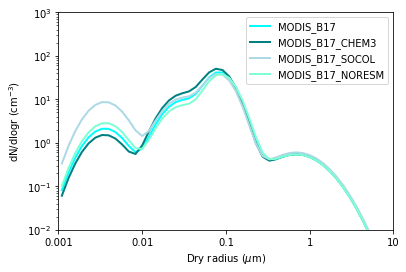

In [44]:
import iris.coord_categorisation as coord_cat
mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']
AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']
Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol']
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405']

SIGMA = [1.59,1.59,1.4,2.0,1.59] # geometric standard devation of each mode

## Cut off radius to determine number concentrations
R_100 = 50e-9
R_70  = 35e-9
R_50  = 25e-9
R_30  = 15e-9
RHOP      = 1800.0 # density of aerosol ptcl of generic composition (assumed H2SO4) in kgm^-3 -- only used in calculating mmid
## Boltzmann constant (J/K)
ZBOLTZ = 1.3807e-23 #iris.coords.AuxCoord(1.3807e-23,long_name='boltzmann_constant',units='J-K^-1')
## Avagadro's constant (mol-1)
AVC = 6.023e+23 #iris.coords.AuxCoord(6.023e+23,long_name='avagadros constant',units='mol^-1')
## Universal gas constant of dry air (J/kg/K)
RD = 287.05 #iris.coords.AuxCoord(287.05, long_name='unviversal_gas_constant_dry_air',units='J-kg^-1-K^-1') 
P0_arr = 100000.0
## Specific heat capacity of dry air (cp) J/kg/K
CP = 1005.46
## Gravity
GG = 9.80665
sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
MM_AER    = 0.098  # assume aerosol is sulfate when calculating mmid


def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

def check_cube(cube_list):
    '''
    Check to see if cube has bounds and assigns them
    Also calculates area weights
    '''
    for icube,cube in enumerate(cube_list):
        ## Check to see if cube has bounds and if not assign some
        if not cube.coord('time').has_bounds(): 
            print('Cube does not have time bounds so guessing them')
            cube.coord('time').guess_bounds()
        if not (cube.coord('longitude').has_bounds() and cube.coord('latitude').has_bounds()):
            print('Cube does not have lat/lon bounds so guessing them')
            #cube.coord('time').guess_bounds()
            cube.coord('longitude').guess_bounds()
            cube.coord('latitude').guess_bounds()
        
        ## Assign monthly category so can perform meaning
        ## for cube in cubes_1_list_surf_out: 
        coord_cat.add_month(cube, 'time', name='month')
        coord_cat.add_year(cube, 'time', name='year')
        #print cube
        
        ## Define lat lon coordinate system for cube
        lat_lon_coord_system = iris.coord_systems.GeogCS(6371229)
        cube.coord('latitude').coord_system = lat_lon_coord_system
        cube.coord('longitude').coord_system = lat_lon_coord_system
             
    ## Calculate grid_areas for are weighting
    grid_areas = iris.analysis.cartography.area_weights(cube, normalize=False)

    return cube_list, grid_areas


def convert_num_den(air_den, data_in, mm_sp):

    '''
    convert aerosol mass mixing ratio into aerosol number concentration (molecules per cm-3)
    '''

    mm_da = (AVC * ZBOLTZ) / RD # molecular mass of dry air kg/mol (0.02897040968)

    ## Convert mmr into molecules per cm-3 of each component
    data_out = data_in * air_den * ( mm_da / mm_sp )
    
    return data_out

def calc_air_density(pot_temp, air_press):

    '''
    Calculate Air number Density (in cm-3)

    '''

    #act_temp = pot_temp * (air_press / P0) ** (RD / CP)  #use to calculate temperature profile
    #act_temp.rename('temperature') #assigns temperature to the long name of the cube
    # Use this for aair number densities (and aerosols)
    #rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06)) #calculate air number density for all levels and each month
    
    if isinstance(air_press, (np.ndarray)):

        ## For arrays: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0_arr) ** (RD / CP) )

    else:
        ## For cubes: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0) ** (RD / CP) )
    
    ## For Gas phase species
    #rho_air = air_press / (act_temp * RD)
    
    ## For aerosol components (air number density)
    rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06))
    
    #print(rho_air.data.mean(), rho_air.data.min(), rho_air.data.max())
    
    #print(np.mean(rho_air.data[:,:]))
    
    return rho_air, act_temp

def calc_fract_lt(tot_num, dry_rad_v, r_cutoff, sigma_mode, mode):

    '''
    Calculate fraction of aerosol volume distribution below specified cut-off
    diameter for each mode.

    '''

    print('Calculate fraction below {:.1f} nm diameter in {} mode'.format(r_cutoff*1e9*2.0,mode))

    ## Condition to perform calculation on mass above 0.0
    cond = np.greater(tot_num.data, 0.0)
    cond_lt = np.less_equal(tot_num.data, 0.0)
    ndmin_cond = np.where(cond)
    ndmin_cond_lt = np.where(cond_lt)

    total_to_r = do_initialize_arr(tot_num)
    frac_lt_diam = do_initialize_arr(tot_num)
    fract_mass_lt_out = tot_num.copy(data=None)
    frac_gt_diam = do_initialize_arr(tot_num)
    fract_mass_gt_out = tot_num.copy(data=None)
    
    ## This expression calculates the cumulative of a lognormal
    ## distribution up to radius "reference_radius"
    ## Takes the cumulative mass array, radius of interest,
    ## actual radius of mode,geometric std dev (width) of mode
    total_to_r[ndmin_cond] = (tot_num.data[ndmin_cond] / 2.0) * (1.0 + sp.special.erf(np.log(r_cutoff / dry_rad_v.data[ndmin_cond]) / np.sqrt(2.0 / np.log(sigma_mode))))

    ## Then calculate what fraction this is of the total
    ## (to find fraction of distribution below specified cutoff)
    frac_lt_diam[ndmin_cond] = total_to_r[ndmin_cond] / tot_num.data[ndmin_cond]
#    frac_gt_diam[ndmin_cond] = (tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]) / tot_num.data[ndmin_cond]
    frac_gt_diam[ndmin_cond] = tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]

    #print 'Min = {}'.format(np.min(frac_V_lt_diam)), 'Mean = {}'.format(np.mean(frac_V_lt_diam)), 'Max = {}'.format(np.max(frac_V_lt_diam))
    
    # points below minimum mass concentration are given default value and assumed to all be above cut-off
    frac_lt_diam[ndmin_cond_lt] = 1.0
    frac_gt_diam[ndmin_cond_lt] = 1.0
    
    # Put fractions back into a cube
    fract_mass_lt_out.data = frac_lt_diam
    fract_mass_gt_out.data = frac_gt_diam
    
    return fract_mass_lt_out, fract_mass_gt_out
filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
constraint_temp='m01s00i004'
constraint_pres='m01s00i408'
# pot_temp=iris.load_cubes(filename,constraint_temp)
# pot_press=iris.load_cubes(filename,constraint_pres)
P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')

# cubes_1_list_out, grid_areas = check_cube(pot_temp)
# cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)



# air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])
# grid_areas = iris.analysis.cartography.area_weights(pot_temp[0],
#                                                         normalize=False)

# number_vol=np.zeros((4, 5, 17, 192)); number_vol[:]=np.nan
# for file in range(0,len(labels)):
#     for i in range(0,len(mode_try)):
#         number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]].mean('time')[0,23:40]
#         number_vol[file,i]=number
number_vol=np.load('/home/ybh10/Objective_3/Postprocess_Data/CHEM_NUM_Conc/number_volume.npy')
#num_tot=np.sum(number_vol,axis=1)
#num_tot_mn = num_tot * air_num_den[0,23:40].data[0]

k_B = 1.38e-25 #m3 hPa K-1 molec-1

airdens = pot_press[0]/(k_B*pot_temp[0])
air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])
grid_areas = iris.analysis.cartography.area_weights(pot_temp[0],
                                                        normalize=False)

data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
#data_num=convert_num_den(airden.data,number_vol,MM_AER)
#data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

mass_concentration = number_vol * air_num_den.data[0,23:40]
number_concentration = mass_concentration / (MM_AER * AVC)
number_concentration_cm3 = number_concentration * 1e-6





col=['aqua','teal','lightblue','aquamarine']
fig=plt.figure()
ax=fig.add_subplot(111)

total_dndlr_accumulated=np.zeros((5, 50)); total_dndlr_accumulated[:]=np.nan
total_dndlr_accumulated_ca=np.zeros((5, 50)); total_dndlr_accumulated_ca[:]=np.nan
test_CA=np.zeros((5, 50)); test_CA[:]=np.nan

total_dndlr=np.zeros((4, 50)); total_dndlr[:]=np.nan
total_dndlr_CA=np.zeros((4, 50)); total_dndlr_CA[:]=np.nan
testing_CA=np.zeros((4, 50)); testing_CA[:]=np.nan

for file in range(0,len(labels)):
    for i in range(0,len(mode_try)):
        if file == 0:
            radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]][0,23:40]/2
        else:
            radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]][0,0,23:40]/2
        number = data_num[file,i]
        temp=xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/Surface_Temp.nc').air_temperature[0,23:40]
        pres=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],'PRESSURE_MEAN_SL')).air_pressure_at_sea_level[:,23:40]/100 #convert to hPa
        pres=pres.mean('time')
        #airden = pres/(k_B*temp)
        number=data_num[file,i]
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns
        
        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m
            
   #     nuc_m3 = number * airdens.data[0,23:40]
      #  nuc_m3 = number * airden
        #nuc_m3 = number * air_num_den[0,23:40].data[0]
        nuc_m3_aw = areaweight(number,lats[23:40])
        nuc_rbardry_aw = areaweight(radius,lats[23:40])
        nuc_dndlr = np.zeros((50),np.float64)
        ndbin_mode = np.zeros((50),np.float64)
        ca_nuc_dndlr = np.zeros((50),np.float64)
    
        for ibin in range(0,50):
            nuc_dndlr[ibin]=lognormal_dNdlogr(nuc_m3_aw,dryr_mid[ibin],nuc_rbardry_aw,sigma[i])
            
        total_dndlr_accumulated_ca[i]=nuc_dndlr
    
    total_dndlr_CA[file,:]=np.sum(total_dndlr_accumulated_ca,axis=0)

    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(total_dndlr_CA[file])#*1e1)
    #djf=(total_dndlr)
    plt.plot(radtoplot, djf,color=col[file],linewidth=2,label=labels[file])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 1000)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)')
    ax.set_xlabel('Dry radius ($\mu$m)')
plt.legend()

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/dNdlogr_CHEM.png",dpi=300,bbox_inches = 'tight')


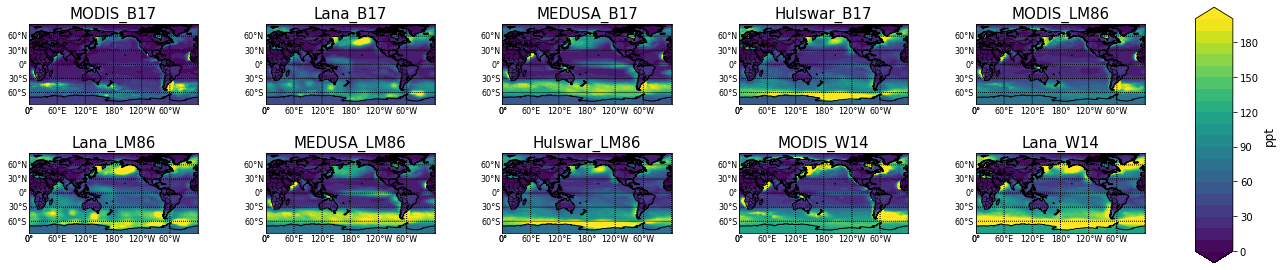

# GLOBAL #

In [73]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
#
#
#                                              GLOBAL IMPACTS                                                          #
#
#
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################

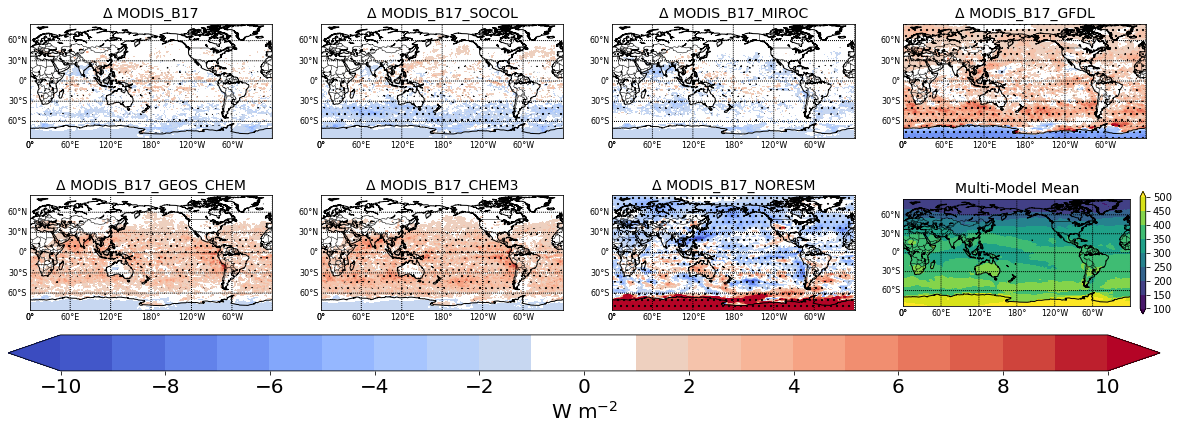

In [80]:
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]

rf=np.zeros((len(labels))); rf[:] = np.nan
aod=[]
for i in range(0,(len(labels))):
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
    rf[i]=np.nanmean(rf_cl[:]) 
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    aod.append(aod_data.data)
aod_total=np.nanmean(np.array(aod),axis=0)
aod_total_std=np.nanstd(np.array(aod),axis=0)

fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=-0.7)#x=np.arange(40,70,5)
clevs=np.arange(-10,10+1,1)

coolwarm_dataset = plt.cm.coolwarm(np.linspace(0, 1, 128))
coolwarm_dataset[60:68, :] = 1.0  # Set centre values from index 120 to 136 as white
coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_dataset)

xa,ya  = np.meshgrid(lons,lats)

# Create the colorm
for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(4,4,i+1)
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    diff=aod_data-aod_total
    dots=np.zeros((144,192))
    dots=xr.where(abs(diff[:]) > aod_total_std[:],-999,999)

    map_ax1 = Basemap(llcrnrlon=0.,llcrnrlat=-85,urcrnrlon=360.,urcrnrlat=85,
                    projection='cyl',resolution ='c',ax=ax1)

    x, y = map_ax1(xa,ya) 

  #  x, y = map_ax1(lons,lats) 
    lonpt, latpt = map_ax1(x,y,inverse=True)
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawcountries()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)
    
    cs1=map_ax1.contourf(x,y,diff,clevs,extend='both',cmap=coolwarm_whites)

    ax1.set_title("\u0394 {}".format(labels[i]),fontsize=14)
    #cbar=fig.colorbar(cs, ax=ax1)
    [m,n] = np.where(dots==-999)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    cs3 = ax1.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    if i == 6:
        ax1 = fig.add_subplot(4,4,i+2)
        clevs2=np.arange(100,500+50,50)

        map_ax1 = Basemap(llcrnrlon=0.,llcrnrlat=-85,urcrnrlon=360.,urcrnrlat=85,
                        projection='cyl',resolution ='c',ax=ax1)
        lonpt, latpt = map_ax1(x,y,inverse=True)
        meridians = np.arange(0.,360,60.)    
        parallels = np.arange(-90.,90,30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
        map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
        map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)

       # cs=map_ax1.contourf(x,y,aod_total,extend='both',cmap='viridis')
        cs=ax1.contourf(x,y,aod_total,clevs2,extend='both',cmap='viridis')

        ax1.set_title("Multi-Model Mean",fontsize=14)
        cbar=fig.colorbar(cs,fraction=0.023, pad=0.04)

        
#cax = fig.add_axes([0.3, 0.4, 0.76, 0.05]) # Left, Bottom, Width, Height
cax = fig.add_axes([0.11, 0.48, 0.8, 0.025])

#cbar=fig.colorbar(cs,fraction=0.046, pad=0.04)
cbar=fig.colorbar(cs1, cax=cax,extend='both',orientation='horizontal',ticks = np.arange(-10,10+1,2))
cbar.set_label('{}'.format('W m$^{-2}$'),fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Radiative_Effects_CHEM.png",dpi=300,bbox_inches = 'tight')


In [ ]:

rf=np.zeros((len(labels))); rf[:] = np.nan
aod=[]
for i in range(0,(len(labels))):
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/{}.npy'.format(labels[i]))
    rf[i]=np.nanmean(rf_cl[:]) 
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    aod.append(aod_data.data)
aod_total=np.nanmean(np.array(aod),axis=0)
aod_total_std=np.nanstd(np.array(aod),axis=0)

fig = plt.figure(figsize=(20,20), edgecolor='w')
plt.subplots_adjust(hspace=-0.7)#x=np.arange(40,70,5)
clevs=np.arange(-10,10+1,1)

coolwarm_dataset = plt.cm.coolwarm(np.linspace(0, 1, 128))
coolwarm_dataset[60:68, :] = 1.0  # Set centre values from index 120 to 136 as white
coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_dataset)

xa,ya  = np.meshgrid(lons,lats)

# Create the colorm
for i in range(0,len(AOD_file)):
    ax1 = fig.add_subplot(4,4,i+1)
    aod_data=xr.open_dataset(AOD_file[i]+'All_Sky_RF.nc').__xarray_dataarray_variable__.mean('time')[:]
    diff=aod_data-aod_total
    dots=np.zeros((144,192))
    dots=xr.where(abs(diff[:]) > aod_total_std[:],-999,999)

    map_ax1 = Basemap(llcrnrlon=0.,llcrnrlat=-85,urcrnrlon=360.,urcrnrlat=85,
                    projection='cyl',resolution ='c',ax=ax1)

    x, y = map_ax1(xa,ya) 

  #  x, y = map_ax1(lons,lats) 
    lonpt, latpt = map_ax1(x,y,inverse=True)
    meridians = np.arange(0.,360,60.)    
    parallels = np.arange(-90.,90,30.)
    map_ax1.drawcoastlines()
    map_ax1.drawcountries()
    map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
    map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)
    
    cs1=map_ax1.contourf(x,y,diff,clevs,extend='both',cmap=coolwarm_whites)

    ax1.set_title("\u0394 {}".format(labels[i]),fontsize=14)
    #cbar=fig.colorbar(cs, ax=ax1)
    [m,n] = np.where(dots==-999)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    cs3 = ax1.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    if i == 6:
        ax1 = fig.add_subplot(4,4,i+2)
        clevs2=np.arange(100,500+50,50)

        map_ax1 = Basemap(llcrnrlon=0.,llcrnrlat=-85,urcrnrlon=360.,urcrnrlat=85,
                        projection='cyl',resolution ='c',ax=ax1)
        lonpt, latpt = map_ax1(x,y,inverse=True)
        meridians = np.arange(0.,360,60.)    
        parallels = np.arange(-90.,90,30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
        map_ax1.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8)  
        map_ax1.drawparallels(parallels,labels=[1,0,0,0],fontsize=8)

       # cs=map_ax1.contourf(x,y,aod_total,extend='both',cmap='viridis')
        cs=ax1.contourf(x,y,aod_total,clevs2,extend='both',cmap='viridis')

        ax1.set_title("Multi-Model Mean",fontsize=14)
        cbar=fig.colorbar(cs,fraction=0.023, pad=0.04)

        
#cax = fig.add_axes([0.3, 0.4, 0.76, 0.05]) # Left, Bottom, Width, Height
cax = fig.add_axes([0.11, 0.48, 0.8, 0.025])

#cbar=fig.colorbar(cs,fraction=0.046, pad=0.04)
cbar=fig.colorbar(cs1, cax=cax,extend='both',orientation='horizontal',ticks = np.arange(-10,10+1,2))
cbar.set_label('{}'.format('W m$^{-2}$'),fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Radiative_Effects_CHEM.png",dpi=300,bbox_inches = 'tight')


In [40]:
kg_to_gg=(1e12)
kg_to_tg=(1e9)

def variable_global(titles):
    if titles=='Total_H2SO4_load' !=-1:
        var='m01s38i520'
        clevs_diff=np.arange(-1,1+.1,.1) # 
        clevs_mean=np.arange(0,5+.5,.5) # 
        num=1e6
        unit='mg m$^{-2}$'
        unit_var='mg m$^{-2}$'
        variable='SO4'
        MODEL_HEIGHT=1
        tick=np.arange(-1,1+.5,.5)
        tick_2=np.arange(0,5+1,1) # 
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white

    if titles=='SO2_MASS_MIXING_RATIO'!=-1:
        var='mass_fraction_of_sulfur_dioxide_in_air'
        clevs_diff=np.arange(-100,100+10,10) # 
        clevs_mean=np.arange(0,200+10,10) # 
        num=so2_ppt
        unit='SO$_{2}$ ppt'
        unit_var='ppt'
        variable='SO2'
        MODEL_HEIGHT=1
        tick=np.arange(-100,100+10,40)
        tick_2=np.arange(0,200+40,40)
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='DMS_Mass_Mixing_Ratio'!=-1:
        var='mass_fraction_of_dimethyl_sulfide_in_air'
        clevs_diff=np.arange(-100,100+10,10) # 
        clevs_mean=np.arange(0,200+10,10) # 
        num=(kg_to_gg)*(32.065/62.13)
        unit='DMS ppt'
        unit_var='ppt'
        variable='DMS'
        MODEL_HEIGHT=1
        tick=np.arange(-100,100+10,40)
        tick_2=np.arange(0,200+10,40)
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='CDNC'!=-1:
        var='__xarray_dataarray_variable__'
        clevs_mean=np.arange(0,200+20,20) 
        clevs_diff=np.arange(-40,40+4,4) # 
        num=1
        unit='N$_{d}$ (cm$^{-3}$)'
        unit_var='cm$^{-3}$'
        variable='CDNC'
        MODEL_HEIGHT=1
        tick=np.arange(-40,40+10,10) # 
        tick_2=np.arange(0,200+10,40) 
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='ccn_concentration_25r'!=-1:
        var='m01s38i439'
        MODEL_HEIGHT=10
        clevs_mean=np.arange(0,750+50,50) 
        clevs_diff=np.arange(-200,200+20,20) # 
        num=1
        unit='N$_{50}$ (cm$^{-3}$)'
        unit_var='cm$^{-3}$'
        variable='CCN'
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[116:140, :] = 1.0  # Set values from index 128 to 384 as white
        tick=np.arange(-200,200+20,100) # 
        tick_2=np.arange(0,750+50,250) 

    if titles=='AOD'!=-1:
        var='__xarray_dataarray_variable__'
        MODEL_HEIGHT=1
        clevs_mean=np.arange(0,0.2+.01,.01) 
        clevs_diff=np.arange(-0.1,.1+.01,.01) # 
        num=1
        unit='AOD (550 nm)'
        unit_var=''
        variable='AOD'
        tick=np.arange(-0.1,0.1+.05,.05) # 
        tick_2=np.arange(0,0.2+0.05,0.05) 
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='H2SO4_aerosol'!=-1:
        var='m01s38i485'
        MODEL_HEIGHT=1
        clevs_mean=np.arange(0,0.005+.001,.001) *1e5
        clevs_diff=np.arange(-0.005,.005+.001,.001)*1e5 # 
        num=h2so4_ppt*1e5
        unit='H$_{2}$SO$^{4}$ (ppt)'
        unit_var='ppt'
        variable='AOD'
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[115:151, :] = 1.0  # Set values from index 128 to 384 as white
        tick=np.arange(-0.005,.005+.005,.005)*1e5
        tick_2=np.arange(0,0.005+.0025,.0025) *1e5
        
    if titles=='H2SO4_AOD'!=-1:
        var='mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air'
        MODEL_HEIGHT=1
        clevs_mean=np.arange(0,0.03+.005,.005) 
        clevs_diff=np.arange(-0.005,.005+.001,.001) # 
        num=h2so4_ppt
        unit='H$_{2}$SO$^{4}$ (ppt)'
        unit_var='ppt'
        variable='H2SO4_AOD'
        tick=np.arange(-0.005,.005+.005,.005)
        tick_2=np.arange(0,0.03+.01,.01) 
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[110:146, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='H2SO4_Mass_Mixing_Ratio'!=-1:
        var='mass_fraction_of_sulfuric_acid_in_air'
        MODEL_HEIGHT=1
        clevs_mean=np.arange(-0.005,.005+.0005,.0005) # 
        clevs_diff=np.arange(-0.005,.005+.0005,.0005) # 
        num=h2so4_ppt
        unit='H$_{2}$SO$^{4}$ (ppt)'
        unit_var='ppt'
        variable='AOD'
        tick=clevs_diff
        tick_2=clevs_mean
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='Clear_Sky_RF'!=-1:
        var='__xarray_dataarray_variable__'
        MODEL_HEIGHT=1
        clevs=np.arange(-8,8+.5,.5) # 
        num=1
        unit='W m$^{-2}$'
        unit_var='W m$^{-2}$'
        variable='Clear_Sky'
        tick_2=clevs_mean
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[120:136, :] = 1.0  # Set values from index 128 to 384 as white


    if titles=='All_Sky_RF'!=-1:
        var='__xarray_dataarray_variable__'
        MODEL_HEIGHT=1
        clevs_mean=np.arange(300,400+5,5) 
        clevs_std=np.arange(0,100+5,5) 
        clevs_diff=np.arange(-5,5+1,1) # 
        num=1
        unit='W m$^{-2}$'
        unit_var='W m$^{-2}$'
        variable='All_Sky'
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[110:146, :] = 1.0  # Set values from index 128 to 384 as white
        tick=np.arange(-5,5+1,2.5)
        tick_2=np.arange(300,400+10,20) 
        
    if titles=='ALL_SKY_OUTGOING_SW_FLUX_TOA'!=-1:
        var='toa_outgoing_shortwave_flux'
        MODEL_HEIGHT=1
        clevs_mean=np.arange(0,150+10,10) 
        clevs_diff=np.arange(-5,5+1,1) # 
        num=1
        unit='W m$^{-2}$'
        unit_var='W m$^{-2}$'
        variable='SW'
        coolwarm_data = plt.cm.coolwarm(np.linspace(0, 1, 256))
        coolwarm_data[110:146, :] = 1.0  # Set values from index 128 to 384 as white
        tick=np.arange(-5,5+1,2.5)
        tick_2=np.arange(0,150+10,50) 
        
    if titles=='O3_Mass_Mixing_Ratio'!=-1:
        var='mass_fraction_of_ozone_in_air'
        MODEL_HEIGHT=1
        clevs=np.arange(-8,8+.5,.5) # 
        num=o3_ppb/10
        unit='O$_{2}$ (ppm)'
        unit_var='ppm'
        variable='O3'
    return var, clevs_diff, clevs_mean, num, unit, unit_var, variable, MODEL_HEIGHT, tick, tick_2,coolwarm_data 

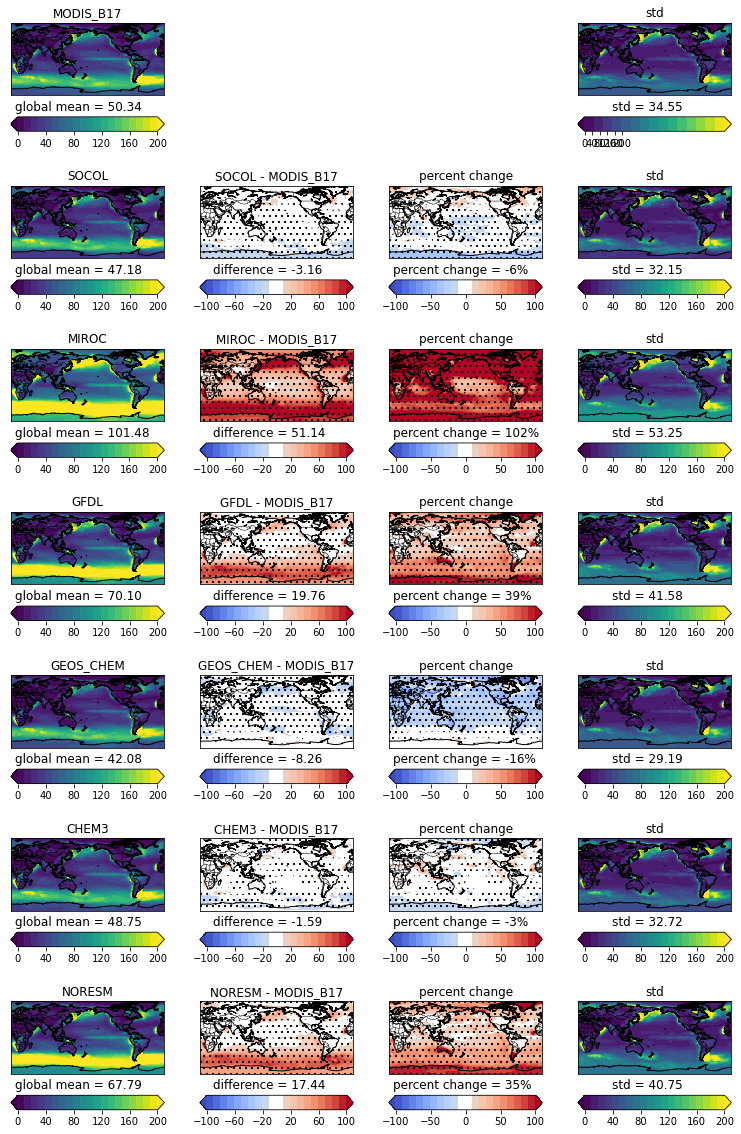

In [17]:
# labels=['MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
# AOD_file=[MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
from matplotlib.colors import LinearSegmentedColormap
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL',
        'MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,
          MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
from mpl_toolkits.axes_grid1 import make_axes_locatable
# 'Total_H2SO4_load','SO2_MASS_MIXING_RATIO','DMS_Mass_Mixing_Ratio','CDNC','ccn_concentration_25r','AOD',
# 'H2SO4_aerosol','H2SO4_aerosol','H2SO4_Mass_Mixing_Ratio','Clear_Sky_RF','All_Sky_RF','ALL_SKY_OUTGOING_SW_FLUX_TOA'

observation_list=['ccn_concentration_25r','AOD','CDNC','ALL_SKY_OUTGOING_SW_FLUX_TOA']
fig = plt.figure(figsize=(15,20), edgecolor='w')

titles='DMS_Mass_Mixing_Ratio'

var,clevs_diff,clevs_mean, \
num, unit, unit_var, \
variable, MODEL_HEIGHT, tick, \
tick_2,coolwarm_data = variable_global(titles)

clevs_per=np.arange(-100,100+10,10) # 

test=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')
#end

if titles in observation_list:
    if titles =='ccn_concentration_25r':
        obs=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018])))
        OB_NAME='CALIOP'
    if titles =='AOD':
        obs=modis_aod_observations.mean('time')
        obs_std=modis_aod_observations.std('time')
        obs_time=copy.deepcopy(modis_aod_observations)
        OB_NAME='MODIS-AOD'
    if titles =='CDNC':
        obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=(nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))))
        OB_NAME='Grosvenor_Nd'
    if titles =='ALL_SKY_OUTGOING_SW_FLUX_TOA':
        obs=SW_OBS_uk.mean('time')
        obs_std=SW_OBS_uk.std('time')
        obs_time=(SW_OBS_uk)
        OB_NAME='CERES'
    try:
        obs_lat=obs.lat
        obs_mean=areaweight(obs,obs_lat)
        obs_std_avg=areaweight(obs_std,obs_lat)
    except:
        obs_lat=lats.data
        obs_mean=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
        obs_std_avg=np.nanmean(GROS_AREAWEIGHT_STD_Global)

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
#coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_datas)

xa,ya  = np.meshgrid(lons,lats)

units = [unit,'\u0394','%\u0394','STD']
modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')[var]
try:
    modis_b17_aod_data = modis_b17_aod_data.sel(model_level_number=MODEL_HEIGHT)
except:
    pass
modis_b17_aod_data=modis_b17_aod_data.transpose('time','latitude', 'longitude')

modis_b17_aod_data_std=modis_b17_aod_data.std('time')
modis_b17_aod_data_mean=modis_b17_aod_data.mean('time')
for i in range(0,len(AOD_file)):
    ax=[]
    if titles in observation_list !=-1:
        plt.subplots_adjust(hspace=0.5,wspace=-0.6)#x=np.arange(40,70,5)
        c=np.arange(0,4*(len(labels)+1),4)
        ax1 = fig.add_subplot(len(labels)+1,4,c[i]+1);ax4 = fig.add_subplot(len(labels)+1,4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels)+1,4,c[i]+2);ax3 = fig.add_subplot(len(labels)+1,4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])
        
    else:
        plt.subplots_adjust(hspace=0.5,wspace=-0.3)
        c=np.arange(0,4*len(labels),4)
        ax1 = fig.add_subplot(len(labels),4,c[i]+1);ax4 = fig.add_subplot(len(labels),4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels),4,c[i]+2);ax3 = fig.add_subplot(len(labels),4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])

    AOD_file=globals().get(labels[i]+'_file')

    aod_data=xr.open_dataset(AOD_file+'../Annual_Processed/'+titles+'.nc')[var]
    try:
        aod_data = aod_data.sel(model_level_number=MODEL_HEIGHT)
    except:
        pass
    
    aod_data_mean=aod_data.mean('time')[:]
    aod_data_std=aod_data.std('time')[:]

    dots=find_diffs(aod_data,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
    diff=aod_data_mean-np.array(modis_b17_aod_data_mean)
    perc_diff=(((aod_data_mean/np.array(modis_b17_aod_data_mean))-1)*100)
    perc_diff_mean=percentage_difference(areaweight(modis_b17_aod_data_mean,lats),areaweight(aod_data_mean,lats))

    
   # dots=xr.where(abs(diff[:]) > modis_b17_aod_data_std[:],0,1)
    for n in range(0, len(ax[0])):
        map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                          projection='cyl', resolution='c', ax=ax[0][n])
        x, y = map_ax1(xa, ya)
        meridians = np.arange(0., 360, 60.)
        parallels = np.arange(-90., 90, 30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
#         map_ax1.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=8)
#         map_ax1.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=8)
    cs = ax1.contourf(x, y, aod_data_mean * num, clevs_mean, extend='both', cmap='viridis')

    if labels[i] == 'MODIS_B17':
        labels[i]= 'MODIS_B17_MODIS_B17'
        ticky=[tick_2,tick_2]
        css=[cs,cs4]
        cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
        ax4.set_title("std".format(labels[i]),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    else:
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight(diff,lats).data*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean.data),fontsize=12)
        
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)
        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)
        ax2.set_title("{} - MODIS_B17".format(labels[i][10:]),fontsize=12)
        ax3.set_title("percent change",fontsize=12)
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        css=[cs,cs2,cs6,cs4]
        if titles in observation_list:
            dots_obs=find_diffs(aod_data,obs_time,0) #1 indicates it is not statistically significant; 0 indicates it is
            diff_obs=aod_data_mean-np.array(obs)
            perc_diff_obs=(((aod_data_mean/np.array(obs))-1)*100)
            perc_diff_mean_obs=percentage_difference(areaweight((obs),(obs_lat)),areaweight(aod_data_mean,lats))

            cs4 = ax4.contourf(x,y,perc_diff_obs*num,clevs_per,extend='both',cmap=coolwarm_white)
            ax4.set_title("{} - {}".format(labels[i][10:],OB_NAME),fontsize=12)
            ax4.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean_obs.data),fontsize=12)
        else:
            cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
            ax4.set_title("std".format(labels[i]),fontsize=12)
            ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    ax1.text(10,-120,"global mean = {:.2f}".format(areaweight(aod_data_mean,lats).mean().data*num),fontsize=12)


    for n in range(0, len(ax[0])):

        # Add colorbar below each plot
        divider = make_axes_locatable(ax[0][n])
        cax = divider.append_axes("bottom", size="20%", pad=0.3)
        cbar = fig.colorbar(css[n], cax=cax, orientation='horizontal',ticks=ticky[n])
        #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


        ax1.set_title("{}".format(labels[i][10:]),fontsize=12)

    

    [m,n] = np.where(dots==0)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    if i == 0:
        pass
    else:
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
   #     cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    if i == 0:
        pass
    else:
        if titles in observation_list:
            [m,n] = np.where(dots_obs==0)
            z1 = np.zeros(dots.shape)
            z1[m,n]=99
            cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        else:
            pass
#     if i == 4:
#         end
    
if titles in observation_list !=-1:
    if i == len(labels)-1:
        ax=[]
        ax1 = fig.add_subplot(len(labels)+1,4,29);ax2 = fig.add_subplot(len(labels)+1,4,30)
        ax3 = fig.add_subplot(len(labels)+1,4,31);ax4 = fig.add_subplot(len(labels)+1,4,32)
        ax.append([ax1,ax2,ax3,ax4])
        for n in range(0, len(ax[0])):
            map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                              projection='cyl', resolution='c', ax=ax[0][n])
            x, y = map_ax1(xa, ya)
            meridians = np.arange(0., 360, 60.)
            parallels = np.arange(-90., 90, 30.)
            map_ax1.drawcoastlines()
            map_ax1.drawcountries()
            


    
        
        dots=find_diffs(obs_time,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
        diff=modis_b17_aod_data_mean-np.array(obs)
        perc_diff=(((modis_b17_aod_data_mean/np.array(obs))-1)*100)
        perc_diff_mean=percentage_difference(areaweight_numpy(np.array(obs),np.array(obs_lat)),areaweight(modis_b17_aod_data_mean,lats))
        
        cs1=ax1.contourf(x,y,obs*num,clevs_mean,extend='both',cmap='viridis')
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)

        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)

        cs4=ax4.contourf(x,y,obs_std*num,clevs_mean,extend='both',cmap='viridis')
    
        [m,n] = np.where(dots==0)
        z1 = np.zeros(dots.shape)
        z1[m,n]=99
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        css=[cs,cs2,cs6,cs4]
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        for n in range(0, len(ax[0])):

            # Add colorbar below each plot
            divider = make_axes_locatable(ax[0][n])
            cax = divider.append_axes("bottom", size="20%", pad=0.3)
            cbar = fig.colorbar(css[n], cax=cax, orientation='horizontal',ticks=ticky[n])
            #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


            ax1.set_title("{}".format(OB_NAME),fontsize=12)
            ax2.set_title(" MODIS_B17 - {}".format(OB_NAME),fontsize=12)
            ax3.set_title("percent change",fontsize=12)
            ax4.set_title("{} std".format(OB_NAME),fontsize=12)

        ax1.text(10,-120,"global mean = {:.2f}".format(np.array(obs_mean)*num),fontsize=12)
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight_numpy(np.array(diff),np.array(lats))*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(np.array(perc_diff_mean)),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(np.array(obs_std_avg)*num),fontsize=12)


    else:
        pass


plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Chemistry/{}_CHEM_diff.png".format(variable),dpi=200,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Chemistry/{}_CHEM_diff.pdf".format(variable),dpi=50,bbox_inches = 'tight')


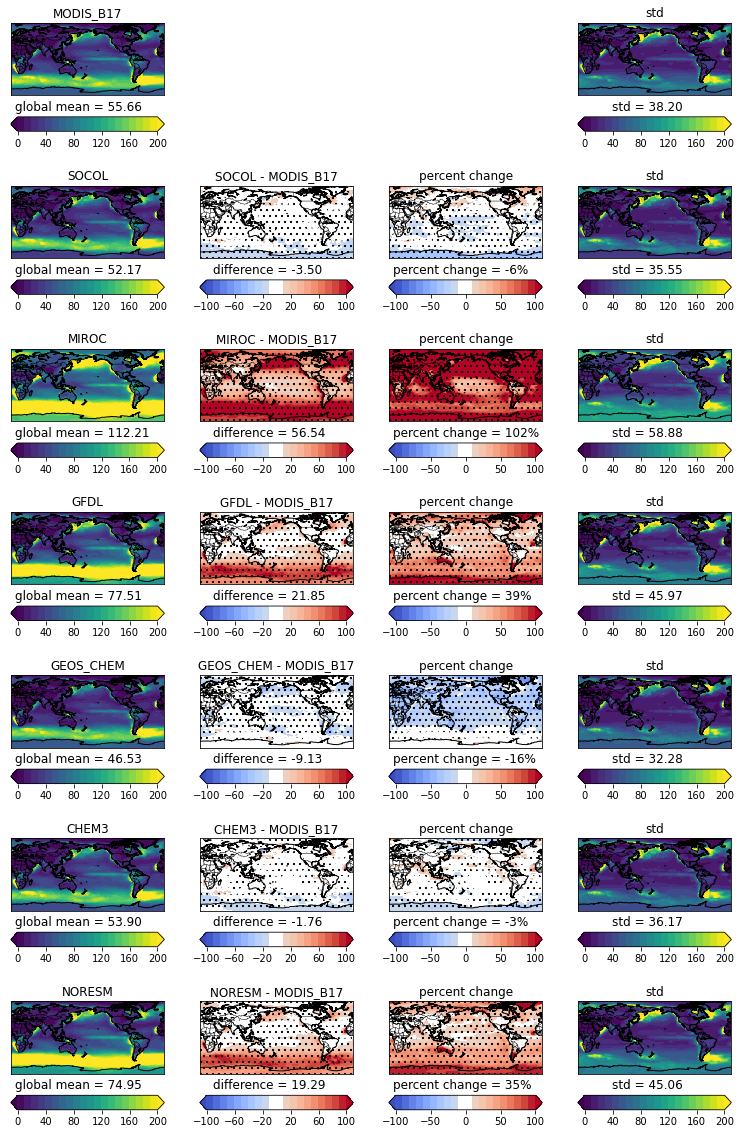

In [41]:
# labels=['MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
# AOD_file=[MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
from matplotlib.colors import LinearSegmentedColormap
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL',
        'MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,
          MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
from mpl_toolkits.axes_grid1 import make_axes_locatable
kg_to_gg=(1e12)
kg_to_tg=(1e9)

# 'Total_H2SO4_load','SO2_MASS_MIXING_RATIO','DMS_Mass_Mixing_Ratio','CDNC','ccn_concentration_25r','AOD',
# 'H2SO4_aerosol','H2SO4_aerosol','H2SO4_Mass_Mixing_Ratio','Clear_Sky_RF','All_Sky_RF','ALL_SKY_OUTGOING_SW_FLUX_TOA'

observation_list=['ccn_concentration_25r','AOD','CDNC','ALL_SKY_OUTGOING_SW_FLUX_TOA']
fig = plt.figure(figsize=(15,20), edgecolor='w')

titles='DMS_Mass_Mixing_Ratio'

var,clevs_diff,clevs_mean, \
num, unit, unit_var, \
variable, MODEL_HEIGHT, tick, \
tick_2,coolwarm_data = variable_global(titles)

clevs_per=np.arange(-100,100+10,10) # 

test=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')
#end

if titles in observation_list:
    if titles =='ccn_concentration_25r':
        obs=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018])))
        OB_NAME='CALIOP'
    if titles =='AOD':
        obs=modis_aod_observations.mean('time')
        obs_std=modis_aod_observations.std('time')
        obs_time=copy.deepcopy(modis_aod_observations)
        OB_NAME='MODIS-AOD'
    if titles =='CDNC':
        obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=(nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))))
        OB_NAME='Grosvenor_Nd'
    if titles =='ALL_SKY_OUTGOING_SW_FLUX_TOA':
        obs=SW_OBS_uk.mean('time')
        obs_std=SW_OBS_uk.std('time')
        obs_time=(SW_OBS_uk)
        OB_NAME='CERES'
    try:
        obs_lat=obs.lat
        obs_mean=areaweight(obs,obs_lat)
        obs_std_avg=areaweight(obs_std,obs_lat)
    except:
        obs_lat=lats.data
        obs_mean=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
        obs_std_avg=np.nanmean(GROS_AREAWEIGHT_STD_Global)

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
#coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_datas)

xa,ya  = np.meshgrid(lons,lats)


units = [unit,'\u0394','%\u0394','STD']

if titles=='AOD':
    modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../'+titles+'.nc')[var]
else:
    modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')[var]

try:
    modis_b17_aod_data = modis_b17_aod_data.sel(model_level_number=MODEL_HEIGHT)
except:
    pass
modis_b17_aod_data=modis_b17_aod_data.transpose('time','latitude', 'longitude')

modis_b17_aod_data_std=modis_b17_aod_data.std('time')
modis_b17_aod_data_mean=modis_b17_aod_data.mean('time')
for i in range(0,len(AOD_file)):
    ax=[]
    if titles in observation_list !=-1:
        plt.subplots_adjust(hspace=0.5,wspace=-0.6)#x=np.arange(40,70,5)
        c=np.arange(0,4*(len(labels)+1),4)
        ax1 = fig.add_subplot(len(labels)+1,4,c[i]+1);ax4 = fig.add_subplot(len(labels)+1,4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels)+1,4,c[i]+2);ax3 = fig.add_subplot(len(labels)+1,4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])
        
    else:
        plt.subplots_adjust(hspace=0.5,wspace=-0.3)
        c=np.arange(0,4*len(labels),4)
        ax1 = fig.add_subplot(len(labels),4,c[i]+1);ax4 = fig.add_subplot(len(labels),4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels),4,c[i]+2);ax3 = fig.add_subplot(len(labels),4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])

    AOD_file=globals().get(labels[i]+'_file')

    if titles=='AOD':
        aod_data=xr.open_dataset(AOD_file+'../'+titles+'.nc')[var]
    else:
        aod_data=xr.open_dataset(AOD_file+'../Annual_Processed/'+titles+'.nc')[var]

    try:
        aod_data = aod_data.sel(model_level_number=MODEL_HEIGHT)
    except:
        pass
    
    aod_data_mean=aod_data.mean('time')[:]
    aod_data_std=aod_data.std('time')[:]

    dots=find_diffs(aod_data,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
    diff=aod_data_mean-np.array(modis_b17_aod_data_mean)
    perc_diff=(((aod_data_mean/np.array(modis_b17_aod_data_mean))-1)*100)
    perc_diff_mean=percentage_difference(areaweight(modis_b17_aod_data_mean,lats),areaweight(aod_data_mean,lats))

    
   # dots=xr.where(abs(diff[:]) > modis_b17_aod_data_std[:],0,1)
    for n in range(0, len(ax[0])):
        map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                          projection='cyl', resolution='c', ax=ax[0][n])
        x, y = map_ax1(xa, ya)
        meridians = np.arange(0., 360, 60.)
        parallels = np.arange(-90., 90, 30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
#         map_ax1.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=8)
#         map_ax1.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=8)
    cs = ax1.contourf(x, y, aod_data_mean * num, clevs_mean, extend='both', cmap='viridis')

    if labels[i] == 'MODIS_B17':
        labels[i]= 'MODIS_B17_MODIS_B17'
        ticky=[tick_2,tick_2]
        css=[cs,cs4]
        cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
        ax4.set_title("std".format(labels[i]),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    else:
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight(diff,lats).data*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean.data),fontsize=12)
        
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)
        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)
        ax2.set_title("{} - MODIS_B17".format(labels[i][10:]),fontsize=12)
        ax3.set_title("percent change",fontsize=12)
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        css=[cs,cs2,cs6,cs4]
        if titles in observation_list:
            dots_obs=find_diffs(aod_data,obs_time,0) #1 indicates it is not statistically significant; 0 indicates it is
            diff_obs=aod_data_mean-np.array(obs)
            perc_diff_obs=(((aod_data_mean/np.array(obs))-1)*100)
            perc_diff_mean_obs=percentage_difference(areaweight((obs),(obs_lat)),areaweight(aod_data_mean,lats))

            cs4 = ax4.contourf(x,y,perc_diff_obs*num,clevs_per,extend='both',cmap=coolwarm_white)
            ax4.set_title("{} - {}".format(labels[i][10:],OB_NAME),fontsize=12)
            ax4.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean_obs.data),fontsize=12)
        else:
            cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
            ax4.set_title("std".format(labels[i]),fontsize=12)
            ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    ax1.text(10,-120,"global mean = {:.2f}".format(areaweight(aod_data_mean,lats).mean().data*num),fontsize=12)


    for n in range(0, len(ax[0])):

        # Add colorbar below each plot
        divider = make_axes_locatable(ax[0][n])
        cax = divider.append_axes("bottom", size="20%", pad=0.3)
        cbar = fig.colorbar(css[n], cax=cax, orientation='horizontal',ticks=ticky[n])
        #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


        ax1.set_title("{}".format(labels[i][10:]),fontsize=12)

    

    [m,n] = np.where(dots==0)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    if i == 0:
        pass
    else:
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
   #     cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    if i == 0:
        pass
    else:
        if titles in observation_list:
            [m,n] = np.where(dots_obs==0)
            z1 = np.zeros(dots.shape)
            z1[m,n]=99
            cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        else:
            pass

#     if i == 1:
#         end

if titles in observation_list !=-1:
    if i == len(labels)-1:
        ax=[]
        ax1 = fig.add_subplot(len(labels)+1,4,29);ax2 = fig.add_subplot(len(labels)+1,4,30)
        ax3 = fig.add_subplot(len(labels)+1,4,31);ax4 = fig.add_subplot(len(labels)+1,4,32)
        ax.append([ax1,ax2,ax3,ax4])
        for n in range(0, len(ax[0])):
            map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                              projection='cyl', resolution='c', ax=ax[0][n])
            x, y = map_ax1(xa, ya)
            meridians = np.arange(0., 360, 60.)
            parallels = np.arange(-90., 90, 30.)
            map_ax1.drawcoastlines()
            map_ax1.drawcountries()
            


    
        
        dots=find_diffs(obs_time,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
        diff=modis_b17_aod_data_mean-np.array(obs)
        perc_diff=(((modis_b17_aod_data_mean/np.array(obs))-1)*100)
        perc_diff_mean=percentage_difference(areaweight_numpy(np.array(obs),np.array(obs_lat)),areaweight(modis_b17_aod_data_mean,lats))
        
        cs1=ax1.contourf(x,y,obs*num,clevs_mean,extend='both',cmap='viridis')
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)

        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)

        cs4=ax4.contourf(x,y,obs_std*num,clevs_mean,extend='both',cmap='viridis')
    
        [m,n] = np.where(dots==0)
        z1 = np.zeros(dots.shape)
        z1[m,n]=99
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        css=[cs1,cs2,cs6,cs4]
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        for d in range(0, len(ax[0])):

            # Add colorbar below each plot
            divider = make_axes_locatable(ax[0][d])
            cax = divider.append_axes("bottom", size="20%", pad=0.3)
            cbar = fig.colorbar(css[d], cax=cax, orientation='horizontal',ticks=ticky[d])
            #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


            ax1.set_title("{}".format(OB_NAME),fontsize=12)
            ax2.set_title(" MODIS_B17 - {}".format(OB_NAME),fontsize=12)
            ax3.set_title("percent change",fontsize=12)
            ax4.set_title("{} std".format(OB_NAME),fontsize=12)

        ax1.text(10,-120,"global mean = {:.2f}".format(np.array(obs_mean)*num),fontsize=12)
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight_numpy(np.array(diff),np.array(lats))*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(np.array(perc_diff_mean)),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(np.array(obs_std_avg)*num),fontsize=12)


    else:
        pass


plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Chemistry/{}_CHEM_diff.png".format(variable),dpi=200,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Chemistry/{}_CHEM_diff.pdf".format(variable),dpi=20,bbox_inches = 'tight')


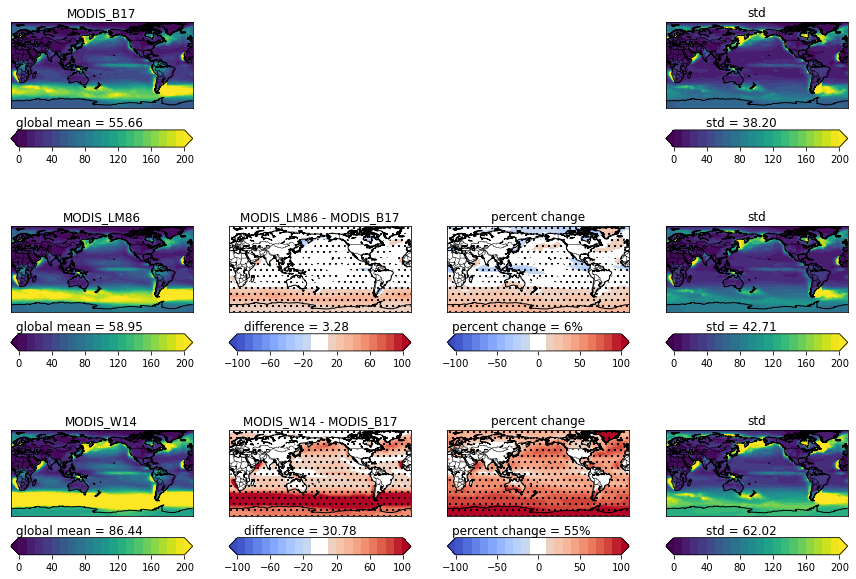

In [42]:
# labels=['MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
# AOD_file=[MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
from matplotlib.colors import LinearSegmentedColormap
labels=['MODIS_B17','MODIS_LM86','MODIS_W14']#,'MODIS_B17_GFDL',
       # 'MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_file,MODIS_LM86_file,MODIS_W14_file]#,MODIS_B17_GFDL_file,
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 'Total_H2SO4_load','SO2_MASS_MIXING_RATIO','DMS_Mass_Mixing_Ratio','CDNC','ccn_concentration_25r','AOD',
# 'H2SO4_aerosol','H2SO4_aerosol','H2SO4_Mass_Mixing_Ratio','Clear_Sky_RF','All_Sky_RF','ALL_SKY_OUTGOING_SW_FLUX_TOA'

observation_list=['ccn_concentration_25r','AOD','CDNC','ALL_SKY_OUTGOING_SW_FLUX_TOA']
fig = plt.figure(figsize=(15,20), edgecolor='w')

titles='DMS_Mass_Mixing_Ratio'

var,clevs_diff,clevs_mean, \
num, unit, unit_var, \
variable, MODEL_HEIGHT, tick, \
tick_2,coolwarm_data = variable_global(titles)

clevs_per=np.arange(-100,100+10,10) # 

test=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')
#end

if titles in observation_list:
    if titles =='ccn_concentration_25r':
        obs=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018])))
        OB_NAME='CALIOP'
    if titles =='AOD':
        obs=modis_aod_observations.mean('time')
        obs_std=modis_aod_observations.std('time')
        obs_time=copy.deepcopy(modis_aod_observations)
        OB_NAME='MODIS-AOD'
    if titles =='CDNC':
        obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=(nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))))
        OB_NAME='Grosvenor_Nd'
    if titles =='ALL_SKY_OUTGOING_SW_FLUX_TOA':
        obs=SW_OBS_uk.mean('time')
        obs_std=SW_OBS_uk.std('time')
        obs_time=(SW_OBS_uk)
        OB_NAME='CERES'
    try:
        obs_lat=obs.lat
        obs_mean=areaweight(obs,obs_lat)
        obs_std_avg=areaweight(obs_std,obs_lat)
    except:
        obs_lat=lats.data
        obs_mean=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
        obs_std_avg=np.nanmean(GROS_AREAWEIGHT_STD_Global)

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
#coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_datas)

xa,ya  = np.meshgrid(lons,lats)

units = [unit,'\u0394','%\u0394','STD']
if titles=='AOD':
    modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../'+titles+'.nc')[var]
else:
    modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')[var]
    
try:
    modis_b17_aod_data = modis_b17_aod_data.sel(model_level_number=MODEL_HEIGHT)
except:
    pass

modis_b17_aod_data=modis_b17_aod_data.transpose('time','latitude', 'longitude')

modis_b17_aod_data_std=modis_b17_aod_data.std('time')
modis_b17_aod_data_mean=modis_b17_aod_data.mean('time')
for i in range(0,len(labels)):
    ax=[]
    if titles in observation_list !=-1:
        plt.subplots_adjust(hspace=-0.65)#x=np.arange(40,70,5)
        c=np.arange(0,4*(len(labels)+1),4)
        ax1 = fig.add_subplot(len(labels)+1,4,c[i]+1);ax4 = fig.add_subplot(len(labels)+1,4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels)+1,4,c[i]+2);ax3 = fig.add_subplot(len(labels)+1,4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])
        
    else:
        plt.subplots_adjust(hspace=-0.7)#x=np.arange(40,70,5)
        c=np.arange(0,4*len(labels),4)
        ax1 = fig.add_subplot(len(labels),4,c[i]+1);ax4 = fig.add_subplot(len(labels),4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels),4,c[i]+2);ax3 = fig.add_subplot(len(labels),4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])

    AOD_file=globals().get(labels[i]+'_file')
    if titles=='AOD':
        aod_data=xr.open_dataset(AOD_file+'../'+titles+'.nc')[var]
    else:
        aod_data=xr.open_dataset(AOD_file+'../Annual_Processed/'+titles+'.nc')[var]

    try:
        aod_data = aod_data.sel(model_level_number=MODEL_HEIGHT)
    except:
        pass

    aod_data=aod_data.transpose('time','latitude', 'longitude')

    aod_data_mean=aod_data.mean('time')[:]
    aod_data_std=aod_data.std('time')[:]

    dots=find_diffs(aod_data,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
    diff=aod_data_mean-np.array(modis_b17_aod_data_mean)
    perc_diff=(((aod_data_mean/np.array(modis_b17_aod_data_mean))-1)*100)
    perc_diff_mean=percentage_difference(areaweight(modis_b17_aod_data_mean,lats),areaweight(aod_data_mean,lats))

    
   # dots=xr.where(abs(diff[:]) > modis_b17_aod_data_std[:],0,1)
    for n in range(0, len(ax[0])):
        map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                          projection='cyl', resolution='c', ax=ax[0][n])
        x, y = map_ax1(xa, ya)
        meridians = np.arange(0., 360, 60.)
        parallels = np.arange(-90., 90, 30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
#         map_ax1.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=8)
#         map_ax1.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=8)
    cs = ax1.contourf(x, y, aod_data_mean * num, clevs_mean, extend='both', cmap='viridis')

    if labels[i] == 'MODIS_B17':
        ticky=[tick_2,tick_2]
        css=[cs,cs4]
        cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
        ax4.set_title("std".format(labels[i]),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    else:
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight(diff,lats).data*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean.data),fontsize=12)
        
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)
        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)
        ax2.set_title("{} - MODIS_B17".format(labels[i][:]),fontsize=12)
        ax3.set_title("percent change",fontsize=12)
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        css=[cs,cs2,cs6,cs4]
        if titles in observation_list:
            dots_obs=find_diffs(aod_data,obs_time,0) #1 indicates it is not statistically significant; 0 indicates it is
            diff_obs=aod_data_mean-np.array(obs)
            perc_diff_obs=(((aod_data_mean/np.array(obs))-1)*100)
            perc_diff_mean_obs=percentage_difference(areaweight((obs),(obs_lat)),areaweight(aod_data_mean,lats))

            cs4 = ax4.contourf(x,y,perc_diff_obs*num,clevs_per,extend='both',cmap=coolwarm_white)
            ax4.set_title("{} - {}".format(labels[i][:],OB_NAME),fontsize=12)
            ax4.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean_obs.data),fontsize=12)
        else:
            cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
            ax4.set_title("std".format(labels[i]),fontsize=12)
            ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    ax1.text(10,-120,"global mean = {:.2f}".format(areaweight(aod_data_mean,lats).mean().data*num),fontsize=12)


    for n in range(0, len(ax[0])):

        # Add colorbar below each plot
        divider = make_axes_locatable(ax[0][n])
        cax = divider.append_axes("bottom", size="20%", pad=0.3)
        cbar = fig.colorbar(css[n], cax=cax, orientation='horizontal',ticks=ticky[n])
        #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


        ax1.set_title("{}".format(labels[i][:]),fontsize=12)

    

    [m,n] = np.where(dots==0)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    if i == 0:
        pass
    else:
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
   #     cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    if i == 0:
        pass
    else:
        if titles in observation_list:
            [m,n] = np.where(dots_obs==0)
            z1 = np.zeros(dots.shape)
            z1[m,n]=99
            cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        else:
            pass
        
        
if titles in observation_list !=-1:
    if i == len(labels)-1:
        ax=[]
        ax1 = fig.add_subplot(len(labels)+1,4,13);ax2 = fig.add_subplot(len(labels)+1,4,14)
        ax3 = fig.add_subplot(len(labels)+1,4,15);ax4 = fig.add_subplot(len(labels)+1,4,16)
        ax.append([ax1,ax2,ax3,ax4])
        for n in range(0, len(ax[0])):
            map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                              projection='cyl', resolution='c', ax=ax[0][n])
            x, y = map_ax1(xa, ya)
            meridians = np.arange(0., 360, 60.)
            parallels = np.arange(-90., 90, 30.)
            map_ax1.drawcoastlines()
            map_ax1.drawcountries()
            


    
        
        dots=find_diffs(obs_time,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
        diff=modis_b17_aod_data_mean-np.array(obs)
        perc_diff=(((modis_b17_aod_data_mean/np.array(obs))-1)*100)
        perc_diff_mean=percentage_difference(areaweight_numpy(np.array(obs),np.array(obs_lat)),areaweight(modis_b17_aod_data_mean,lats))
        
        cs1=ax1.contourf(x,y,obs*num,clevs_mean,extend='both',cmap='viridis')
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)

        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)

        cs4=ax4.contourf(x,y,obs_std*num,clevs_mean,extend='both',cmap='viridis')
    
        [m,n] = np.where(dots==0)
        z1 = np.zeros(dots.shape)
        z1[m,n]=99
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        css=[cs1,cs2,cs6,cs4]
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        for d in range(0, len(ax[0])):

            # Add colorbar below each plot
            divider = make_axes_locatable(ax[0][d])
            cax = divider.append_axes("bottom", size="20%", pad=0.3)
            cbar = fig.colorbar(css[d], cax=cax, orientation='horizontal',ticks=ticky[d])
            #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


            ax1.set_title("{}".format(OB_NAME),fontsize=12)
            ax2.set_title(" MODIS_B17 - {}".format(OB_NAME),fontsize=12)
            ax3.set_title("percent change",fontsize=12)
            ax4.set_title("{} std".format(OB_NAME),fontsize=12)

        ax1.text(10,-120,"global mean = {:.2f}".format(np.array(obs_mean)*num),fontsize=12)
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight_numpy(np.array(diff),np.array(lats))*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(np.array(perc_diff_mean)),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(np.array(obs_std_avg)*num),fontsize=12)


    else:
        pass


plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Emissions/{}_Emission_diff.png".format(variable),dpi=200,bbox_inches = 'tight')
# plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Emissions/{}_Emission_diff.pdf".format(variable),dpi=50,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Emissions/{}_Emission_diff.pdf".format(variable),bbox_inches = 'tight', optimize=True)


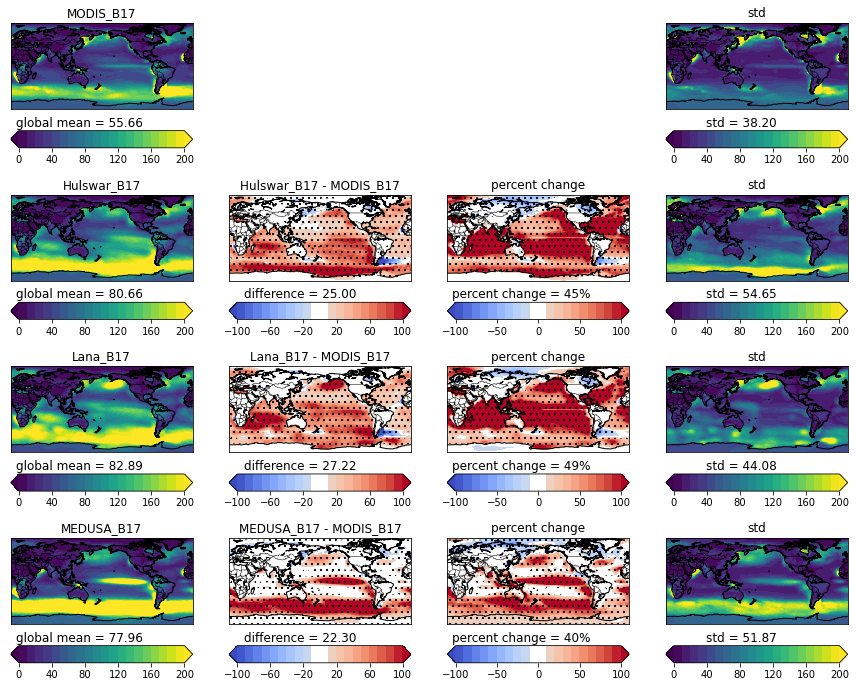

In [43]:
# labels=['MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
# AOD_file=[MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
from matplotlib.colors import LinearSegmentedColormap
labels=['MODIS_B17','Hulswar_B17','Lana_B17','MEDUSA_B17']#,'MODIS_B17_GFDL',
       # 'MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']#,'Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','Lana_LM86','Hulswar_LM86','MEDUSA_LM86']
AOD_file=[MODIS_B17_file,MODIS_LM86_file,MODIS_W14_file]#,MODIS_B17_GFDL_file,
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 'Total_H2SO4_load','SO2_MASS_MIXING_RATIO','DMS_Mass_Mixing_Ratio','CDNC','ccn_concentration_25r','AOD',
# 'H2SO4_aerosol','H2SO4_aerosol','H2SO4_Mass_Mixing_Ratio','Clear_Sky_RF','All_Sky_RF','ALL_SKY_OUTGOING_SW_FLUX_TOA'

observation_list=['ccn_concentration_25r','AOD','CDNC','ALL_SKY_OUTGOING_SW_FLUX_TOA']
fig = plt.figure(figsize=(15,20), edgecolor='w')

titles='DMS_Mass_Mixing_Ratio'

var,clevs_diff,clevs_mean, \
num, unit, unit_var, \
variable, MODEL_HEIGHT, tick, \
tick_2,coolwarm_data = variable_global(titles)

clevs_per=np.arange(-100,100+10,10) # 

test=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')
#end

if titles in observation_list:
    if titles =='ccn_concentration_25r':
        obs=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018])))
        OB_NAME='CALIOP'
    if titles =='AOD':
        obs=modis_aod_observations.mean('time')
        obs_std=modis_aod_observations.std('time')
        obs_time=copy.deepcopy(modis_aod_observations)
        OB_NAME='MODIS-AOD'
    if titles =='CDNC':
        obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
        obs_std=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).std('time')
        obs_time=(nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))))
        OB_NAME='Grosvenor_Nd'
    if titles =='ALL_SKY_OUTGOING_SW_FLUX_TOA':
        obs=SW_OBS_uk.mean('time')
        obs_std=SW_OBS_uk.std('time')
        obs_time=(SW_OBS_uk)
        OB_NAME='CERES'
    try:
        obs_lat=obs.lat
        obs_mean=areaweight(obs,obs_lat)
        obs_std_avg=areaweight(obs_std,obs_lat)
    except:
        obs_lat=lats.data
        obs_mean=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
        obs_std_avg=np.nanmean(GROS_AREAWEIGHT_STD_Global)

# Create the colormap
coolwarm_white = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_data)
#coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_datas)

xa,ya  = np.meshgrid(lons,lats)

units = [unit,'\u0394','%\u0394','STD']
if titles=='AOD':
    modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../'+titles+'.nc')[var]
else:
    modis_b17_aod_data=xr.open_dataset(MODIS_B17_file+'../Annual_Processed/'+titles+'.nc')[var]
    
try:
    modis_b17_aod_data = modis_b17_aod_data.sel(model_level_number=MODEL_HEIGHT)
except:
    pass

modis_b17_aod_data=modis_b17_aod_data.transpose('time','latitude', 'longitude')

modis_b17_aod_data_std=modis_b17_aod_data.std('time')
modis_b17_aod_data_mean=modis_b17_aod_data.mean('time')
for i in range(0,len(labels)):
    ax=[]
    if titles in observation_list !=-1:
        plt.subplots_adjust(hspace=-0.6)#x=np.arange(40,70,5)
        c=np.arange(0,4*(len(labels)+1),4)
        ax1 = fig.add_subplot(len(labels)+1,4,c[i]+1);ax4 = fig.add_subplot(len(labels)+1,4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels)+1,4,c[i]+2);ax3 = fig.add_subplot(len(labels)+1,4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])
        
    else:
        plt.subplots_adjust(hspace=-.7)#x=np.arange(40,70,5)
        c=np.arange(0,4*len(labels),4)
        ax1 = fig.add_subplot(len(labels),4,c[i]+1);ax4 = fig.add_subplot(len(labels),4,c[i]+4)
        if i == 0:
            ax.append([ax1,ax4])

        else:
            ax2 = fig.add_subplot(len(labels),4,c[i]+2);ax3 = fig.add_subplot(len(labels),4,c[i]+3)
            ax.append([ax1,ax2,ax3,ax4])

    AOD_file=globals().get(labels[i]+'_file')
    if titles=='AOD':
        aod_data=xr.open_dataset(AOD_file+'../'+titles+'.nc')[var]
    else:
        aod_data=xr.open_dataset(AOD_file+'../Annual_Processed/'+titles+'.nc')[var]

    try:
        aod_data = aod_data.sel(model_level_number=MODEL_HEIGHT)
    except:
        pass

    aod_data=aod_data.transpose('time','latitude', 'longitude')

    aod_data_mean=aod_data.mean('time')[:]
    aod_data_std=aod_data.std('time')[:]

    dots=find_diffs(aod_data,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
    diff=aod_data_mean-np.array(modis_b17_aod_data_mean)
    perc_diff=(((aod_data_mean/np.array(modis_b17_aod_data_mean))-1)*100)
    perc_diff_mean=percentage_difference(areaweight(modis_b17_aod_data_mean,lats),areaweight(aod_data_mean,lats))

    
   # dots=xr.where(abs(diff[:]) > modis_b17_aod_data_std[:],0,1)
    for n in range(0, len(ax[0])):
        map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                          projection='cyl', resolution='c', ax=ax[0][n])
        x, y = map_ax1(xa, ya)
        meridians = np.arange(0., 360, 60.)
        parallels = np.arange(-90., 90, 30.)
        map_ax1.drawcoastlines()
        map_ax1.drawcountries()
#         map_ax1.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=8)
#         map_ax1.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=8)
    cs = ax1.contourf(x, y, aod_data_mean * num, clevs_mean, extend='both', cmap='viridis')

    if labels[i] == 'MODIS_B17':
        ticky=[tick_2,tick_2]
        css=[cs,cs4]
        cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
        ax4.set_title("std".format(labels[i]),fontsize=12)
        ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    else:
        ax2.text(30,-120,"difference = {:.2f}".format(areaweight(diff,lats).data*num),fontsize=12)
        ax3.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean.data),fontsize=12)
        
        cs2=ax2.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)
        cs6=ax3.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)
        ax2.set_title("{} - MODIS_B17".format(labels[i]),fontsize=12)
        ax3.set_title("percent change",fontsize=12)
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        css=[cs,cs2,cs6,cs4]
        if titles in observation_list:
            dots_obs=find_diffs(aod_data,obs_time,0) #1 indicates it is not statistically significant; 0 indicates it is
            diff_obs=aod_data_mean-np.array(obs)
            perc_diff_obs=(((aod_data_mean/np.array(obs))-1)*100)
            perc_diff_mean_obs=percentage_difference(areaweight((obs),(obs_lat)),areaweight(aod_data_mean,lats))

            cs4 = ax4.contourf(x,y,perc_diff_obs*num,clevs_per,extend='both',cmap=coolwarm_white)
            ax4.set_title("{} - {}".format(labels[i],OB_NAME),fontsize=12)
            ax4.text(10,-120,"percent change = {:.0f}%".format(perc_diff_mean_obs.data),fontsize=12)
        else:
            cs4 = ax4.contourf(x,y,aod_data_std*num,clevs_mean,extend='both',cmap='viridis')
            ax4.set_title("std".format(labels[i]),fontsize=12)
            ax4.text(80,-120,"std = {:.2f}".format(areaweight(aod_data_std,lats).data*num),fontsize=12)

    ax1.text(10,-120,"global mean = {:.2f}".format(areaweight(aod_data_mean,lats).mean().data*num),fontsize=12)


    for n in range(0, len(ax[0])):

        # Add colorbar below each plot
        divider = make_axes_locatable(ax[0][n])
        cax = divider.append_axes("bottom", size="20%", pad=0.3)
        cbar = fig.colorbar(css[n], cax=cax, orientation='horizontal',ticks=ticky[n])
        #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


        ax1.set_title("{}".format(labels[i][:]),fontsize=12)

    

    [m,n] = np.where(dots==0)
    z1 = np.zeros(dots.shape)
    z1[m,n]=99
    if i == 0:
        pass
    else:
        cs3 = ax2.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs3 = ax3.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
   #     cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
    if i == 0:
        pass
    else:
        if titles in observation_list:
            [m,n] = np.where(dots_obs==0)
            z1 = np.zeros(dots.shape)
            z1[m,n]=99
            cs3 = ax4.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        else:
            pass
    
if titles in observation_list !=-1:
    if i == len(labels)-1:
        ax=[]
        ax7 = fig.add_subplot(len(labels)+1,4,17);ax8 = fig.add_subplot(len(labels)+1,4,18)
        ax9 = fig.add_subplot(len(labels)+1,4,19);ax10 = fig.add_subplot(len(labels)+1,4,20)
        ax.append([ax7,ax8,ax9,ax10])
        for n in range(0, len(ax[0])):
            map_ax1 = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85,
                              projection='cyl', resolution='c', ax=ax[0][n])
            x, y = map_ax1(xa, ya)
            meridians = np.arange(0., 360, 60.)
            parallels = np.arange(-90., 90, 30.)
            map_ax1.drawcoastlines()
            map_ax1.drawcountries()
            


    
        
        dots=find_diffs(obs_time,modis_b17_aod_data,0) #1 indicates it is not statistically significant; 0 indicates it is
        diff=modis_b17_aod_data_mean-np.array(obs)
        perc_diff=(((modis_b17_aod_data_mean/np.array(obs))-1)*100)
        perc_diff_mean=percentage_difference(areaweight_numpy(np.array(obs),np.array(obs_lat)),areaweight(modis_b17_aod_data_mean,lats))
        
        cs7=ax7.contourf(x,y,obs*num,clevs_mean,extend='both',cmap='viridis')
        cs8=ax8.contourf(x,y,diff*num,clevs_diff,extend='both',cmap=coolwarm_white)

        cs9=ax9.contourf(x,y,perc_diff,clevs_per,extend='both',cmap=coolwarm_white)

        cs10=ax10.contourf(x,y,obs_std*num,clevs_mean,extend='both',cmap='viridis')
    
        [m,n] = np.where(dots==0)
        z1 = np.zeros(dots.shape)
        z1[m,n]=99
        cs31 = ax8.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        cs31 = ax9.contourf(x, y, z1, 1, hatches=['', '..'], alpha=0)
        css=[cs7,cs8,cs9,cs10]
        ticky=[tick_2,tick,np.arange(-100,100+10,50),tick_2]
        for d in range(0, len(ax[0])):

            # Add colorbar below each plot
            divider = make_axes_locatable(ax[0][d])
            cax = divider.append_axes("bottom", size="20%", pad=0.3)
            cbar = fig.colorbar(css[d], cax=cax, orientation='horizontal',ticks=ticky[d])
            #ax[0][n].set_title("mean - {}".format(titles), fontsize=12)      


            ax7.set_title("{}".format(OB_NAME),fontsize=12)
            ax8.set_title(" MODIS_B17 - {}".format(OB_NAME),fontsize=12)
            ax9.set_title("percent change",fontsize=12)
            ax10.set_title("{} std".format(OB_NAME),fontsize=12)

            
        ax7.text(10,-120,"global mean = {:.2f}".format(np.array(obs_mean)*num),fontsize=12)
        ax8.text(30,-120,"difference = {:.2f}".format(areaweight_numpy(np.array(diff),np.array(lats))*num),fontsize=12)
        ax9.text(10,-120,"percent change = {:.0f}%".format(np.array(perc_diff_mean)),fontsize=12)
        ax10.text(80,-120,"std = {:.2f}".format(np.array(obs_std_avg)*num),fontsize=12)


    else:
        pass


plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Source/{}_Source_diff.png".format(variable),dpi=200,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/Spatial/Global_t/Source/{}_Source_diff.pdf".format(variable),dpi=100,bbox_inches = 'tight')


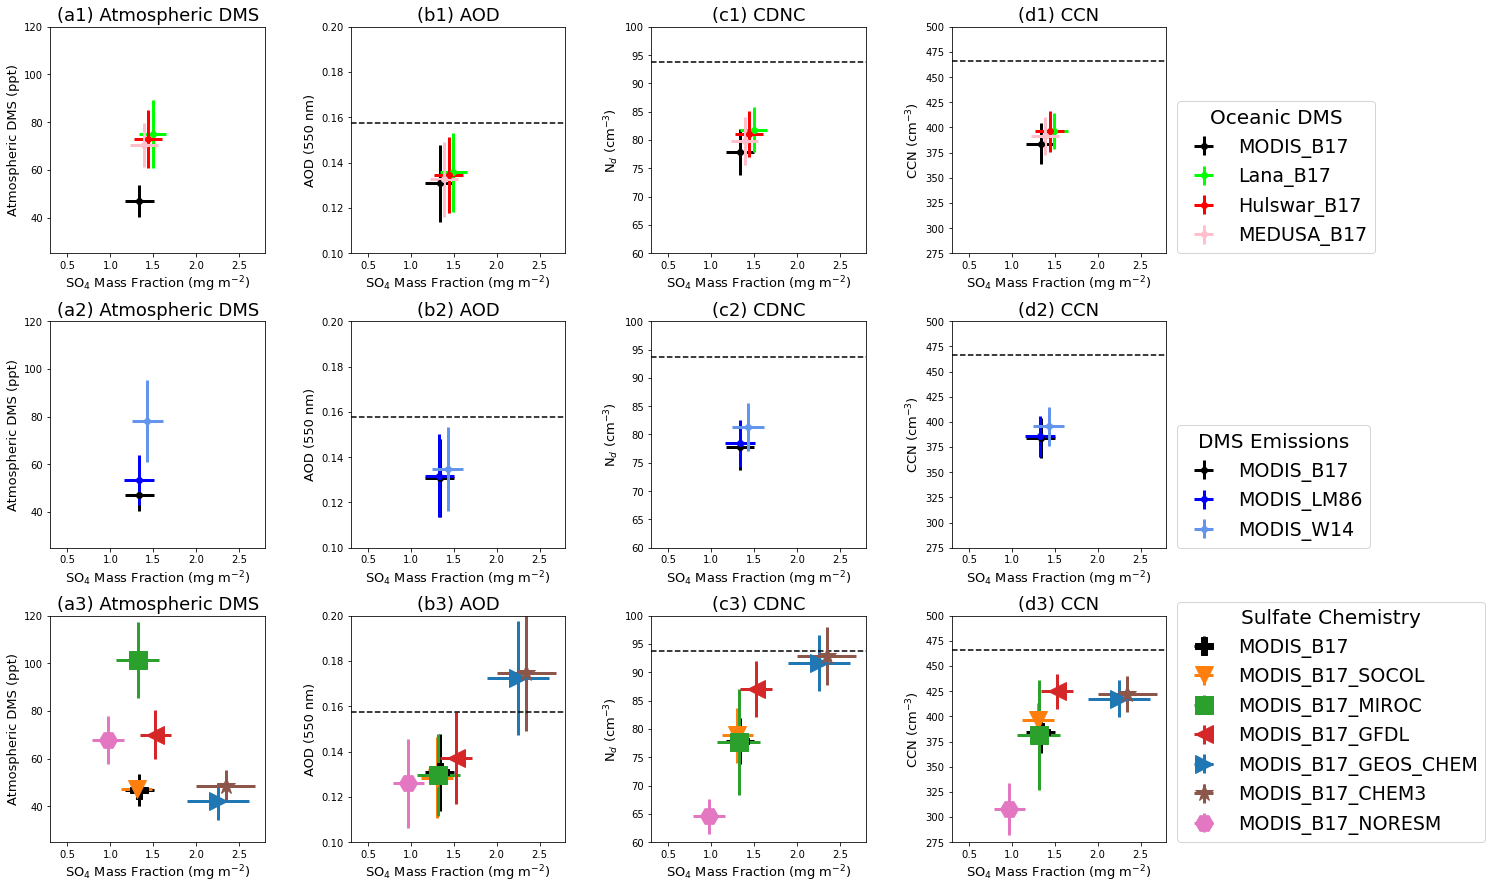

In [24]:
##### import numpy.ma as ma
labels=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labelss=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
#colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','pink','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

#colourss=['aqua','lightblue','teal','aquamarine','lime','orange','purple','blue','cornflowerblue']
AOD=np.zeros(len(labels)); AOD[:] = np.nan
AOD_std=np.zeros(len(labels)); AOD_std[:] = np.nan

CCN=np.zeros(len(labels)); CCN[:] = np.nan
CCN_std=np.zeros(len(labels)); CCN_std[:] = np.nan

rf=np.zeros(len(labels)); rf[:] = np.nan
rf_std=np.zeros(len(labels)); rf_std[:] = np.nan
sw=np.zeros(len(labels)); sw[:] = np.nan
sw_std=np.zeros(len(labels)); sw_std[:] = np.nan

aod=np.zeros(len(labels)); aod[:] = np.nan
aod_std=np.zeros(len(labels)); aod_std[:] = np.nan

cdnc=np.zeros(len(labels)); cdnc[:] = np.nan
cdnc_std=np.zeros(len(labels)); cdnc_std[:] = np.nan

dms_f=np.zeros(len(labels)); dms_f[:] = np.nan
dms_f_std=np.zeros(len(labels)); dms_f_std[:] = np.nan

dms=np.zeros(len(labels)); dms[:] = np.nan
dms_std=np.zeros(len(labels)); dms_std[:] = np.nan

dms_o=np.zeros(len(labels)); dms_o[:] = np.nan
dms_o_std=np.zeros(len(labels)); dms_o_std[:] = np.nan

so2=np.zeros(len(labels)); so2[:] = np.nan
so2_std=np.zeros(len(labels)); so2_std[:] = np.nan

seasons = ['DJF', 'MAM', 'JJA', 'SON']
H2SO4=np.zeros(len(labels)); H2SO4[:] = np.nan
H2SO4_std=np.zeros(len(labels)); H2SO4_std[:] = np.nan


for i in range(0,(len(labels))):
    ####  AOD ###
                   
    aod_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/Global/{}.npy'.format(labels[i]))
    AOD[i]=np.nanmean((aod_data[:]))
    AOD_std[i]=np.nanstd((aod_data[:]))

    ####  CCN ###
                   
    ccn_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CCN/Global/{}.npy'.format(labels[i]))
    CCN[i]=np.nanmean((ccn_data[:]))
    CCN_std[i]=np.nanstd((ccn_data[:]))
    ####  DMS FLUX ###
                   
    dms_flux_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/DMS_EMISSIONS/Global/{}.npy'.format(labels[i])) * to_umol_day
    #if dms_flux_data.ndim == 1:
    dms_f[i]=np.nanmean((dms_flux_data[:])) 
    dms_f_std[i]=np.nanstd((dms_flux_data[:])) 
    #else:
    ####  OCEANIC DMS ###
                   
#     oceanic_dms_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/OCEANIC_DMS/Global/{}.npy'.format(labels[i])) 
#     if oceanic_dms_data.ndim == 2:
#         dms_o[i] = np.nanmean(oceanic_dms_data[:,[11,0,1]])
#         dms_o_std[i] = np.nanstd(oceanic_dms_data[:,[11,0,1]])
#     else:
#         dms_o[i]=np.nanmean((oceanic_dms_data[[11,0,1]]))
#         dms_o_std[i] = np.nanstd(oceanic_dms_data[[11,0,1]])
    ####  SO4 ###
                   
    h2so4_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_load/Global/{}.npy'.format(labels[i]))
    H2SO4[i]=np.nanmean(h2so4_data[:])*1e6
    H2SO4_std[i]=np.nanstd(h2so4_data[:])*1e6
    ####  Radiative Forcing  ###
                   
    rf_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/Global/{}.npy'.format(labels[i]))
    #if rf_cl.ndim == 1:
    rf[i]=np.nanmean(rf_cl[:]) 
    rf_std[i]=np.nanstd(rf_cl[:]) 
    sw_cl=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/SW/All_Sky/Global/{}.npy'.format(labels[i]))
    #if rf_cl.ndim == 1:
    sw[i]=np.nanmean(sw_cl[:]) 
    sw_std[i]=np.nanstd(sw_cl[:]) 

#     else:
#         rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
#         rf_std[i]=np.nanstd(rf_cl[:,[11,0,1]]) 
    ####  CDNC  ###

    cdnc_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Global/{}.npy'.format(labels[i]))
    cdnc[i]=np.nanmean(cdnc_data[:]) 
    cdnc_std[i]=np.nanstd(cdnc_data[:]) 
    ####  ATMOS DMS ###
                   
    dmsy=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/Global/{}.npy'.format(labels[i]))
    dms[i]=np.nanmean(dmsy[:])*dms_ppt
    dms_std[i]=np.nanstd(dmsy[:])*dms_ppt
    ####  SO2 ###
                   
    SO2=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/Global/{}.npy'.format(labels[i]))
    so2[i]=np.nanmean(SO2[:])*dms_ppt
    so2_std[i]=np.nanstd(SO2[:])*dms_ppt
                   
# dms_flux_diff=[ccn_djf[0],ccn_djf[3],ccn_djf[6]]
# ocean_diff=[ccn_djf[0],ccn_djf[1],ccn_djf[5],ccn_djf[8]]
# chem_diff=[ccn_djf[0],ccn_djf[2],ccn_djf[4],ccn_djf[7]]
# #chem_diff=[H2SO4_djf[0],H2SO4_djf[4]]

# dms_flux_diff_std=[ccn_djf_std[0],ccn_djf_std[3],ccn_djf_std[6]]
# ocean_diff_std=[ccn_djf_std[0],ccn_djf_std[1],ccn_djf_std[5],ccn_djf_std[8]]
# chem_diff_std=[ccn_djf_std[0],ccn_djf_std[2],ccn_djf_std[4],ccn_djf_std[7]]

# colours_flux=['aqua','blue','cornflowerblue']
# colours_ocean=['aqua','lime','orange','purple']
# colours_chem=['aqua','teal','lightblue','aquamarine']

#colourss=['aqua','lime','teal','blue','lightblue','orange','cornflowerblue','aquamarine','purple']

fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

for i in range(0,4):
    axes[i].set_xlim(0.3,2.8)
    axes2[i].set_xlim(0.3,2.8)
    axes3[i].set_xlim(0.3,2.8)

    axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)

plt.subplots_adjust(wspace=0.4, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','<','>','^','o','^','o','P','v','s','<','>','*','H']

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
      #  axes[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        axes[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
      #  axes[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[3].errorbar(H2SO4[i],CCN[i],xerr=H2SO4_std[i],yerr=CCN_std[i], fmt='o',linewidth=3,color=colourss[i])
    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
         #   axes3[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[3].errorbar(H2SO4[i],CCN[i],xerr=H2SO4_std[i],yerr=CCN_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])


          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
         #   axes2[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[3].errorbar(H2SO4[i],CCN[i],xerr=H2SO4_std[i],yerr=CCN_std[i], fmt='o',linewidth=3,color=colourss[i])

     #   print(formatu[i])
       # axes3[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt=formatu[i], markersize=18,color=colourss[i])


#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
label_sub=['1','2','3']
for n in range(0,3):
    ax[n][0].set_title('(a{}) Atmospheric DMS'.format(label_sub[n]),fontsize=18)
    ax[n][1].set_title('(b{}) AOD'.format(label_sub[n]),fontsize=18)
    ax[n][2].set_title('(c{}) CDNC'.format(label_sub[n]),fontsize=18)
    ax[n][3].set_title('(d{}) CCN'.format(label_sub[n]),fontsize=18)
 #   ax[n][4].set_title('(e{}) All Sky Shortwave'.format(label_sub[n]),fontsize=18)
    ax[n][0].set_ylim(25,120)
    ax[n][1].set_ylim(0.10,0.2)
    ax[n][2].set_ylim(60,100)
    ax[n][3].set_ylim(275,500)
    #ax[n][4].set_ylim(90,110)

    ax[n][0].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('CCN (cm$^{-3}$)',fontsize=13)
   # ax[n][4].set_ylabel('W m$^{-2}$',fontsize=13)

    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


#labelss=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14','MODIS_B17_NORESM','MEDUSA_B17']
#labelss=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']

labely=np.array(labels)

# for i in range(0,len(labels)):
#     if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
#         axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#     else:
#         if i > np.where(labely == 'MODIS_W14')[0][0]:
#             axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#         else:
#             axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
legend1 = axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend2 = axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend3 = axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend1.set_title('Oceanic DMS', prop={'size': 20})
legend2.set_title('DMS Emissions', prop={'size': 20})
legend3.set_title('Sulfate Chemistry', prop={'size': 20})


#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
# axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)

aod_global=np.nanmean(modis_areaweight_global)
axes[1].axhline(y=aod_global, color='black', linestyle='--')
axes2[1].axhline(y=aod_global, color='black', linestyle='--')
axes3[1].axhline(y=aod_global, color='black', linestyle='--')

#cdnc_global=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
obs_lat=obs.lat
cdnc_global=areaweight(obs,obs_lat)
axes[2].axhline(y=cdnc_global, color='black', linestyle='--')
axes2[2].axhline(y=cdnc_global, color='black', linestyle='--')
axes3[2].axhline(y=cdnc_global, color='black', linestyle='--')

# cdnc_br17_mean=cdnc_br17.groupby('time.month')
# cdnc_global=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
# axes[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes2[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes3[2].axhline(y=cdnc_global, color='black', linestyle='--')
# obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
# obs_lat=obs.lat
# ccn_global_obs=areaweight(obs,obs_lat)

ccn_lat=ccn_obs_uk.lat
obs_ccn=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
ccn_global_obs=areaweight(obs_ccn,ccn_obs_uk.lat)
axes[3].axhline(y=ccn_global_obs, color='black', linestyle='--')
axes2[3].axhline(y=ccn_global_obs, color='black', linestyle='--')
axes3[3].axhline(y=ccn_global_obs, color='black', linestyle='--')

#SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
#SW_OBS = SW_OBS.sel(lat=slice(-61, -40))
#SW_OBS = SW_OBS.sel(time=(SW_OBS['time'].dt.month.isin([1, 2, 12])))
# SW_Mean=areaweight(SW_OBS,modis_lat[:]).mean()
# axes[4].axhline(y=SW_Mean, color='black', linestyle='--')
# axes2[4].axhline(y=SW_Mean, color='black', linestyle='--')
# axes3[4].axhline(y=SW_Mean, color='black', linestyle='--')

# Move the legend to the outside (right side) of the subplots
#legend.set_bbox_to_anchor((1.05, 0.5))

# legend_bbox = legend.get_bbox_to_anchor().transformed(fig.transFigure)
# legend.set_bbox_to_anchor(legend_bbox, bbox_transform=fig.transFigure)

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_Physical_vs_Chemical.png",dpi=300,bbox_inches = 'tight')


In [496]:
labels=['MODIS$_{B17}$','Lana$_{B17}$','Hulswar$_{B17}$','MEDUSA$_{B17}$',
        'MODIS$_{B17}$','MODIS$_{LM86}$','MODIS$_{W14}$',
        'MODIS$_{B17}$','MODIS$_{B17}$SOCOL','MODIS$_{B17}$MIROC','MODIS$_{B17}$GFDL','MODIS$_{B17}$GEOS-CHEM','MODIS$_{B17}$CHEM3','MODIS$_{B17}$NORESM']

dms_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_std.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
sw_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_std.npy')
AOD_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_std.npy')
rf_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_std.npy')
CCN_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_std.npy')
H2SO4_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_std.npy')
cdnc_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_std.npy')
so2_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_std.npy')/so2_ppt)*kg_to_tg)*(32.06/(32.00+32.06))
dms_flux_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_Flux_std.npy')*to_umol_day

dms=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
sw=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw.npy')
AOD=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD.npy')
rf=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf.npy')
CCN=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN.npy')
H2SO4=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/SO4.npy')
cdnc=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CDNC.npy')
so2=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/SO2.npy')/so2_ppt)*kg_to_gg)*(32.06/(32.00+32.06))
dms_flux=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_Flux.npy')*to_umol_day*(32.065/62.13)


AOD_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_sh.npy')
CCN_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_sh.npy')
rf_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_sh.npy')
sw_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_sh.npy')
aod_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/aod_sh.npy')
cdnc_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_sh.npy')
dms_flux_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_flux_sh.npy')*to_umol_day*(32.065/62.13)
dms_sh=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_sh.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
so2_sh=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_sh.npy')/so2_ppt)*kg_to_gg)*(32.06/(32.00+32.06))
H2SO4_sh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_sh.npy')

AOD_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_sh_std.npy')
CCN_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_sh_std.npy')
rf_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_sh_std.npy')
sw_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_sh_std.npy')
aod_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/aod_sh_std.npy')
cdnc_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_sh_std.npy')
dms_flux_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_flux_sh_std.npy')*to_umol_day*(32.065/62.13)
dms_sh_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_sh_std.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
so2_sh_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_sh_std.npy')/so2_ppt)*kg_to_gg)*(32.06/(32.00+32.06))
H2SO4_sh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_sh_std.npy')

AOD_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_nh.npy')
CCN_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_nh.npy')
rf_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_nh.npy')
sw_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_nh.npy')
aod_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/aod_nh.npy')
cdnc_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_nh.npy')
dms_flux_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_flux_nh.npy')*to_umol_day*(32.065/62.13)
dms_nh=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_nh.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
so2_nh=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_nh.npy')/so2_ppt)*kg_to_gg)*(32.06/(32.00+32.06))
H2SO4_nh=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_nh.npy')

AOD_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_nh_std.npy')
CCN_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_nh_std.npy')
rf_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_nh_std.npy')
sw_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_nh_std.npy')
aod_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/aod_nh_std.npy')
cdnc_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_nh_std.npy')
dms_flux_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_flux_nh_std.npy')*to_umol_day*(32.065/62.13)
dms_nh_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/dms_nh_std.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
so2_nh_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_nh_std.npy')/so2_ppt)*kg_to_gg)*(32.06/(32.00+32.06))
H2SO4_nh_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_nh_std.npy')
lowernh=0; uppernh = 90
NH_lats = lats.sel(latitude=slice(lowernh, uppernh))
lowersh=-90; uppersh = 0
SH_lats = lats.sel(latitude=slice(lowersh, uppersh))

aod_global=np.nanmean(modis_areaweight_global).data
modis__NH=areaweight(modis_aod_observations.mean('time').sel(lat=slice(lowernh, uppernh)),modis_aod_observations_lat.sel(lat=slice(lowernh, uppernh))).data
modis__SH=areaweight(modis_aod_observations.mean('time').sel(lat=slice(lowersh, uppersh)),modis_aod_observations_lat.sel(lat=slice(lowersh, uppersh))).data

ccn_lat=ccn_obs_uk.lat
obs_ccn=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
ccn_global_obs=areaweight(obs_ccn,ccn_obs_uk.lat).data

ccn_global_obs_NH=areaweight(obs_ccn[96:120],ccn_obs_uk.lat[96:120]).data
ccn_global_obs_SH=areaweight(obs_ccn[23:48],ccn_obs_uk.lat[23:48]).data


# AOD values AND bias also for CCN
# for i in range(0,len(labels)):
#     print('{} = {:.3f} & {:.3f} & {:.0f} & {:.0f} & {:.3f} & {:.3f} & {:.0f} & {:.0f} & {:.3f} & {:.3f} & {:.0f} & {:.0f} \\'
#           .format(labels[i],AOD[i],AOD[i]-aod_global,CCN[i],CCN[i]-ccn_global_obs,AOD_nh[i],AOD_nh[i]-modis__NH,CCN_nh[i],CCN_nh[i]-ccn_global_obs_NH,AOD_sh[i],AOD_sh[i]-modis__SH,CCN_sh[i],CCN_sh[i]-ccn_global_obs_SH))

# AOD bias also for CCN
for i in range(0,len(labels)):
    print("{} & {:.3f} & {:.0f} & {:.3f} & {:.0f} & {:.3f} & {:.0f} \ \ "
          .format(labels[i],AOD[i]-aod_global,CCN[i]-ccn_global_obs,AOD_nh[i]-modis__NH,CCN_nh[i]-ccn_global_obs_NH,AOD_sh[i]-modis__SH,CCN_sh[i]-ccn_global_obs_SH))

# for i in range(0,len(labels)):
#     print('global {} = {:.1f} & {:.1f} & {:.1f}'
#           .format(labels[i],dms[i]/so2[i]*100,dms_nh[i]/so2[i]*100,dms_sh[i]/so2[i]*100))

# print('OBS')
# print('global CCN = & {:.0f} & {:.0f} & {:.0f}'.format(ccn_global_obs.data,ccn_global_obs_NH.data,ccn_global_obs_SH.data))

# print('--------------')
# for i in range(0,len(labels)):
#     print('global {} AOD = & & {:.3f} & & {:.3f} & & {:.3f}'.format(labels[i],AOD[i],AOD_nh[i],AOD_sh[i]))
# print('OBS')
# print('global MODIS-AOD = & {:.3f} & {:.3f} & {:.3f}'.format(aod_global,modis__NH.data,modis__SH.data))

    
#################################################

# Calculating the S in DMS from global, NH and SH

###################################################
# lowersh=-60; uppersh=-30
# lowernh=0; uppernh=90
# #for i in range(0,len(labels)):

# AOD_file=globals().get(labels[i]+'_file')

# # dms=xr.open_dataset('{}../Annual_Processed/DMS_Mass_Mixing_Ratio.nc'.format(AOD_file)).mass_fraction_of_dimethyl_sulfide_in_air*(kg_to_gg)*(32.065/62.13)
# # so2=xr.open_dataset('{}../Annual_Processed/SO2_MASS_MIXING_RATIO.nc'.format(AOD_file)).mass_fraction_of_sulfur_dioxide_in_air*(kg_to_gg)*(32.06/(32.00+32.06))
# # h2so4=xr.open_dataset('{}../Annual_Processed/H2SO4_Mass_Mixing_Ratio.nc'.format(AOD_file)).mass_fraction_of_sulfuric_acid_in_air*(kg_to_gg)*(32.06/((2*1.008)+32.06+(4*16)))
# # h2so4=xr.open_dataset('{}../Annual_Processed/H2SO4_Mass_Mixing_Ratio.nc'.format(AOD_file)).mass_fraction_of_sulfuric_acid_in_air*(kg_to_gg)*(32.06+(4*16)/((2*1.008)+32.06+(4*16)))

# dms=xr.open_dataset('{}../Annual_Processed/DMS_Mass_Mixing_Ratio.nc'.format(AOD_file)).mass_fraction_of_dimethyl_sulfide_in_air*(kg_to_gg)*(32.065/62.13)
# so2=xr.open_dataset('{}../Annual_Processed/SO2_MASS_MIXING_RATIO.nc'.format(AOD_file)).mass_fraction_of_sulfur_dioxide_in_air*(kg_to_gg)*(32.06/(32.00+32.06))

# try:
#     dms = dms.sel(model_level_number=1)
# except:
#     pass
# try:
#     so2 = so2.sel(model_level_number=1)
# except:
#     pass
# try:
#     h2so4 = h2so4.sel(model_level_number=1)
# except:
#     pass

# dms_=dms.mean('time')
# dms_s=dms_.sel(latitude=slice(lowersh, uppersh))
# dms_n=dms_.sel(latitude=slice(lowernh, uppernh))

# so2_=so2.mean('time')
# so2_s=so2_.sel(latitude=slice(lowersh, uppersh))
# so2_n=so2_.sel(latitude=slice(lowernh, uppernh))


# global_sulfate_burden_dms = dms_.sum(dim=['latitude', 'longitude']).data
# global_sulfate_burden_dms_s = dms_s.sum(dim=['latitude', 'longitude']).data
# global_sulfate_burden_dms_n = dms_n.sum(dim=['latitude', 'longitude']).data

# global_sulfur = so2_.sum(dim=['latitude', 'longitude']).data
# global_sulfur_s = so2_s.sum(dim=['latitude', 'longitude']).data
# global_sulfur_n = so2_n.sum(dim=['latitude', 'longitude']).data

# print('{} & {:.1f} & {:.1f} & {:.1f}'.format(labels[i],((global_sulfate_burden_dms/global_sulfur)*100),((global_sulfate_burden_dms_n/global_sulfur)*100),((global_sulfate_burden_dms_s/global_sulfur)*100)))
# # print((global_sulfate_burden_dms/global_sulfur)*100)
# # print((global_sulfate_burden_dms_s/global_sulfur)*100)
# # print((global_sulfate_burden_dms_n/global_sulfur)*100)


MODIS$_{B17}$  -0.020 & -82 & -0.045 & -55 & -0.006 & -179 \ \ 
Lan$_{B17}$  -0.015 & -70 & -0.033 & -49 & -0.003 & -170 \ \ 
Hulswar$_{B17}$  -0.017 & -70 & -0.043 & -54 & -0.003 & -170 \ \ 
MEDUSA$_{B17}$  -0.018 & -75 & -0.044 & -56 & -0.002 & -163 \ \ 
MODIS$_{B17}$  -0.020 & -82 & -0.045 & -55 & -0.006 & -179 \ \ 
MODIS$_{LM86}$  -0.019 & -81 & -0.036 & -47 & -0.006 & -174 \ \ 
MODIS$_{W14}$  -0.016 & -71 & -0.033 & -41 & -0.003 & -162 \ \ 
MODIS$_{B17}$  -0.020 & -82 & -0.045 & -55 & -0.006 & -179 \ \ 
MODIS$_{B17}$SOCOL  -0.023 & -69 & -0.050 & -7 & -0.009 & -180 \ \ 
MODIS$_{B17}$MIROC  -0.021 & -85 & -0.046 & -61 & -0.007 & -176 \ \ 
MODIS$_{B17}$GFDL  -0.014 & -42 & -0.037 & 22 & -0.008 & -147 \ \ 
MODIS$_{B17}$GEOS-CHEM  0.021 & -49 & 0.008 & -1 & 0.001 & -164 \ \ 
MODIS$_{B17}$CHEM3  0.024 & -44 & 0.010 & -0 & 0.003 & -159 \ \ 
MODIS$_{B17}$NORESM  -0.025 & -157 & -0.057 & -155 & -0.005 & -204 \ \ 


---------------
DMS Sulfate ----------
MODIS_B17=8.331041392302007
Lana_B17=11.055388140868297
Hulswar_B17=11.746381831331481
MEDUSA_B17=11.479512278568658
MODIS_B17=8.331041392302007
MODIS_LM86=8.09838797599542
MODIS_W14=11.661367331594608
MODIS_B17=8.331041392302007
MODIS_B17_SOCOL=7.759103905777537
MODIS_B17_MIROC=16.864734930756825
MODIS_B17_GFDL=12.403218103922937
MODIS_B17_GEOS_CHEM=6.984465750298218
MODIS_B17_CHEM3=8.086130497552622
MODIS_B17_NORESM=13.567107664026812
---------------
CCN SENSITIVITY TO DMS FLUX ----------
Abs = MODIS_B17=nan
rel = MODIS_B17=nan
Abs = Lana_B17=0.45875713239210064
rel = Lana_B17=0.06649944274444332
Abs = Hulswar_B17=0.4854134339635557
rel = Hulswar_B17=0.0703634245225283
Abs = MEDUSA_B17=0.33531282537775664
rel = MEDUSA_B17=0.04860549179130235
Abs = MODIS_B17=nan
rel = MODIS_B17=nan
Abs = MODIS_LM86=0.4786544729175061
rel = MODIS_LM86=0.06938367486555831
Abs = MODIS_W14=0.37387383829902465
rel = MODIS_W14=0.05419512885602683
Abs = MODIS_B17=nan
re

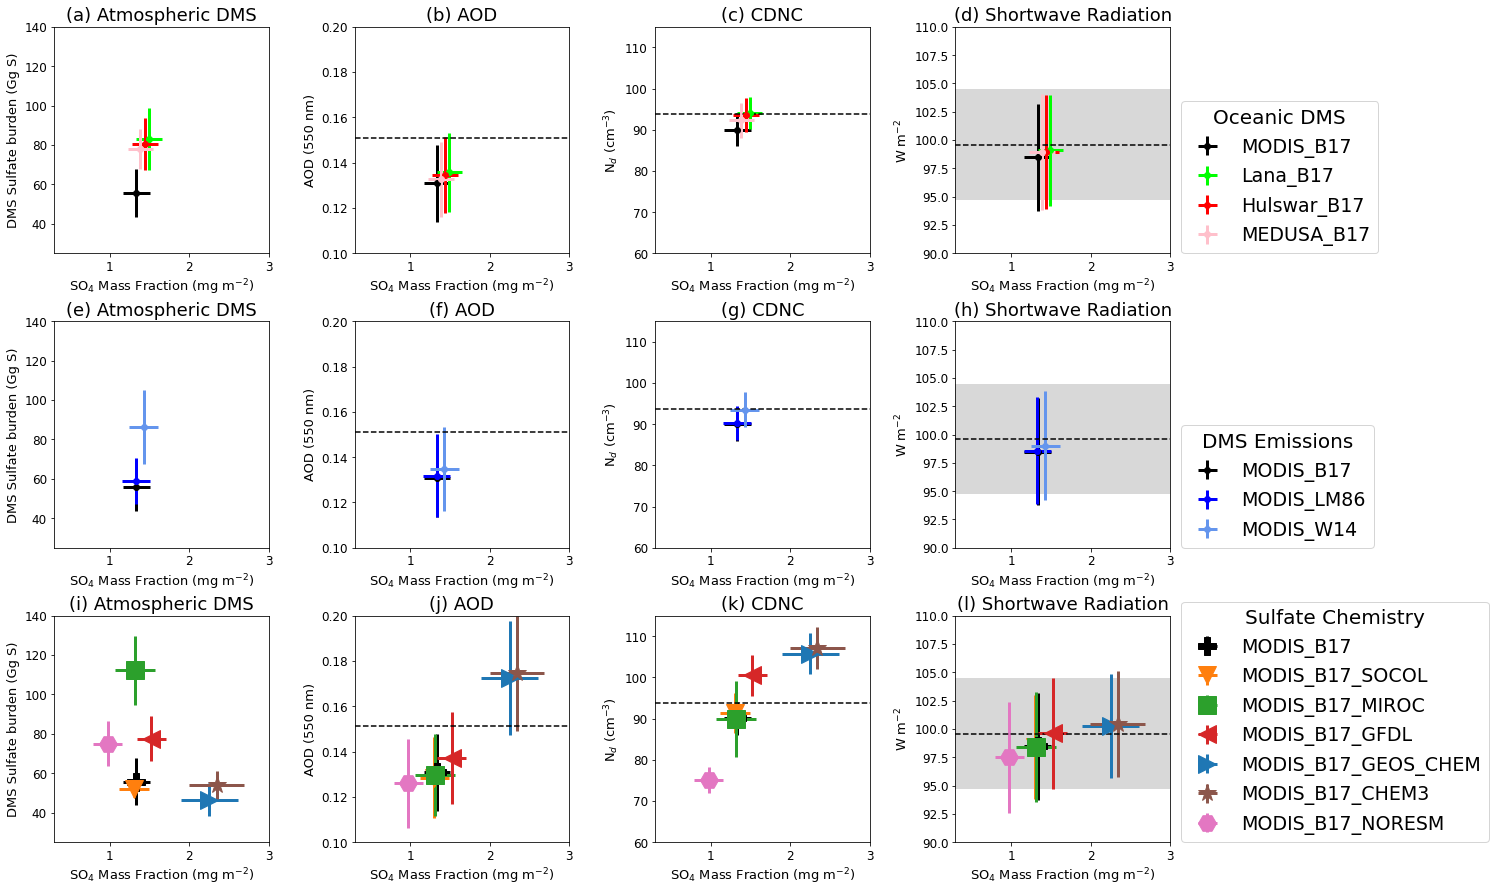

In [64]:
##### import numpy.ma as ma
#labels=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labels=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
import string
kg_to_gg=(1e12)
kg_to_tg=(1e9)

# #colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','pink','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
dms_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_std.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
sw_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_std.npy')
AOD_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_std.npy')
rf_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_std.npy')
CCN_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_std.npy')
H2SO4_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_std.npy')
cdnc_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_std.npy')
so2_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_std.npy')/so2_ppt)*kg_to_tg)*(32.06/(32.00+32.06))
dms_flux_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_Flux_std.npy')*to_umol_day

dms=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
sw=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw.npy')
AOD=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD.npy')
rf=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf.npy')
CCN=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN.npy')
H2SO4=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/SO4.npy')
cdnc=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CDNC.npy')
so2=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/SO2.npy')/so2_ppt)*kg_to_tg)*(32.06/(32.00+32.06))
dms=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
dms_flux=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_Flux.npy')*to_umol_day

print('---------------')
print('DMS Sulfate ----------')


for i in range(0,len(labels)):
    b=((dms[i]/1000)/so2[i])*100
    print('{}={}'.format(labels[i],b))
    
print('---------------')
print('CCN SENSITIVITY TO DMS FLUX ----------')

for i in range(0,len(labels)):
    dms_f=dms_flux[i]-dms_flux[0]
    dms_f_rel=(dms_f/dms_flux[0])

    ccn_d=CCN[i]-CCN[0]
    ccn_d_rel=(ccn_d/CCN[0])

#     print('Abs = {}={}'.format(labels[i],ccn_d/dms_f))
#     print('rel = {}={}'.format(labels[i],ccn_d_rel/dms_f_rel))
    
for i in range(0,len(labels)):
    dms_f=dms[i]-dms[0]
    dms_f_rel=(dms_f/dms[0])

    
    ccn_d=CCN[i]-CCN[0]
    ccn_d_rel=(ccn_d/CCN[0])

    print('Abs = {}={}'.format(labels[i],ccn_d/dms_f))
    print('rel = {}={}'.format(labels[i],ccn_d_rel/dms_f_rel))


# AOD=np.zeros(len(labels)); AOD[:] = np.nan
# AOD_std=np.zeros(len(labels)); AOD_std[:] = np.nan

# CCN=np.zeros(len(labels)); CCN[:] = np.nan
# CCN_std=np.zeros(len(labels)); CCN_std[:] = np.nan

# rf=np.zeros(len(labels)); rf[:] = np.nan
# rf_std=np.zeros(len(labels)); rf_std[:] = np.nan
# sw=np.zeros(len(labels)); sw[:] = np.nan
# sw_std=np.zeros(len(labels)); sw_std[:] = np.nan

# aod=np.zeros(len(labels)); aod[:] = np.nan
# aod_std=np.zeros(len(labels)); aod_std[:] = np.nan

# cdnc=np.zeros(len(labels)); cdnc[:] = np.nan
# cdnc_std=np.zeros(len(labels)); cdnc_std[:] = np.nan

# dms_f=np.zeros(len(labels)); dms_f[:] = np.nan
# dms_f_std=np.zeros(len(labels)); dms_f_std[:] = np.nan

# dms=np.zeros(len(labels)); dms[:] = np.nan
# dms_std=np.zeros(len(labels)); dms_std[:] = np.nan

# dms_o=np.zeros(len(labels)); dms_o[:] = np.nan
# dms_o_std=np.zeros(len(labels)); dms_o_std[:] = np.nan

# so2=np.zeros(len(labels)); so2[:] = np.nan
# so2_std=np.zeros(len(labels)); so2_std[:] = np.nan

# seasons = ['DJF', 'MAM', 'JJA', 'SON']
# H2SO4=np.zeros(len(labels)); H2SO4[:] = np.nan
# H2SO4_std=np.zeros(len(labels)); H2SO4_std[:] = np.nan
# lower=30; upper = 60
# sh_lats = lats.sel(latitude=slice(lower, upper))


# for i in range(0,(len(labels))):
#     ####  AOD ###
#     AOD_file=globals().get(labels[i]+'_file')
    
#     aod_data=xr.open_dataset(AOD_file+'../AOD.nc')['__xarray_dataarray_variable__']
#     if len(aod_data.time) < 730:
#         print('no for {}'.format(labels[i]))
#     else:
        
#         try:
#             aod_data = aod_data.sel(model_level_number=1)
#         except:
#             pass
#         aod_data = aod_data.sel(latitude=slice(lower, upper))

#         AOD[i]=areaweight(aod_data.mean('time'),sh_lats)
#         AOD_std[i]=areaweight(aod_data,sh_lats).std()


#     ####  CCN ###
#     ccn_data=xr.open_dataset(AOD_file+'../Annual_Processed/ccn_concentration_25r.nc')['m01s38i439']
#     try:
#         ccn_data = ccn_data.sel(model_level_number=10)
#     except:
#         pass
#     ccn_data = ccn_data.sel(latitude=slice(lower, upper))

#     CCN[i]=areaweight(ccn_data.mean('time'),sh_lats)
#     CCN_std[i]=areaweight(ccn_data,sh_lats).std()

#     ####  SO4 ###
    
#     so4_data=xr.open_dataset(AOD_file+'../Annual_Processed/Total_H2SO4_load.nc')['m01s38i520']*1e6
#     try:
#         so4_data = so4_data.sel(model_level_number=1)
#     except:
#         pass
#     so4_data = so4_data.sel(latitude=slice(lower, upper))

#     so4_data = so4_data.transpose('time','latitude','longitude')
#     H2SO4[i]=areaweight(so4_data.mean('time'),sh_lats)
#     H2SO4_std[i]=areaweight(so4_data,sh_lats).std()

#     ####  CDNC  ###
    
#     cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/CDNC.nc')['__xarray_dataarray_variable__']
#     try:
#         cdnc_data = cdnc_data.sel(model_level_number=1)
#     except:
#         pass
#     if len(aod_data.time) < 730:
#         print('no for {}'.format(labels[i]))
#     else:
#         pass
#     cdnc_data = cdnc_data.sel(latitude=slice(lower, upper))

#     cdnc[i]=areaweight(cdnc_data.mean('time'),sh_lats)
#     cdnc_std[i]=areaweight(cdnc_data,sh_lats).std()
    
#     ####  ATMOS DMS ###
    
#     dms_data=xr.open_dataset(AOD_file+'../Annual_Processed/DMS_Mass_Mixing_Ratio.nc')['mass_fraction_of_dimethyl_sulfide_in_air']*dms_ppt
#     try:
#         dms_data = dms_data.sel(model_level_number=1)
#     except:
#         pass
#     dms_data = dms_data.transpose('time','latitude','longitude')
#     dms_data = dms_data.sel(latitude=slice(lower, upper))
#     dms[i]=areaweight(dms_data.mean('time'),sh_lats)
#     dms_std[i]=areaweight(dms_data,sh_lats).std()
#     ####  SO2 ###
    
#     so2_data=xr.open_dataset(AOD_file+'../Annual_Processed/SO2_MASS_MIXING_RATIO.nc')['mass_fraction_of_sulfur_dioxide_in_air']*so2_ppt
#     try:
#         so2_data = so2_data.sel(model_level_number=1)
#     except:
#         pass
#     so2_data = so2_data.transpose('time','latitude','longitude')
#     so2_data = so2_data.sel(latitude=slice(lower, upper))
#     so2[i]=areaweight(so2_data.mean('time'),sh_lats)
#     so2_std[i]=areaweight(so2_data,sh_lats).std()
    
#     cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/ALL_SKY_OUTGOING_SW_FLUX_TOA.nc')['toa_outgoing_shortwave_flux']
#     try:
#         cdnc_data = cdnc_data.sel(model_level_number=1)
#     except:
#         pass
#     cdnc_data = cdnc_data.sel(latitude=slice(lower, upper))
#     sw[i]=areaweight(cdnc_data.mean('time'),sh_lats)
#     sw_std[i]=areaweight(cdnc_data,sh_lats).std()

    
#     cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/All_Sky_RF.nc')['__xarray_dataarray_variable__']
#     try:
#         cdnc_data = cdnc_data.sel(model_level_number=1)
#     except:
#         pass
#     cdnc_data = cdnc_data.sel(latitude=slice(lower, upper))
#     rf[i]=areaweight(cdnc_data.mean('time'),sh_lats)
#     rf_std[i]=areaweight(cdnc_data,sh_lats).std()
    
#     dms_data=xr.open_dataset(AOD_file+'../Annual_Processed/DMS_SURF_EMISSIONS.nc')['m01s50i214']*to_umol_day*(32.065/62.13)
#     try:
#         dms_data = dms_data.sel(model_level_number=1)
#     except:
#         pass
#     dms_fluxs = dms_data.transpose('time','latitude','longitude')
#     dms_fluxs = dms_fluxs.sel(latitude=slice(lower, upper))

#     dms_f[i]=areaweight(dms_fluxs.mean('time'),sh_lats)
#     dms_f_std[i]=areaweight(dms_fluxs,sh_lats).std()
#     print(labels[i])

#
                   
# dms_flux_diff=[ccn_djf[0],ccn_djf[3],ccn_djf[6]]
# ocean_diff=[ccn_djf[0],ccn_djf[1],ccn_djf[5],ccn_djf[8]]
# chem_diff=[ccn_djf[0],ccn_djf[2],ccn_djf[4],ccn_djf[7]]
# #chem_diff=[H2SO4_djf[0],H2SO4_djf[4]]

# dms_flux_diff_std=[ccn_djf_std[0],ccn_djf_std[3],ccn_djf_std[6]]
# ocean_diff_std=[ccn_djf_std[0],ccn_djf_std[1],ccn_djf_std[5],ccn_djf_std[8]]
# chem_diff_std=[ccn_djf_std[0],ccn_djf_std[2],ccn_djf_std[4],ccn_djf_std[7]]

# colours_flux=['aqua','blue','cornflowerblue']
# colours_ocean=['aqua','lime','orange','purple']
# colours_chem=['aqua','teal','lightblue','aquamarine']

#colourss=['aqua','lime','teal','blue','lightblue','orange','cornflowerblue','aquamarine','purple']
#
fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

for i in range(0,4):
    axes[i].set_xlim(0.3,3)
    axes2[i].set_xlim(0.3,3)
    axes3[i].set_xlim(0.3,3)

    axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)

plt.subplots_adjust(wspace=0.4, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','<','>','^','o','^','o','P','v','s','<','>','*','H']

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
      #  axes[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        axes[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
      #  axes[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
         #   axes3[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])


          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(H2SO4[i],dms[i],xerr=H2SO4_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[2].errorbar(H2SO4[i],cdnc[i],xerr=H2SO4_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
         #   axes2[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[1].errorbar(H2SO4[i],AOD[i],xerr=H2SO4_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[3].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])

     #   print(formatu[i])
       # axes3[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt=formatu[i], markersize=18,color=colourss[i])

SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
SW_Mean=areaweight(SW_OBS,modis_lat[:]).mean()
SW_Mean_std=areaweight(SW_OBS,modis_lat[:]).std()

aod_global=np.nanmean(modis_areaweight_global)

obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
obs_lat=obs.lat
cdnc_global=areaweight(obs,obs_lat)

legend1 = axes[3].legend(labels[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend2 = axes2[3].legend(labels[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend3 = axes3[3].legend(labels[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend1.set_title('Oceanic DMS', prop={'size': 20})
legend2.set_title('DMS Emissions', prop={'size': 20})
legend3.set_title('Sulfate Chemistry', prop={'size': 20})


#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
letters = string.ascii_lowercase[:12]  # Select the first 9 lowercase letters
alpha = [str(letter) for letter in letters]
titley=['Atmospheric DMS','AOD','CDNC','Shortwave Radiation','Atmospheric DMS','AOD','CDNC','Shortwave Radiation','Atmospheric DMS','AOD','CDNC','Shortwave Radiation']
count=0
for n in range(0,3):
    for a in range(0,4):
        ax[n][a].set_title('({}) {}'.format(alpha[a+count],titley[a+count]),fontsize=18)
        ax[n][a].xaxis.set_tick_params(labelsize=12)
        ax[n][a].yaxis.set_tick_params(labelsize=12)

#         ax[n][1].set_title('({}) AOD'.format(alpha[a+1]),fontsize=18)
#         ax[n][2].set_title('({}) CDNC'.format(alpha[a+2]),fontsize=18)
#         ax[n][3].set_title('({}) CCN'.format(alpha[a+3]),fontsize=18)
 #   ax[n][4].set_title('(e{}) All Sky Shortwave'.format(label_sub[n]),fontsize=18)
    count=count+4

    ax[n][0].set_ylim(25,140)
    ax[n][1].set_ylim(0.10,0.20)
    ax[n][2].set_ylim(60,115)
    #ax[n][3].set_ylim(275,500)
    ax[n][3].set_ylim(90,110)

    ax[n][0].set_ylabel('DMS Sulfate burden (Gg S)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    #ax[n][3].set_ylabel('CCN (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('W m$^{-2}$',fontsize=13)
    ax[n][1].axhline(y=aod_global, color='black', linestyle='--')
    ax[n][2].axhline(y=cdnc_global, color='black', linestyle='--')
    ax[n][3].axhline(y=SW_Mean, color='black', linestyle='--')
    ax[n][3].axhspan(ymin=SW_Mean-SW_Mean_std, ymax=SW_Mean+SW_Mean_std, facecolor='grey', alpha=0.3)

    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


#labelss=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14','MODIS_B17_NORESM','MEDUSA_B17']
#labelss=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']

labely=np.array(labels)

# for i in range(0,len(labels)):
#     if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
#         axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#     else:
#         if i > np.where(labely == 'MODIS_W14')[0][0]:
#             axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#         else:
#             axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])


#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
# axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)


#cdnc_global=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
# axes2[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes3[2].axhline(y=cdnc_global, color='black', linestyle='--')

# cdnc_br17_mean=cdnc_br17.groupby('time.month')
# cdnc_global=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
# axes[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes2[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes3[2].axhline(y=cdnc_global, color='black', linestyle='--')
# obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
# obs_lat=obs.lat
# ccn_global_obs=areaweight(obs,obs_lat)

# ccn_lat=ccn_obs_uk.lat
# obs_ccn=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
# ccn_global_obs=areaweight(obs_ccn,ccn_obs_uk.lat)
# axes[3].axhline(y=ccn_global_obs, color='black', linestyle='--')
# axes2[3].axhline(y=ccn_global_obs, color='black', linestyle='--')
# axes3[3].axhline(y=ccn_global_obs, color='black', linestyle='--')


# axes[3].axhline(y=SW_Mean, color='black', linestyle='--')
# axes2[3].axhline(y=SW_Mean, color='black', linestyle='--')
# axes3[3].axhline(y=SW_Mean, color='black', linestyle='--')

# Move the legend to the outside (right side) of the subplots
#legend.set_bbox_to_anchor((1.05, 0.5))

# legend_bbox = legend.get_bbox_to_anchor().transformed(fig.transFigure)
# legend.set_bbox_to_anchor(legend_bbox, bbox_transform=fig.transFigure)

# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_Physical_vs_Chemical.png",dpi=300,bbox_inches = 'tight')
# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_Physical_vs_Chemical.pdf",dpi=500,bbox_inches = 'tight')


---------------
DMS Sulfate ----------
MODIS_B17=8.331041392302007
Lana_B17=11.055388140868297
Hulswar_B17=11.746381831331481
MEDUSA_B17=11.479512278568658
MODIS_B17=8.331041392302007
MODIS_LM86=8.09838797599542
MODIS_W14=11.661367331594608
MODIS_B17=8.331041392302007
MODIS_B17_SOCOL=7.759103905777537
MODIS_B17_MIROC=16.864734930756825
MODIS_B17_GFDL=12.403218103922937
MODIS_B17_GEOS_CHEM=6.984465750298218
MODIS_B17_CHEM3=8.086130497552622
MODIS_B17_NORESM=13.567107664026812
---------------
CCN SENSITIVITY TO DMS FLUX ----------
Abs = MODIS_B17=nan
rel = MODIS_B17=nan
Abs = Lana_B17=0.45875713239210064
rel = Lana_B17=0.06649944274444332
Abs = Hulswar_B17=0.4854134339635557
rel = Hulswar_B17=0.0703634245225283
Abs = MEDUSA_B17=0.33531282537775664
rel = MEDUSA_B17=0.04860549179130235
Abs = MODIS_B17=nan
rel = MODIS_B17=nan
Abs = MODIS_LM86=0.4786544729175061
rel = MODIS_LM86=0.06938367486555831
Abs = MODIS_W14=0.37387383829902465
rel = MODIS_W14=0.05419512885602683
Abs = MODIS_B17=nan
re

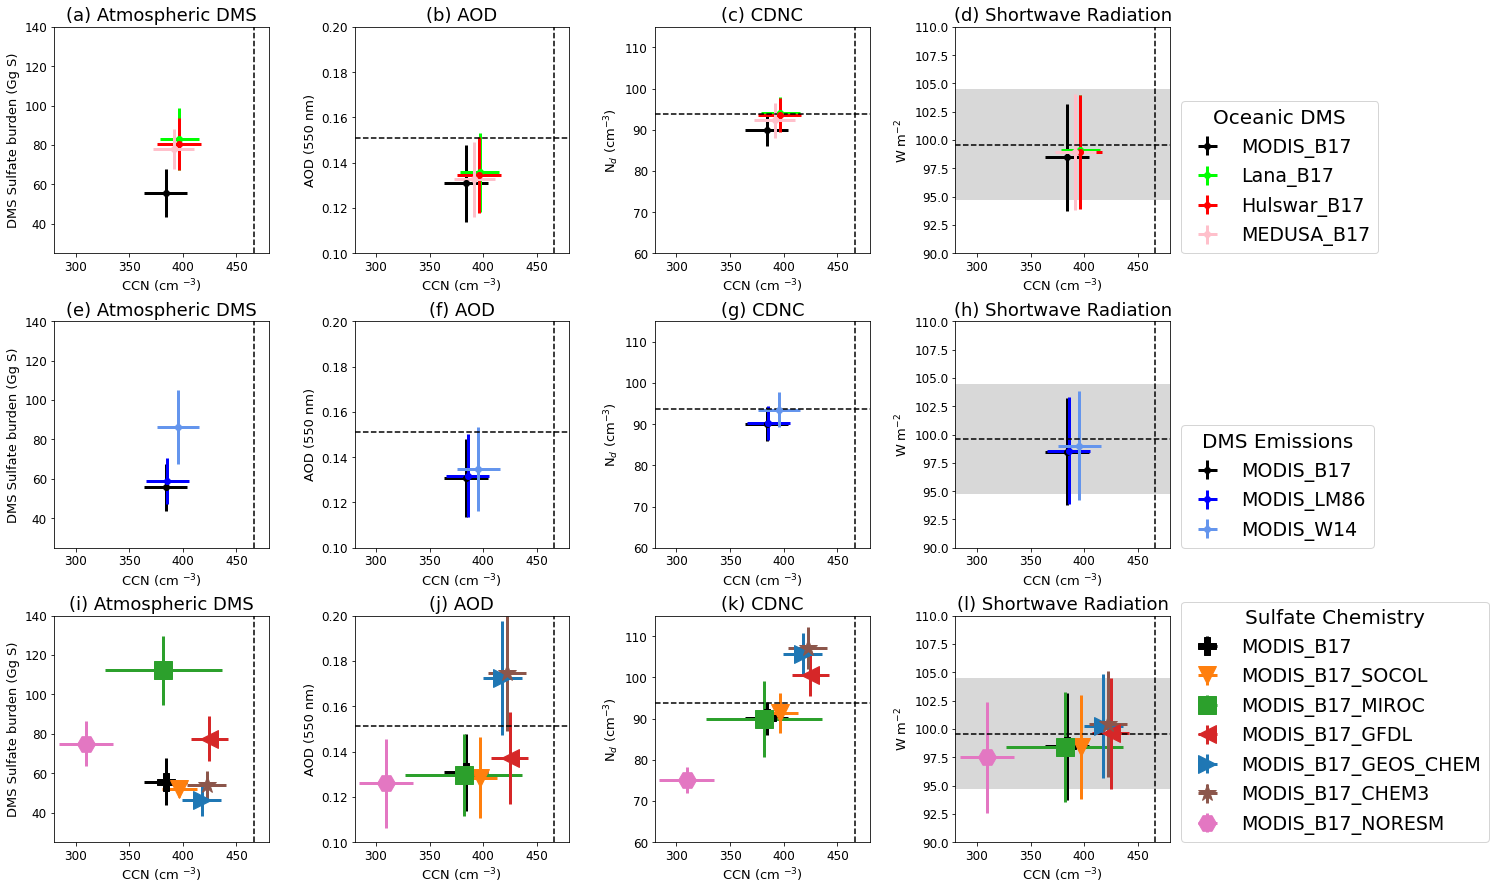

In [83]:
##### import numpy.ma as ma
#labels=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labels=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
import string
kg_to_gg=(1e12)
kg_to_tg=(1e9)

# #colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','pink','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
dms_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_std.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
sw_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw_std.npy')
AOD_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD_std.npy')
rf_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf_std.npy')
CCN_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN_std.npy')
H2SO4_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/H2SO4_std.npy')
cdnc_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/cdnc_std.npy')
so2_std=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/so2_std.npy')/so2_ppt)*kg_to_tg)*(32.06/(32.00+32.06))
dms_flux_std=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_Flux_std.npy')*to_umol_day

dms=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
sw=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/sw.npy')
AOD=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/AOD.npy')
rf=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/rf.npy')
CCN=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CCN.npy')
H2SO4=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/SO4.npy')
cdnc=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/CDNC.npy')
so2=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/SO2.npy')/so2_ppt)*kg_to_tg)*(32.06/(32.00+32.06))
dms=((np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS.npy')/dms_ppt)*kg_to_gg)*(32.065/62.13)
dms_flux=np.load('/home/ybh10/Objective_3/Postprocess_Data/Global_Scatter_Data/DMS_Flux.npy')*to_umol_day

print('---------------')
print('DMS Sulfate ----------')


for i in range(0,len(labels)):
    b=((dms[i]/1000)/so2[i])*100
    print('{}={}'.format(labels[i],b))
    
print('---------------')
print('CCN SENSITIVITY TO DMS FLUX ----------')

for i in range(0,len(labels)):
    dms_f=dms_flux[i]-dms_flux[0]
    dms_f_rel=(dms_f/dms_flux[0])

    ccn_d=CCN[i]-CCN[0]
    ccn_d_rel=(ccn_d/CCN[0])

#     print('Abs = {}={}'.format(labels[i],ccn_d/dms_f))
#     print('rel = {}={}'.format(labels[i],ccn_d_rel/dms_f_rel))
    
for i in range(0,len(labels)):
    dms_f=dms[i]-dms[0]
    dms_f_rel=(dms_f/dms[0])

    
    ccn_d=CCN[i]-CCN[0]
    ccn_d_rel=(ccn_d/CCN[0])

    print('Abs = {}={}'.format(labels[i],ccn_d/dms_f))
    print('rel = {}={}'.format(labels[i],ccn_d_rel/dms_f_rel))


# AOD=np.zeros(len(labels)); AOD[:] = np.nan
# AOD_std=np.zeros(len(labels)); AOD_std[:] = np.nan

# CCN=np.zeros(len(labels)); CCN[:] = np.nan
# CCN_std=np.zeros(len(labels)); CCN_std[:] = np.nan

# rf=np.zeros(len(labels)); rf[:] = np.nan
# rf_std=np.zeros(len(labels)); rf_std[:] = np.nan
# sw=np.zeros(len(labels)); sw[:] = np.nan
# sw_std=np.zeros(len(labels)); sw_std[:] = np.nan

# aod=np.zeros(len(labels)); aod[:] = np.nan
# aod_std=np.zeros(len(labels)); aod_std[:] = np.nan

# cdnc=np.zeros(len(labels)); cdnc[:] = np.nan
# cdnc_std=np.zeros(len(labels)); cdnc_std[:] = np.nan

# dms_f=np.zeros(len(labels)); dms_f[:] = np.nan
# dms_f_std=np.zeros(len(labels)); dms_f_std[:] = np.nan

# dms=np.zeros(len(labels)); dms[:] = np.nan
# dms_std=np.zeros(len(labels)); dms_std[:] = np.nan

# dms_o=np.zeros(len(labels)); dms_o[:] = np.nan
# dms_o_std=np.zeros(len(labels)); dms_o_std[:] = np.nan

# so2=np.zeros(len(labels)); so2[:] = np.nan
# so2_std=np.zeros(len(labels)); so2_std[:] = np.nan

# seasons = ['DJF', 'MAM', 'JJA', 'SON']
# H2SO4=np.zeros(len(labels)); H2SO4[:] = np.nan
# H2SO4_std=np.zeros(len(labels)); H2SO4_std[:] = np.nan
# lower=30; upper = 60
# sh_lats = lats.sel(latitude=slice(lower, upper))


# for i in range(0,(len(labels))):
#     ####  AOD ###
#     AOD_file=globals().get(labels[i]+'_file')
    
#     aod_data=xr.open_dataset(AOD_file+'../AOD.nc')['__xarray_dataarray_variable__']
#     if len(aod_data.time) < 730:
#         print('no for {}'.format(labels[i]))
#     else:
        
#         try:
#             aod_data = aod_data.sel(model_level_number=1)
#         except:
#             pass
#         aod_data = aod_data.sel(latitude=slice(lower, upper))

#         AOD[i]=areaweight(aod_data.mean('time'),sh_lats)
#         AOD_std[i]=areaweight(aod_data,sh_lats).std()


#     ####  CCN ###
#     ccn_data=xr.open_dataset(AOD_file+'../Annual_Processed/ccn_concentration_25r.nc')['m01s38i439']
#     try:
#         ccn_data = ccn_data.sel(model_level_number=10)
#     except:
#         pass
#     ccn_data = ccn_data.sel(latitude=slice(lower, upper))

#     CCN[i]=areaweight(ccn_data.mean('time'),sh_lats)
#     CCN_std[i]=areaweight(ccn_data,sh_lats).std()

#     ####  SO4 ###
    
#     so4_data=xr.open_dataset(AOD_file+'../Annual_Processed/Total_H2SO4_load.nc')['m01s38i520']*1e6
#     try:
#         so4_data = so4_data.sel(model_level_number=1)
#     except:
#         pass
#     so4_data = so4_data.sel(latitude=slice(lower, upper))

#     so4_data = so4_data.transpose('time','latitude','longitude')
#     H2SO4[i]=areaweight(so4_data.mean('time'),sh_lats)
#     H2SO4_std[i]=areaweight(so4_data,sh_lats).std()

#     ####  CDNC  ###
    
#     cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/CDNC.nc')['__xarray_dataarray_variable__']
#     try:
#         cdnc_data = cdnc_data.sel(model_level_number=1)
#     except:
#         pass
#     if len(aod_data.time) < 730:
#         print('no for {}'.format(labels[i]))
#     else:
#         pass
#     cdnc_data = cdnc_data.sel(latitude=slice(lower, upper))

#     cdnc[i]=areaweight(cdnc_data.mean('time'),sh_lats)
#     cdnc_std[i]=areaweight(cdnc_data,sh_lats).std()
    
#     ####  ATMOS DMS ###
    
#     dms_data=xr.open_dataset(AOD_file+'../Annual_Processed/DMS_Mass_Mixing_Ratio.nc')['mass_fraction_of_dimethyl_sulfide_in_air']*dms_ppt
#     try:
#         dms_data = dms_data.sel(model_level_number=1)
#     except:
#         pass
#     dms_data = dms_data.transpose('time','latitude','longitude')
#     dms_data = dms_data.sel(latitude=slice(lower, upper))
#     dms[i]=areaweight(dms_data.mean('time'),sh_lats)
#     dms_std[i]=areaweight(dms_data,sh_lats).std()
#     ####  SO2 ###
    
#     so2_data=xr.open_dataset(AOD_file+'../Annual_Processed/SO2_MASS_MIXING_RATIO.nc')['mass_fraction_of_sulfur_dioxide_in_air']*so2_ppt
#     try:
#         so2_data = so2_data.sel(model_level_number=1)
#     except:
#         pass
#     so2_data = so2_data.transpose('time','latitude','longitude')
#     so2_data = so2_data.sel(latitude=slice(lower, upper))
#     so2[i]=areaweight(so2_data.mean('time'),sh_lats)
#     so2_std[i]=areaweight(so2_data,sh_lats).std()
    
#     cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/ALL_SKY_OUTGOING_SW_FLUX_TOA.nc')['toa_outgoing_shortwave_flux']
#     try:
#         cdnc_data = cdnc_data.sel(model_level_number=1)
#     except:
#         pass
#     cdnc_data = cdnc_data.sel(latitude=slice(lower, upper))
#     sw[i]=areaweight(cdnc_data.mean('time'),sh_lats)
#     sw_std[i]=areaweight(cdnc_data,sh_lats).std()

    
#     cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/All_Sky_RF.nc')['__xarray_dataarray_variable__']
#     try:
#         cdnc_data = cdnc_data.sel(model_level_number=1)
#     except:
#         pass
#     cdnc_data = cdnc_data.sel(latitude=slice(lower, upper))
#     rf[i]=areaweight(cdnc_data.mean('time'),sh_lats)
#     rf_std[i]=areaweight(cdnc_data,sh_lats).std()
    
#     dms_data=xr.open_dataset(AOD_file+'../Annual_Processed/DMS_SURF_EMISSIONS.nc')['m01s50i214']*to_umol_day*(32.065/62.13)
#     try:
#         dms_data = dms_data.sel(model_level_number=1)
#     except:
#         pass
#     dms_fluxs = dms_data.transpose('time','latitude','longitude')
#     dms_fluxs = dms_fluxs.sel(latitude=slice(lower, upper))

#     dms_f[i]=areaweight(dms_fluxs.mean('time'),sh_lats)
#     dms_f_std[i]=areaweight(dms_fluxs,sh_lats).std()
#     print(labels[i])

#
                   
# dms_flux_diff=[ccn_djf[0],ccn_djf[3],ccn_djf[6]]
# ocean_diff=[ccn_djf[0],ccn_djf[1],ccn_djf[5],ccn_djf[8]]
# chem_diff=[ccn_djf[0],ccn_djf[2],ccn_djf[4],ccn_djf[7]]
# #chem_diff=[H2SO4_djf[0],H2SO4_djf[4]]

# dms_flux_diff_std=[ccn_djf_std[0],ccn_djf_std[3],ccn_djf_std[6]]
# ocean_diff_std=[ccn_djf_std[0],ccn_djf_std[1],ccn_djf_std[5],ccn_djf_std[8]]
# chem_diff_std=[ccn_djf_std[0],ccn_djf_std[2],ccn_djf_std[4],ccn_djf_std[7]]

# colours_flux=['aqua','blue','cornflowerblue']
# colours_ocean=['aqua','lime','orange','purple']
# colours_chem=['aqua','teal','lightblue','aquamarine']

#colourss=['aqua','lime','teal','blue','lightblue','orange','cornflowerblue','aquamarine','purple']
#
fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

for i in range(0,4):
    axes[i].set_xlim(280,480)
    axes2[i].set_xlim(280,480)
    axes3[i].set_xlim(280,480)

#     axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
#     axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
#     axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
    axes[i].set_xlabel('CCN (cm $^{-3}$)',fontsize=13)
    axes2[i].set_xlabel('CCN (cm $^{-3}$)',fontsize=13)
    axes3[i].set_xlabel('CCN (cm $^{-3}$)',fontsize=13)

plt.subplots_adjust(wspace=0.4, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','<','>','^','o','^','o','P','v','s','<','>','*','H']

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
      #  axes[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        axes[0].errorbar(CCN[i],dms[i],xerr=CCN_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[2].errorbar(CCN[i],cdnc[i],xerr=CCN_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
      #  axes[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[1].errorbar(CCN[i],AOD[i],xerr=CCN_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
        axes[3].errorbar(CCN[i],sw[i],xerr=CCN_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(CCN[i],dms[i],xerr=CCN_std[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[2].errorbar(CCN[i],cdnc[i],xerr=CCN_std[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
         #   axes3[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[1].errorbar(CCN[i],AOD[i],xerr=CCN_std[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])
            axes3[3].errorbar(CCN[i],sw[i],xerr=CCN_std[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=18,color=colourss[i])


          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(CCN[i],dms[i],xerr=CCN_std[i],yerr=dms_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[2].errorbar(CCN[i],cdnc[i],xerr=CCN_std[i],yerr=cdnc_std[i], fmt='o',linewidth=3,color=colourss[i])
         #   axes2[4].errorbar(H2SO4[i],sw[i],xerr=H2SO4_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[1].errorbar(CCN[i],AOD[i],xerr=CCN_std[i],yerr=AOD_std[i], fmt='o',linewidth=3,color=colourss[i])
            axes2[3].errorbar(CCN[i],sw[i],xerr=CCN_std[i],yerr=sw_std[i], fmt='o',linewidth=3,color=colourss[i])

     #   print(formatu[i])
       # axes3[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt=formatu[i], markersize=18,color=colourss[i])

SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
SW_Mean=areaweight(SW_OBS,modis_lat[:]).mean()
SW_Mean_std=areaweight(SW_OBS,modis_lat[:]).std()

aod_global=np.nanmean(modis_areaweight_global)

obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
obs_lat=obs.lat
cdnc_global=areaweight(obs,obs_lat)

ccn_lat=ccn_obs_uk.lat
obs_ccn=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
ccn_global_obs=areaweight(obs_ccn,ccn_obs_uk.lat)


legend1 = axes[3].legend(labels[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend2 = axes2[3].legend(labels[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend3 = axes3[3].legend(labels[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
legend1.set_title('Oceanic DMS', prop={'size': 20})
legend2.set_title('DMS Emissions', prop={'size': 20})
legend3.set_title('Sulfate Chemistry', prop={'size': 20})


#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
letters = string.ascii_lowercase[:12]  # Select the first 9 lowercase letters
alpha = [str(letter) for letter in letters]
titley=['Atmospheric DMS','AOD','CDNC','Shortwave Radiation','Atmospheric DMS','AOD','CDNC','Shortwave Radiation','Atmospheric DMS','AOD','CDNC','Shortwave Radiation']
count=0
for n in range(0,3):
    for a in range(0,4):
        ax[n][a].set_title('({}) {}'.format(alpha[a+count],titley[a+count]),fontsize=18)
        ax[n][a].xaxis.set_tick_params(labelsize=12)
        ax[n][a].yaxis.set_tick_params(labelsize=12)
        ax[n][a].axvline(x=ccn_global_obs, color='black', linestyle='--')

#         ax[n][1].set_title('({}) AOD'.format(alpha[a+1]),fontsize=18)
#         ax[n][2].set_title('({}) CDNC'.format(alpha[a+2]),fontsize=18)
#         ax[n][3].set_title('({}) CCN'.format(alpha[a+3]),fontsize=18)
 #   ax[n][4].set_title('(e{}) All Sky Shortwave'.format(label_sub[n]),fontsize=18)
    count=count+4

    ax[n][0].set_ylim(25,140)
    ax[n][1].set_ylim(0.10,0.20)
    ax[n][2].set_ylim(60,115)
    #ax[n][3].set_ylim(275,500)
    ax[n][3].set_ylim(90,110)

    ax[n][0].set_ylabel('DMS Sulfate burden (Gg S)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    #ax[n][3].set_ylabel('CCN (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('W m$^{-2}$',fontsize=13)
    ax[n][1].axhline(y=aod_global, color='black', linestyle='--')
    ax[n][2].axhline(y=cdnc_global, color='black', linestyle='--')
    ax[n][3].axhline(y=SW_Mean, color='black', linestyle='--')
    ax[n][3].axhspan(ymin=SW_Mean-SW_Mean_std, ymax=SW_Mean+SW_Mean_std, facecolor='grey', alpha=0.3)
    

    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


#labelss=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14','MODIS_B17_NORESM','MEDUSA_B17']
#labelss=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']

labely=np.array(labels)

# for i in range(0,len(labels)):
#     if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
#         axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#     else:
#         if i > np.where(labely == 'MODIS_W14')[0][0]:
#             axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
#         else:
#             axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])


#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
# axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
# axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)


#cdnc_global=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
# axes2[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes3[2].axhline(y=cdnc_global, color='black', linestyle='--')

# cdnc_br17_mean=cdnc_br17.groupby('time.month')
# cdnc_global=np.nanmean(GROS_AREAWEIGHT_MEAN_Global)
# axes[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes2[2].axhline(y=cdnc_global, color='black', linestyle='--')
# axes3[2].axhline(y=cdnc_global, color='black', linestyle='--')
# obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018]))).mean('time')
# obs_lat=obs.lat
# ccn_global_obs=areaweight(obs,obs_lat)

# ccn_lat=ccn_obs_uk.lat
# obs_ccn=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018]))).mean('time')
# ccn_global_obs=areaweight(obs_ccn,ccn_obs_uk.lat)
# axes[3].axhline(y=ccn_global_obs, color='black', linestyle='--')
# axes2[3].axhline(y=ccn_global_obs, color='black', linestyle='--')
# axes3[3].axhline(y=ccn_global_obs, color='black', linestyle='--')


# axes[3].axhline(y=SW_Mean, color='black', linestyle='--')
# axes2[3].axhline(y=SW_Mean, color='black', linestyle='--')
# axes3[3].axhline(y=SW_Mean, color='black', linestyle='--')

# Move the legend to the outside (right side) of the subplots
#legend.set_bbox_to_anchor((1.05, 0.5))

# legend_bbox = legend.get_bbox_to_anchor().transformed(fig.transFigure)
# legend.set_bbox_to_anchor(legend_bbox, bbox_transform=fig.transFigure)

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_Physical_vs_Chemical_ccn.png",dpi=300,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_Physical_vs_Chemical_ccn.pdf",dpi=50,bbox_inches = 'tight')


<Figure size 1440x720 with 0 Axes>

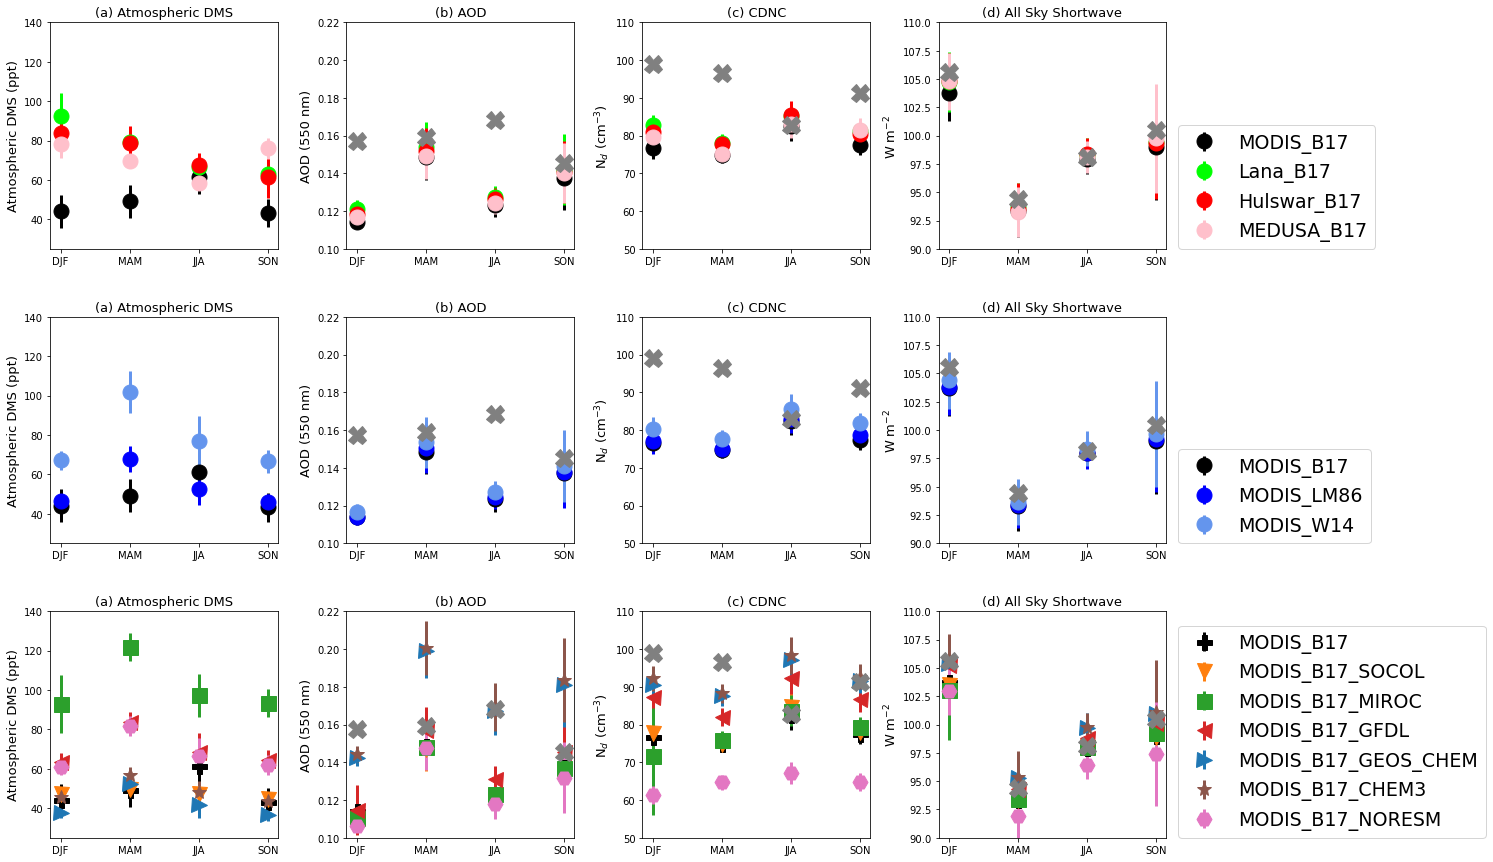

In [397]:
import numpy.ma as ma

# REPLACE WITH SEASONS??


labels=['MODIS_B17','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labelss=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labely=np.array(labels)
#colourss=['black','lime','red','pink','blue','green','orange','purple','black','lightblue','cornflowerblue','blue','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black','lime','red','pink','black','blue','cornflowerblue','black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

#colourss=['aqua','lightblue','teal','aquamarine','lime','orange','purple','blue','cornflowerblue']
num=4
AOD=np.zeros((len(labels),num)); AOD[:] = np.nan
AOD_std=np.zeros((len(labels),num)); AOD_std[:] = np.nan

CCN=np.zeros((len(labels),num)); CCN[:] = np.nan
CCN_std=np.zeros((len(labels),num)); CCN_std[:] = np.nan

rf=np.zeros((len(labels),num)); rf[:] = np.nan
rf_std=np.zeros((len(labels),num)); rf_std[:] = np.nan
sw=np.zeros((len(labels),num)); sw[:] = np.nan
sw_std=np.zeros((len(labels),num)); sw_std[:] = np.nan

aod=np.zeros((len(labels),num)); aod[:] = np.nan
aod_std=np.zeros((len(labels),num)); aod_std[:] = np.nan

cdnc=np.zeros((len(labels),num)); cdnc[:] = np.nan
cdnc_std=np.zeros((len(labels),num)); cdnc_std[:] = np.nan

dms_f=np.zeros((len(labels),num)); dms_f[:] = np.nan
dms_f_std=np.zeros((len(labels),num)); dms_f_std[:] = np.nan

dms=np.zeros((len(labels),num)); dms[:] = np.nan
dms_std=np.zeros((len(labels),num)); dms_std[:] = np.nan

dms_o=np.zeros((len(labels),num)); dms_o[:] = np.nan
dms_o_std=np.zeros((len(labels),num)); dms_o_std[:] = np.nan

so2=np.zeros((len(labels),num)); so2[:] = np.nan
so2_std=np.zeros((len(labels),num)); so2_std[:] = np.nan

seasons = ['DJF', 'MAM', 'JJA', 'SON']
H2SO4=np.zeros((len(labels),num)); H2SO4[:] = np.nan
H2SO4_std=np.zeros((len(labels),num)); H2SO4_std[:] = np.nan

fig = plt.figure(figsize=(20,10), edgecolor='w')
plt.subplots_adjust(hspace=0.4, wspace=0.3)#x=np.arange(40,70,5)

for i in range(0,(len(labels))):
    ####  AOD ###
                   
    aod_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/AOD/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    aod_datame=aod_data.groupby('time.season').mean()
    aod_datast=aod_data.groupby('time.season').std()
    AOD[i,:]=((aod_datame[:]))
    AOD_std[i,:]=((aod_datast[:]))

   # AOD_std[i,:]=np.nanstd((aod_data[:]))

    ####  CCN ###
                   
    ccn_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CCN/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    ccn_datam=ccn_data.groupby('time.season').mean()
    ccn_datas=ccn_data.groupby('time.season').std()
    CCN[i]=((ccn_datam[:]))
    CCN_std[i]=((ccn_datas[:]))

   # CCN_std[i]=np.nanstd((ccn_data[:]))
    ####  DMS FLUX ###
                   
#     dms_flux_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/DMS_EMISSIONS/Global/{}.nc'.format(labels[i])) * to_umol_day
#     #if dms_flux_data.ndim == 1:
#     dms_f[i]=np.nanmean((dms_flux_data[:])) 
#     dms_f_std[i]=np.nanstd((dms_flux_data[:])) 
    #else:
    ####  OCEANIC DMS ###
                   
#     oceanic_dms_data=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/OCEANIC_DMS/Global/{}.npy'.format(labels[i])) 
#     if oceanic_dms_data.ndim == 2:
#         dms_o[i] = np.nanmean(oceanic_dms_data[:,[11,0,1]])
#         dms_o_std[i] = np.nanstd(oceanic_dms_data[:,[11,0,1]])
#     else:
#         dms_o[i]=np.nanmean((oceanic_dms_data[[11,0,1]]))
#         dms_o_std[i] = np.nanstd(oceanic_dms_data[[11,0,1]])
    ####  SO4 ###
                   
    h2so4_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/H2SO4_load/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    h2so4_datam=h2so4_data.groupby('time.season').mean()
    h2so4_std=h2so4_data.groupby('time.season').std()

    H2SO4[i]=(h2so4_datam[:])*1e6
    H2SO4_std[i]=(h2so4_std[:])*1e6
    ####  Radiative Forcing  ###
                   
#     rf_cl=xr.open_dataset(home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/All_Sky/Global/{}.npy'.format(labels[i]))
#     #if rf_cl.ndim == 1:
#     rf[i]=np.nanmean(rf_cl[:]) 
#     rf_std[i]=np.nanstd(rf_cl[:]) 
                          
    sw_cl=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/RF/SW/All_Sky/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    sw_clm=sw_cl.groupby('time.season').mean()
    sw_clstd=sw_cl.groupby('time.season').std()
    #if rf_cl.ndim == 1:
    sw[i,:]=(sw_clm[:]) 
    sw_std[i,:]=(sw_clstd[:]) 

#     else:
#         rf[i]=np.nanmean(rf_cl[:,[11,0,1]]) 
#         rf_std[i]=np.nanstd(rf_cl[:,[11,0,1]]) 
    ####  CDNC  ###

    cdnc_data=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/CDNC/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    cdnc_datam=cdnc_data.groupby('time.season').mean()
    cdnc_datastd=cdnc_data.groupby('time.season').std()
    cdnc[i]=(cdnc_datam[:]) 
    cdnc_std[i]=(cdnc_datastd[:]) 
    ####  ATMOS DMS ###
                   
    dmsy=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Atmos_DMS/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    if labels[i] == 'MODIS_B17':
        dmsy = xr.concat([
        dmsy.sel(time=(dmsy['month'].isin([1, 2, 12]))),    dmsy.sel(time=(dmsy['month'].isin([3, 4, 5]))),
        dmsy.sel(time=(dmsy['month'].isin([6, 7, 8]))),    dmsy.sel(time=(dmsy['month'].isin([9, 10, 11]))),],
        dim='season')
        dmsym=dmsy.mean('time')
        dmsystd=dmsy.std('time')

    else:
        dmsym=dmsy.groupby('time.season').mean()
        dmsystd=dmsy.groupby('time.season').std()   
    dms[i]=(dmsym[:])*dms_ppt
    dms_std[i]=(dmsystd[:])*dms_ppt
    ####  SO2 ###
                   
    SO2=xr.open_dataset('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/SO2_mmr/Global/{}.nc'.format(labels[i])).__xarray_dataarray_variable__
    SO2m=SO2.groupby('time.season').mean()
    SO2std=SO2.groupby('time.season').std()
    so2[i]=(SO2m[:])*dms_ppt
    so2_std[i]=(SO2std[:])*dms_ppt
cdnc_sea=[99.07492913609859,96.47896692205755,82.86375696267419,91.18590145862417]
MOD_SEA=[0.15742370710790557,0.15911644716452714,0.16837178700788216,0.14533217410819088]

SW_OBS=xr.open_dataset('/home/ybh10/Objective_3/CERES_EBAF-TOA_Ed2.8_Subset_200003-201406.nc').toa_sw_all_mon
SW_Mean=areaweight(SW_OBS,modis_lat[:]).groupby('time.season').mean()


fig = plt.figure(figsize=(20,15), edgecolor='w')
axes=[]
axes2=[]
axes3=[]

for i in range(1,5):
    ax=fig.add_subplot(3,4,i)
    ax2=fig.add_subplot(3,4,i+4)
    ax3=fig.add_subplot(3,4,i+8)

    axes.append(ax)
    axes2.append(ax2)
    axes3.append(ax3)

# for i in range(0,4):
#     axes[i].set_xlim(0.3,2.8)
#     axes2[i].set_xlim(0.3,2.8)
#     axes3[i].set_xlim(0.3,2.8)

#     axes[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
#     axes2[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)
#     axes3[i].set_xlabel('SO$_4$ Mass Fraction (mg m$^{-2}$)',fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)#x=np.arange(40,70,5)
formatu=['s','<','>','^','o','^','o','P','v','s','<','>','*','H']

ma=15
for i, label in enumerate(labels):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
        axes[0].errorbar(seasons,dms[i, :],yerr=dms_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
        axes[2].errorbar(seasons,cdnc[i],yerr=cdnc_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
        axes[3].errorbar(seasons,sw[i],yerr=sw_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
        axes[1].errorbar(seasons,AOD[i],yerr=AOD_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])   

    else:
    #if i <= np.where(labely == 'MODIS_W14')[0][0] & i > np.where(labely == 'MEDUSA_B17')[0][0]:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            #print(i)
            axes3[0].errorbar(seasons,dms[i],yerr=dms_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])
            axes3[2].errorbar(seasons,cdnc[i],yerr=cdnc_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])
            axes3[3].errorbar(seasons,sw[i],yerr=sw_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])
            axes3[1].errorbar(seasons,AOD[i],yerr=AOD_std[i], fmt=formatu[i],linewidth=3, markersize=ma,color=colourss[i])

          #  axes2[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt='o',color=colourss[i])
        else:
         #   print(i)
            axes2[0].errorbar(seasons,dms[i],yerr=dms_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
            axes2[2].errorbar(seasons,cdnc[i],yerr=cdnc_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
            axes2[3].errorbar(seasons,sw[i],yerr=sw_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])
            axes2[1].errorbar(seasons,AOD[i],yerr=AOD_std[i], fmt='o',linewidth=3, markersize=ma,color=colourss[i])

     #   print(formatu[i])
       # axes3[0].errorbar(H2SO4[i],dms_f[i],xerr=H2SO4_std[i],yerr=dms_f_std[i],linewidth=3, fmt=formatu[i], markersize=18,color=colourss[i])

# axes[0].set_ylim(3,14)
# axes[1].set_ylim(110,430)
# #axes[2].set_xlim(10,120)
# axes[2].set_ylim(25,60)
# axes[3].set_ylim(380,420)

# axes2[0].set_ylim(3,14)
# axes2[1].set_ylim(110,430)
# #axes2[2].set_xlim(10,120)
# axes2[3-1].set_ylim(25,60)
# axes2[4-1].set_ylim(380,420)

#axes[3].set_xlim(25,60)
ax=[axes,axes2,axes3]
#axes[3].set_xlim(0.004,0.04)
for n in range(0,3):
    ax[n][0].set_title('(a) Atmospheric DMS',fontsize=13)
    ax[n][1].set_title('(b) AOD',fontsize=13)
    ax[n][2].set_title('(c) CDNC',fontsize=13)
    ax[n][3].set_title('(d) All Sky Shortwave',fontsize=13)
    ax[n][0].set_ylim(25,140)
    ax[n][1].set_ylim(0.10,0.22)
    ax[n][2].set_ylim(50,110)
    ax[n][3].set_ylim(90,110)
    ax[n][0].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
    ax[n][1].set_ylabel('AOD (550 nm)',fontsize=13)
    ax[n][2].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
    ax[n][3].set_ylabel('W m$^{-2}$',fontsize=13)
    ax[n][2].errorbar(seasons,cdnc_sea, fmt='X',markersize=18,color='grey')
    ax[n][1].errorbar(seasons,MOD_SEA, fmt='X',markersize=18,color='grey')
    ax[n][3].errorbar(seasons,SW_Mean, fmt='X',markersize=18,color='grey')

    #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)


# axes[0].set_title('(a) DMS Emissions',fontsize=16)
# axes[1].set_title('(b) Atmospheric DMS',fontsize=16)
# axes[2].set_title('(c) AOD',fontsize=16)
# axes[3].set_title('(d) CDNC',fontsize=16)
# #axes[4].set_title('(e) All-Sky Radiative Forcing',fontsize=16)

# axes2[0].set_title('(f) DMS Emissions',fontsize=16)
# axes2[1].set_title('(g) Atmospheric DMS',fontsize=16)
# axes2[2].set_title('(h) AOD',fontsize=16)
# axes2[3].set_title('(i) CDNC',fontsize=16)
#axes2[4].set_title('(j) All-Sky Radiative Forcing',fontsize=16)

# axes2[0].set_title(x=0,y=1.05,label='(e)',fontsize=16)
# axes2[1].set_title(x=0,y=1.05,label='(f)',fontsize=16)
# axes2[2].set_title(x=0,y=1.05,label='(g)',fontsize=16)
# axes2[3].set_title(x=0,y=1.05,label='(h)',fontsize=16)

# axes[0].set_ylabel('Flux (µmol m$^{-2}$ d$^{-1}$)',fontsize=13)
# axes[1].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
# axes[2].set_ylabel('AOD (550 nm)',fontsize=13)
# axes[3].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
# #axes[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)

# axes2[0].set_ylabel('Flux (µmol m$^{-2}$ d$^{-1}$)',fontsize=13)
# axes2[1].set_ylabel('Atmospheric DMS (ppt)',fontsize=13)
# axes2[2].set_ylabel('AOD (550 nm)',fontsize=13)
# axes2[3].set_ylabel('N$_d$ (cm$^{-3}$)',fontsize=13)
# #axes2[4].set_ylabel('Radiative forcing (W m$^{-2}$)',fontsize=13)

#labelss=['MODIS_B17','Lana_B17','MODIS_B17_CHEM3','MODIS_LM86','MODIS_B17_SOCOL','REV3_B17','MODIS_W14','MODIS_B17_NORESM','MEDUSA_B17']
#labelss=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM','Lana_B17','REV3_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14']

labely=np.array(labels)

for i in range(0,len(labels)):
    if i <= np.where(labely == 'MEDUSA_B17')[0][0]:
        axes[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
    else:
        if i > np.where(labely == 'MODIS_W14')[0][0]:
            axes3[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
        else:
            axes2[0].errorbar(3,-3,yerr=0,xerr=0, fmt='o',color=colourss[i],label=labelss[i])
    

#axes2[0].set_title(x=0,y=0,label='hi')

# legend=axes[0].legend(fontsize=12)
# axes2[0].legend(fontsize=12)
axes[3].legend(labelss[:4], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
axes2[3].legend(labelss[4:7], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)
axes3[3].legend(labelss[7:], bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)


# Move the legend to the outside (right side) of the subplots
#legend.set_bbox_to_anchor((1.05, 0.5))

# legend_bbox = legend.get_bbox_to_anchor().transformed(fig.transFigure)
# legend.set_bbox_to_anchor(legend_bbox, bbox_transform=fig.transFigure)

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_Physical_vs_Chemical.png",dpi=300,bbox_inches = 'tight')


In [ ]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(20,15), edgecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
# ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
# ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
# axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion.npy')        
#num_con=np.sum(total_dndlr[:],axis=(2))
num_concentration=np.nanmean(total_dndlr[:,:],axis=(3))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) DMS','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
#dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines


npts=50 # number of bins into which interpolate modal output
rmin=1.0e-9  # 1 nm
rmax=1.0e-5  # 10 microns

dryr_mid=np.zeros((npts),np.float64)
dryr_int=np.zeros((npts+1),np.float64)
deltar=np.zeros((npts),np.float64)

dryr_mids=np.zeros((npts),np.float64)
deltars=np.zeros((npts),np.float64)

for ibin in range(0,npts+1):
    logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
    dryr_int[ibin] = np.exp(logr)

for n in range(0,npts):
    dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
    deltar[n] = dryr_int[n+1]-dryr_int[n] #in m

    
# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']
num_con_sum=np.sum(total_dndlr[:,0],axis=(1))

for i in range(0,5):
    ax1 = fig.add_subplot(3,3,i+1)
    data=num_concentration[:,:,i]
  #  ax1.append(fig.add_subplot(2,2,i+1))
   # ax1=axes[i]#(fig.add_subplot(2,3,i+1))
    #data=np.nanmean(dataset[i],axis=(2,3))
    data=data.transpose(1,0)
    for p in range(0,len(data[0])):
        ax1.plot(data[:,p],heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)

    ax1.set_title('{}'.format(modes[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)
    ax1.set_xlabel('dN/dlogr (cm$^{-3}$)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 3:
        ax1.legend(fontsize=12)
#     if i == 1 or i == 4:
#         ax1.set_xlim(0, 45)  # Set the desired range for the y-axis (0 to 2000 meters)


ax = fig.add_subplot(3,3,6)
for p in range(0,len(labels)):
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(num_con_sum[p])
    #djf=(total_dndlr_CA[file])*1e-6

    #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[p],linewidth=4,label=labels[p])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 1000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    ax.set_title('Aerosol Number Size Distribution',fontsize=14)

  #  plt.legend(loc='lower center',fontsize=19)


#plt.show()

#plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc.png",dpi=200,bbox_inches = 'tight')
#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


Finished Calculating Grid Box Volume


NameError: name 'end' is not defined

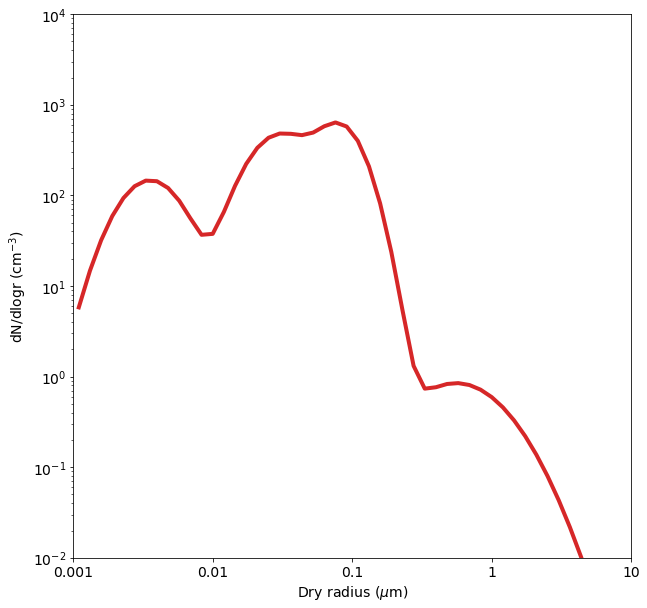

In [16]:
import iris.coord_categorisation as coord_cat
## Cut off radius to determine number concentrations
R_100 = 50e-9
R_70  = 35e-9
R_50  = 25e-9
R_30  = 15e-9
RHOP      = 1800.0 # density of aerosol ptcl of generic composition (assumed H2SO4) in kgm^-3 -- only used in calculating mmid
## Boltzmann constant (J/K)
ZBOLTZ = 1.3807e-23 #iris.coords.AuxCoord(1.3807e-23,long_name='boltzmann_constant',units='J-K^-1')
## Avagadro's constant (mol-1)
AVC = 6.023e+23 #iris.coords.AuxCoord(6.023e+23,long_name='avagadros constant',units='mol^-1')
## Universal gas constant of dry air (J/kg/K)
RD = 287.05 #iris.coords.AuxCoord(287.05, long_name='unviversal_gas_constant_dry_air',units='J-kg^-1-K^-1') 
P0_arr = 100000.0
## Specific heat capacity of dry air (cp) J/kg/K
CP = 1005.46
## Gravity
GG = 9.80665
sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
MM_AER    = 0.098  # assume aerosol is sulfate when calculating mmid


def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

def check_cube(cube_list):
    '''
    Check to see if cube has bounds and assigns them
    Also calculates area weights
    '''
    for icube,cube in enumerate(cube_list):
        ## Check to see if cube has bounds and if not assign some
        if not cube.coord('time').has_bounds(): 
            print('Cube does not have time bounds so guessing them')
            cube.coord('time').guess_bounds()
        if not (cube.coord('longitude').has_bounds() and cube.coord('latitude').has_bounds()):
            print('Cube does not have lat/lon bounds so guessing them')
            #cube.coord('time').guess_bounds()
            cube.coord('longitude').guess_bounds()
            cube.coord('latitude').guess_bounds()
        
        ## Assign monthly category so can perform meaning
        ## for cube in cubes_1_list_surf_out: 
        coord_cat.add_month(cube, 'time', name='month')
        coord_cat.add_year(cube, 'time', name='year')
        #print cube
        
        ## Define lat lon coordinate system for cube
        lat_lon_coord_system = iris.coord_systems.GeogCS(6371229)
        cube.coord('latitude').coord_system = lat_lon_coord_system
        cube.coord('longitude').coord_system = lat_lon_coord_system
             
    ## Calculate grid_areas for are weighting
    grid_areas = iris.analysis.cartography.area_weights(cube, normalize=False)

    return cube_list, grid_areas
def convert_num_den(air_den, data_in, mm_sp):

    '''
    convert aerosol mass mixing ratio into aerosol number concentration (molecules per cm-3)
    '''

    mm_da = (AVC * ZBOLTZ) / RD # molecular mass of dry air kg/mol (0.02897040968)

    ## Convert mmr into molecules per cm-3 of each component
    data_out = data_in * air_den * ( mm_da / mm_sp )
    
    return data_out

def calc_air_density(pot_temp, air_press):

    '''
    Calculate Air number Density (in cm-3)

    '''

    #act_temp = pot_temp * (air_press / P0) ** (RD / CP)  #use to calculate temperature profile
    #act_temp.rename('temperature') #assigns temperature to the long name of the cube
    # Use this for aair number densities (and aerosols)
    #rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06)) #calculate air number density for all levels and each month
    
    if isinstance(air_press, (np.ndarray)):

        ## For arrays: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0_arr) ** (RD / CP) )

    else:
        ## For cubes: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0) ** (RD / CP) )
    
    ## For Gas phase species
    #rho_air = air_press / (act_temp * RD)
    
    ## For aerosol components (air number density)
    rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06))
    
    #print(rho_air.data.mean(), rho_air.data.min(), rho_air.data.max())
    
    #print(np.mean(rho_air.data[:,:]))
    
    return rho_air, act_temp

def calc_fract_lt(tot_num, dry_rad_v, r_cutoff, sigma_mode, mode):

    '''
    Calculate fraction of aerosol volume distribution below specified cut-off
    diameter for each mode.

    '''

    print('Calculate fraction below {:.1f} nm diameter in {} mode'.format(r_cutoff*1e9*2.0,mode))

    ## Condition to perform calculation on mass above 0.0
    cond = np.greater(tot_num.data, 0.0)
    cond_lt = np.less_equal(tot_num.data, 0.0)
    ndmin_cond = np.where(cond)
    ndmin_cond_lt = np.where(cond_lt)

    total_to_r = do_initialize_arr(tot_num)
    frac_lt_diam = do_initialize_arr(tot_num)
    fract_mass_lt_out = tot_num.copy(data=None)
    frac_gt_diam = do_initialize_arr(tot_num)
    fract_mass_gt_out = tot_num.copy(data=None)
    
    ## This expression calculates the cumulative of a lognormal
    ## distribution up to radius "reference_radius"
    ## Takes the cumulative mass array, radius of interest,
    ## actual radius of mode,geometric std dev (width) of mode
    total_to_r[ndmin_cond] = (tot_num.data[ndmin_cond] / 2.0) * (1.0 + sp.special.erf(np.log(r_cutoff / dry_rad_v.data[ndmin_cond]) / np.sqrt(2.0 / np.log(sigma_mode))))

    ## Then calculate what fraction this is of the total
    ## (to find fraction of distribution below specified cutoff)
    frac_lt_diam[ndmin_cond] = total_to_r[ndmin_cond] / tot_num.data[ndmin_cond]
#    frac_gt_diam[ndmin_cond] = (tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]) / tot_num.data[ndmin_cond]
    frac_gt_diam[ndmin_cond] = tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]

    #print 'Min = {}'.format(np.min(frac_V_lt_diam)), 'Mean = {}'.format(np.mean(frac_V_lt_diam)), 'Max = {}'.format(np.max(frac_V_lt_diam))
    
    # points below minimum mass concentration are given default value and assumed to all be above cut-off
    frac_lt_diam[ndmin_cond_lt] = 1.0
    frac_gt_diam[ndmin_cond_lt] = 1.0
    
    # Put fractions back into a cube
    fract_mass_lt_out.data = frac_lt_diam
    fract_mass_gt_out.data = frac_gt_diam
    
    return fract_mass_lt_out, fract_mass_gt_out




# # Get an array of grid box altitude heights in m
# filename=('/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pe2018jan.pp')
# constraint=iris.AttributeConstraint(STASH='m01s38i485')
# cube = iris.load(filename,constraint)
# test_cube = cube[0]

# hgt_arr = test_cube.coord('level_height').points
# print(test_cube.summary(shorten=True))

# #hgt_arr = xr.open_dataset(MODIS_B17_SOCOL_file+'../Raw/DMS_Mass_Mixing_Ratio_2018jan.nc').level_height

# ## Add zero as starting height
# hgt_arr_all = np.hstack((0.0, hgt_arr))

# # Define the bounds for latitude and longitude
# lat_values = test_cube.coord('latitude').points
# lon_values = test_cube.coord('longitude').points

# lat_bounds = [[lat_values[i] - 0.625, lat_values[i] + 0.625] for i in range(len(lat_values))]
# lon_bounds = [[lon_values[i] - 1.875, lon_values[i] + 1.875] for i in range(len(lon_values))]

# # Set the bounds for the latitude and longitude coordinates
# test_cube.coord('latitude').bounds = lat_bounds
# test_cube.coord('longitude').bounds = lon_bounds

# area3d = iris.analysis.cartography.area_weights(test_cube, normalize=False)
# area2d = area3d[0, :, :]

# ## Calculate dz array (height of individual grid boxes)
# dz_arr  = np.zeros(hgt_arr.shape)
# vol_box = np.zeros(area3d[:, :, :].shape)

# ## Calculate height of each grid box and volume of grid boxes
# for ilev, lev in enumerate(hgt_arr):
#     dz_arr[ilev]      = hgt_arr_all[ilev+1] - hgt_arr_all[ilev]
#     vol_box[ilev, :, :] = area2d[:, :] * dz_arr[ilev]
    
# grid_box_vol = copy.deepcopy(vol_box)
# print(grid_box_vol.shape  )
    
# volumes = vol_box[0:16,:, :]

print('Finished Calculating Grid Box Volume')



modes=['nucleation_sol','aitken_sol','accumulation_sol','coarse_sol']
particle='DRY_PARTICLE_DIAMETER'
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507']

Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol']

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode']


mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air']

nmodes=np.size(modes)




# filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
# constraint_temp='m01s00i004'
# constraint_pres='m01s00i408'
# pot_temp=iris.load_cubes(filename,constraint_temp)
# pot_press=iris.load_cubes(filename,constraint_pres)
# cubes_1_list_out, grid_areas = check_cube(pot_temp)
# cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)

# P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')
# air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])

air_num_den = xr.open_dataset('/home/ybh10/Objective_3/Air_density_cm3.nc').unknown


#airdensy = pot_press[0]/(k_B*pot_temp[0])


#data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
#data_num=convert_num_den(airden.data,number_vol,MM_AER)
#data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

# mass_concentration = number_vol * air_num_den.data[0,23:40]
# number_concentration = mass_concentration / (MM_AER * AVC)
# number_concentration_cm3 = number_concentration * 1e-6






#fig=plt.figure()
fig = plt.figure(figsize=(10,10), edgecolor='w')

ax=fig.add_subplot(111)

sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']


AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr_accumulated=np.zeros((4,16, 50)); total_dndlr_accumulated[:]=np.nan
total_dndlr_accumulated_ca=np.zeros((4,16, 50)); total_dndlr_accumulated_ca[:]=np.nan
test_CA=np.zeros((4, 16,50)); test_CA[:]=np.nan

total_dndlr=np.zeros((len(labels),16, 50)); total_dndlr[:]=np.nan
total_dndlr_CA=np.zeros((len(labels),16, 50)); total_dndlr_CA[:]=np.nan
testing_CA=np.zeros((len(labels),16, 50)); testing_CA[:]=np.nan
logsize=[]
for file in range(0,len(labels)):
#     if file == 4:
#         end
    total_dndlr_accumulated=np.zeros((4,16, 50)); total_dndlr_accumulated[:]=np.nan
    total_dndlr_accumulated_ca=np.zeros((4,16, 50)); total_dndlr_accumulated_ca[:]=np.nan
    test_CA=np.zeros((4, 16,50)); test_CA[:]=np.nan

    for i in range(0,len(modes)):
        radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]]/2
        #radius = radius.sel(latitude=slice(-61, -40))
       # print(np.shape(radius))
#        radius = radius.sel(model_level_number=1).mean('time')
        radius = radius.mean('time')


      #  number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],modes[i]))[stash_mode[i]]
        number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]]

        #number = number.sel(latitude=slice(-61, -40))
#        number = number.sel(model_level_number=1).mean('time')
        number = number.mean('time')

     #   number=convert_num_den(air_num_den[0,23:40].data,number,MM_AER)

        number = number * (air_num_den.data[0:16,:])

        #number=xr.open_dataset('{}/../Raw/{}_2017jan.nc'.format(MODIS_B17_NORESM_file,mode_try[i]))[stash_mode_try[i]][0,23:40]
     #   end
#         temp=xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/Surface_Temp.nc').air_temperature[:,23:40]
#         pres=xr.open_dataset('{}/{}.nc'.format(MODIS_B17_CHEM_file,'PRESSURE_MEAN_SL')).air_pressure_at_sea_level[:,23:40]/100 #convert to hPa
#         pres=pres.mean('time')
#         temp=temp.mean('time')

#       #  end
#         R =  8.314 #J/mol/K
#         #k =  1.38e-23 # m2 kg s-2 K-1 
#         #avc = 6.022e23 #Avogadro's number

#     #Calculate the number density of air molecules in m-3
#         k_B = 1.38e-25 #m3 hPa K-1 molec-1

 #       airdens = pres/(k_B*temp)
       # airdens = pres/(R*temp)

        #airdens=4.004

        # Calculate dry-radius grid for binned-modes
        #
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns

        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)
        
        dryr_mids=np.zeros((npts),np.float64)
        deltars=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m
            
        for n in range(0,npts):
            dryr_mids[n] = 10.0**(0.5 * (np.log10(dryr_int[n+1]) + np.log10(dryr_int[n]))) #in m
            deltars[n] = dryr_int[n+1]-dryr_int[n] #in m


#      #   nuc_m3 = number * airdensy.data[0]
      #  number = number * airdens

#         nuc_m3_aw = areaweight(nuc_m3,lats[:])
#         nuc_rbardry_aw = areaweight(radius,lats[:])

        nuc_dndlr = np.zeros((16,50),np.float64)
        ndbin_mode = np.zeros((16,50),np.float64)
        ca_nuc_dndlr = np.zeros((16,50),np.float64)


        num_co = areaweight(number,lats[:])
        rad_co = areaweight(radius,lats[:])


        for ihe in range(0,16):
#             vol_nd      = np.sum(
#                 num_co[ihe].data * volumes / np.sum(volumes))
#             vol_bar      = np.sum(
#                 rad_co[ihe].data * volumes / np.sum(volumes))
            for ibin in range(0,50):
                nuc_dndlr[ihe,ibin]=lognormal_dNdlogr(num_co[ihe],dryr_mid[ibin],rad_co[ihe],sigma[i])

                #ca_nuc_dndlr[ihe,ibin]=lognormal_dNdlogr(vol_nd,dryr_mid[ibin],vol_bar,sigma[i]) # Catherines

              #  ndbin_mode[ihe,ibin]  = ca_nuc_dndlr[ibin] * deltar[ibin] / 2.303 / dryr_mid[ibin] # Catherines



        total_dndlr_accumulated[i]=nuc_dndlr
     #   total_dndlr_accumulated_ca[i]=ca_nuc_dndlr
    #logsize.append(total_dndlr_accumulated)

      #  test_CA[i]=ndbin_mode


    total_dndlr[file,:]=np.sum(total_dndlr_accumulated,axis=0)
   # total_dndlr_CA[file,:]=np.sum(total_dndlr_accumulated_ca,axis=0)
  #  testing_CA[file,:]=np.sum(test_CA,axis=0)
    # ## CATHERINES
    #rad_microm = dryr_mid*1e9

    
    # end

        #dNdlnR_tot=
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(total_dndlr[file])
    #djf=(total_dndlr_CA[file])*1e-6

#    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf[0],color=colourss[i],linewidth=4,label=labels[i])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    end
  #  end
plt.legend(loc='lower left',fontsize=19)
#end


In [361]:
import iris.coord_categorisation as coord_cat
## Cut off radius to determine number concentrations
R_100 = 50e-9
R_70  = 35e-9
R_50  = 25e-9
R_30  = 15e-9
RHOP      = 1800.0 # density of aerosol ptcl of generic composition (assumed H2SO4) in kgm^-3 -- only used in calculating mmid
## Boltzmann constant (J/K)
ZBOLTZ = 1.3807e-23 #iris.coords.AuxCoord(1.3807e-23,long_name='boltzmann_constant',units='J-K^-1')
## Avagadro's constant (mol-1)
AVC = 6.023e+23 #iris.coords.AuxCoord(6.023e+23,long_name='avagadros constant',units='mol^-1')
## Universal gas constant of dry air (J/kg/K)
RD = 287.05 #iris.coords.AuxCoord(287.05, long_name='unviversal_gas_constant_dry_air',units='J-kg^-1-K^-1') 
P0_arr = 100000.0
## Specific heat capacity of dry air (cp) J/kg/K
CP = 1005.46
## Gravity
GG = 9.80665
sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
MM_AER    = 0.098  # assume aerosol is sulfate when calculating mmid


def lognormal_dNdlogr(N,r,rbar,sigma_g):
# evaluates lognormal distribution dN/dlogr at radius r
# here dNlnr is the differential wrt the natural logarithm and
# dNdlogr (which is returned) is the differential wrt the base10 logarithm
    xpi=3.14159265358979323846e0
    numexp=-(np.log(r)-np.log(rbar))**2
    denomexp=2.0*np.log(sigma_g)*np.log(sigma_g)
    denom=np.sqrt(2*xpi)*np.log(sigma_g)
    dNdlnr=(N/denom)*np.exp(numexp/denomexp)
    dNdlogr=2.303*dNdlnr
    return dNdlogr

def check_cube(cube_list):
    '''
    Check to see if cube has bounds and assigns them
    Also calculates area weights
    '''
    for icube,cube in enumerate(cube_list):
        ## Check to see if cube has bounds and if not assign some
        if not cube.coord('time').has_bounds(): 
            print('Cube does not have time bounds so guessing them')
            cube.coord('time').guess_bounds()
        if not (cube.coord('longitude').has_bounds() and cube.coord('latitude').has_bounds()):
            print('Cube does not have lat/lon bounds so guessing them')
            #cube.coord('time').guess_bounds()
            cube.coord('longitude').guess_bounds()
            cube.coord('latitude').guess_bounds()
        
        ## Assign monthly category so can perform meaning
        ## for cube in cubes_1_list_surf_out: 
        coord_cat.add_month(cube, 'time', name='month')
        coord_cat.add_year(cube, 'time', name='year')
        #print cube
        
        ## Define lat lon coordinate system for cube
        lat_lon_coord_system = iris.coord_systems.GeogCS(6371229)
        cube.coord('latitude').coord_system = lat_lon_coord_system
        cube.coord('longitude').coord_system = lat_lon_coord_system
             
    ## Calculate grid_areas for are weighting
    grid_areas = iris.analysis.cartography.area_weights(cube, normalize=False)

    return cube_list, grid_areas
def convert_num_den(air_den, data_in, mm_sp):

    '''
    convert aerosol mass mixing ratio into aerosol number concentration (molecules per cm-3)
    '''

    mm_da = (AVC * ZBOLTZ) / RD # molecular mass of dry air kg/mol (0.02897040968)

    ## Convert mmr into molecules per cm-3 of each component
    data_out = data_in * air_den * ( mm_da / mm_sp )
    
    return data_out

def calc_air_density(pot_temp, air_press):

    '''
    Calculate Air number Density (in cm-3)

    '''

    #act_temp = pot_temp * (air_press / P0) ** (RD / CP)  #use to calculate temperature profile
    #act_temp.rename('temperature') #assigns temperature to the long name of the cube
    # Use this for aair number densities (and aerosols)
    #rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06)) #calculate air number density for all levels and each month
    
    if isinstance(air_press, (np.ndarray)):

        ## For arrays: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0_arr) ** (RD / CP) )

    else:
        ## For cubes: use to calculate temperature profile
        act_temp = pot_temp * ( (air_press / P0) ** (RD / CP) )
    
    ## For Gas phase species
    #rho_air = air_press / (act_temp * RD)
    
    ## For aerosol components (air number density)
    rho_air = (air_press / (act_temp * ZBOLTZ * 1e+06))
    
    #print(rho_air.data.mean(), rho_air.data.min(), rho_air.data.max())
    
    #print(np.mean(rho_air.data[:,:]))
    
    return rho_air, act_temp

def calc_fract_lt(tot_num, dry_rad_v, r_cutoff, sigma_mode, mode):

    '''
    Calculate fraction of aerosol volume distribution below specified cut-off
    diameter for each mode.

    '''

    print('Calculate fraction below {:.1f} nm diameter in {} mode'.format(r_cutoff*1e9*2.0,mode))

    ## Condition to perform calculation on mass above 0.0
    cond = np.greater(tot_num.data, 0.0)
    cond_lt = np.less_equal(tot_num.data, 0.0)
    ndmin_cond = np.where(cond)
    ndmin_cond_lt = np.where(cond_lt)

    total_to_r = do_initialize_arr(tot_num)
    frac_lt_diam = do_initialize_arr(tot_num)
    fract_mass_lt_out = tot_num.copy(data=None)
    frac_gt_diam = do_initialize_arr(tot_num)
    fract_mass_gt_out = tot_num.copy(data=None)
    
    ## This expression calculates the cumulative of a lognormal
    ## distribution up to radius "reference_radius"
    ## Takes the cumulative mass array, radius of interest,
    ## actual radius of mode,geometric std dev (width) of mode
    total_to_r[ndmin_cond] = (tot_num.data[ndmin_cond] / 2.0) * (1.0 + sp.special.erf(np.log(r_cutoff / dry_rad_v.data[ndmin_cond]) / np.sqrt(2.0 / np.log(sigma_mode))))

    ## Then calculate what fraction this is of the total
    ## (to find fraction of distribution below specified cutoff)
    frac_lt_diam[ndmin_cond] = total_to_r[ndmin_cond] / tot_num.data[ndmin_cond]
#    frac_gt_diam[ndmin_cond] = (tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]) / tot_num.data[ndmin_cond]
    frac_gt_diam[ndmin_cond] = tot_num.data[ndmin_cond] - total_to_r[ndmin_cond]

    #print 'Min = {}'.format(np.min(frac_V_lt_diam)), 'Mean = {}'.format(np.mean(frac_V_lt_diam)), 'Max = {}'.format(np.max(frac_V_lt_diam))
    
    # points below minimum mass concentration are given default value and assumed to all be above cut-off
    frac_lt_diam[ndmin_cond_lt] = 1.0
    frac_gt_diam[ndmin_cond_lt] = 1.0
    
    # Put fractions back into a cube
    fract_mass_lt_out.data = frac_lt_diam
    fract_mass_gt_out.data = frac_gt_diam
    
    return fract_mass_lt_out, fract_mass_gt_out





modes=['nucleation_sol','aitken_sol','accumulation_sol','coarse_sol','aitken_insol']
particle='DRY_PARTICLE_DIAMETER'
stash_radius=['m01s38i401','m01s38i402','m01s38i403','m01s38i404','m01s38i405']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']

Diameter=['DRY_PARTICLE_DIAMETER_nucleation_sol', 'DRY_PARTICLE_DIAMETER_aitken_sol', 'DRY_PARTICLE_DIAMETER_accumulation_sol',
          'DRY_PARTICLE_DIAMETER_coarse_sol', 'DRY_PARTICLE_DIAMETER_aitken_insol']

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']


mode_try=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode_try=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']

nmodes=np.size(modes)




filename='/home/ybh10/cylc-run/u-cx366/share/data/History_Data/cx366a.pm2018jan.pp'
constraint_temp='m01s00i004'
constraint_pres='m01s00i408'
pot_temp=iris.load_cubes(filename,constraint_temp)
pot_press=iris.load_cubes(filename,constraint_pres)
cubes_1_list_out, grid_areas = check_cube(pot_temp)
cubes_1_list_out_press, grid_areas_press = check_cube(pot_press)

P0 = iris.coords.AuxCoord(100000.0,long_name='reference_pressure',units='Pa')
air_num_den, act_temp = calc_air_density(pot_temp[0], pot_press[0])

#airdensy = pot_press[0]/(k_B*pot_temp[0])


#data_num=convert_num_den(air_num_den[0,23:40].data,number_vol,MM_AER)
#data_num=convert_num_den(airden.data,number_vol,MM_AER)
#data_num=convert_num_den(airdens.data[0,23:40],number_vol,MM_AER)

# mass_concentration = number_vol * air_num_den.data[0,23:40]
# number_concentration = mass_concentration / (MM_AER * AVC)
# number_concentration_cm3 = number_concentration * 1e-6






#fig=plt.figure()
fig = plt.figure(figsize=(10,10), edgecolor='w')

ax=fig.add_subplot(111)

sigma=[1.59,1.59,1.40,2.0,1.59]     # standard deviation of modes
# AOD_file=[MODIS_B17_file,MODIS_B17_CHEM_file,MODIS_B17_SOCOL_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_CHEM3','MODIS_B17_SOCOL','MODIS_B17_NORESM']


AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr_accumulated=np.zeros((5,16, 50)); total_dndlr_accumulated[:]=np.nan
total_dndlr_accumulated_ca=np.zeros((5,16, 50)); total_dndlr_accumulated_ca[:]=np.nan
test_CA=np.zeros((5, 16,50)); test_CA[:]=np.nan

total_dndlr=np.zeros((len(labels),16, 50)); total_dndlr[:]=np.nan
total_dndlr_CA=np.zeros((len(labels),16, 50)); total_dndlr_CA[:]=np.nan
testing_CA=np.zeros((len(labels),16, 50)); testing_CA[:]=np.nan
logsize=[]
for file in range(0,len(labels)):
#     if file == 4:
#         end
    total_dndlr_accumulated=np.zeros((5,16, 50)); total_dndlr_accumulated[:]=np.nan
    total_dndlr_accumulated_ca=np.zeros((5,16, 50)); total_dndlr_accumulated_ca[:]=np.nan
    test_CA=np.zeros((5, 16,50)); test_CA[:]=np.nan

    for i in range(0,len(modes)):
        radius=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],Diameter[i]))[stash_radius[i]]/2
        #radius = radius.sel(latitude=slice(-61, -40))
       # print(np.shape(radius))
#        radius = radius.sel(model_level_number=1).mean('time')
        radius = radius.mean('time')


      #  number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],modes[i]))[stash_mode[i]]
        number=xr.open_dataset('{}/{}.nc'.format(AOD_file[file],mode_try[i]))[stash_mode_try[i]]

        #number = number.sel(latitude=slice(-61, -40))
#        number = number.sel(model_level_number=1).mean('time')
        number = number.mean('time')

     #   number=convert_num_den(air_num_den[0,23:40].data,number,MM_AER)

        number = number * (air_num_den.data[0:16,:])

        #number=xr.open_dataset('{}/../Raw/{}_2017jan.nc'.format(MODIS_B17_NORESM_file,mode_try[i]))[stash_mode_try[i]][0,23:40]
     #   end
#         temp=xr.open_dataset('/home/ybh10/Objective_2/Post_Processed_Data/MODIS_LM86/Years/Processed/Surface_Temp.nc').air_temperature[:,23:40]
#         pres=xr.open_dataset('{}/{}.nc'.format(MODIS_B17_CHEM_file,'PRESSURE_MEAN_SL')).air_pressure_at_sea_level[:,23:40]/100 #convert to hPa
#         pres=pres.mean('time')
#         temp=temp.mean('time')

#       #  end
#         R =  8.314 #J/mol/K
#         #k =  1.38e-23 # m2 kg s-2 K-1 
#         #avc = 6.022e23 #Avogadro's number

#     #Calculate the number density of air molecules in m-3
#         k_B = 1.38e-25 #m3 hPa K-1 molec-1

 #       airdens = pres/(k_B*temp)
       # airdens = pres/(R*temp)

        #airdens=4.004

        # Calculate dry-radius grid for binned-modes
        #
        npts=50 # number of bins into which interpolate modal output
        rmin=1.0e-9  # 1 nm
        rmax=1.0e-5  # 10 microns

        dryr_mid=np.zeros((npts),np.float64)
        dryr_int=np.zeros((npts+1),np.float64)
        deltar=np.zeros((npts),np.float64)
        
        dryr_mids=np.zeros((npts),np.float64)
        deltars=np.zeros((npts),np.float64)

        for ibin in range(0,npts+1):
            logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
            dryr_int[ibin] = np.exp(logr)

        for n in range(0,npts):
            dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
            deltar[n] = dryr_int[n+1]-dryr_int[n] #in m
            
        for n in range(0,npts):
            dryr_mids[n] = 10.0**(0.5 * (np.log10(dryr_int[n+1]) + np.log10(dryr_int[n]))) #in m
            deltars[n] = dryr_int[n+1]-dryr_int[n] #in m


#      #   nuc_m3 = number * airdensy.data[0]
      #  number = number * airdens

#         nuc_m3_aw = areaweight(nuc_m3,lats[:])
#         nuc_rbardry_aw = areaweight(radius,lats[:])

        nuc_dndlr = np.zeros((16,50),np.float64)
        ndbin_mode = np.zeros((16,50),np.float64)
        ca_nuc_dndlr = np.zeros((16,50),np.float64)


        num_co = areaweight(number,lats[:])
        rad_co = areaweight(radius,lats[:])


        for ihe in range(0,16):
            vol_nd      = np.sum(
                num_co[ihe].data * volumes / np.sum(volumes))
            vol_bar      = np.sum(
                rad_co[ihe].data * volumes / np.sum(volumes))
            for ibin in range(0,50):
                nuc_dndlr[ihe,ibin]=lognormal_dNdlogr(num_co[ihe],dryr_mid[ibin],rad_co[ihe],sigma[i])

                ca_nuc_dndlr[ihe,ibin]=lognormal_dNdlogr(vol_nd,dryr_mid[ibin],vol_bar,sigma[i]) # Catherines

              #  ndbin_mode[ihe,ibin]  = ca_nuc_dndlr[ibin] * deltar[ibin] / 2.303 / dryr_mid[ibin] # Catherines



        total_dndlr_accumulated[i]=nuc_dndlr
        total_dndlr_accumulated_ca[i]=ca_nuc_dndlr
    #logsize.append(total_dndlr_accumulated)

      #  test_CA[i]=ndbin_mode


    total_dndlr[file,:]=np.sum(total_dndlr_accumulated,axis=0)
    total_dndlr_CA[file,:]=np.sum(total_dndlr_accumulated_ca,axis=0)
  #  testing_CA[file,:]=np.sum(test_CA,axis=0)
    # ## CATHERINES
    #rad_microm = dryr_mid*1e9


    # end

        #dNdlnR_tot=
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(total_dndlr[file])
    #djf=(total_dndlr_CA[file])*1e-6

#    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf[0],color=colourss[i],linewidth=4,label=labels[i])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
  #  end
plt.legend(loc='lower left',fontsize=19)
#end


Cube does not have lat/lon bounds so guessing them
Cube does not have lat/lon bounds so guessing them


NameError: name 'end' is not defined

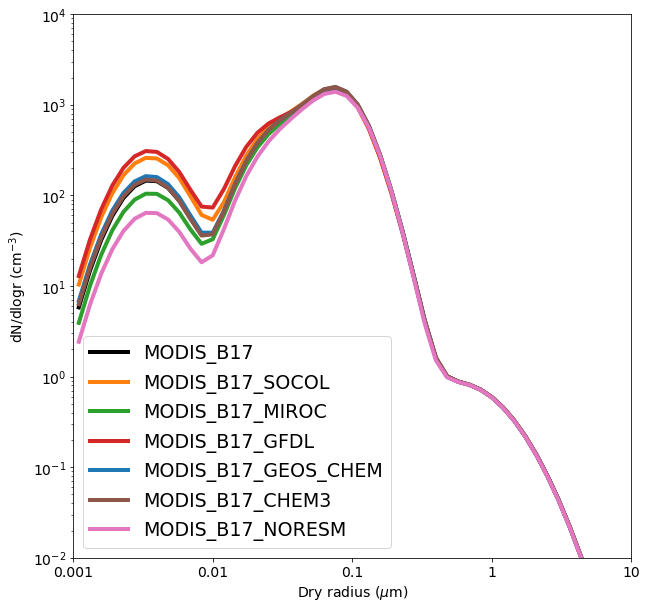

In [234]:
labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

formatu=['^','o','P','H','s','<','>','*','H']

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion_GLOBAL.npy')        
total_dndlr=np.sum(total_dndlr[:,:,0],axis=(1))
fig = plt.figure(figsize=(10,10), edgecolor='w')

ax=fig.add_subplot(111)
for i in range(0,7):

    ax.plot(radtoplot, total_dndlr[i],color=colourss[i],linewidth=4,label=labels[i])

    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
plt.legend(loc='lower left',fontsize=19)
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_GLOBAL.png",dpi=200,bbox_inches = 'tight')


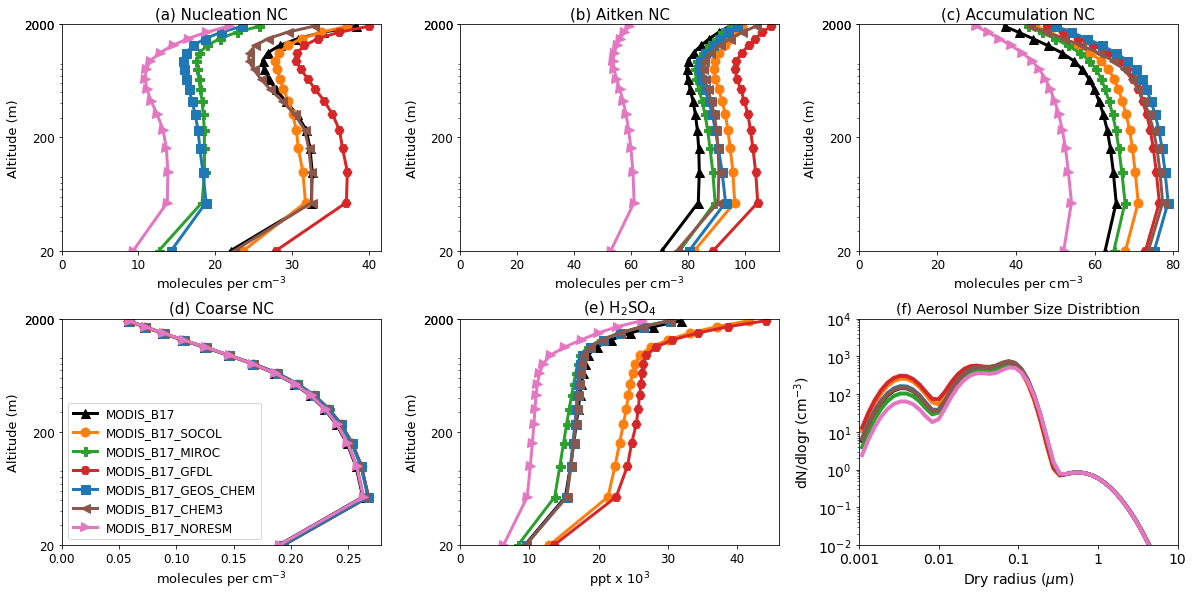

In [25]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(20,15), edgecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
# ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
# ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
# axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion_GLOBAL.npy')[:,:4]        
#num_con=np.sum(total_dndlr[:],axis=(2))
total_dndlr=total_dndlr.transpose(0,2,1,3)
num_concentration=np.nanmean(total_dndlr[:,:],axis=(3))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) Ai','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
#dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines


npts=50 # number of bins into which interpolate modal output
rmin=1.0e-9  # 1 nm
rmax=1.0e-5  # 10 microns

dryr_mid=np.zeros((npts),np.float64)
dryr_int=np.zeros((npts+1),np.float64)
deltar=np.zeros((npts),np.float64)

dryr_mids=np.zeros((npts),np.float64)
deltars=np.zeros((npts),np.float64)

for ibin in range(0,npts+1):
    logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
    dryr_int[ibin] = np.exp(logr)

for n in range(0,npts):
    dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
    deltar[n] = dryr_int[n+1]-dryr_int[n] #in m

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']
modes=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']
titles=['(a) Nucleation NC','(b) Aitken NC','(c) Accumulation NC','(d) Coarse NC','(e) H$_{2}$SO$_{4}$','(f) Aerosol Number Size Distribtion']
# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']
num_con_sum=np.sum(total_dndlr[:,0],axis=(1))

for i in range(0,5):
    ax1 = fig.add_subplot(3,3,i+1)
#    data=num_concentration[:,:,i]
#    data=data.transpose(1,0)
    for p in range(0,len(labels)):
        AOD_file=globals().get(labels[p]+'_file')
        
        if i == 4:
            data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_AOD_heights.nc').mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air.mean('time')*h2so4_ppt*1e3
            ax1.set_xlabel('ppt x 10$^{3}$',fontsize=13)

        else:
            num_rat=xr.open_dataset(AOD_file+'../Annual_Processed/'+modes[i]+'.nc')[stash_mode[i]].mean('time')
            data_num=convert_num_den(air_num_den.data[:16],num_rat,MM_AER)
            
            ax1.set_xlabel('molecules per cm$^{-3}$',fontsize=13)

        data=areaweight(data_num,lats)
        ax1.plot(data,heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)

    ax1.set_title('{}'.format(titles[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 3:
        ax1.legend(fontsize=12)
#     if i == 1 or i == 4:
#         ax1.set_xlim(0, 45)  # Set the desired range for the y-axis (0 to 2000 meters)

    
    
ax = fig.add_subplot(3,3,6)
for p in range(0,len(labels)):
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(num_con_sum[p])
    #djf=(total_dndlr_CA[file])*1e-6

    #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[p],linewidth=4,label=labels[p])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    ax.set_title(titles[-1],fontsize=14)

  #  plt.legend(loc='lower center',fontsize=19)


#plt.show()

# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.png",dpi=300,bbox_inches = 'tight')
# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.pdf",dpi=200,bbox_inches = 'tight')

#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


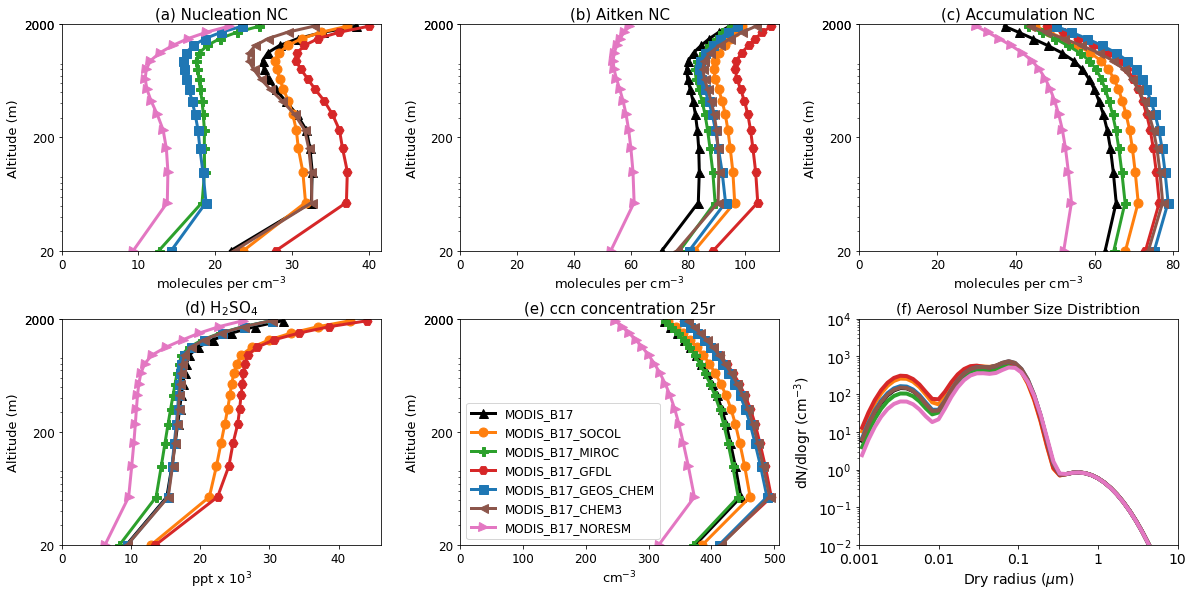

In [60]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(20,15), edgecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
# ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
# ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
# axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion_GLOBAL.npy')[:,:4]        
#num_con=np.sum(total_dndlr[:],axis=(2))
total_dndlr=total_dndlr.transpose(0,2,1,3)
num_concentration=np.nanmean(total_dndlr[:,:],axis=(3))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) Ai','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
#dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines


npts=50 # number of bins into which interpolate modal output
rmin=1.0e-9  # 1 nm
rmax=1.0e-5  # 10 microns

dryr_mid=np.zeros((npts),np.float64)
dryr_int=np.zeros((npts+1),np.float64)
deltar=np.zeros((npts),np.float64)

dryr_mids=np.zeros((npts),np.float64)
deltars=np.zeros((npts),np.float64)

for ibin in range(0,npts+1):
    logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
    dryr_int[ibin] = np.exp(logr)

for n in range(0,npts):
    dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
    deltar[n] = dryr_int[n+1]-dryr_int[n] #in m

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']
modes=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']
titles=['(a) Nucleation NC','(b) Aitken NC','(c) Accumulation NC','(d) H$_{2}$SO$_{4}$','(e) ccn concentration 25r','(f) Aerosol Number Size Distribtion']
# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']
num_con_sum=np.sum(total_dndlr[:,0],axis=(1))

for i in range(0,5):
    ax1 = fig.add_subplot(3,3,i+1)
#    data=num_concentration[:,:,i]
#    data=data.transpose(1,0)
    for p in range(0,len(labels)):
        AOD_file=globals().get(labels[p]+'_file')
        
        if i == 3:
            data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_AOD_heights.nc').mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air.mean('time')*h2so4_ppt*1e3
        #    data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_Mass_Mixing_Ratio.nc').mass_fraction_of_sulfuric_acid_in_air.mean('time')*h2so4_ppt*1e3

            ax1.set_xlabel('ppt x 10$^{3}$',fontsize=13)
        else:
            if i == 4:
#                data_num=xr.open_dataset(AOD_file+'../Annual_Processed/DROPLET_NUMBER_CONCENTRATION.nc').product_of_number_concentration_of_stratiform_cloud_liquid_water_particles_and_stratiform_cloud_liquid_water_area_fraction_and_sunlit_binary_mask.mean('time')
                data_num=xr.open_dataset(AOD_file+'../Annual_Processed/ccn_concentration_25r.nc').m01s38i439.mean('time')

                ax1.set_xlabel('cm$^{-3}$',fontsize=13)

            else:
                num_rat=xr.open_dataset(AOD_file+'../Annual_Processed/'+modes[i]+'.nc')[stash_mode[i]].mean('time')
                data_num=convert_num_den(air_num_den.data[:16],num_rat,MM_AER)

                ax1.set_xlabel('molecules per cm$^{-3}$',fontsize=13)

        data=areaweight(data_num,lats)
        ax1.plot(data,heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)

    ax1.set_title('{}'.format(titles[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 4:
        ax1.legend(fontsize=12)
#     if i == 1 or i == 4:
#         ax1.set_xlim(0, 45)  # Set the desired range for the y-axis (0 to 2000 meters)

    
    
ax = fig.add_subplot(3,3,6)
for p in range(0,len(labels)):
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(num_con_sum[p])
    #djf=(total_dndlr_CA[file])*1e-6

    #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[p],linewidth=4,label=labels[p])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    ax.set_title(titles[-1],fontsize=14)

  #  plt.legend(loc='lower center',fontsize=19)


#plt.show()

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.png",dpi=300,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.pdf",dpi=50,bbox_inches = 'tight')

#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


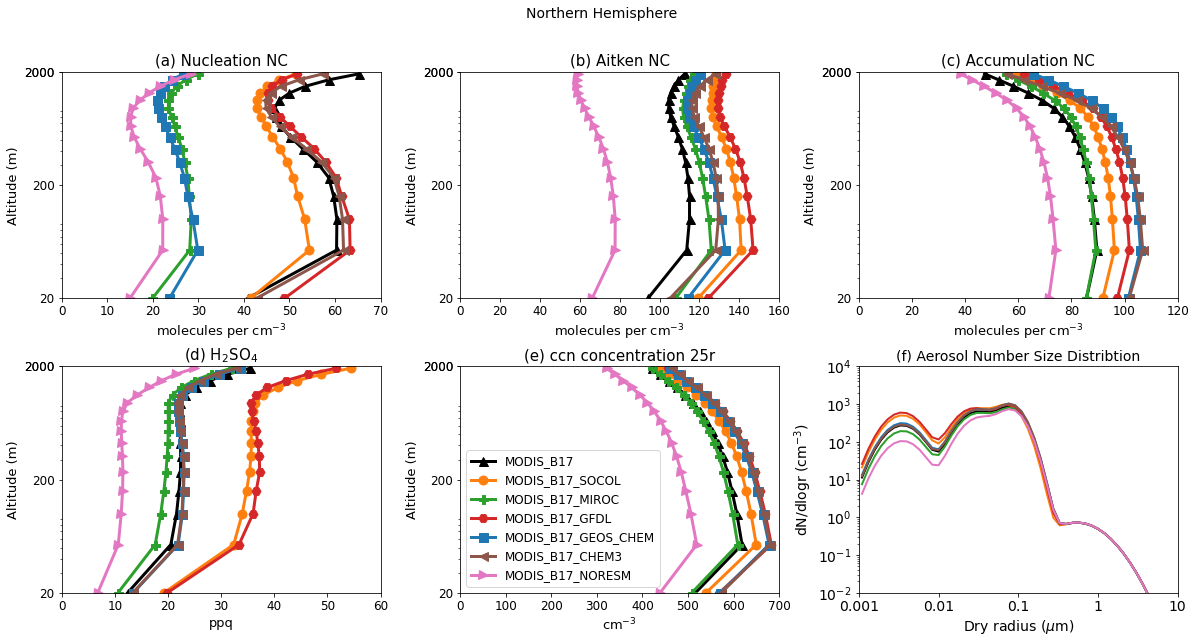

In [427]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(20,15), edgecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
# ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
# ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
# axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion_NH.npy')        
#num_con=np.sum(total_dndlr[:],axis=(2))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) Ai','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
#dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines


npts=50 # number of bins into which interpolate modal output
rmin=1.0e-9  # 1 nm
rmax=1.0e-5  # 10 microns

dryr_mid=np.zeros((npts),np.float64)
dryr_int=np.zeros((npts+1),np.float64)
deltar=np.zeros((npts),np.float64)

dryr_mids=np.zeros((npts),np.float64)
deltars=np.zeros((npts),np.float64)

for ibin in range(0,npts+1):
    logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
    dryr_int[ibin] = np.exp(logr)

for n in range(0,npts):
    dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
    deltar[n] = dryr_int[n+1]-dryr_int[n] #in m

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']
modes=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']
titles=['(a) Nucleation NC','(b) Aitken NC','(c) Accumulation NC','(d) H$_{2}$SO$_{4}$','(e) ccn concentration 25r','(f) Aerosol Number Size Distribtion']
# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']
num_con_sum=total_dndlr[0]

for i in range(0,5):
    ax1 = fig.add_subplot(3,3,i+1)
#    data=num_concentration[:,:,i]
#    data=data.transpose(1,0)
    for p in range(0,len(labels)):
        AOD_file=globals().get(labels[p]+'_file')
        
        if i == 3:
            data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_AOD_heights.nc').mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air.mean('time')*h2so4_ppt*1e3
        #    data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_Mass_Mixing_Ratio.nc').mass_fraction_of_sulfuric_acid_in_air.mean('time')*h2so4_ppt*1e3

            ax1.set_xlabel('ppq',fontsize=13)
        else:
            if i == 4:
#                data_num=xr.open_dataset(AOD_file+'../Annual_Processed/DROPLET_NUMBER_CONCENTRATION.nc').product_of_number_concentration_of_stratiform_cloud_liquid_water_particles_and_stratiform_cloud_liquid_water_area_fraction_and_sunlit_binary_mask.mean('time')
                data_num=xr.open_dataset(AOD_file+'../Annual_Processed/ccn_concentration_25r.nc').m01s38i439.mean('time')

                ax1.set_xlabel('cm$^{-3}$',fontsize=13)

            else:
                num_rat=xr.open_dataset(AOD_file+'../Annual_Processed/'+modes[i]+'.nc')[stash_mode[i]].mean('time')
                data_num=convert_num_den(air_num_den.data[:16],num_rat,MM_AER)

                ax1.set_xlabel('molecules per cm$^{-3}$',fontsize=13)
        data_num = data_num.sel(latitude=slice(0, 90))

        data=areaweight(data_num,lats.sel(latitude=slice(0, 90)))
        ax1.plot(data,heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)

    ax1.set_title('{}'.format(titles[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==0:
        ax1.set_xlim(0, 70)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==1:
        ax1.set_xlim(0, 160)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==2:
        ax1.set_xlim(0, 120)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==3:
        ax1.set_xlim(0, 60)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==4:
        ax1.set_xlim(0, 700)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 4:
        ax1.legend(fontsize=12)
#     if i == 1 or i == 4:
#         ax1.set_xlim(0, 45)  # Set the desired range for the y-axis (0 to 2000 meters)

    
num_con_sum=total_dndlr[:,0]

ax = fig.add_subplot(3,3,6)
for p in range(0,len(labels)):
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(num_con_sum[p])
    #djf=(total_dndlr_CA[file])*1e-6

    #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[p],linewidth=2,label=labels[p])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    ax.set_title(titles[-1],fontsize=14)

  #  plt.legend(loc='lower center',fontsize=19)

plt.suptitle('Northern Hemisphere',fontsize=20,x=.5,y=.94)

#plt.show()

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global_NH.pdf",dpi=50,bbox_inches = 'tight')
# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.pdf",dpi=50,bbox_inches = 'tight')

#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


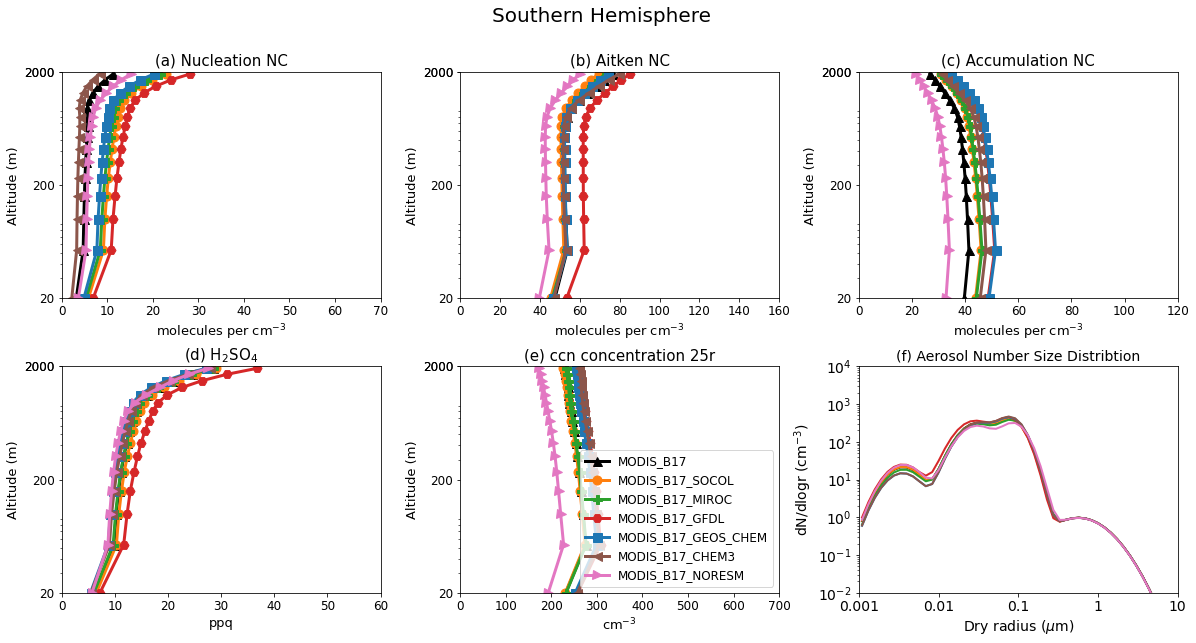

In [428]:
########################################################################################################
########################################################################################################
#   REPRODUCING FIGURE 10 FROM REVELL ET AL., 2019 
########################################################################################################
########################################################################################################
AOD_file=[MODIS_B17_file,MODIS_B17_SOCOL_file,MODIS_B17_MIROC_file,MODIS_B17_GFDL_file,MODIS_B17_GEOS_CHEM_file,
          MODIS_B17_CHEM3_file,MODIS_B17_NORESM_file]
# labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_CHEM3','MODIS_B17_NORESM',
#         'MODIS_B17_GEOS_CHEM','MODIS_B17_GFDL','MODIS_B17_MIROC']

#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']

fig = plt.figure(figsize=(20,15), edgecolor='w')
fig.subplots_adjust(hspace=0.3, wspace=0.25)
# ax = fig.add_subplot(3,3,1); ax1 = fig.add_subplot(3,3,2); ax2 = fig.add_subplot(3,3,3);
# ax3 = fig.add_subplot(4,2,5); ax4 = fig.add_subplot(4,2,6)
# axes=[ax,ax1,ax2,ax3,ax4]

modes=['(a) nucleation (sol) mode',
 '(b) aitken (sol) mode',
 '(c) accumulation (sol) mode',
 '(d) coarse (sol) mode',
 '(e) aitken (insol) mode'] 

labels=['MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
#colourss=['aqua','lightblue','cornflowerblue','navy','turquoise','deepskyblue','teal','cornflowerblue']
colourss=['black', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']
heights=xr.open_dataset(AOD_file[0]+'H2SO4_Mass_Mixing_Ratio.nc').level_height/1000

total_dndlr=np.load('/home/ybh10/Objective_3/Postprocess_Data/Area_Weighted/Aerosol_Number_Concentration_Size_Distriubtion_SH.npy')        
#num_con=np.sum(total_dndlr[:],axis=(2))

# rf_label=['Sulfate chemistry','DMS Source','DMS Emission']
title=['(a) Ai','(b) SO$_{2}$','(c) H$_{2}$SO$_{4}$','(d) SO$_{2}$/DMS','(e) water cloud droplet number concentration','(f) Mean Aerosol Number Concentration']
unit=['DMS (ppt)','SO$_{2}$ (ppt)','H2SO4 (ppt)','SO$_{2}$/DMS','cm$^{-3}$','dN/dlogr (cm$^{-3}$)']
# colorss=['red','blue','green']
#dataset=[dms,so2,h2so4,so2/dms,cloud,num_concentration]
num_lines = np.shape(colourss)  # Number of lines


npts=50 # number of bins into which interpolate modal output
rmin=1.0e-9  # 1 nm
rmax=1.0e-5  # 10 microns

dryr_mid=np.zeros((npts),np.float64)
dryr_int=np.zeros((npts+1),np.float64)
deltar=np.zeros((npts),np.float64)

dryr_mids=np.zeros((npts),np.float64)
deltars=np.zeros((npts),np.float64)

for ibin in range(0,npts+1):
    logr = np.log(rmin) + (np.log(rmax)-np.log(rmin)) * np.float(ibin)/np.float(npts)
    dryr_int[ibin] = np.exp(logr)

for n in range(0,npts):
    dryr_mid[n] = np.power(10,(0.5*(np.log10(dryr_int[n])+np.log10(dryr_int[n+1])))) #in m
    deltar[n] = dryr_int[n+1]-dryr_int[n] #in m

modes=['Number_nucleation_sol_mode','Number_aitken_sol_mode','Number_accumulation_sol_mode',
       'Number_coarse_sol_mode','Number_aitken_insol_mode']
stash_mode=['m01s38i504','m01s38i505','m01s38i506','m01s38i507','m01s38i508']
modes=['number_mixing_ratio_nucleation_sol_mode','number_mixing_ratio_aitken_sol_mode','number_mixing_ratio_accumulation_sol_mode',
         'number_mixing_ratio_coarse_sol_mode','number_mixing_ratio_aitken_insol_mode']
stash_mode=['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air','number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
            'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']
titles=['(a) Nucleation NC','(b) Aitken NC','(c) Accumulation NC','(d) H$_{2}$SO$_{4}$','(e) ccn concentration 25r','(f) Aerosol Number Size Distribtion']
# fig = plt.figure(figsize=(15,10), edgecolor='w')
# plt.subplots_adjust(hspace=0.3)#x=np.arange(40,70,5)
formatu=['^','o','P','H','s','<','>','*','H']
num_con_sum=total_dndlr[0]

for i in range(0,5):
    ax1 = fig.add_subplot(3,3,i+1)
#    data=num_concentration[:,:,i]
#    data=data.transpose(1,0)
    for p in range(0,len(labels)):
        AOD_file=globals().get(labels[p]+'_file')
        
        if i == 3:
            data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_AOD_heights.nc').mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air.mean('time')*h2so4_ppt*1e3
        #    data_num=xr.open_dataset(AOD_file+'../Annual_Processed/H2SO4_Mass_Mixing_Ratio.nc').mass_fraction_of_sulfuric_acid_in_air.mean('time')*h2so4_ppt*1e3

            ax1.set_xlabel('ppq',fontsize=13)
        else:
            if i == 4:
#                data_num=xr.open_dataset(AOD_file+'../Annual_Processed/DROPLET_NUMBER_CONCENTRATION.nc').product_of_number_concentration_of_stratiform_cloud_liquid_water_particles_and_stratiform_cloud_liquid_water_area_fraction_and_sunlit_binary_mask.mean('time')
                data_num=xr.open_dataset(AOD_file+'../Annual_Processed/ccn_concentration_25r.nc').m01s38i439.mean('time')

                ax1.set_xlabel('cm$^{-3}$',fontsize=13)

            else:
                num_rat=xr.open_dataset(AOD_file+'../Annual_Processed/'+modes[i]+'.nc')[stash_mode[i]].mean('time')
                data_num=convert_num_den(air_num_den.data[:16],num_rat,MM_AER)

                ax1.set_xlabel('molecules per cm$^{-3}$',fontsize=13)
        data_num = data_num.sel(latitude=slice(-90, 0))

        data=areaweight(data_num,lats.sel(latitude=slice(-90, 0)))
        ax1.plot(data,heights, color=colourss[p],marker=formatu[p],markersize=9,label=labels[p],linewidth=3)

    ax1.set_title('{}'.format(titles[i]),fontsize=15)
   # ax1.set_xlabel('{}'.format(unit[i]))
    ax1.set_ylabel('Altitude (m)',fontsize=13)

    ax1.margins(y=0)
#    ax1.set_xlim(x=0)
    ax1.set_xlim(0)
    ax1.set_yscale('log')
    ax1.set_ylim(0.02, 2)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==0:
        ax1.set_xlim(0, 70)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==1:
        ax1.set_xlim(0, 160)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==2:
        ax1.set_xlim(0, 120)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==3:
        ax1.set_xlim(0, 60)  # Set the desired range for the y-axis (0 to 2000 meters)
    if i ==4:
        ax1.set_xlim(0, 700)  # Set the desired range for the y-axis (0 to 2000 meters)

    # Manually set the y-axis tick locations and labels
    y_ticks = np.array([0.02, 0.2, 2, 2])  # Adjust these values as needed
    y_ticklabels = ['20', '200', '2000', '2000']  # Adjust these labels as needed
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    #ax1.set_ylim(0.01, 1000)
#plt.legend(fontsize=15, bbox_to_anchor=(1, 1), loc='lower right')
    if i == 4:
        ax1.legend(fontsize=12)
#     if i == 1 or i == 4:
#         ax1.set_xlim(0, 45)  # Set the desired range for the y-axis (0 to 2000 meters)

    
num_con_sum=total_dndlr[:,0]

ax = fig.add_subplot(3,3,6)
for p in range(0,len(labels)):
    rad_microm = dryr_mid*1e6
    radtoplot = np.log10(rad_microm)

    djf=(num_con_sum[p])
    #djf=(total_dndlr_CA[file])*1e-6

    #    djf_r=total_dndlr_CA*1e-6*(rad_microm**3)

    ax.plot(radtoplot, djf,color=colourss[p],linewidth=2,label=labels[p])
    ax.set_xlim(np.min(radtoplot),np.max(radtoplot))
    ax.set_xticks([-3,-2,-1,0,1])
    ax.set_xticklabels([0.001,0.01,0.1,1,10])
    #ax.set_xticklabels([0.001,0.01,0.1,1,10])

    ax.set_yscale('log')
    #ax.set_xscale('log')
    # #ax.set_xlim(1, 10000)
    ax.set_ylim(0.01, 10000)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)


    ax.set_ylabel('dN/dlogr (cm$^{-3}$)',fontsize=14)
    ax.set_xlabel('Dry radius ($\mu$m)',fontsize=14)
    ax.set_title(titles[-1],fontsize=14)

  #  plt.legend(loc='lower center',fontsize=19)

plt.suptitle('Southern Hemisphere',fontsize=20,x=0.5,y=.94)

#plt.show()
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global_SH.pdf",dpi=50,bbox_inches = 'tight')

# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.png",dpi=300,bbox_inches = 'tight')
# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Aerosol_Number_Conc_Global.pdf",dpi=50,bbox_inches = 'tight')

#plt.savefig("/home/ybh10/Objective_2/plots/10_Year_Simulation/Revell19_Fig7_CHEM3.png",dpi=600,bbox_inches = 'tight')


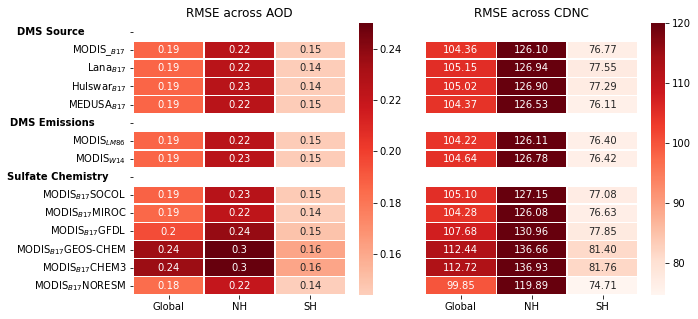

In [113]:
from matplotlib import font_manager
RMSE=[]
from math import sqrt
from sklearn.metrics import mean_squared_error
labels=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17',
        'MODIS_LM86','MODIS_W14',
        'MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']

modis_aod_observations=mod.MYD08_D3_6_1_Aerosol_Optical_Depth_Land_Ocean_Mean
modis_aod_observations_lat=mod.lat
modis_areaweight_global=areaweight(modis_aod_observations.mean('time'),modis_aod_observations_lat)
modis_areaweight_global_std=areaweight(modis_aod_observations.std('time'),modis_aod_observations_lat)
modis_nh=modis_aod_observations.sel(lat=slice(0, 90))
modis_sh=modis_aod_observations.sel(lat=slice(-90, 0))
modis_obs_data=[modis_aod_observations.data,modis_nh.data,modis_sh.data]

cdnc_obs=nd_g18.sel(time=(nd_g18['time'].dt.year.isin([2017, 2018])))
cdnc_obs_lat=cdnc_obs.lat
obs_cdnc_nh=cdnc_obs.sel(lat=slice(0, 90))
obs_cdnc_sh=cdnc_obs.sel(lat=slice(-90, 0))
cdnc_obs_data=[cdnc_obs.data,obs_cdnc_nh.data,obs_cdnc_sh.data]

land=xr.open_dataset('/home/ybh10/Objective_2/CMIP6/regrid-dmsos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc').dmsos[0]
land = np.tile(land, (730, 1, 1))
lands= [land,land[:,:72],land[:,72:]]

ccn_lat=ccn_obs_uk.lat
obs_ccn=ccn_obs_uk.sel(time=(ccn_obs_uk['time'].dt.year.isin([2017, 2018])))
obs_ccn_nh=obs_ccn.sel(lat=slice(0, 90))
obs_ccn_sh=obs_ccn.sel(lat=slice(-90, 0))

obs_ccn_data=[obs_ccn.data,obs_ccn_nh.data,obs_ccn_sh.data]
seasons=['Global','NH','SH']

obs_cdnccv=np.zeros(3); obs_cdnccv[:]=np.nan
obs_aodcv=np.zeros(3); obs_aodcv[:]=np.nan

for s in range(0,3):
    obs_cdncdata = obs_ccn_data[s]
    obs_cdnccv[s] = np.nanstd(obs_cdncdata) / np.nanmean(obs_cdncdata)
    obs_data_aod = modis_obs_data[s]
    obs_aodcv[s] = np.nanstd(obs_data_aod) / np.nanmean(obs_data_aod)


rms=np.zeros((len(labels),3)); rms[:]=np.nan
rms_cdnc=np.zeros((len(labels),3)); rms_cdnc[:]=np.nan
kge=np.zeros((len(labels),3)); kge[:]=np.nan
kge_cdnc=np.zeros((len(labels),3)); kge_cdnc[:]=np.nan
beta=np.zeros((len(labels),3)); beta[:]=np.nan
beta_cdnc=np.zeros((len(labels),3)); beta_cdnc[:]=np.nan


aod=np.zeros((len(labels),2,12,31)); aod[:] = np.nan
cdnc=np.zeros((len(labels),2,12,31)); cdnc[:] = np.nan

for i in range(0,len(labels)):
    AOD_file=globals().get(labels[i]+'_file')
    aod_data=xr.open_dataset(AOD_file+'../AOD.nc').__xarray_dataarray_variable__
    aod_data = aod_data.sortby('time')
    if len(aod_data.time) > 740:
        aod_data=aod_data.sel(time=(aod_data['time'].dt.year.isin([2017, 2018])))
    else:
        pass
    aod_nh = aod_data.sel(latitude=slice(0, 90))
    aod_sh = aod_data.sel(latitude=slice(-90, 0))
    aod_data_globe=[aod_data.data,aod_nh.data,aod_sh.data]
    
    cdnc_data=xr.open_dataset(AOD_file+'../Annual_Processed/CDNC.nc').__xarray_dataarray_variable__
    cdnc_data = cdnc_data.sortby('time')

    if len(cdnc_data.time) > 740:
        cdnc_data=cdnc_data.sel(time=(cdnc_data['time'].dt.year.isin([2017, 2018])))
    else:
        pass

    cdnc_nh = cdnc_data.sel(latitude=slice(0, 90))
    cdnc_sh = cdnc_data.sel(latitude=slice(-90, 0))
    cdnc_data_globe=[cdnc_data.data,cdnc_nh.data,cdnc_sh.data]
    
    for s in range(0,3):
        model_data= aod_data_globe[s]; obs_data = modis_obs_data[s] ; landy = lands[s]
        mask = (~np.isnan(model_data)) & (~np.isnan(obs_data))# & (~np.isnan(landy))
        model=model_data[mask] ; obs=obs_data[mask]
        rms[i,s] = sqrt(mean_squared_error(model,obs))
        kge[i,s], r, alpha, beta[i,s] = he.evaluator(he.kge, model, obs)
        
        
        model_data= cdnc_data_globe[s]; obs_data = cdnc_obs_data[s]
        mask = (~np.isnan(model_data)) & (~np.isnan(obs_data))# & (~np.isnan(landy))
        model=model_data[mask] ; obs=obs_data[mask]
        rms_cdnc[i,s] = sqrt(mean_squared_error(model,obs))
        kge_cdnc[i,s], r, alpha, beta_cdnc[i,s] = he.evaluator(he.kge, model, obs)
    
#     rms[i,4] = sqrt(mean_squared_error(aod_annual,modis_areaweight_global))
#     rms_cdnc[i,4] = sqrt(mean_squared_error(cdnc_annual,GROS_AREAWEIGHT_MEAN_Global))
labels=['MODIS_$_{B17}$','Lana$_{B17}$','Hulswar$_{B17}$','MEDUSA$_{B17}$',
        'MODIS$_{LM86}$','MODIS$_{W14}$',
        'MODIS$_{B17}$SOCOL','MODIS$_{B17}$MIROC','MODIS$_{B17}$GFDL','MODIS$_{B17}$GEOS-CHEM','MODIS$_{B17}$CHEM3','MODIS$_{B17}$NORESM']

season=['Global','NH','SH']

fig = plt.figure(figsize=(10,5), edgecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

labels_with_gap = np.insert(labels, 0, 'DMS Source                    ')  # Insert an empty label at the 4th position
labels_with_gap = np.insert(labels_with_gap, 5, 'DMS Emissions                    ')  # Insert an empty label at the 4th position
labels_with_gap = np.insert(labels_with_gap, 8, 'Sulfate Chemistry                    ')  # Insert an empty label at the 4th position
#labels_with_gap = np.insert(labels_with_gap, 15, 'OBSERVATION                    ')  # Insert an empty label at the 4th position

plt.subplots_adjust(wspace=0.1)#x=np.arange(40,70,5)
levels = np.linspace(0, 0.09, 10)

rms_with_nan = np.insert(rms, 0, np.nan, axis=0)
rms_with_nan = np.insert(rms_with_nan, 5, np.nan, axis=0)
rms_with_nan = np.insert(rms_with_nan, 8, np.nan, axis=0)
#rms_with_nan = np.insert(rms_with_nan, 15, obs_aodcv, axis=0)

rmscdnc_with_nan = np.insert(rms_cdnc, 0, np.nan, axis=0)
rmscdnc_with_nan = np.insert(rmscdnc_with_nan, 5, np.nan, axis=0)
#rmscdnc_with_nan = np.insert(rmscdnc_with_nan, 15, obs_cdnccv, axis=0)

g=sns.heatmap(rms_with_nan, cmap="Reds",  annot=True, linewidths=.5, xticklabels=season, yticklabels=labels_with_gap,ax=ax1,vmax=0.25,center=0.185)
#plt.xticks(rotation=45)
#   g.set_yticklabels(g.get_yticklabels(), rotation=0)
d=sns.heatmap(rmscdnc_with_nan, cmap="Reds", annot=True, fmt='.2f', linewidths=.5, xticklabels=season, yticklabels='',ax=ax2,vmax=120)#center=20)
#   d.set_yticklabels(d.get_yticklabels(), rotation=0)
# Add a title and labels for the axes
ax1.set_title('RMSE across AOD')
ax2.set_title('RMSE across CDNC')
# Set the font weight for the 4th and 7th labels to bold
font_prop = font_manager.FontProperties(weight='bold')
yticklabels = g.yaxis.get_ticklabels()
yticklabels[0].set_font_properties(font_prop)
yticklabels[5].set_font_properties(font_prop)
yticklabels[8].set_font_properties(font_prop)


#plt.show()
# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity//Heat_Map_Global_land_mask.png",dpi=300,bbox_inches = 'tight')
# plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Heat_Map_Global_land_mask.pdf",dpi=50,bbox_inches = 'tight')


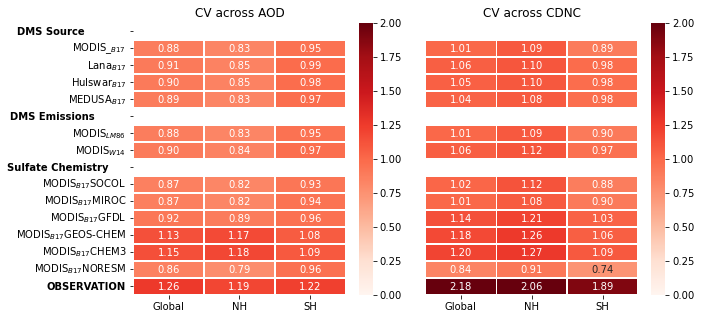

In [188]:
labels=['MODIS_$_{B17}$','Lana$_{B17}$','Hulswar$_{B17}$','MEDUSA$_{B17}$',
        'MODIS$_{LM86}$','MODIS$_{W14}$',
        'MODIS$_{B17}$SOCOL','MODIS$_{B17}$MIROC','MODIS$_{B17}$GFDL','MODIS$_{B17}$GEOS-CHEM','MODIS$_{B17}$CHEM3','MODIS$_{B17}$NORESM']

season=['Global','NH','SH']

fig = plt.figure(figsize=(10,5), edgecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

labels_with_gap = np.insert(labels, 0, 'DMS Source                    ')  # Insert an empty label at the 4th position
labels_with_gap = np.insert(labels_with_gap, 5, 'DMS Emissions                    ')  # Insert an empty label at the 4th position
labels_with_gap = np.insert(labels_with_gap, 8, 'Sulfate Chemistry                    ')  # Insert an empty label at the 4th position
labels_with_gap = np.insert(labels_with_gap, 15, 'OBSERVATION')  # Insert an empty label at the 4th position

plt.subplots_adjust(wspace=0.1)#x=np.arange(40,70,5)
levels = np.linspace(0, 0.09, 10)

rms_with_nan = np.insert(beta, 0, np.nan, axis=0)
rms_with_nan = np.insert(rms_with_nan, 5, np.nan, axis=0)
rms_with_nan = np.insert(rms_with_nan, 8, np.nan, axis=0)
rms_with_nan = np.insert(rms_with_nan, 15, obs_aodcv, axis=0)

rmscdnc_with_nan = np.insert(beta_cdnc, 0, np.nan, axis=0)
rmscdnc_with_nan = np.insert(rmscdnc_with_nan, 5, np.nan, axis=0)
rmscdnc_with_nan = np.insert(rmscdnc_with_nan, 8, np.nan, axis=0)
rmscdnc_with_nan = np.insert(rmscdnc_with_nan, 15, obs_cdnccv, axis=0)

g=sns.heatmap(rms_with_nan, cmap="Reds",  annot=True, linewidths=.5,  fmt='.2f',xticklabels=season, yticklabels=labels_with_gap,ax=ax1,vmin=0,vmax=2,center=1)
#plt.xticks(rotation=45)
#   g.set_yticklabels(g.get_yticklabels(), rotation=0)
d=sns.heatmap(rmscdnc_with_nan, cmap="Reds", annot=True, fmt='.2f', linewidths=.5, xticklabels=season, yticklabels='',ax=ax2,vmin=0,vmax=2,center=1)
#   d.set_yticklabels(d.get_yticklabels(), rotation=0)
# Add a title and labels for the axes
ax1.set_title('CV across AOD')
ax2.set_title('CV across CDNC')
# Set the font weight for the 4th and 7th labels to bold
font_prop = font_manager.FontProperties(weight='bold')
yticklabels = g.yaxis.get_ticklabels()
yticklabels[0].set_font_properties(font_prop)
yticklabels[5].set_font_properties(font_prop)
yticklabels[8].set_font_properties(font_prop)
yticklabels[15].set_font_properties(font_prop)

plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity//Heat_Map_Global_CV.png",dpi=300,bbox_inches = 'tight')
plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Heat_Map_Global_CV.pdf",dpi=50,bbox_inches = 'tight')


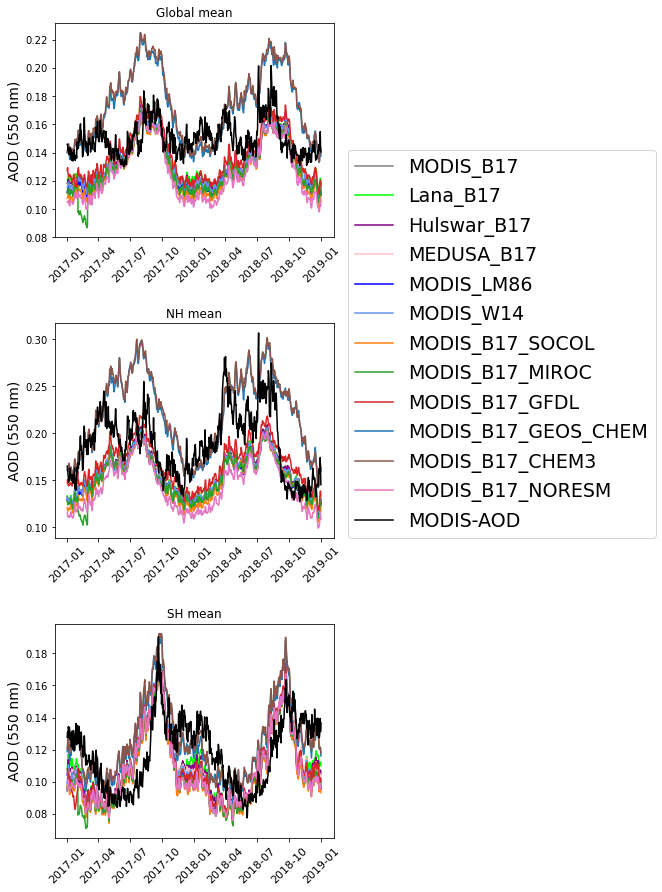

In [358]:
labels=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17',
        'MODIS_LM86','MODIS_W14',
        'MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']

cdnc_obs_data = cdnc_obs.mean(['lat','lon'])
aod_obs_data = modis_aod_observations.mean(['lat','lon'])
aod_obs_data_std = modis_aod_observations.std(['lat','lon'])

#aod_obs_data = areaweight(modis_aod_observations,modis_aod_observations_lat)

aod_obs_data_nh = modis_nh.mean(['lat','lon'])
aod_obs_data_sh = modis_sh.mean(['lat','lon'])
# aod_obs_data_nh = areaweight(modis_nh,modis_aod_observations_lat[72:])
# aod_obs_data_sh = areaweight(modis_sh,modis_aod_observations_lat[:72])


aod_model=np.zeros((len(labels),730)); aod_model[:]=np.nan
aod_model_nh=np.zeros((len(labels),730)); aod_model_nh[:]=np.nan
aod_model_sh=np.zeros((len(labels),730)); aod_model_sh[:]=np.nan

#cdnc_model=np.zeros((len(labels),730)); cdnc_model[:]=np.nan
lats_sh = lats.sel(latitude=slice(-90, 0))
lats_nh = lats.sel(latitude=slice(0, 90))

for i in range(0,len(labels)):
    AOD_file=globals().get(labels[i]+'_file')
    aod_data=xr.open_dataset(AOD_file+'../AOD.nc').__xarray_dataarray_variable__
    aod_data = aod_data.sortby('time')
    if len(aod_data.time) > 740:
        aod_data=aod_data.sel(time=(aod_data['time'].dt.year.isin([2017, 2018])))
    else:
        pass
    if labels[i] == 'MODIS_B17_GFDL':
        aod_data[:31]=aod_data[31:62].data

    aod_nh = aod_data.sel(latitude=slice(0, 90))
    aod_sh = aod_data.sel(latitude=slice(-90, 0))

#     aod_model_nh[i,:]=aod_nh.mean(['latitude','longitude'])
#     aod_model_sh[i,:]=aod_sh.mean(['latitude','longitude'])
    aod_model_nh[i,:]=areaweight(aod_nh,lats_nh)
    aod_model_sh[i,:]=areaweight(aod_sh,lats_sh)


  #  aod_model[i,:]=aod_data.mean(['latitude','longitude'])
    aod_model[i,:]=areaweight(aod_data,lats)

#aod_model[-4][:31]=aod_model[1][:31]
colourss=['grey','lime','purple','pink','blue','cornflowerblue', '#ff7f0eFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#8c564bFF', '#e377c2FF']

fig = plt.figure(figsize=(5,15), edgecolor='w')
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
plt.subplots_adjust(hspace=0.4)#x=np.arange(40,70,5)

for i in range(0,12):
    ax1.plot(aod_data.time,aod_model[i],color=colourss[i],label=labels[i])
    ax2.plot(aod_data.time,aod_model_nh[i],color=colourss[i],label=labels[i])
    ax3.plot(aod_data.time,aod_model_sh[i],color=colourss[i],label=labels[i])

ax1.plot(aod_data.time,aod_obs_data,color='black',label='MODIS-AOD')
ax2.plot(aod_data.time,aod_obs_data_nh,color='black',label='MODIS-AOD')
ax3.plot(aod_data.time,aod_obs_data_sh,color='black')
ax1.xaxis.set_tick_params(labelsize=11,rotation=45)
ax2.xaxis.set_tick_params(labelsize=11,rotation=45)
ax3.xaxis.set_tick_params(labelsize=11,rotation=45)
ax1.set_title('Global mean')
ax2.set_title('NH mean')
ax3.set_title('SH mean')
ax1.set_ylabel('AOD (550 nm)',fontsize=14)
ax2.set_ylabel('AOD (550 nm)',fontsize=14)
ax3.set_ylabel('AOD (550 nm)',fontsize=14)
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=19)


plt.savefig("/home/ybh10/Objective_3/Plots/H2SO4_plots/Sensitivity/Global_NH_SH_AOD_Timeseries.pdf",dpi=50,bbox_inches = 'tight')


#ax1.set_xticks(np.arange(2018,2019,0.1))
#ax1.set_xticklabels([0.001,0.01,0.1,1,10])

#ax1.set_ylim(0, 0.31)

In [13]:
labels=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_B17','MODIS_LM86','MODIS_W14','MODIS_B17','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']
labels=['MODIS_B17','Lana_B17','Hulswar_B17','MEDUSA_B17','MODIS_LM86','MODIS_W14','MODIS_B17_SOCOL','MODIS_B17_MIROC','MODIS_B17_GFDL','MODIS_B17_GEOS_CHEM','MODIS_B17_CHEM3','MODIS_B17_NORESM']

# AOD bias also for CCN
for i in range(0,len(labels)):

    AOD_file=globals().get(labels[i]+'_file')

    #print("{} & {:.3f} & {:.0f} & {:.3f} & {:.0f} & {:.3f} & {:.0f} \ \ "
        #  .format(labels[i],AOD[i]-aod_global,CCN[i]-ccn_global_obs,AOD_nh[i]-modis__NH,CCN_nh[i]-ccn_global_obs_NH,AOD_sh[i]-modis__SH,CCN_sh[i]-ccn_global_obs_SH))
    dms=xr.open_dataset(AOD_file+'../Annual_Processed/DMS_Mass_Mixing_Ratio_all.nc').mass_fraction_of_dimethyl_sulfide_in_air*(32.065/62.13)
    #so2=xr.open_dataset(AOD_file+'../Annual_Processed/SO2_MASS_MIXING_RATIO_all.nc').mass_fraction_of_sulfur_dioxide_in_air.mean('time')*(32.06/(32.00+32.06))
    airmass=xr.open_dataset('/home/ybh10/Objective_3/Air_Mass.nc').m01s50i063
    d=dms*airmass
    mass=(d.sum()/kg_to_gg)

    d.to_netcdf(AOD_file+'../Annual_Processed/DMS_S_Burden_kg.nc')

# #     so2_nh=so2[:,72:-22].sum().data
# #     dms_nh=dms[:,72:-22].sum().data
# #     so2_sh=so2[:,22:72].sum().data
# #     dms_sh=dms[:,22:72].sum().data
# #     so2_g=so2[:,22:-22].sum().data
# #     dms_g=dms[:,22:-22].sum().data
#     so2_nh=so2[:,72:].sum().data
#     dms_nh=dms[:,72:].sum().data
#     so2_sh=so2[:,:72].sum().data
#     dms_sh=dms[:,:72].sum().data
#     so2_g=so2[:,].sum().data
#     dms_g=dms[:,].sum().data

    print('{}'.format(labels[i]))
#     print('GLOBAL = {:.1f}'.format(dms_g/so2_g*100))
#     print('NH = {:.1f}'.format(dms_nh/so2_nh*100))
#     print('SH = {:.1f}'.format(dms_sh/so2_sh*100))
#     print('NH global = {:.1f}'.format(dms_nh/so2_g*100))
#     print('SH global= {:.1f}'.format(dms_sh/so2_g*100))
#     #end
#     print('Global DMS S Burden = {:.1f}'.format(mass.data))

#     print('----------------')


MODIS_B17
Lana_B17
Hulswar_B17
MEDUSA_B17
MODIS_LM86
MODIS_W14
MODIS_B17_SOCOL
MODIS_B17_MIROC
MODIS_B17_GFDL
MODIS_B17_GEOS_CHEM
MODIS_B17_CHEM3
MODIS_B17_NORESM
